# Projeto Sistema de Reconhecimento Facial

## 1. Atualização das bibliotecas
Instalamos as bibliotecas necessárias para rodar o projeto:  
!pip install -q ultralytics tensorflow opencv-python-headless matplotlib tqdm

## 2. Instalação de dependências
- `ultralytics` → framework YOLOv8  
- `tensorflow` → suporte a redes neurais  
- `opencv-python-headless` → manipulação de imagens  
- `matplotlib` → visualização de gráficos  
- `tqdm` → barra de progresso  



In [ ]:

# Instalação de dependências
!pip install -q ultralytics tensorflow opencv-python-headless matplotlib tqdm

import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import tqdm
from ultralytics import YOLO


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 27.0 MB/s eta 0:00:00
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


## 3. Baixar dataset LFW
Vamos utilizar o **LFW (Labeled Faces in the Wild)**, um conjunto de dados de rostos bastante usado em pesquisas de reconhecimento facial.  

- O `tensorflow_datasets` permite baixar e carregar o dataset.  
- As imagens são salvas localmente em pastas organizadas por **nome da pessoa**, sem carregar tudo na RAM de uma vez (streaming).  


In [ ]:
# Baixar dataset LFW
import tensorflow_datasets as tfds

dataset, info = tfds.load("lfw", split="train", with_info=True)

# Criar pasta bruta
raw_dir = Path("faces_raw")
raw_dir.mkdir(exist_ok=True)

# Salvar imagens em pastas (streaming, sem estourar RAM)
i = 0
for example in tfds.as_numpy(dataset):
    image = example["image"]
    label = example["label"].decode("utf-8").replace(" ", "_")
    save_dir = raw_dir / label
    save_dir.mkdir(parents=True, exist_ok=True)

    cv2.imwrite(str(save_dir / f"{i}.jpg"), cv2.cvtColor(image, cv2.COLOR_RGB2BGR))
    i += 1

print("Total de imagens salvas:", i)



Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/lfw/incomplete.OPAN3O_0.1.1/lfw-train.tfrecord*...:   0%|          | 0/132…

Dataset lfw downloaded and prepared to /root/tensorflow_datasets/lfw/0.1.1. Subsequent calls will reuse this data.
Total de imagens salvas: 13233


## 4. Detectar e recortar faces com YOLO
Agora vamos usar o **YOLOv8 pré-treinado** (`yolov8n.pt`) para detectar pessoas nas imagens do dataset LFW e recortar apenas as regiões de rosto.  

- O modelo identifica a classe `person` (`classes=[0]`).  
- Cada face detectada é **recortada** e **redimensionada para 160×160** pixels.  
- As imagens são salvas em uma nova pasta organizada por pessoa (`faces_cortado`).  

In [ ]:
# Detectar e recortar faces com YOLO
output_dir = Path("faces_cortado")
output_dir.mkdir(exist_ok=True)

yolo_model = YOLO("yolov8n.pt")

for person_dir in tqdm(list(raw_dir.iterdir())):
    save_person_dir = output_dir / person_dir.name
    save_person_dir.mkdir(parents=True, exist_ok=True)

    for img_path in person_dir.glob("*.jpg"):
        img = cv2.imread(str(img_path))
        results = yolo_model(img, classes=[0])  # detecta "person"
        for r in results:
            for box in r.boxes.xyxy.cpu().numpy():
                x1, y1, x2, y2 = map(int, box[:4])
                face = img[y1:y2, x1:x2]
                if face.size > 0:
                    face_resized = cv2.resize(face, (160, 160))
                    cv2.imwrite(str(save_person_dir / img_path.name), face_resized)




  0%|          | 0/5749 [00:00<?, ?it/s]


0: 640x640 1 person, 8.1ms
Speed: 9.4ms preprocess, 8.1ms inference, 460.6ms postprocess per image at shape (1, 3, 640, 640)


  0%|          | 1/5749 [00:01<2:59:03,  1.87s/it]


0: 640x640 2 persons, 9.8ms
Speed: 4.4ms preprocess, 9.8ms inference, 6.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.3ms
Speed: 2.9ms preprocess, 9.3ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 18.6ms
Speed: 3.2ms preprocess, 18.6ms inference, 3.2ms postprocess per image at shape (1, 3, 640, 640)


  0%|          | 4/5749 [00:01<36:35,  2.62it/s]  


0: 640x640 1 person, 21.5ms
Speed: 3.2ms preprocess, 21.5ms inference, 4.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 10.3ms
Speed: 11.1ms preprocess, 10.3ms inference, 6.4ms postprocess per image at shape (1, 3, 640, 640)


  0%|          | 6/5749 [00:02<22:48,  4.20it/s]


0: 640x640 1 person, 29.7ms
Speed: 4.3ms preprocess, 29.7ms inference, 3.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 17.0ms
Speed: 6.0ms preprocess, 17.0ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.3ms
Speed: 3.1ms preprocess, 9.3ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)


  0%|          | 9/5749 [00:02<13:35,  7.04it/s]


0: 640x640 1 person, 16.3ms
Speed: 12.1ms preprocess, 16.3ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 15.6ms
Speed: 3.2ms preprocess, 15.6ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 9.6ms
Speed: 3.1ms preprocess, 9.6ms inference, 15.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 9.6ms
Speed: 5.1ms preprocess, 9.6ms inference, 17.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 18.1ms
Speed: 3.2ms preprocess, 18.1ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.0ms
Speed: 3.2ms preprocess, 9.0ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)


  0%|          | 12/5749 [00:02<10:37,  9.00it/s]


0: 640x640 1 person, 8.7ms
Speed: 3.9ms preprocess, 8.7ms inference, 4.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.1ms
Speed: 3.1ms preprocess, 9.1ms inference, 5.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 11.7ms
Speed: 3.1ms preprocess, 11.7ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.2ms
Speed: 4.4ms preprocess, 9.2ms inference, 3.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 18.6ms
Speed: 3.1ms preprocess, 18.6ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)


  0%|          | 16/5749 [00:02<07:14, 13.19it/s]


0: 640x640 2 persons, 31.2ms
Speed: 3.1ms preprocess, 31.2ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 27.7ms
Speed: 3.2ms preprocess, 27.7ms inference, 5.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 30.3ms
Speed: 3.4ms preprocess, 30.3ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 45.9ms
Speed: 7.6ms preprocess, 45.9ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)


  0%|          | 19/5749 [00:02<07:01, 13.59it/s]


0: 640x640 3 persons, 9.9ms
Speed: 3.2ms preprocess, 9.9ms inference, 3.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 10.0ms
Speed: 3.3ms preprocess, 10.0ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 18.4ms
Speed: 3.4ms preprocess, 18.4ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)


  0%|          | 22/5749 [00:02<05:53, 16.19it/s]


0: 640x640 2 persons, 10.6ms
Speed: 4.0ms preprocess, 10.6ms inference, 3.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 9.4ms
Speed: 3.8ms preprocess, 9.4ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 18.8ms
Speed: 4.0ms preprocess, 18.8ms inference, 6.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 51.8ms
Speed: 22.4ms preprocess, 51.8ms inference, 7.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 26.7ms
Speed: 11.3ms preprocess, 26.7ms inference, 7.6ms postprocess per image at shape (1, 3, 640, 640)


  0%|          | 26/5749 [00:03<05:53, 16.18it/s]


0: 640x640 2 persons, 22.3ms
Speed: 5.7ms preprocess, 22.3ms inference, 8.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 14.8ms
Speed: 3.2ms preprocess, 14.8ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 31.4ms
Speed: 3.2ms preprocess, 31.4ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 21.1ms
Speed: 3.1ms preprocess, 21.1ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 30.5ms
Speed: 4.8ms preprocess, 30.5ms inference, 12.1ms postprocess per image at shape (1, 3, 640, 640)


  1%|          | 29/5749 [00:03<06:36, 14.43it/s]


0: 640x640 2 persons, 14.8ms
Speed: 3.5ms preprocess, 14.8ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 17.2ms
Speed: 3.8ms preprocess, 17.2ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 11.7ms
Speed: 3.1ms preprocess, 11.7ms inference, 16.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 50.9ms
Speed: 6.3ms preprocess, 50.9ms inference, 20.6ms postprocess per image at shape (1, 3, 640, 640)


  1%|          | 31/5749 [00:03<07:43, 12.34it/s]


0: 640x640 1 person, 31.9ms
Speed: 8.9ms preprocess, 31.9ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 38.8ms
Speed: 3.1ms preprocess, 38.8ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 23.0ms
Speed: 3.2ms preprocess, 23.0ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)


  1%|          | 33/5749 [00:03<08:16, 11.52it/s]


0: 640x640 2 persons, 33.5ms
Speed: 3.1ms preprocess, 33.5ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 15.7ms
Speed: 13.3ms preprocess, 15.7ms inference, 17.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 55.0ms
Speed: 3.0ms preprocess, 55.0ms inference, 16.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 29.9ms
Speed: 20.4ms preprocess, 29.9ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 29.3ms
Speed: 4.9ms preprocess, 29.3ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 15.0ms
Speed: 3.1ms preprocess, 15.0ms inference, 9.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 32.1ms
Speed: 4.9ms preprocess, 32.1ms inference, 7.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 20.4ms
Speed: 8.2ms preprocess, 20.4ms inference, 3.5ms postprocess per image at shape (1,

  1%|          | 35/5749 [00:04<15:39,  6.08it/s]


0: 640x640 3 persons, 21.8ms
Speed: 6.9ms preprocess, 21.8ms inference, 4.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 24.7ms
Speed: 5.7ms preprocess, 24.7ms inference, 11.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 25.9ms
Speed: 3.3ms preprocess, 25.9ms inference, 3.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 49.4ms
Speed: 3.3ms preprocess, 49.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


  1%|          | 36/5749 [00:04<16:17,  5.85it/s]


0: 640x640 1 person, 27.1ms
Speed: 12.7ms preprocess, 27.1ms inference, 4.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 12.0ms
Speed: 6.2ms preprocess, 12.0ms inference, 5.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 20.8ms
Speed: 3.7ms preprocess, 20.8ms inference, 15.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 17.8ms
Speed: 3.1ms preprocess, 17.8ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 30.1ms
Speed: 3.2ms preprocess, 30.1ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.1ms
Speed: 3.3ms preprocess, 9.1ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 18.2ms
Speed: 4.9ms preprocess, 18.2ms inference, 5.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 17.2ms
Speed: 3.2ms preprocess, 17.2ms inference, 5.1ms postprocess per image at shape (1, 3, 6

  1%|          | 38/5749 [00:05<17:34,  5.41it/s]


0: 640x640 1 person, 16.5ms
Speed: 5.0ms preprocess, 16.5ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 9.1ms
Speed: 3.9ms preprocess, 9.1ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 23.7ms
Speed: 8.1ms preprocess, 23.7ms inference, 7.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 21.7ms
Speed: 7.5ms preprocess, 21.7ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 10.6ms
Speed: 6.7ms preprocess, 10.6ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)


  1%|          | 39/5749 [00:05<17:45,  5.36it/s]


0: 640x640 2 persons, 13.0ms
Speed: 4.7ms preprocess, 13.0ms inference, 3.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 10.7ms
Speed: 3.0ms preprocess, 10.7ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 10.3ms
Speed: 5.2ms preprocess, 10.3ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.9ms
Speed: 5.1ms preprocess, 9.9ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)


  1%|          | 41/5749 [00:05<13:36,  6.99it/s]


0: 640x640 1 person, 11.8ms
Speed: 7.2ms preprocess, 11.8ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 20.9ms
Speed: 4.9ms preprocess, 20.9ms inference, 8.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 17.8ms
Speed: 6.4ms preprocess, 17.8ms inference, 5.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 persons, 20.8ms
Speed: 8.0ms preprocess, 20.8ms inference, 4.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 10.4ms
Speed: 8.8ms preprocess, 10.4ms inference, 17.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 26.6ms
Speed: 2.9ms preprocess, 26.6ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 persons, 24.3ms
Speed: 16.1ms preprocess, 24.3ms inference, 3.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 persons, 9.3ms
Speed: 5.7ms preprocess, 9.3ms inference, 3.5ms postprocess per image at shape (1, 

  1%|          | 43/5749 [00:06<20:00,  4.75it/s]


0: 640x640 1 person, 19.3ms
Speed: 3.6ms preprocess, 19.3ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 13.3ms
Speed: 2.9ms preprocess, 13.3ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.4ms
Speed: 27.1ms preprocess, 9.4ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)


  1%|          | 46/5749 [00:06<13:21,  7.12it/s]


0: 640x640 3 persons, 9.4ms
Speed: 3.2ms preprocess, 9.4ms inference, 3.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 14.3ms
Speed: 3.2ms preprocess, 14.3ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 persons, 30.7ms
Speed: 9.0ms preprocess, 30.7ms inference, 12.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.9ms
Speed: 3.0ms preprocess, 8.9ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 640)


  1%|          | 49/5749 [00:06<10:00,  9.50it/s]


0: 640x640 1 person, 9.1ms
Speed: 2.9ms preprocess, 9.1ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 12.4ms
Speed: 4.7ms preprocess, 12.4ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.1ms
Speed: 3.8ms preprocess, 9.1ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.1ms
Speed: 3.9ms preprocess, 9.1ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.1ms
Speed: 4.0ms preprocess, 9.1ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)


  1%|          | 54/5749 [00:06<06:23, 14.87it/s]


0: 640x640 2 persons, 8.9ms
Speed: 4.2ms preprocess, 8.9ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.7ms
Speed: 3.5ms preprocess, 8.7ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.4ms
Speed: 4.3ms preprocess, 9.4ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.9ms
Speed: 3.9ms preprocess, 9.9ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 19.5ms
Speed: 5.8ms preprocess, 19.5ms inference, 8.8ms postprocess per image at shape (1, 3, 640, 640)


  1%|          | 58/5749 [00:06<05:17, 17.94it/s]


0: 640x640 2 persons, 10.1ms
Speed: 3.2ms preprocess, 10.1ms inference, 3.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 persons, 25.7ms
Speed: 3.2ms preprocess, 25.7ms inference, 8.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.3ms
Speed: 3.0ms preprocess, 9.3ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)


  1%|          | 61/5749 [00:06<04:46, 19.83it/s]


0: 640x640 1 person, 9.3ms
Speed: 3.1ms preprocess, 9.3ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.9ms
Speed: 3.0ms preprocess, 8.9ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 9.9ms
Speed: 3.0ms preprocess, 9.9ms inference, 3.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.9ms
Speed: 3.1ms preprocess, 9.9ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 13.5ms
Speed: 3.6ms preprocess, 13.5ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.8ms
Speed: 3.0ms preprocess, 9.8ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)


  1%|          | 64/5749 [00:07<04:58, 19.07it/s]


0: 640x640 1 person, 9.4ms
Speed: 3.2ms preprocess, 9.4ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 9.7ms
Speed: 3.0ms preprocess, 9.7ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 10.1ms
Speed: 3.3ms preprocess, 10.1ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.1ms
Speed: 3.0ms preprocess, 9.1ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)


  1%|          | 68/5749 [00:07<04:10, 22.63it/s]


0: 640x640 3 persons, 9.6ms
Speed: 3.1ms preprocess, 9.6ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 persons, 11.1ms
Speed: 3.0ms preprocess, 11.1ms inference, 4.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.9ms
Speed: 4.5ms preprocess, 9.9ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 9.2ms
Speed: 3.1ms preprocess, 9.2ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 9.6ms
Speed: 4.2ms preprocess, 9.6ms inference, 3.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.8ms
Speed: 4.2ms preprocess, 9.8ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)


  1%|          | 71/5749 [00:07<04:34, 20.67it/s]


0: 640x640 3 persons, 9.5ms
Speed: 4.4ms preprocess, 9.5ms inference, 3.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.5ms
Speed: 4.2ms preprocess, 8.5ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 30.0ms
Speed: 4.3ms preprocess, 30.0ms inference, 7.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 39.1ms
Speed: 4.2ms preprocess, 39.1ms inference, 19.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 34.1ms
Speed: 12.6ms preprocess, 34.1ms inference, 3.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 36.3ms
Speed: 4.4ms preprocess, 36.3ms inference, 9.7ms postprocess per image at shape (1, 3, 640, 640)


  1%|▏         | 74/5749 [00:07<06:04, 15.58it/s]


0: 640x640 4 persons, 10.0ms
Speed: 4.1ms preprocess, 10.0ms inference, 3.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 15.1ms
Speed: 4.3ms preprocess, 15.1ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 10.3ms
Speed: 4.7ms preprocess, 10.3ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 10.0ms
Speed: 5.1ms preprocess, 10.0ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 9.2ms
Speed: 4.3ms preprocess, 9.2ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 9.6ms
Speed: 8.1ms preprocess, 9.6ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


  1%|▏         | 78/5749 [00:07<05:19, 17.76it/s]


0: 640x640 1 person, 9.2ms
Speed: 4.5ms preprocess, 9.2ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 persons, 12.1ms
Speed: 9.3ms preprocess, 12.1ms inference, 4.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 9.3ms
Speed: 6.4ms preprocess, 9.3ms inference, 3.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 persons, 9.3ms
Speed: 3.2ms preprocess, 9.3ms inference, 3.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 11.4ms
Speed: 6.6ms preprocess, 11.4ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 21.3ms
Speed: 4.4ms preprocess, 21.3ms inference, 3.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.7ms
Speed: 4.4ms preprocess, 8.7ms inference, 13.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 9.9ms
Speed: 11.8ms preprocess, 9.9ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 

  1%|▏         | 81/5749 [00:08<07:55, 11.92it/s]


0: 640x640 1 person, 9.5ms
Speed: 3.1ms preprocess, 9.5ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.3ms
Speed: 3.1ms preprocess, 9.3ms inference, 10.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.2ms
Speed: 3.2ms preprocess, 9.2ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.9ms
Speed: 3.1ms preprocess, 8.9ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.1ms
Speed: 3.3ms preprocess, 9.1ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)


  1%|▏         | 84/5749 [00:08<06:47, 13.91it/s]


0: 640x640 2 persons, 10.4ms
Speed: 3.5ms preprocess, 10.4ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 9.1ms
Speed: 3.3ms preprocess, 9.1ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 11.1ms
Speed: 3.2ms preprocess, 11.1ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 9.8ms
Speed: 3.1ms preprocess, 9.8ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 12.6ms
Speed: 3.3ms preprocess, 12.6ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


  2%|▏         | 88/5749 [00:08<05:21, 17.60it/s]


0: 640x640 1 person, 10.3ms
Speed: 2.9ms preprocess, 10.3ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 14.7ms
Speed: 8.0ms preprocess, 14.7ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 15.8ms
Speed: 3.1ms preprocess, 15.8ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 14.5ms
Speed: 6.0ms preprocess, 14.5ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 10.3ms
Speed: 3.2ms preprocess, 10.3ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)


  2%|▏         | 91/5749 [00:08<05:06, 18.45it/s]


0: 640x640 5 persons, 9.9ms
Speed: 3.1ms preprocess, 9.9ms inference, 10.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 11.1ms
Speed: 4.5ms preprocess, 11.1ms inference, 5.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 persons, 9.4ms
Speed: 3.4ms preprocess, 9.4ms inference, 3.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 12.4ms
Speed: 3.0ms preprocess, 12.4ms inference, 4.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.8ms
Speed: 3.2ms preprocess, 9.8ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)


  2%|▏         | 94/5749 [00:08<04:58, 18.93it/s]


0: 640x640 5 persons, 10.6ms
Speed: 3.3ms preprocess, 10.6ms inference, 17.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 10.5ms
Speed: 3.1ms preprocess, 10.5ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 persons, 15.6ms
Speed: 3.2ms preprocess, 15.6ms inference, 3.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 45.7ms
Speed: 3.1ms preprocess, 45.7ms inference, 4.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 19.4ms
Speed: 6.5ms preprocess, 19.4ms inference, 4.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 10.7ms
Speed: 3.1ms preprocess, 10.7ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 5 persons, 9.6ms
Speed: 3.0ms preprocess, 9.6ms inference, 4.3ms postprocess per image at shape (1, 3, 640, 640)


  2%|▏         | 97/5749 [00:09<05:47, 16.27it/s]


0: 640x640 1 person, 16.5ms
Speed: 3.0ms preprocess, 16.5ms inference, 5.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.9ms
Speed: 3.3ms preprocess, 9.9ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 10.0ms
Speed: 3.0ms preprocess, 10.0ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.9ms
Speed: 2.9ms preprocess, 9.9ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 10.0ms
Speed: 3.0ms preprocess, 10.0ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.2ms
Speed: 3.6ms preprocess, 9.2ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.7ms
Speed: 4.3ms preprocess, 9.7ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)


  2%|▏         | 99/5749 [00:09<06:18, 14.94it/s]


0: 640x640 3 persons, 10.3ms
Speed: 3.3ms preprocess, 10.3ms inference, 3.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 19.8ms
Speed: 5.8ms preprocess, 19.8ms inference, 6.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 11.5ms
Speed: 6.0ms preprocess, 11.5ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 14.6ms
Speed: 4.0ms preprocess, 14.6ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)


  2%|▏         | 101/5749 [00:09<06:21, 14.80it/s]


0: 640x640 2 persons, 9.9ms
Speed: 3.9ms preprocess, 9.9ms inference, 3.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 9.5ms
Speed: 3.8ms preprocess, 9.5ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 21.5ms
Speed: 6.3ms preprocess, 21.5ms inference, 5.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 10.7ms
Speed: 3.5ms preprocess, 10.7ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 22.6ms
Speed: 3.6ms preprocess, 22.6ms inference, 4.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 12.8ms
Speed: 3.6ms preprocess, 12.8ms inference, 3.7ms postprocess per image at shape (1, 3, 640, 640)


  2%|▏         | 103/5749 [00:09<06:55, 13.59it/s]


0: 640x640 2 persons, 10.1ms
Speed: 3.0ms preprocess, 10.1ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 persons, 38.1ms
Speed: 12.5ms preprocess, 38.1ms inference, 16.0ms postprocess per image at shape (1, 3, 640, 640)


  2%|▏         | 105/5749 [00:09<06:39, 14.12it/s]


0: 640x640 1 person, 16.7ms
Speed: 19.5ms preprocess, 16.7ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 20.9ms
Speed: 14.1ms preprocess, 20.9ms inference, 13.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 11.4ms
Speed: 4.2ms preprocess, 11.4ms inference, 20.2ms postprocess per image at shape (1, 3, 640, 640)


  2%|▏         | 107/5749 [00:09<06:57, 13.52it/s]


0: 640x640 1 person, 11.0ms
Speed: 10.3ms preprocess, 11.0ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.7ms
Speed: 3.4ms preprocess, 9.7ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 persons, 10.9ms
Speed: 3.4ms preprocess, 10.9ms inference, 4.7ms postprocess per image at shape (1, 3, 640, 640)


  2%|▏         | 110/5749 [00:09<05:44, 16.39it/s]


0: 640x640 1 person, 39.3ms
Speed: 3.1ms preprocess, 39.3ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 16.5ms
Speed: 8.1ms preprocess, 16.5ms inference, 13.2ms postprocess per image at shape (1, 3, 640, 640)


  2%|▏         | 112/5749 [00:10<05:46, 16.27it/s]


0: 640x640 2 persons, 11.5ms
Speed: 3.0ms preprocess, 11.5ms inference, 3.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 24.1ms
Speed: 3.1ms preprocess, 24.1ms inference, 3.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 11.9ms
Speed: 4.8ms preprocess, 11.9ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 18.0ms
Speed: 3.4ms preprocess, 18.0ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)


  2%|▏         | 114/5749 [00:10<06:04, 15.48it/s]


0: 640x640 2 persons, 10.8ms
Speed: 3.5ms preprocess, 10.8ms inference, 3.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 11.2ms
Speed: 4.2ms preprocess, 11.2ms inference, 4.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 9.7ms
Speed: 3.1ms preprocess, 9.7ms inference, 3.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 10.9ms
Speed: 3.5ms preprocess, 10.9ms inference, 3.6ms postprocess per image at shape (1, 3, 640, 640)


  2%|▏         | 116/5749 [00:10<06:28, 14.48it/s]


0: 640x640 2 persons, 9.3ms
Speed: 4.0ms preprocess, 9.3ms inference, 3.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 10.2ms
Speed: 4.4ms preprocess, 10.2ms inference, 4.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 18.1ms
Speed: 3.2ms preprocess, 18.1ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 10.2ms
Speed: 3.1ms preprocess, 10.2ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)


  2%|▏         | 119/5749 [00:10<05:25, 17.30it/s]


0: 640x640 1 person, 10.6ms
Speed: 5.4ms preprocess, 10.6ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 11.8ms
Speed: 3.1ms preprocess, 11.8ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 10.0ms
Speed: 3.0ms preprocess, 10.0ms inference, 3.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 9.9ms
Speed: 3.0ms preprocess, 9.9ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 640)


  2%|▏         | 121/5749 [00:10<05:37, 16.69it/s]


0: 640x640 1 person, 9.8ms
Speed: 3.2ms preprocess, 9.8ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 29.9ms
Speed: 3.6ms preprocess, 29.9ms inference, 5.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 10.7ms
Speed: 6.0ms preprocess, 10.7ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 16.7ms
Speed: 5.4ms preprocess, 16.7ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 11.9ms
Speed: 3.1ms preprocess, 11.9ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)


  2%|▏         | 123/5749 [00:10<06:34, 14.26it/s]


0: 640x640 1 person, 10.6ms
Speed: 11.9ms preprocess, 10.6ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 11.2ms
Speed: 3.1ms preprocess, 11.2ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 13.0ms
Speed: 13.8ms preprocess, 13.0ms inference, 3.9ms postprocess per image at shape (1, 3, 640, 640)


  2%|▏         | 126/5749 [00:10<05:38, 16.63it/s]


0: 640x640 1 person, 14.5ms
Speed: 4.9ms preprocess, 14.5ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 10.8ms
Speed: 3.5ms preprocess, 10.8ms inference, 3.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 10.1ms
Speed: 3.6ms preprocess, 10.1ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 11.7ms
Speed: 7.9ms preprocess, 11.7ms inference, 7.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 46.8ms
Speed: 3.2ms preprocess, 46.8ms inference, 12.1ms postprocess per image at shape (1, 3, 640, 640)


  2%|▏         | 128/5749 [00:11<06:33, 14.29it/s]


0: 640x640 2 persons, 20.3ms
Speed: 5.8ms preprocess, 20.3ms inference, 3.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 20.9ms
Speed: 3.0ms preprocess, 20.9ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 11.4ms
Speed: 3.3ms preprocess, 11.4ms inference, 3.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 10.0ms
Speed: 3.2ms preprocess, 10.0ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)


  2%|▏         | 130/5749 [00:11<06:17, 14.90it/s]


0: 640x640 2 persons, 14.5ms
Speed: 3.5ms preprocess, 14.5ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 13.0ms
Speed: 3.0ms preprocess, 13.0ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 persons, 27.3ms
Speed: 3.1ms preprocess, 27.3ms inference, 4.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 23.9ms
Speed: 3.2ms preprocess, 23.9ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 13.7ms
Speed: 4.2ms preprocess, 13.7ms inference, 5.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.6ms
Speed: 7.4ms preprocess, 9.6ms inference, 7.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 13.1ms
Speed: 2.9ms preprocess, 13.1ms inference, 3.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 11.6ms
Speed: 4.7ms preprocess, 11.6ms inference, 3.6ms postprocess per image at shape (1, 3

  2%|▏         | 132/5749 [00:11<08:19, 11.24it/s]


0: 640x640 3 persons, 11.5ms
Speed: 3.3ms preprocess, 11.5ms inference, 4.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 11.5ms
Speed: 3.1ms preprocess, 11.5ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 17.3ms
Speed: 3.2ms preprocess, 17.3ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


  2%|▏         | 135/5749 [00:11<06:23, 14.66it/s]


0: 640x640 1 person, 10.0ms
Speed: 3.2ms preprocess, 10.0ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 11.1ms
Speed: 3.3ms preprocess, 11.1ms inference, 3.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 12.9ms
Speed: 3.2ms preprocess, 12.9ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 10.0ms
Speed: 3.0ms preprocess, 10.0ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)


  2%|▏         | 138/5749 [00:11<05:17, 17.68it/s]


0: 640x640 2 persons, 17.4ms
Speed: 11.8ms preprocess, 17.4ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 12.9ms
Speed: 3.1ms preprocess, 12.9ms inference, 9.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 15.0ms
Speed: 4.1ms preprocess, 15.0ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)


  2%|▏         | 141/5749 [00:11<04:38, 20.11it/s]


0: 640x640 1 person, 10.8ms
Speed: 4.7ms preprocess, 10.8ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 13.8ms
Speed: 4.8ms preprocess, 13.8ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 12.7ms
Speed: 8.8ms preprocess, 12.7ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 25.9ms
Speed: 4.6ms preprocess, 25.9ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)


  3%|▎         | 145/5749 [00:12<04:08, 22.51it/s]


0: 640x640 1 person, 9.3ms
Speed: 3.2ms preprocess, 9.3ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 19.5ms
Speed: 3.3ms preprocess, 19.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 13.7ms
Speed: 3.4ms preprocess, 13.7ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 9.4ms
Speed: 3.6ms preprocess, 9.4ms inference, 3.4ms postprocess per image at shape (1, 3, 640, 640)


  3%|▎         | 149/5749 [00:12<03:34, 26.16it/s]


0: 640x640 1 person, 9.6ms
Speed: 3.2ms preprocess, 9.6ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 10.5ms
Speed: 5.2ms preprocess, 10.5ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.7ms
Speed: 5.0ms preprocess, 8.7ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 10.3ms
Speed: 3.1ms preprocess, 10.3ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)


  3%|▎         | 152/5749 [00:12<03:36, 25.91it/s]


0: 640x640 3 persons, 9.7ms
Speed: 3.4ms preprocess, 9.7ms inference, 3.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 8 persons, 9.1ms
Speed: 3.0ms preprocess, 9.1ms inference, 6.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 18.5ms
Speed: 3.4ms preprocess, 18.5ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 10.1ms
Speed: 10.4ms preprocess, 10.1ms inference, 3.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 13.9ms
Speed: 3.0ms preprocess, 13.9ms inference, 3.6ms postprocess per image at shape (1, 3, 640, 640)


  3%|▎         | 155/5749 [00:12<03:53, 23.99it/s]


0: 640x640 1 person, 10.0ms
Speed: 3.2ms preprocess, 10.0ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 22.6ms
Speed: 4.5ms preprocess, 22.6ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.7ms
Speed: 4.5ms preprocess, 9.7ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 45.0ms
Speed: 3.0ms preprocess, 45.0ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)


  3%|▎         | 159/5749 [00:12<03:50, 24.22it/s]


0: 640x640 1 person, 18.8ms
Speed: 14.4ms preprocess, 18.8ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 14.3ms
Speed: 3.1ms preprocess, 14.3ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 10.0ms
Speed: 3.2ms preprocess, 10.0ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 12.5ms
Speed: 3.3ms preprocess, 12.5ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.8ms
Speed: 4.6ms preprocess, 8.8ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.4ms
Speed: 4.1ms preprocess, 9.4ms inference, 4.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.8ms
Speed: 2.7ms preprocess, 7.8ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 3.1ms preprocess, 8.1ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

  3%|▎         | 162/5749 [00:12<05:05, 18.31it/s]


0: 640x640 1 person, 10.7ms
Speed: 3.0ms preprocess, 10.7ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 11.7ms
Speed: 2.9ms preprocess, 11.7ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 12.9ms
Speed: 2.9ms preprocess, 12.9ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 10.9ms
Speed: 3.0ms preprocess, 10.9ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.1ms
Speed: 2.9ms preprocess, 8.1ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.9ms
Speed: 3.1ms preprocess, 7.9ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 2.9ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.3ms
Speed: 2.9ms preprocess, 8.3ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640

  3%|▎         | 165/5749 [00:23<1:36:30,  1.04s/it]


0: 640x640 5 persons, 10.0ms
Speed: 3.7ms preprocess, 10.0ms inference, 3.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 6.9ms
Speed: 2.9ms preprocess, 6.9ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.8ms
Speed: 3.2ms preprocess, 8.8ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 2.8ms preprocess, 8.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 persons, 8.4ms
Speed: 2.9ms preprocess, 8.4ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.3ms
Speed: 2.9ms preprocess, 8.3ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.4ms
Speed: 3.6ms preprocess, 9.4ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.4ms
Speed: 4.4ms preprocess, 7.4ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0

  3%|▎         | 170/5749 [00:23<59:39,  1.56it/s]  


0: 640x640 2 persons, 8.9ms
Speed: 2.9ms preprocess, 8.9ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.5ms
Speed: 3.0ms preprocess, 7.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.4ms
Speed: 2.8ms preprocess, 8.4ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 2.9ms preprocess, 8.1ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 16.1ms
Speed: 3.2ms preprocess, 16.1ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 640)


  3%|▎         | 174/5749 [00:23<41:38,  2.23it/s]


0: 640x640 2 persons, 9.4ms
Speed: 3.0ms preprocess, 9.4ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.2ms
Speed: 3.0ms preprocess, 9.2ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 17.9ms
Speed: 2.9ms preprocess, 17.9ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.6ms
Speed: 2.8ms preprocess, 8.6ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 9.8ms
Speed: 3.1ms preprocess, 9.8ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.5ms
Speed: 2.9ms preprocess, 7.5ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.4ms
Speed: 3.8ms preprocess, 8.4ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.0ms
Speed: 3.6ms preprocess, 7.0ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


  3%|▎         | 177/5749 [00:24<32:43,  2.84it/s]


0: 640x640 1 person, 7.4ms
Speed: 4.4ms preprocess, 7.4ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 10.5ms
Speed: 2.9ms preprocess, 10.5ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.8ms
Speed: 2.9ms preprocess, 7.8ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.3ms
Speed: 2.9ms preprocess, 9.3ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.6ms
Speed: 3.6ms preprocess, 7.6ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.4ms
Speed: 3.6ms preprocess, 8.4ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 persons, 7.8ms
Speed: 3.2ms preprocess, 7.8ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.7ms
Speed: 3.1ms preprocess, 8.7ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0:

  3%|▎         | 183/5749 [00:24<24:24,  3.80it/s]


0: 640x640 1 person, 11.1ms
Speed: 3.1ms preprocess, 11.1ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 12.3ms
Speed: 3.2ms preprocess, 12.3ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 14.3ms
Speed: 3.1ms preprocess, 14.3ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 6 persons, 10.2ms
Speed: 3.0ms preprocess, 10.2ms inference, 5.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 10.4ms
Speed: 3.4ms preprocess, 10.4ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 3.2ms preprocess, 8.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


  3%|▎         | 185/5749 [00:25<21:24,  4.33it/s]


0: 640x640 3 persons, 8.9ms
Speed: 3.5ms preprocess, 8.9ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.3ms
Speed: 4.1ms preprocess, 8.3ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 3.0ms preprocess, 8.0ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.4ms
Speed: 2.8ms preprocess, 8.4ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.9ms
Speed: 3.3ms preprocess, 8.9ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.5ms
Speed: 3.2ms preprocess, 8.5ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


  3%|▎         | 191/5749 [00:25<13:14,  6.99it/s]


0: 640x640 1 person, 8.3ms
Speed: 2.9ms preprocess, 8.3ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.5ms
Speed: 2.9ms preprocess, 7.5ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.2ms
Speed: 3.1ms preprocess, 7.2ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 8.5ms
Speed: 2.9ms preprocess, 8.5ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 3.2ms preprocess, 8.1ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.1ms
Speed: 2.9ms preprocess, 9.1ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.4ms
Speed: 2.9ms preprocess, 8.4ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 3.1ms preprocess, 8.0ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 6

  3%|▎         | 196/5749 [00:25<09:52,  9.37it/s]


0: 640x640 1 person, 9.1ms
Speed: 3.0ms preprocess, 9.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.1ms
Speed: 3.1ms preprocess, 9.1ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.2ms
Speed: 2.9ms preprocess, 8.2ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 9.3ms
Speed: 3.4ms preprocess, 9.3ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.8ms
Speed: 2.9ms preprocess, 8.8ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.9ms
Speed: 3.0ms preprocess, 7.9ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 8.4ms
Speed: 2.9ms preprocess, 8.4ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 5 persons, 8.0ms
Speed: 3.0ms preprocess, 8.0ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

0: 6

  3%|▎         | 199/5749 [00:25<10:32,  8.77it/s]


0: 640x640 1 person, 8.4ms
Speed: 2.9ms preprocess, 8.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.1ms
Speed: 2.9ms preprocess, 8.1ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 7.7ms
Speed: 2.9ms preprocess, 7.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.9ms
Speed: 3.5ms preprocess, 7.9ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 8.8ms
Speed: 3.2ms preprocess, 8.8ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.8ms
Speed: 3.3ms preprocess, 7.8ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.1ms
Speed: 3.3ms preprocess, 7.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 8.3ms
Speed: 2.9ms preprocess, 8.3ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640

  4%|▎         | 204/5749 [00:25<07:50, 11.78it/s]


0: 640x640 1 person, 9.7ms
Speed: 3.6ms preprocess, 9.7ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.3ms
Speed: 2.9ms preprocess, 7.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 10.2ms
Speed: 2.8ms preprocess, 10.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 9.2ms
Speed: 2.9ms preprocess, 9.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.7ms
Speed: 2.9ms preprocess, 8.7ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.3ms
Speed: 3.1ms preprocess, 8.3ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 11.6ms
Speed: 3.4ms preprocess, 11.6ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)


  4%|▎         | 209/5749 [00:26<06:05, 15.15it/s]


0: 640x640 1 person, 14.5ms
Speed: 3.0ms preprocess, 14.5ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 10.9ms
Speed: 3.0ms preprocess, 10.9ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.3ms
Speed: 3.1ms preprocess, 8.3ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.2ms
Speed: 3.4ms preprocess, 8.2ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 7.6ms
Speed: 2.9ms preprocess, 7.6ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


  4%|▎         | 214/5749 [00:26<04:44, 19.46it/s]


0: 640x640 1 person, 11.1ms
Speed: 2.9ms preprocess, 11.1ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.5ms
Speed: 2.9ms preprocess, 8.5ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.6ms
Speed: 3.1ms preprocess, 9.6ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.8ms
Speed: 2.9ms preprocess, 7.8ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.7ms
Speed: 2.9ms preprocess, 7.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.7ms
Speed: 2.8ms preprocess, 7.7ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.5ms
Speed: 2.9ms preprocess, 8.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.8ms
Speed: 3.1ms preprocess, 7.8ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 64

  4%|▍         | 218/5749 [00:26<04:30, 20.47it/s]


0: 640x640 3 persons, 9.2ms
Speed: 3.0ms preprocess, 9.2ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 8.5ms
Speed: 3.0ms preprocess, 8.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.4ms
Speed: 2.8ms preprocess, 9.4ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 3.0ms preprocess, 8.0ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.9ms
Speed: 3.0ms preprocess, 8.9ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.0ms
Speed: 4.1ms preprocess, 9.0ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.3ms
Speed: 3.4ms preprocess, 8.3ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.4ms
Speed: 3.3ms preprocess, 8.4ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

  4%|▍         | 222/5749 [00:26<04:26, 20.72it/s]


0: 640x640 1 person, 9.0ms
Speed: 3.2ms preprocess, 9.0ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.7ms
Speed: 3.9ms preprocess, 7.7ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.9ms
Speed: 3.1ms preprocess, 7.9ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.5ms
Speed: 2.9ms preprocess, 8.5ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.0ms
Speed: 3.0ms preprocess, 9.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.3ms
Speed: 3.0ms preprocess, 8.3ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.2ms
Speed: 2.9ms preprocess, 8.2ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 9.6ms
Speed: 2.8ms preprocess, 9.6ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640

  4%|▍         | 226/5749 [00:26<04:40, 19.71it/s]


0: 640x640 1 person, 9.8ms
Speed: 2.9ms preprocess, 9.8ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 persons, 8.3ms
Speed: 3.0ms preprocess, 8.3ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 8.2ms
Speed: 2.9ms preprocess, 8.2ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.6ms
Speed: 3.1ms preprocess, 7.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.9ms
Speed: 3.0ms preprocess, 7.9ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.2ms
Speed: 3.5ms preprocess, 8.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.6ms
Speed: 3.8ms preprocess, 7.6ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.9ms
Speed: 2.9ms preprocess, 9.9ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 64

  4%|▍         | 232/5749 [00:26<03:54, 23.57it/s]


0: 640x640 2 persons, 8.9ms
Speed: 2.9ms preprocess, 8.9ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.9ms
Speed: 2.8ms preprocess, 9.9ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 7.8ms
Speed: 5.0ms preprocess, 7.8ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.2ms
Speed: 2.8ms preprocess, 7.2ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.1ms
Speed: 3.7ms preprocess, 8.1ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


  4%|▍         | 237/5749 [00:26<03:16, 28.06it/s]


0: 640x640 1 person, 8.5ms
Speed: 2.9ms preprocess, 8.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 10.4ms
Speed: 3.0ms preprocess, 10.4ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 persons, 7.8ms
Speed: 3.1ms preprocess, 7.8ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.6ms
Speed: 3.1ms preprocess, 8.6ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.5ms
Speed: 3.1ms preprocess, 8.5ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 11.3ms
Speed: 2.9ms preprocess, 11.3ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)


  4%|▍         | 243/5749 [00:27<02:46, 33.06it/s]


0: 640x640 1 person, 11.1ms
Speed: 5.9ms preprocess, 11.1ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 persons, 11.0ms
Speed: 2.9ms preprocess, 11.0ms inference, 4.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 10.0ms
Speed: 3.9ms preprocess, 10.0ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.0ms
Speed: 2.9ms preprocess, 9.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 6 persons, 8.9ms
Speed: 2.8ms preprocess, 8.9ms inference, 3.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.4ms
Speed: 3.4ms preprocess, 7.4ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


  4%|▍         | 247/5749 [00:27<02:49, 32.46it/s]


0: 640x640 1 person, 8.5ms
Speed: 3.1ms preprocess, 8.5ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 3.1ms preprocess, 8.1ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.5ms
Speed: 3.1ms preprocess, 8.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 7.9ms
Speed: 2.9ms preprocess, 7.9ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 3.4ms preprocess, 8.1ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.4ms
Speed: 3.1ms preprocess, 8.4ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)


  4%|▍         | 252/5749 [00:27<02:34, 35.56it/s]


0: 640x640 5 persons, 10.9ms
Speed: 2.9ms preprocess, 10.9ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 8.4ms
Speed: 3.1ms preprocess, 8.4ms inference, 3.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.2ms
Speed: 3.1ms preprocess, 7.2ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 12.8ms
Speed: 4.7ms preprocess, 12.8ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 10.2ms
Speed: 3.3ms preprocess, 10.2ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 15.6ms
Speed: 2.6ms preprocess, 15.6ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 12.0ms
Speed: 3.8ms preprocess, 12.0ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 14.3ms
Speed: 3.0ms preprocess, 14.3ms inference, 2.5ms postprocess per image at shape (1, 3, 640

  4%|▍         | 256/5749 [00:27<03:52, 23.61it/s]


0: 640x640 1 person, 9.9ms
Speed: 3.5ms preprocess, 9.9ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 9.4ms
Speed: 3.2ms preprocess, 9.4ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.7ms
Speed: 3.0ms preprocess, 8.7ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.0ms
Speed: 3.4ms preprocess, 9.0ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 9.3ms
Speed: 3.1ms preprocess, 9.3ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.2ms
Speed: 3.2ms preprocess, 9.2ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.8ms
Speed: 2.9ms preprocess, 8.8ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.3ms
Speed: 3.1ms preprocess, 9.3ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 64

  5%|▍         | 260/5749 [00:27<04:04, 22.48it/s]


0: 640x640 1 person, 9.1ms
Speed: 3.0ms preprocess, 9.1ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 8.8ms
Speed: 3.1ms preprocess, 8.8ms inference, 3.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 9.1ms
Speed: 3.0ms preprocess, 9.1ms inference, 3.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 11.1ms
Speed: 2.9ms preprocess, 11.1ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.2ms
Speed: 3.3ms preprocess, 9.2ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.5ms
Speed: 2.9ms preprocess, 8.5ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.3ms
Speed: 2.9ms preprocess, 8.3ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.9ms
Speed: 3.0ms preprocess, 8.9ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 640)

0:

  5%|▍         | 264/5749 [00:28<05:41, 16.06it/s]


0: 640x640 2 persons, 8.7ms
Speed: 2.9ms preprocess, 8.7ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 9.4ms
Speed: 3.3ms preprocess, 9.4ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.9ms
Speed: 3.0ms preprocess, 8.9ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 9.0ms
Speed: 3.3ms preprocess, 9.0ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 9.0ms
Speed: 3.4ms preprocess, 9.0ms inference, 3.9ms postprocess per image at shape (1, 3, 640, 640)


  5%|▍         | 269/5749 [00:28<04:26, 20.56it/s]


0: 640x640 1 person, 9.6ms
Speed: 3.6ms preprocess, 9.6ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 8.4ms
Speed: 3.1ms preprocess, 8.4ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 10.1ms
Speed: 3.2ms preprocess, 10.1ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.1ms
Speed: 3.3ms preprocess, 9.1ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.4ms
Speed: 2.9ms preprocess, 8.4ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.6ms
Speed: 3.4ms preprocess, 8.6ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)


  5%|▍         | 274/5749 [00:28<03:42, 24.60it/s]


0: 640x640 1 person, 8.2ms
Speed: 3.0ms preprocess, 8.2ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.4ms
Speed: 3.0ms preprocess, 8.4ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 2.9ms preprocess, 8.0ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.0ms
Speed: 3.2ms preprocess, 9.0ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.4ms
Speed: 3.1ms preprocess, 8.4ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.3ms
Speed: 2.9ms preprocess, 9.3ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.3ms
Speed: 3.4ms preprocess, 8.3ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 10.0ms
Speed: 2.9ms preprocess, 10.0ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 64

  5%|▍         | 279/5749 [00:28<03:31, 25.87it/s]


0: 640x640 2 persons, 9.7ms
Speed: 3.3ms preprocess, 9.7ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.1ms
Speed: 3.1ms preprocess, 9.1ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.4ms
Speed: 3.3ms preprocess, 8.4ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 persons, 8.7ms
Speed: 3.2ms preprocess, 8.7ms inference, 4.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.4ms
Speed: 3.0ms preprocess, 8.4ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


  5%|▍         | 284/5749 [00:28<03:00, 30.24it/s]


0: 640x640 1 person, 8.0ms
Speed: 3.0ms preprocess, 8.0ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.4ms
Speed: 3.0ms preprocess, 8.4ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 11.4ms
Speed: 3.0ms preprocess, 11.4ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.9ms
Speed: 3.0ms preprocess, 7.9ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.2ms
Speed: 3.1ms preprocess, 8.2ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 3.0ms preprocess, 8.0ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)


  5%|▌         | 289/5749 [00:28<02:44, 33.28it/s]


0: 640x640 2 persons, 8.1ms
Speed: 3.1ms preprocess, 8.1ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.4ms
Speed: 3.0ms preprocess, 8.4ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 10.1ms
Speed: 3.2ms preprocess, 10.1ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.3ms
Speed: 3.2ms preprocess, 8.3ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.2ms
Speed: 3.0ms preprocess, 8.2ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.3ms
Speed: 3.1ms preprocess, 8.3ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.5ms
Speed: 3.6ms preprocess, 9.5ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 8.7ms
Speed: 3.1ms preprocess, 8.7ms inference, 3.5ms postprocess per image at shape (1, 3, 640, 640)

0

  5%|▌         | 293/5749 [00:29<04:11, 21.69it/s]


0: 640x640 1 person, 8.5ms
Speed: 3.0ms preprocess, 8.5ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.9ms
Speed: 3.3ms preprocess, 8.9ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.6ms
Speed: 3.4ms preprocess, 8.6ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 10.3ms
Speed: 3.2ms preprocess, 10.3ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 12.8ms
Speed: 3.2ms preprocess, 12.8ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)


  5%|▌         | 298/5749 [00:29<03:27, 26.25it/s]


0: 640x640 3 persons, 8.5ms
Speed: 3.1ms preprocess, 8.5ms inference, 3.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.9ms
Speed: 2.6ms preprocess, 8.9ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 9.2ms
Speed: 2.8ms preprocess, 9.2ms inference, 3.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.6ms
Speed: 3.2ms preprocess, 8.6ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.1ms
Speed: 3.2ms preprocess, 8.1ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.5ms
Speed: 3.0ms preprocess, 9.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.1ms
Speed: 3.1ms preprocess, 8.1ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)


  5%|▌         | 302/5749 [00:29<03:23, 26.77it/s]


0: 640x640 1 person, 8.4ms
Speed: 3.1ms preprocess, 8.4ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.9ms
Speed: 3.0ms preprocess, 8.9ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.8ms
Speed: 3.0ms preprocess, 8.8ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.7ms
Speed: 3.3ms preprocess, 7.7ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.1ms
Speed: 2.9ms preprocess, 8.1ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 8.2ms
Speed: 2.9ms preprocess, 8.2ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)


  5%|▌         | 308/5749 [00:29<02:47, 32.41it/s]


0: 640x640 1 person, 7.9ms
Speed: 2.9ms preprocess, 7.9ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 3.4ms preprocess, 8.1ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.5ms
Speed: 2.7ms preprocess, 8.5ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.3ms
Speed: 3.0ms preprocess, 8.3ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.3ms
Speed: 4.3ms preprocess, 8.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.2ms
Speed: 3.0ms preprocess, 8.2ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.2ms
Speed: 3.0ms preprocess, 8.2ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 2.9ms preprocess, 8.0ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)


  5%|▌         | 312/5749 [00:29<02:56, 30.83it/s]


0: 640x640 2 persons, 8.5ms
Speed: 3.1ms preprocess, 8.5ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.2ms
Speed: 3.3ms preprocess, 8.2ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.3ms
Speed: 3.0ms preprocess, 8.3ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.0ms
Speed: 3.1ms preprocess, 8.0ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.2ms
Speed: 3.0ms preprocess, 8.2ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 7.5ms
Speed: 2.9ms preprocess, 7.5ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)


  6%|▌         | 317/5749 [00:29<02:39, 34.07it/s]


0: 640x640 1 person, 7.9ms
Speed: 2.9ms preprocess, 7.9ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 8.0ms
Speed: 3.1ms preprocess, 8.0ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.7ms
Speed: 2.8ms preprocess, 8.7ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 9.1ms
Speed: 2.9ms preprocess, 9.1ms inference, 3.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.7ms
Speed: 3.0ms preprocess, 9.7ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 10.2ms
Speed: 3.7ms preprocess, 10.2ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.0ms
Speed: 3.0ms preprocess, 8.0ms inference, 3.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.6ms
Speed: 3.0ms preprocess, 9.6ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 64

  6%|▌         | 322/5749 [00:30<03:01, 29.83it/s]


0: 640x640 1 person, 9.8ms
Speed: 2.9ms preprocess, 9.8ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.4ms
Speed: 3.4ms preprocess, 8.4ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.5ms
Speed: 4.8ms preprocess, 8.5ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.5ms
Speed: 3.1ms preprocess, 8.5ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 8.2ms
Speed: 3.0ms preprocess, 8.2ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


  6%|▌         | 326/5749 [00:30<02:50, 31.82it/s]


0: 640x640 1 person, 9.2ms
Speed: 3.0ms preprocess, 9.2ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 9.7ms
Speed: 2.9ms preprocess, 9.7ms inference, 3.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 10.5ms
Speed: 3.4ms preprocess, 10.5ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 11.0ms
Speed: 3.3ms preprocess, 11.0ms inference, 4.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 10.9ms
Speed: 3.5ms preprocess, 10.9ms inference, 3.4ms postprocess per image at shape (1, 3, 640, 640)


  6%|▌         | 330/5749 [00:30<02:47, 32.35it/s]


0: 640x640 1 person, 8.1ms
Speed: 3.4ms preprocess, 8.1ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 11.7ms
Speed: 3.4ms preprocess, 11.7ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 10.9ms
Speed: 3.3ms preprocess, 10.9ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 13.6ms
Speed: 3.3ms preprocess, 13.6ms inference, 3.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 13.4ms
Speed: 5.2ms preprocess, 13.4ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 12.8ms
Speed: 2.9ms preprocess, 12.8ms inference, 6.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 10.7ms
Speed: 4.0ms preprocess, 10.7ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.7ms
Speed: 3.1ms preprocess, 7.7ms inference, 2.4ms postprocess per image at shape (1, 3, 640

  6%|▌         | 334/5749 [00:30<04:20, 20.79it/s]


0: 640x640 2 persons, 8.7ms
Speed: 4.4ms preprocess, 8.7ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.2ms
Speed: 2.9ms preprocess, 9.2ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 10.9ms
Speed: 3.1ms preprocess, 10.9ms inference, 3.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.3ms
Speed: 2.9ms preprocess, 8.3ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 16.0ms
Speed: 3.0ms preprocess, 16.0ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 11.4ms
Speed: 3.0ms preprocess, 11.4ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 15.5ms
Speed: 3.0ms preprocess, 15.5ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 13.9ms
Speed: 3.0ms preprocess, 13.9ms inference, 5.4ms postprocess per image at shape (1, 3, 640, 

  6%|▌         | 337/5749 [00:31<06:15, 14.41it/s]


0: 640x640 1 person, 9.9ms
Speed: 3.2ms preprocess, 9.9ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 10.3ms
Speed: 2.9ms preprocess, 10.3ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.6ms
Speed: 2.8ms preprocess, 9.6ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.7ms
Speed: 2.8ms preprocess, 7.7ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.7ms
Speed: 3.0ms preprocess, 7.7ms inference, 5.8ms postprocess per image at shape (1, 3, 640, 640)


  6%|▌         | 341/5749 [00:31<05:06, 17.62it/s]


0: 640x640 2 persons, 9.4ms
Speed: 2.9ms preprocess, 9.4ms inference, 4.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 9.8ms
Speed: 3.0ms preprocess, 9.8ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 18.7ms
Speed: 2.9ms preprocess, 18.7ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 18.5ms
Speed: 3.1ms preprocess, 18.5ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


  6%|▌         | 345/5749 [00:31<04:20, 20.74it/s]


0: 640x640 2 persons, 13.6ms
Speed: 3.0ms preprocess, 13.6ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 12.9ms
Speed: 2.9ms preprocess, 12.9ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 11.3ms
Speed: 2.9ms preprocess, 11.3ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 11.5ms
Speed: 3.0ms preprocess, 11.5ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 12.4ms
Speed: 3.4ms preprocess, 12.4ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)


  6%|▌         | 350/5749 [00:31<03:36, 24.91it/s]


0: 640x640 3 persons, 12.6ms
Speed: 3.0ms preprocess, 12.6ms inference, 6.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 13.7ms
Speed: 2.9ms preprocess, 13.7ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 14.6ms
Speed: 3.1ms preprocess, 14.6ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 16.4ms
Speed: 2.9ms preprocess, 16.4ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.2ms
Speed: 3.0ms preprocess, 8.2ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.8ms
Speed: 3.0ms preprocess, 8.8ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


  6%|▌         | 354/5749 [00:31<03:34, 25.14it/s]


0: 640x640 1 person, 10.9ms
Speed: 3.0ms preprocess, 10.9ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 13.4ms
Speed: 3.3ms preprocess, 13.4ms inference, 6.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 12.6ms
Speed: 3.0ms preprocess, 12.6ms inference, 4.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 13.5ms
Speed: 2.9ms preprocess, 13.5ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)


  6%|▌         | 358/5749 [00:31<03:13, 27.84it/s]


0: 640x640 1 person, 12.5ms
Speed: 3.1ms preprocess, 12.5ms inference, 5.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 2.8ms preprocess, 8.1ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.3ms
Speed: 3.0ms preprocess, 8.3ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.2ms
Speed: 2.9ms preprocess, 9.2ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.0ms
Speed: 2.9ms preprocess, 8.0ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)


  6%|▋         | 363/5749 [00:31<02:45, 32.60it/s]


0: 640x640 1 person, 10.7ms
Speed: 2.8ms preprocess, 10.7ms inference, 3.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 10.8ms
Speed: 3.0ms preprocess, 10.8ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 5 persons, 9.1ms
Speed: 2.9ms preprocess, 9.1ms inference, 3.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.0ms
Speed: 3.0ms preprocess, 9.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.4ms
Speed: 3.1ms preprocess, 8.4ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.9ms
Speed: 2.9ms preprocess, 7.9ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)


  6%|▋         | 367/5749 [00:31<02:45, 32.52it/s]


0: 640x640 1 person, 7.8ms
Speed: 3.1ms preprocess, 7.8ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.8ms
Speed: 2.9ms preprocess, 7.8ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.8ms
Speed: 3.0ms preprocess, 7.8ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.2ms
Speed: 2.9ms preprocess, 8.2ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.6ms
Speed: 3.1ms preprocess, 7.6ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.5ms
Speed: 3.0ms preprocess, 9.5ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 10.1ms
Speed: 3.3ms preprocess, 10.1ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 7.4ms
Speed: 2.9ms preprocess, 7.4ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 640)

0: 6

  6%|▋         | 371/5749 [00:33<10:26,  8.58it/s]


0: 640x640 1 person, 8.8ms
Speed: 3.4ms preprocess, 8.8ms inference, 3.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 10.7ms
Speed: 3.0ms preprocess, 10.7ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 9.2ms
Speed: 3.4ms preprocess, 9.2ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 3.1ms preprocess, 8.1ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.4ms
Speed: 2.9ms preprocess, 7.4ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 7.8ms
Speed: 2.9ms preprocess, 7.8ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.3ms
Speed: 3.2ms preprocess, 8.3ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


  7%|▋         | 374/5749 [00:33<08:59,  9.97it/s]


0: 640x640 1 person, 8.2ms
Speed: 3.0ms preprocess, 8.2ms inference, 3.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 11.1ms
Speed: 3.0ms preprocess, 11.1ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 10.4ms
Speed: 2.9ms preprocess, 10.4ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 10.0ms
Speed: 3.0ms preprocess, 10.0ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.4ms
Speed: 2.9ms preprocess, 8.4ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 9.6ms
Speed: 3.1ms preprocess, 9.6ms inference, 4.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.1ms
Speed: 2.9ms preprocess, 9.1ms inference, 4.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 5 persons, 10.6ms
Speed: 3.1ms preprocess, 10.6ms inference, 5.6ms postprocess per image at shape (1, 3, 640, 

  7%|▋         | 377/5749 [00:33<08:15, 10.84it/s]


0: 640x640 1 person, 10.7ms
Speed: 6.6ms preprocess, 10.7ms inference, 5.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 11.5ms
Speed: 3.0ms preprocess, 11.5ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 11.0ms
Speed: 3.0ms preprocess, 11.0ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.2ms
Speed: 3.2ms preprocess, 8.2ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.7ms
Speed: 2.9ms preprocess, 9.7ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)


  7%|▋         | 381/5749 [00:33<06:27, 13.86it/s]


0: 640x640 1 person, 14.1ms
Speed: 3.2ms preprocess, 14.1ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.2ms
Speed: 3.1ms preprocess, 9.2ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.8ms
Speed: 3.1ms preprocess, 9.8ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 10.0ms
Speed: 2.9ms preprocess, 10.0ms inference, 5.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 15.8ms
Speed: 3.1ms preprocess, 15.8ms inference, 4.7ms postprocess per image at shape (1, 3, 640, 640)


  7%|▋         | 385/5749 [00:33<05:16, 16.93it/s]


0: 640x640 2 persons, 9.6ms
Speed: 5.7ms preprocess, 9.6ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.7ms
Speed: 2.9ms preprocess, 9.7ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 11.0ms
Speed: 5.3ms preprocess, 11.0ms inference, 4.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 12.9ms
Speed: 2.9ms preprocess, 12.9ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)


  7%|▋         | 389/5749 [00:34<04:22, 20.42it/s]


0: 640x640 1 person, 14.5ms
Speed: 2.9ms preprocess, 14.5ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 13.5ms
Speed: 2.9ms preprocess, 13.5ms inference, 7.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 14.0ms
Speed: 5.6ms preprocess, 14.0ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 10.7ms
Speed: 3.1ms preprocess, 10.7ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)


  7%|▋         | 393/5749 [00:34<03:49, 23.35it/s]


0: 640x640 2 persons, 11.7ms
Speed: 5.0ms preprocess, 11.7ms inference, 4.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 9.9ms
Speed: 4.6ms preprocess, 9.9ms inference, 4.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 12.8ms
Speed: 3.1ms preprocess, 12.8ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 9.0ms
Speed: 4.0ms preprocess, 9.0ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 10.1ms
Speed: 2.9ms preprocess, 10.1ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 13.7ms
Speed: 3.1ms preprocess, 13.7ms inference, 7.4ms postprocess per image at shape (1, 3, 640, 640)


  7%|▋         | 397/5749 [00:34<03:43, 23.91it/s]


0: 640x640 2 persons, 9.8ms
Speed: 5.5ms preprocess, 9.8ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.9ms
Speed: 2.8ms preprocess, 8.9ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 10.7ms
Speed: 2.8ms preprocess, 10.7ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 11.0ms
Speed: 3.0ms preprocess, 11.0ms inference, 3.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 11.0ms
Speed: 3.0ms preprocess, 11.0ms inference, 3.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 11.3ms
Speed: 3.9ms preprocess, 11.3ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.9ms
Speed: 4.1ms preprocess, 7.9ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)


  7%|▋         | 401/5749 [00:34<03:40, 24.22it/s]


0: 640x640 2 persons, 10.5ms
Speed: 3.0ms preprocess, 10.5ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.8ms
Speed: 3.0ms preprocess, 8.8ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 10.8ms
Speed: 2.9ms preprocess, 10.8ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.0ms
Speed: 3.1ms preprocess, 9.0ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.2ms
Speed: 2.9ms preprocess, 8.2ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.4ms
Speed: 3.1ms preprocess, 8.4ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


  7%|▋         | 404/5749 [00:34<03:39, 24.31it/s]


0: 640x640 2 persons, 7.6ms
Speed: 3.1ms preprocess, 7.6ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.8ms
Speed: 3.0ms preprocess, 7.8ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.9ms
Speed: 2.9ms preprocess, 8.9ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 8.5ms
Speed: 3.4ms preprocess, 8.5ms inference, 3.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.0ms
Speed: 3.0ms preprocess, 9.0ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 7.3ms
Speed: 3.3ms preprocess, 7.3ms inference, 3.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.7ms
Speed: 3.0ms preprocess, 8.7ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.5ms
Speed: 3.1ms preprocess, 7.5ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 

  7%|▋         | 410/5749 [00:34<03:13, 27.53it/s]


0: 640x640 1 person, 8.1ms
Speed: 3.4ms preprocess, 8.1ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 9.1ms
Speed: 3.0ms preprocess, 9.1ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.2ms
Speed: 3.1ms preprocess, 7.2ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.9ms
Speed: 3.1ms preprocess, 8.9ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.6ms
Speed: 3.0ms preprocess, 8.6ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.1ms
Speed: 3.3ms preprocess, 9.1ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 10.7ms
Speed: 3.1ms preprocess, 10.7ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 640)


  7%|▋         | 414/5749 [00:34<03:15, 27.34it/s]


0: 640x640 2 persons, 11.7ms
Speed: 3.2ms preprocess, 11.7ms inference, 9.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 15.4ms
Speed: 3.1ms preprocess, 15.4ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.6ms
Speed: 3.0ms preprocess, 8.6ms inference, 3.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.8ms
Speed: 3.1ms preprocess, 8.8ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.8ms
Speed: 3.2ms preprocess, 9.8ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


  7%|▋         | 418/5749 [00:35<03:05, 28.77it/s]


0: 640x640 2 persons, 9.0ms
Speed: 3.3ms preprocess, 9.0ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.4ms
Speed: 3.2ms preprocess, 8.4ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.8ms
Speed: 3.1ms preprocess, 8.8ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.5ms
Speed: 3.3ms preprocess, 8.5ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 8.5ms
Speed: 3.1ms preprocess, 8.5ms inference, 3.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.7ms
Speed: 3.1ms preprocess, 8.7ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)


  7%|▋         | 423/5749 [00:35<02:45, 32.15it/s]


0: 640x640 2 persons, 8.5ms
Speed: 3.0ms preprocess, 8.5ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 12.9ms
Speed: 3.0ms preprocess, 12.9ms inference, 3.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.0ms
Speed: 3.9ms preprocess, 9.0ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 9.4ms
Speed: 2.8ms preprocess, 9.4ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.4ms
Speed: 3.7ms preprocess, 9.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


  7%|▋         | 427/5749 [00:35<02:39, 33.34it/s]


0: 640x640 3 persons, 9.3ms
Speed: 3.0ms preprocess, 9.3ms inference, 4.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.6ms
Speed: 3.1ms preprocess, 9.6ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 persons, 8.5ms
Speed: 3.0ms preprocess, 8.5ms inference, 3.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 3.0ms preprocess, 8.0ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 8.3ms
Speed: 3.0ms preprocess, 8.3ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.3ms
Speed: 3.0ms preprocess, 8.3ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.4ms
Speed: 3.0ms preprocess, 7.4ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.7ms
Speed: 2.9ms preprocess, 8.7ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0:

  7%|▋         | 431/5749 [00:35<03:04, 28.90it/s]


0: 640x640 1 person, 8.8ms
Speed: 4.2ms preprocess, 8.8ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.2ms
Speed: 3.1ms preprocess, 8.2ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.3ms
Speed: 4.1ms preprocess, 8.3ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.2ms
Speed: 2.8ms preprocess, 8.2ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.5ms
Speed: 3.0ms preprocess, 8.5ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 10.3ms
Speed: 3.0ms preprocess, 10.3ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)


  8%|▊         | 436/5749 [00:35<02:42, 32.61it/s]


0: 640x640 1 person, 8.7ms
Speed: 2.9ms preprocess, 8.7ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.6ms
Speed: 2.8ms preprocess, 8.6ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.5ms
Speed: 3.0ms preprocess, 8.5ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.5ms
Speed: 2.9ms preprocess, 8.5ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.1ms
Speed: 3.0ms preprocess, 9.1ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.8ms
Speed: 3.1ms preprocess, 8.8ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.5ms
Speed: 2.9ms preprocess, 9.5ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.4ms
Speed: 3.9ms preprocess, 8.4ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640

  8%|▊         | 440/5749 [00:35<03:39, 24.20it/s]


0: 640x640 1 person, 8.9ms
Speed: 3.0ms preprocess, 8.9ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.3ms
Speed: 2.9ms preprocess, 8.3ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.3ms
Speed: 2.9ms preprocess, 8.3ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 10.8ms
Speed: 3.0ms preprocess, 10.8ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 8.8ms
Speed: 2.9ms preprocess, 8.8ms inference, 3.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 9.1ms
Speed: 2.9ms preprocess, 9.1ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 10.9ms
Speed: 5.2ms preprocess, 10.9ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.1ms
Speed: 2.9ms preprocess, 9.1ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)


  8%|▊         | 443/5749 [00:36<05:04, 17.43it/s]


0: 640x640 1 person, 8.4ms
Speed: 3.0ms preprocess, 8.4ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.2ms
Speed: 3.0ms preprocess, 8.2ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.0ms
Speed: 2.8ms preprocess, 9.0ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 2.9ms preprocess, 8.0ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.5ms
Speed: 2.7ms preprocess, 8.5ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.3ms
Speed: 2.8ms preprocess, 8.3ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 8.8ms
Speed: 2.9ms preprocess, 8.8ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)


  8%|▊         | 446/5749 [00:36<04:45, 18.58it/s]


0: 640x640 1 person, 9.2ms
Speed: 2.9ms preprocess, 9.2ms inference, 3.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.4ms
Speed: 3.0ms preprocess, 8.4ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.2ms
Speed: 2.8ms preprocess, 8.2ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 8.6ms
Speed: 2.8ms preprocess, 8.6ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.3ms
Speed: 2.9ms preprocess, 8.3ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.1ms
Speed: 2.9ms preprocess, 8.1ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)


  8%|▊         | 452/5749 [00:36<03:29, 25.32it/s]


0: 640x640 1 person, 8.1ms
Speed: 2.9ms preprocess, 8.1ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.6ms
Speed: 2.8ms preprocess, 8.6ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.9ms
Speed: 2.8ms preprocess, 8.9ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.8ms
Speed: 3.3ms preprocess, 8.8ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 10.7ms
Speed: 2.9ms preprocess, 10.7ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.9ms
Speed: 3.0ms preprocess, 8.9ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 10.2ms
Speed: 4.8ms preprocess, 10.2ms inference, 3.7ms postprocess per image at shape (1, 3, 640, 640)


  8%|▊         | 456/5749 [00:36<03:23, 25.99it/s]


0: 640x640 1 person, 8.1ms
Speed: 3.9ms preprocess, 8.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.4ms
Speed: 3.2ms preprocess, 8.4ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.2ms
Speed: 3.1ms preprocess, 8.2ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.9ms
Speed: 3.0ms preprocess, 7.9ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.4ms
Speed: 3.6ms preprocess, 8.4ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)


  8%|▊         | 460/5749 [00:36<03:05, 28.57it/s]


0: 640x640 3 persons, 8.1ms
Speed: 3.4ms preprocess, 8.1ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 persons, 8.0ms
Speed: 3.8ms preprocess, 8.0ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 9.0ms
Speed: 3.8ms preprocess, 9.0ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.4ms
Speed: 3.9ms preprocess, 8.4ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.4ms
Speed: 3.8ms preprocess, 8.4ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)


  8%|▊         | 465/5749 [00:36<02:43, 32.26it/s]


0: 640x640 1 person, 8.4ms
Speed: 4.4ms preprocess, 8.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.2ms
Speed: 3.9ms preprocess, 8.2ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.1ms
Speed: 3.2ms preprocess, 8.1ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 3.7ms preprocess, 8.1ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.0ms
Speed: 3.6ms preprocess, 8.0ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)


  8%|▊         | 469/5749 [00:36<02:35, 33.91it/s]


0: 640x640 1 person, 8.4ms
Speed: 3.1ms preprocess, 8.4ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 10.7ms
Speed: 3.6ms preprocess, 10.7ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.3ms
Speed: 2.8ms preprocess, 8.3ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.2ms
Speed: 3.0ms preprocess, 9.2ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 9.8ms
Speed: 3.1ms preprocess, 9.8ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 10.2ms
Speed: 2.9ms preprocess, 10.2ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 9.5ms
Speed: 3.1ms preprocess, 9.5ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 4.4ms preprocess, 8.0ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


  8%|▊         | 473/5749 [00:37<02:56, 29.95it/s]


0: 640x640 3 persons, 8.6ms
Speed: 5.5ms preprocess, 8.6ms inference, 6.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 14.3ms
Speed: 3.0ms preprocess, 14.3ms inference, 3.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 15.2ms
Speed: 3.0ms preprocess, 15.2ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 10.1ms
Speed: 7.2ms preprocess, 10.1ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


  8%|▊         | 477/5749 [00:37<02:48, 31.37it/s]


0: 640x640 2 persons, 10.1ms
Speed: 2.9ms preprocess, 10.1ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 10.4ms
Speed: 3.3ms preprocess, 10.4ms inference, 3.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.1ms
Speed: 3.0ms preprocess, 8.1ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 3.1ms preprocess, 8.0ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.3ms
Speed: 4.1ms preprocess, 8.3ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.4ms
Speed: 3.1ms preprocess, 8.4ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.9ms
Speed: 3.1ms preprocess, 7.9ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)


  8%|▊         | 481/5749 [00:37<02:52, 30.47it/s]


0: 640x640 1 person, 9.5ms
Speed: 3.0ms preprocess, 9.5ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.7ms
Speed: 3.7ms preprocess, 8.7ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.2ms
Speed: 3.1ms preprocess, 8.2ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.3ms
Speed: 3.2ms preprocess, 8.3ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 8.1ms
Speed: 3.2ms preprocess, 8.1ms inference, 3.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 3.3ms preprocess, 8.0ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.9ms
Speed: 3.0ms preprocess, 7.9ms inference, 3.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 12.1ms
Speed: 3.2ms preprocess, 12.1ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 

  8%|▊         | 485/5749 [00:37<03:23, 25.93it/s]


0: 640x640 1 person, 8.3ms
Speed: 3.6ms preprocess, 8.3ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 10.0ms
Speed: 3.0ms preprocess, 10.0ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.4ms
Speed: 3.8ms preprocess, 8.4ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.4ms
Speed: 3.4ms preprocess, 7.4ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.1ms
Speed: 3.8ms preprocess, 8.1ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.2ms
Speed: 3.0ms preprocess, 7.2ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)


  8%|▊         | 488/5749 [00:37<03:26, 25.46it/s]


0: 640x640 1 person, 8.4ms
Speed: 3.6ms preprocess, 8.4ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.6ms
Speed: 2.6ms preprocess, 8.6ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.6ms
Speed: 4.0ms preprocess, 8.6ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.5ms
Speed: 3.6ms preprocess, 8.5ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.3ms
Speed: 2.9ms preprocess, 9.3ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.3ms
Speed: 3.7ms preprocess, 7.3ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.5ms
Speed: 2.9ms preprocess, 8.5ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 3.7ms preprocess, 8.0ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x

  9%|▊         | 491/5749 [00:38<06:27, 13.55it/s]


0: 640x640 1 person, 9.8ms
Speed: 2.9ms preprocess, 9.8ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 11.9ms
Speed: 2.9ms preprocess, 11.9ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 11.2ms
Speed: 2.9ms preprocess, 11.2ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 persons, 9.4ms
Speed: 3.4ms preprocess, 9.4ms inference, 3.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.8ms
Speed: 2.9ms preprocess, 8.8ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 11.1ms
Speed: 2.8ms preprocess, 11.1ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.6ms
Speed: 3.1ms preprocess, 8.6ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


  9%|▊         | 494/5749 [00:38<05:53, 14.87it/s]


0: 640x640 2 persons, 8.4ms
Speed: 2.9ms preprocess, 8.4ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 10.0ms
Speed: 3.2ms preprocess, 10.0ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.3ms
Speed: 2.9ms preprocess, 8.3ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 3.0ms preprocess, 8.0ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.3ms
Speed: 3.0ms preprocess, 8.3ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 3.0ms preprocess, 8.0ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


  9%|▊         | 499/5749 [00:38<04:22, 19.97it/s]


0: 640x640 2 persons, 8.2ms
Speed: 3.0ms preprocess, 8.2ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 8.2ms
Speed: 3.0ms preprocess, 8.2ms inference, 3.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 3.0ms preprocess, 8.1ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.3ms
Speed: 3.1ms preprocess, 8.3ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 7.7ms
Speed: 2.8ms preprocess, 7.7ms inference, 3.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.4ms
Speed: 2.9ms preprocess, 8.4ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


  9%|▉         | 504/5749 [00:38<03:31, 24.79it/s]


0: 640x640 2 persons, 8.7ms
Speed: 2.9ms preprocess, 8.7ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.5ms
Speed: 3.0ms preprocess, 7.5ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.6ms
Speed: 2.9ms preprocess, 8.6ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 3.1ms preprocess, 8.1ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 11.6ms
Speed: 3.1ms preprocess, 11.6ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.7ms
Speed: 3.0ms preprocess, 8.7ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.5ms
Speed: 3.1ms preprocess, 8.5ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.4ms
Speed: 2.9ms preprocess, 8.4ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)


  9%|▉         | 510/5749 [00:38<03:03, 28.57it/s]


0: 640x640 3 persons, 10.9ms
Speed: 3.1ms preprocess, 10.9ms inference, 3.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.5ms
Speed: 3.1ms preprocess, 8.5ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.5ms
Speed: 3.0ms preprocess, 8.5ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 3.7ms preprocess, 8.1ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.8ms
Speed: 4.2ms preprocess, 8.8ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 8.7ms
Speed: 3.4ms preprocess, 8.7ms inference, 3.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.4ms
Speed: 3.5ms preprocess, 7.4ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.3ms
Speed: 3.0ms preprocess, 9.3ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0:

  9%|▉         | 514/5749 [00:38<03:38, 23.99it/s]


0: 640x640 2 persons, 8.5ms
Speed: 3.1ms preprocess, 8.5ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.3ms
Speed: 3.0ms preprocess, 8.3ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.4ms
Speed: 3.1ms preprocess, 8.4ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.2ms
Speed: 2.9ms preprocess, 8.2ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.9ms
Speed: 2.9ms preprocess, 7.9ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.3ms
Speed: 3.0ms preprocess, 8.3ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)


  9%|▉         | 518/5749 [00:39<03:18, 26.42it/s]


0: 640x640 1 person, 7.8ms
Speed: 2.8ms preprocess, 7.8ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 12.0ms
Speed: 3.5ms preprocess, 12.0ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.2ms
Speed: 3.0ms preprocess, 8.2ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 8.3ms
Speed: 3.1ms preprocess, 8.3ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.4ms
Speed: 2.9ms preprocess, 8.4ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.3ms
Speed: 2.9ms preprocess, 8.3ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


  9%|▉         | 524/5749 [00:39<02:42, 32.19it/s]


0: 640x640 1 person, 7.6ms
Speed: 3.0ms preprocess, 7.6ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 8.3ms
Speed: 2.9ms preprocess, 8.3ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.6ms
Speed: 2.9ms preprocess, 8.6ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 7.9ms
Speed: 3.0ms preprocess, 7.9ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 8.4ms
Speed: 3.0ms preprocess, 8.4ms inference, 3.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.2ms
Speed: 2.9ms preprocess, 8.2ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)


  9%|▉         | 529/5749 [00:39<02:30, 34.72it/s]


0: 640x640 1 person, 9.2ms
Speed: 3.2ms preprocess, 9.2ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 11.8ms
Speed: 3.0ms preprocess, 11.8ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 12.1ms
Speed: 3.1ms preprocess, 12.1ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 persons, 9.9ms
Speed: 2.9ms preprocess, 9.9ms inference, 4.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.3ms
Speed: 4.9ms preprocess, 8.3ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 2.9ms preprocess, 8.1ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.0ms
Speed: 3.0ms preprocess, 8.0ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)


  9%|▉         | 533/5749 [00:39<02:43, 31.90it/s]


0: 640x640 2 persons, 7.9ms
Speed: 2.8ms preprocess, 7.9ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.3ms
Speed: 3.1ms preprocess, 8.3ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.7ms
Speed: 2.9ms preprocess, 8.7ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 3.0ms preprocess, 8.0ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 8.1ms
Speed: 3.0ms preprocess, 8.1ms inference, 3.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 9.5ms
Speed: 2.9ms preprocess, 9.5ms inference, 4.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.8ms
Speed: 3.1ms preprocess, 7.8ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.1ms
Speed: 2.9ms preprocess, 8.1ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0:

  9%|▉         | 537/5749 [00:39<03:06, 27.88it/s]


0: 640x640 2 persons, 8.5ms
Speed: 3.0ms preprocess, 8.5ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.7ms
Speed: 2.9ms preprocess, 8.7ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.7ms
Speed: 3.0ms preprocess, 8.7ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 8.6ms
Speed: 3.0ms preprocess, 8.6ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.7ms
Speed: 3.2ms preprocess, 8.7ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 3.0ms preprocess, 8.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


  9%|▉         | 541/5749 [00:39<02:55, 29.59it/s]


0: 640x640 1 person, 8.8ms
Speed: 2.8ms preprocess, 8.8ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.8ms
Speed: 3.0ms preprocess, 8.8ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.7ms
Speed: 2.9ms preprocess, 8.7ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.3ms
Speed: 2.9ms preprocess, 7.3ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.7ms
Speed: 2.9ms preprocess, 8.7ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 8.8ms
Speed: 3.0ms preprocess, 8.8ms inference, 3.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 10.6ms
Speed: 3.4ms preprocess, 10.6ms inference, 3.4ms postprocess per image at shape (1, 3, 640, 640)


  9%|▉         | 545/5749 [00:39<02:57, 29.36it/s]


0: 640x640 1 person, 9.2ms
Speed: 3.2ms preprocess, 9.2ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 11.1ms
Speed: 3.0ms preprocess, 11.1ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.8ms
Speed: 3.0ms preprocess, 8.8ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.2ms
Speed: 3.0ms preprocess, 8.2ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.2ms
Speed: 2.7ms preprocess, 7.2ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.2ms
Speed: 3.1ms preprocess, 8.2ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.3ms
Speed: 3.0ms preprocess, 8.3ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)


 10%|▉         | 550/5749 [00:39<02:44, 31.70it/s]


0: 640x640 1 person, 8.3ms
Speed: 3.0ms preprocess, 8.3ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.5ms
Speed: 3.4ms preprocess, 8.5ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 persons, 8.5ms
Speed: 2.9ms preprocess, 8.5ms inference, 3.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 2.9ms preprocess, 8.1ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.3ms
Speed: 3.1ms preprocess, 8.3ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.3ms
Speed: 4.4ms preprocess, 8.3ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


 10%|▉         | 554/5749 [00:40<02:42, 31.91it/s]


0: 640x640 2 persons, 7.4ms
Speed: 3.1ms preprocess, 7.4ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.1ms
Speed: 3.0ms preprocess, 8.1ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 8.3ms
Speed: 3.0ms preprocess, 8.3ms inference, 3.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 3.0ms preprocess, 8.1ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.3ms
Speed: 2.9ms preprocess, 8.3ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 5 persons, 8.6ms
Speed: 3.1ms preprocess, 8.6ms inference, 4.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.8ms
Speed: 2.9ms preprocess, 7.8ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.2ms
Speed: 3.0ms preprocess, 8.2ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0:

 10%|▉         | 558/5749 [00:40<04:28, 19.34it/s]


0: 640x640 2 persons, 8.1ms
Speed: 3.1ms preprocess, 8.1ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.1ms
Speed: 3.1ms preprocess, 8.1ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.3ms
Speed: 3.0ms preprocess, 8.3ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.3ms
Speed: 3.0ms preprocess, 8.3ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 8.7ms
Speed: 3.6ms preprocess, 8.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.8ms
Speed: 3.2ms preprocess, 8.8ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 8.1ms
Speed: 3.3ms preprocess, 8.1ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)


 10%|▉         | 562/5749 [00:40<04:01, 21.44it/s]


0: 640x640 2 persons, 8.3ms
Speed: 2.9ms preprocess, 8.3ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.7ms
Speed: 2.9ms preprocess, 7.7ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 3.0ms preprocess, 8.0ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 8.5ms
Speed: 3.1ms preprocess, 8.5ms inference, 3.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.3ms
Speed: 3.0ms preprocess, 8.3ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.8ms
Speed: 2.9ms preprocess, 7.8ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.3ms
Speed: 3.0ms preprocess, 8.3ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 8.3ms
Speed: 2.9ms preprocess, 8.3ms inference, 3.4ms postprocess per image at shape (1, 3, 640, 640)

0:

 10%|▉         | 565/5749 [00:40<04:21, 19.81it/s]


0: 640x640 2 persons, 9.4ms
Speed: 3.4ms preprocess, 9.4ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.8ms
Speed: 3.0ms preprocess, 8.8ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.3ms
Speed: 3.1ms preprocess, 8.3ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.3ms
Speed: 3.1ms preprocess, 8.3ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.2ms
Speed: 3.1ms preprocess, 8.2ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.4ms
Speed: 3.0ms preprocess, 8.4ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.2ms
Speed: 2.9ms preprocess, 8.2ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 10.1ms
Speed: 2.9ms preprocess, 10.1ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0

 10%|▉         | 570/5749 [00:41<03:58, 21.75it/s]


0: 640x640 1 person, 8.4ms
Speed: 2.9ms preprocess, 8.4ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 12.5ms
Speed: 2.9ms preprocess, 12.5ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 9.0ms
Speed: 3.3ms preprocess, 9.0ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.8ms
Speed: 5.0ms preprocess, 8.8ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.0ms
Speed: 3.5ms preprocess, 9.0ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)


 10%|▉         | 573/5749 [00:41<03:47, 22.72it/s]


0: 640x640 1 person, 8.3ms
Speed: 3.4ms preprocess, 8.3ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 8.7ms
Speed: 3.0ms preprocess, 8.7ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.8ms
Speed: 4.1ms preprocess, 8.8ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.8ms
Speed: 3.9ms preprocess, 8.8ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.8ms
Speed: 4.0ms preprocess, 8.8ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.5ms
Speed: 4.2ms preprocess, 8.5ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 3.1ms preprocess, 8.1ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.5ms
Speed: 3.0ms preprocess, 8.5ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 

 10%|█         | 576/5749 [00:41<05:48, 14.85it/s]


0: 640x640 2 persons, 8.6ms
Speed: 2.9ms preprocess, 8.6ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 5 persons, 8.1ms
Speed: 3.1ms preprocess, 8.1ms inference, 4.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 8.5ms
Speed: 3.0ms preprocess, 8.5ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 8.2ms
Speed: 2.9ms preprocess, 8.2ms inference, 3.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.5ms
Speed: 2.9ms preprocess, 8.5ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)


 10%|█         | 580/5749 [00:41<04:37, 18.61it/s]


0: 640x640 2 persons, 8.8ms
Speed: 3.2ms preprocess, 8.8ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 persons, 8.4ms
Speed: 2.8ms preprocess, 8.4ms inference, 4.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.7ms
Speed: 3.0ms preprocess, 8.7ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.5ms
Speed: 3.0ms preprocess, 8.5ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.6ms
Speed: 2.9ms preprocess, 8.6ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)


 10%|█         | 584/5749 [00:41<03:50, 22.40it/s]


0: 640x640 1 person, 8.4ms
Speed: 3.0ms preprocess, 8.4ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.1ms
Speed: 2.8ms preprocess, 8.1ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 persons, 8.4ms
Speed: 2.9ms preprocess, 8.4ms inference, 3.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 8.0ms
Speed: 2.8ms preprocess, 8.0ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.2ms
Speed: 2.9ms preprocess, 8.2ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 2.9ms preprocess, 8.0ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 9.4ms
Speed: 3.1ms preprocess, 9.4ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 3.0ms preprocess, 8.0ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0:

 10%|█         | 587/5749 [00:43<14:01,  6.13it/s]


0: 640x640 1 person, 8.2ms
Speed: 3.4ms preprocess, 8.2ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 3.2ms preprocess, 8.0ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.3ms
Speed: 3.1ms preprocess, 7.3ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.2ms
Speed: 3.1ms preprocess, 8.2ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 3.1ms preprocess, 8.1ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.9ms
Speed: 3.0ms preprocess, 7.9ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)


 10%|█         | 592/5749 [00:43<09:27,  9.09it/s]


0: 640x640 1 person, 7.8ms
Speed: 3.1ms preprocess, 7.8ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.4ms
Speed: 5.0ms preprocess, 8.4ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.7ms
Speed: 3.0ms preprocess, 8.7ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.6ms
Speed: 3.6ms preprocess, 7.6ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.6ms
Speed: 2.9ms preprocess, 8.6ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 persons, 10.5ms
Speed: 3.0ms preprocess, 10.5ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 8.1ms
Speed: 2.9ms preprocess, 8.1ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 3.0ms preprocess, 8.0ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0:

 10%|█         | 595/5749 [00:43<08:24, 10.22it/s]


0: 640x640 1 person, 8.2ms
Speed: 2.6ms preprocess, 8.2ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.8ms
Speed: 3.2ms preprocess, 7.8ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 10.7ms
Speed: 3.2ms preprocess, 10.7ms inference, 5.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 12.0ms
Speed: 5.6ms preprocess, 12.0ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 15.5ms
Speed: 3.3ms preprocess, 15.5ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)


 10%|█         | 599/5749 [00:43<06:32, 13.14it/s]


0: 640x640 1 person, 11.2ms
Speed: 2.9ms preprocess, 11.2ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.4ms
Speed: 3.0ms preprocess, 8.4ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.2ms
Speed: 3.1ms preprocess, 8.2ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 11.3ms
Speed: 3.0ms preprocess, 11.3ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.3ms
Speed: 2.7ms preprocess, 8.3ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.8ms
Speed: 4.3ms preprocess, 8.8ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


 10%|█         | 603/5749 [00:43<05:22, 15.95it/s]


0: 640x640 1 person, 8.9ms
Speed: 4.4ms preprocess, 8.9ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.3ms
Speed: 3.0ms preprocess, 9.3ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 11.5ms
Speed: 2.9ms preprocess, 11.5ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.2ms
Speed: 3.2ms preprocess, 8.2ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.1ms
Speed: 2.9ms preprocess, 9.1ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)


 11%|█         | 607/5749 [00:43<04:27, 19.23it/s]


0: 640x640 2 persons, 9.8ms
Speed: 3.2ms preprocess, 9.8ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 2.9ms preprocess, 8.1ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.5ms
Speed: 3.1ms preprocess, 9.5ms inference, 4.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.3ms
Speed: 3.2ms preprocess, 8.3ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.8ms
Speed: 4.1ms preprocess, 8.8ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.2ms
Speed: 4.0ms preprocess, 8.2ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.8ms
Speed: 2.8ms preprocess, 8.8ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.2ms
Speed: 2.9ms preprocess, 9.2ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640

 11%|█         | 611/5749 [00:44<07:45, 11.03it/s]


0: 640x640 1 person, 9.8ms
Speed: 3.0ms preprocess, 9.8ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 10.7ms
Speed: 3.3ms preprocess, 10.7ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 12.0ms
Speed: 3.0ms preprocess, 12.0ms inference, 5.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 12.4ms
Speed: 3.1ms preprocess, 12.4ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 14.4ms
Speed: 3.0ms preprocess, 14.4ms inference, 5.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 13.8ms
Speed: 5.4ms preprocess, 13.8ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)


 11%|█         | 615/5749 [00:44<06:23, 13.40it/s]


0: 640x640 2 persons, 7.8ms
Speed: 3.4ms preprocess, 7.8ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.9ms
Speed: 3.1ms preprocess, 9.9ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 5 persons, 8.1ms
Speed: 3.2ms preprocess, 8.1ms inference, 4.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.3ms
Speed: 2.9ms preprocess, 8.3ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 5 persons, 11.1ms
Speed: 3.1ms preprocess, 11.1ms inference, 6.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 11.5ms
Speed: 3.6ms preprocess, 11.5ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.4ms
Speed: 3.0ms preprocess, 8.4ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.9ms
Speed: 2.9ms preprocess, 7.9ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


 11%|█         | 618/5749 [00:45<08:35,  9.95it/s]


0: 640x640 1 person, 10.9ms
Speed: 2.9ms preprocess, 10.9ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 10.1ms
Speed: 2.9ms preprocess, 10.1ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.2ms
Speed: 2.8ms preprocess, 8.2ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.4ms
Speed: 2.9ms preprocess, 9.4ms inference, 3.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.6ms
Speed: 2.8ms preprocess, 7.6ms inference, 5.3ms postprocess per image at shape (1, 3, 640, 640)


 11%|█         | 622/5749 [00:45<06:32, 13.06it/s]


0: 640x640 1 person, 16.1ms
Speed: 2.9ms preprocess, 16.1ms inference, 4.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 10.4ms
Speed: 2.9ms preprocess, 10.4ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 11.8ms
Speed: 3.1ms preprocess, 11.8ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.6ms
Speed: 2.9ms preprocess, 7.6ms inference, 6.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.7ms
Speed: 3.0ms preprocess, 7.7ms inference, 5.4ms postprocess per image at shape (1, 3, 640, 640)


 11%|█         | 627/5749 [00:45<04:52, 17.50it/s]


0: 640x640 1 person, 9.6ms
Speed: 2.9ms preprocess, 9.6ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 9 persons, 7.6ms
Speed: 3.0ms preprocess, 7.6ms inference, 12.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.2ms
Speed: 2.9ms preprocess, 9.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 persons, 10.4ms
Speed: 2.8ms preprocess, 10.4ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)


 11%|█         | 631/5749 [00:45<04:06, 20.76it/s]


0: 640x640 1 person, 11.3ms
Speed: 3.0ms preprocess, 11.3ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 12.0ms
Speed: 2.9ms preprocess, 12.0ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 12.7ms
Speed: 3.0ms preprocess, 12.7ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 10.1ms
Speed: 2.9ms preprocess, 10.1ms inference, 6.4ms postprocess per image at shape (1, 3, 640, 640)


 11%|█         | 635/5749 [00:45<03:32, 24.05it/s]


0: 640x640 1 person, 12.2ms
Speed: 2.9ms preprocess, 12.2ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.2ms
Speed: 2.9ms preprocess, 8.2ms inference, 7.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 13.3ms
Speed: 2.9ms preprocess, 13.3ms inference, 5.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 12.5ms
Speed: 2.9ms preprocess, 12.5ms inference, 5.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 13.3ms
Speed: 2.9ms preprocess, 13.3ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 12.3ms
Speed: 4.8ms preprocess, 12.3ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 11.3ms
Speed: 6.0ms preprocess, 11.3ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.3ms
Speed: 5.9ms preprocess, 8.3ms inference, 5.4ms postprocess per image at shape (1, 3, 640,

 11%|█         | 639/5749 [00:45<03:44, 22.74it/s]


0: 640x640 1 person, 11.6ms
Speed: 7.0ms preprocess, 11.6ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 9.8ms
Speed: 2.9ms preprocess, 9.8ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.7ms
Speed: 3.4ms preprocess, 9.7ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.5ms
Speed: 2.9ms preprocess, 8.5ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.9ms
Speed: 2.9ms preprocess, 7.9ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


 11%|█         | 643/5749 [00:46<03:16, 25.93it/s]


0: 640x640 1 person, 7.9ms
Speed: 2.8ms preprocess, 7.9ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.9ms
Speed: 3.0ms preprocess, 7.9ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.8ms
Speed: 2.8ms preprocess, 7.8ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 persons, 8.8ms
Speed: 2.9ms preprocess, 8.8ms inference, 3.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 2.8ms preprocess, 8.1ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.6ms
Speed: 2.9ms preprocess, 8.6ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.2ms
Speed: 2.8ms preprocess, 8.2ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.8ms
Speed: 2.8ms preprocess, 7.8ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)


 11%|█▏        | 649/5749 [00:46<02:48, 30.31it/s]


0: 640x640 3 persons, 8.1ms
Speed: 2.9ms preprocess, 8.1ms inference, 3.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 8.1ms
Speed: 2.9ms preprocess, 8.1ms inference, 3.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.7ms
Speed: 4.1ms preprocess, 8.7ms inference, 4.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 10.8ms
Speed: 2.9ms preprocess, 10.8ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.4ms
Speed: 3.2ms preprocess, 9.4ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.7ms
Speed: 2.9ms preprocess, 8.7ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.3ms
Speed: 3.1ms preprocess, 8.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.6ms
Speed: 3.2ms preprocess, 8.6ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0:

 11%|█▏        | 653/5749 [00:46<04:19, 19.67it/s]


0: 640x640 1 person, 7.4ms
Speed: 3.0ms preprocess, 7.4ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.8ms
Speed: 2.9ms preprocess, 7.8ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.5ms
Speed: 3.0ms preprocess, 7.5ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.8ms
Speed: 3.0ms preprocess, 7.8ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.8ms
Speed: 3.0ms preprocess, 7.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.5ms
Speed: 2.9ms preprocess, 7.5ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


 11%|█▏        | 656/5749 [00:46<04:00, 21.19it/s]


0: 640x640 2 persons, 7.9ms
Speed: 2.9ms preprocess, 7.9ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 persons, 7.4ms
Speed: 3.0ms preprocess, 7.4ms inference, 3.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 8.2ms
Speed: 2.9ms preprocess, 8.2ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.6ms
Speed: 3.1ms preprocess, 7.6ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 2.9ms preprocess, 8.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.6ms
Speed: 2.9ms preprocess, 7.6ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.5ms
Speed: 2.8ms preprocess, 7.5ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.4ms
Speed: 2.9ms preprocess, 8.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

 11%|█▏        | 659/5749 [00:46<04:21, 19.49it/s]


0: 640x640 1 person, 7.6ms
Speed: 3.0ms preprocess, 7.6ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.4ms
Speed: 2.7ms preprocess, 8.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.2ms
Speed: 2.9ms preprocess, 9.2ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.2ms
Speed: 3.0ms preprocess, 8.2ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 11.8ms
Speed: 2.9ms preprocess, 11.8ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 13.8ms
Speed: 3.0ms preprocess, 13.8ms inference, 4.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 11.6ms
Speed: 3.1ms preprocess, 11.6ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.9ms
Speed: 6.1ms preprocess, 7.9ms inference, 6.2ms postprocess per image at shape (1, 3, 640, 640)



 12%|█▏        | 662/5749 [00:47<05:20, 15.89it/s]


0: 640x640 1 person, 14.5ms
Speed: 2.8ms preprocess, 14.5ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 13.1ms
Speed: 2.9ms preprocess, 13.1ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 persons, 10.6ms
Speed: 3.2ms preprocess, 10.6ms inference, 4.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.4ms
Speed: 3.1ms preprocess, 7.4ms inference, 4.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 12.0ms
Speed: 2.9ms preprocess, 12.0ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)


 12%|█▏        | 666/5749 [00:47<04:26, 19.09it/s]


0: 640x640 1 person, 11.3ms
Speed: 3.0ms preprocess, 11.3ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 10.7ms
Speed: 3.0ms preprocess, 10.7ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.7ms
Speed: 3.2ms preprocess, 8.7ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 5 persons, 13.0ms
Speed: 5.8ms preprocess, 13.0ms inference, 4.6ms postprocess per image at shape (1, 3, 640, 640)


 12%|█▏        | 669/5749 [00:47<04:03, 20.90it/s]


0: 640x640 1 person, 8.8ms
Speed: 3.0ms preprocess, 8.8ms inference, 7.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 11.7ms
Speed: 2.9ms preprocess, 11.7ms inference, 4.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.5ms
Speed: 2.9ms preprocess, 8.5ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 11.8ms
Speed: 3.2ms preprocess, 11.8ms inference, 8.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 10.6ms
Speed: 2.9ms preprocess, 10.6ms inference, 3.5ms postprocess per image at shape (1, 3, 640, 640)


 12%|█▏        | 674/5749 [00:47<03:17, 25.65it/s]


0: 640x640 1 person, 13.3ms
Speed: 3.0ms preprocess, 13.3ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 11.5ms
Speed: 2.9ms preprocess, 11.5ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 12.2ms
Speed: 3.0ms preprocess, 12.2ms inference, 4.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 13.6ms
Speed: 3.0ms preprocess, 13.6ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.8ms
Speed: 2.9ms preprocess, 7.8ms inference, 6.6ms postprocess per image at shape (1, 3, 640, 640)


 12%|█▏        | 677/5749 [00:47<03:22, 25.07it/s]


0: 640x640 3 persons, 13.6ms
Speed: 3.0ms preprocess, 13.6ms inference, 5.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.2ms
Speed: 2.9ms preprocess, 8.2ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 11.0ms
Speed: 2.8ms preprocess, 11.0ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.0ms
Speed: 2.9ms preprocess, 8.0ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.3ms
Speed: 3.0ms preprocess, 8.3ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 8.7ms
Speed: 3.3ms preprocess, 8.7ms inference, 3.4ms postprocess per image at shape (1, 3, 640, 640)


 12%|█▏        | 680/5749 [00:47<03:28, 24.35it/s]


0: 640x640 1 person, 8.0ms
Speed: 2.9ms preprocess, 8.0ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 2.9ms preprocess, 8.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.9ms
Speed: 3.0ms preprocess, 7.9ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 2.8ms preprocess, 8.0ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 13.1ms
Speed: 3.0ms preprocess, 13.1ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 10.1ms
Speed: 5.9ms preprocess, 10.1ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 11.6ms
Speed: 3.0ms preprocess, 11.6ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


 12%|█▏        | 686/5749 [00:47<02:50, 29.72it/s]


0: 640x640 1 person, 8.5ms
Speed: 3.0ms preprocess, 8.5ms inference, 5.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 12.1ms
Speed: 3.0ms preprocess, 12.1ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.2ms
Speed: 5.9ms preprocess, 8.2ms inference, 5.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 12.7ms
Speed: 3.0ms preprocess, 12.7ms inference, 4.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 14.5ms
Speed: 3.6ms preprocess, 14.5ms inference, 4.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 12.9ms
Speed: 3.0ms preprocess, 12.9ms inference, 4.3ms postprocess per image at shape (1, 3, 640, 640)


 12%|█▏        | 690/5749 [00:48<02:57, 28.53it/s]


0: 640x640 6 persons, 12.3ms
Speed: 3.0ms preprocess, 12.3ms inference, 6.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 14.2ms
Speed: 3.0ms preprocess, 14.2ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 16.0ms
Speed: 3.1ms preprocess, 16.0ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 7.8ms
Speed: 3.3ms preprocess, 7.8ms inference, 5.5ms postprocess per image at shape (1, 3, 640, 640)


 12%|█▏        | 694/5749 [00:48<02:47, 30.26it/s]


0: 640x640 2 persons, 9.5ms
Speed: 5.7ms preprocess, 9.5ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.6ms
Speed: 3.0ms preprocess, 9.6ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 13.2ms
Speed: 3.2ms preprocess, 13.2ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 11.4ms
Speed: 2.9ms preprocess, 11.4ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 8.1ms
Speed: 4.3ms preprocess, 8.1ms inference, 7.2ms postprocess per image at shape (1, 3, 640, 640)


 12%|█▏        | 699/5749 [00:48<02:32, 33.11it/s]


0: 640x640 2 persons, 11.9ms
Speed: 2.8ms preprocess, 11.9ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 11.3ms
Speed: 2.9ms preprocess, 11.3ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 9.6ms
Speed: 3.0ms preprocess, 9.6ms inference, 3.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 11.0ms
Speed: 5.2ms preprocess, 11.0ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 11.8ms
Speed: 5.3ms preprocess, 11.8ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 10.8ms
Speed: 2.9ms preprocess, 10.8ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 12.6ms
Speed: 4.0ms preprocess, 12.6ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 10.7ms
Speed: 2.8ms preprocess, 10.7ms inference, 3.9ms postprocess per image at shape (1, 3, 6

 12%|█▏        | 704/5749 [00:48<03:09, 26.63it/s]


0: 640x640 1 person, 9.4ms
Speed: 3.1ms preprocess, 9.4ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 10.4ms
Speed: 3.2ms preprocess, 10.4ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 10.5ms
Speed: 2.9ms preprocess, 10.5ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 9 persons, 14.1ms
Speed: 4.7ms preprocess, 14.1ms inference, 6.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 10.2ms
Speed: 4.6ms preprocess, 10.2ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


 12%|█▏        | 707/5749 [00:48<03:14, 25.97it/s]


0: 640x640 1 person, 10.5ms
Speed: 4.0ms preprocess, 10.5ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 11.4ms
Speed: 4.5ms preprocess, 11.4ms inference, 3.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 11.1ms
Speed: 3.1ms preprocess, 11.1ms inference, 3.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.8ms
Speed: 3.2ms preprocess, 8.8ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 12.3ms
Speed: 3.3ms preprocess, 12.3ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 12.7ms
Speed: 4.6ms preprocess, 12.7ms inference, 3.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 13.5ms
Speed: 3.1ms preprocess, 13.5ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.7ms
Speed: 2.8ms preprocess, 8.7ms inference, 2.9ms postprocess per image at shape (1, 3, 640,

 12%|█▏        | 710/5749 [00:49<05:04, 16.52it/s]


0: 640x640 4 persons, 8.2ms
Speed: 5.4ms preprocess, 8.2ms inference, 3.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.2ms
Speed: 3.2ms preprocess, 8.2ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 3.2ms preprocess, 8.0ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 3.1ms preprocess, 8.1ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 7.9ms
Speed: 3.0ms preprocess, 7.9ms inference, 3.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 14.5ms
Speed: 3.1ms preprocess, 14.5ms inference, 7.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 10.3ms
Speed: 7.9ms preprocess, 10.3ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 9.1ms
Speed: 2.9ms preprocess, 9.1ms inference, 3.2ms postprocess per image at shape (1, 3, 640, 640)



 12%|█▏        | 713/5749 [00:49<05:51, 14.32it/s]


0: 640x640 1 person, 8.2ms
Speed: 3.1ms preprocess, 8.2ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.5ms
Speed: 3.0ms preprocess, 9.5ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.5ms
Speed: 3.5ms preprocess, 8.5ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.1ms
Speed: 2.5ms preprocess, 9.1ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 12.1ms
Speed: 3.2ms preprocess, 12.1ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.7ms
Speed: 3.0ms preprocess, 8.7ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)


 12%|█▏        | 718/5749 [00:49<04:23, 19.07it/s]


0: 640x640 2 persons, 8.0ms
Speed: 3.2ms preprocess, 8.0ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.4ms
Speed: 3.0ms preprocess, 8.4ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 3.1ms preprocess, 8.1ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.9ms
Speed: 3.0ms preprocess, 7.9ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 8.3ms
Speed: 3.1ms preprocess, 8.3ms inference, 3.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.3ms
Speed: 3.1ms preprocess, 8.3ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.3ms
Speed: 2.9ms preprocess, 9.3ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.4ms
Speed: 3.0ms preprocess, 8.4ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


 13%|█▎        | 723/5749 [00:49<03:43, 22.44it/s]


0: 640x640 1 person, 8.6ms
Speed: 3.2ms preprocess, 8.6ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.5ms
Speed: 2.9ms preprocess, 8.5ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.1ms
Speed: 2.9ms preprocess, 9.1ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.1ms
Speed: 3.0ms preprocess, 8.1ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 persons, 8.0ms
Speed: 2.9ms preprocess, 8.0ms inference, 4.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.4ms
Speed: 3.0ms preprocess, 8.4ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)


 13%|█▎        | 727/5749 [00:49<03:21, 24.97it/s]


0: 640x640 1 person, 7.8ms
Speed: 2.8ms preprocess, 7.8ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.1ms
Speed: 3.0ms preprocess, 8.1ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.4ms
Speed: 3.1ms preprocess, 9.4ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.3ms
Speed: 3.1ms preprocess, 9.3ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 8.8ms
Speed: 2.9ms preprocess, 8.8ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 10.9ms
Speed: 3.0ms preprocess, 10.9ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.4ms
Speed: 3.0ms preprocess, 8.4ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 2.9ms preprocess, 8.0ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 64

 13%|█▎        | 730/5749 [00:49<03:32, 23.65it/s]


0: 640x640 1 person, 8.7ms
Speed: 3.0ms preprocess, 8.7ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.7ms
Speed: 3.1ms preprocess, 8.7ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.2ms
Speed: 3.1ms preprocess, 9.2ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.2ms
Speed: 3.1ms preprocess, 8.2ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.4ms
Speed: 2.8ms preprocess, 8.4ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.1ms
Speed: 2.9ms preprocess, 8.1ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


 13%|█▎        | 736/5749 [00:50<02:45, 30.31it/s]


0: 640x640 2 persons, 8.4ms
Speed: 3.0ms preprocess, 8.4ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.4ms
Speed: 3.1ms preprocess, 8.4ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.7ms
Speed: 3.0ms preprocess, 8.7ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.5ms
Speed: 3.0ms preprocess, 8.5ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.7ms
Speed: 3.0ms preprocess, 8.7ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 persons, 9.1ms
Speed: 3.0ms preprocess, 9.1ms inference, 3.8ms postprocess per image at shape (1, 3, 640, 640)


 13%|█▎        | 742/5749 [00:50<02:21, 35.45it/s]


0: 640x640 1 person, 8.2ms
Speed: 3.4ms preprocess, 8.2ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.7ms
Speed: 3.1ms preprocess, 7.7ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.5ms
Speed: 2.9ms preprocess, 7.5ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.2ms
Speed: 3.0ms preprocess, 8.2ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.4ms
Speed: 3.1ms preprocess, 8.4ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.2ms
Speed: 3.9ms preprocess, 9.2ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.1ms
Speed: 3.0ms preprocess, 9.1ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.3ms
Speed: 5.7ms preprocess, 8.3ms inference, 5.3ms postprocess per image at shape (1, 3, 640, 640)


 13%|█▎        | 746/5749 [00:50<02:35, 32.17it/s]


0: 640x640 2 persons, 10.4ms
Speed: 3.1ms preprocess, 10.4ms inference, 3.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.0ms
Speed: 5.5ms preprocess, 9.0ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.9ms
Speed: 3.0ms preprocess, 8.9ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 8.0ms
Speed: 3.0ms preprocess, 8.0ms inference, 3.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.2ms
Speed: 3.0ms preprocess, 8.2ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.4ms
Speed: 4.2ms preprocess, 8.4ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.4ms
Speed: 2.9ms preprocess, 8.4ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.4ms
Speed: 3.0ms preprocess, 8.4ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


 13%|█▎        | 750/5749 [00:50<02:46, 29.95it/s]


0: 640x640 2 persons, 8.4ms
Speed: 2.9ms preprocess, 8.4ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.3ms
Speed: 3.0ms preprocess, 8.3ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.5ms
Speed: 3.0ms preprocess, 7.5ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 8.4ms
Speed: 2.9ms preprocess, 8.4ms inference, 3.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 8.4ms
Speed: 2.9ms preprocess, 8.4ms inference, 3.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.5ms
Speed: 3.0ms preprocess, 8.5ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


 13%|█▎        | 755/5749 [00:50<02:30, 33.26it/s]


0: 640x640 1 person, 8.7ms
Speed: 3.0ms preprocess, 8.7ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.6ms
Speed: 2.7ms preprocess, 8.6ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 2.8ms preprocess, 8.1ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.7ms
Speed: 3.2ms preprocess, 8.7ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.4ms
Speed: 3.0ms preprocess, 8.4ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.8ms
Speed: 2.9ms preprocess, 8.8ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)


 13%|█▎        | 760/5749 [00:50<02:17, 36.28it/s]


0: 640x640 2 persons, 9.8ms
Speed: 3.0ms preprocess, 9.8ms inference, 3.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 8.7ms
Speed: 3.0ms preprocess, 8.7ms inference, 4.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.4ms
Speed: 3.1ms preprocess, 8.4ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.8ms
Speed: 2.9ms preprocess, 8.8ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.3ms
Speed: 3.0ms preprocess, 8.3ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.3ms
Speed: 3.0ms preprocess, 8.3ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


 13%|█▎        | 766/5749 [00:50<02:03, 40.45it/s]


0: 640x640 3 persons, 8.2ms
Speed: 2.9ms preprocess, 8.2ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.4ms
Speed: 3.1ms preprocess, 8.4ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.1ms
Speed: 2.9ms preprocess, 9.1ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 8.2ms
Speed: 5.8ms preprocess, 8.2ms inference, 3.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.7ms
Speed: 2.9ms preprocess, 7.7ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.6ms
Speed: 3.1ms preprocess, 7.6ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)


 13%|█▎        | 771/5749 [00:50<02:01, 40.91it/s]


0: 640x640 1 person, 8.3ms
Speed: 3.1ms preprocess, 8.3ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.4ms
Speed: 2.9ms preprocess, 9.4ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.4ms
Speed: 3.0ms preprocess, 8.4ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.2ms
Speed: 2.9ms preprocess, 9.2ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.4ms
Speed: 3.1ms preprocess, 8.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.2ms
Speed: 2.6ms preprocess, 9.2ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 9.4ms
Speed: 3.0ms preprocess, 9.4ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)


 13%|█▎        | 776/5749 [00:51<02:04, 40.08it/s]


0: 640x640 2 persons, 9.0ms
Speed: 3.0ms preprocess, 9.0ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 8.8ms
Speed: 3.0ms preprocess, 8.8ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 9.6ms
Speed: 3.1ms preprocess, 9.6ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 3.0ms preprocess, 8.1ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.0ms
Speed: 3.0ms preprocess, 9.0ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 2.9ms preprocess, 8.1ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.5ms
Speed: 2.9ms preprocess, 8.5ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.8ms
Speed: 2.9ms preprocess, 8.8ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 6

 14%|█▎        | 781/5749 [00:51<02:23, 34.69it/s]


0: 640x640 1 person, 9.0ms
Speed: 3.0ms preprocess, 9.0ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.6ms
Speed: 2.9ms preprocess, 8.6ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 8.4ms
Speed: 3.3ms preprocess, 8.4ms inference, 3.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 6.9ms
Speed: 2.9ms preprocess, 6.9ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 11.7ms
Speed: 2.8ms preprocess, 11.7ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 11.2ms
Speed: 3.1ms preprocess, 11.2ms inference, 4.5ms postprocess per image at shape (1, 3, 640, 640)


 14%|█▎        | 785/5749 [00:51<02:26, 33.92it/s]


0: 640x640 1 person, 12.5ms
Speed: 2.9ms preprocess, 12.5ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 11.3ms
Speed: 3.0ms preprocess, 11.3ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 11.0ms
Speed: 3.0ms preprocess, 11.0ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 10.3ms
Speed: 2.9ms preprocess, 10.3ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.4ms
Speed: 4.1ms preprocess, 8.4ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 3.8ms preprocess, 8.1ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 3.6ms preprocess, 8.1ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.3ms
Speed: 3.4ms preprocess, 8.3ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

 14%|█▎        | 789/5749 [00:51<03:15, 25.34it/s]


0: 640x640 1 person, 8.6ms
Speed: 4.0ms preprocess, 8.6ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 persons, 7.2ms
Speed: 3.8ms preprocess, 7.2ms inference, 3.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.3ms
Speed: 4.0ms preprocess, 8.3ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.6ms
Speed: 2.9ms preprocess, 8.6ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 10.3ms
Speed: 4.5ms preprocess, 10.3ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.7ms
Speed: 2.9ms preprocess, 8.7ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.2ms
Speed: 3.0ms preprocess, 9.2ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.0ms
Speed: 3.2ms preprocess, 8.0ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 

 14%|█▍        | 792/5749 [00:51<04:06, 20.10it/s]


0: 640x640 1 person, 9.9ms
Speed: 4.7ms preprocess, 9.9ms inference, 3.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 3.0ms preprocess, 8.0ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.3ms
Speed: 3.8ms preprocess, 8.3ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 3.7ms preprocess, 8.0ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.2ms
Speed: 3.0ms preprocess, 9.2ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.2ms
Speed: 3.7ms preprocess, 8.2ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 3.9ms preprocess, 8.0ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.5ms
Speed: 2.5ms preprocess, 8.5ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x

 14%|█▍        | 797/5749 [00:52<04:06, 20.06it/s]


0: 640x640 1 person, 7.5ms
Speed: 3.7ms preprocess, 7.5ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 3.7ms preprocess, 8.0ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.9ms
Speed: 3.7ms preprocess, 7.9ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.0ms
Speed: 2.9ms preprocess, 9.0ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.3ms
Speed: 2.8ms preprocess, 8.3ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 9.1ms
Speed: 2.9ms preprocess, 9.1ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 640)


 14%|█▍        | 800/5749 [00:52<03:56, 20.92it/s]


0: 640x640 1 person, 9.0ms
Speed: 2.9ms preprocess, 9.0ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.7ms
Speed: 4.0ms preprocess, 7.7ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 persons, 9.1ms
Speed: 2.9ms preprocess, 9.1ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.6ms
Speed: 3.6ms preprocess, 8.6ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 9.7ms
Speed: 2.9ms preprocess, 9.7ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)


 14%|█▍        | 805/5749 [00:52<03:11, 25.82it/s]


0: 640x640 1 person, 9.9ms
Speed: 3.1ms preprocess, 9.9ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.4ms
Speed: 3.7ms preprocess, 8.4ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 10.2ms
Speed: 2.9ms preprocess, 10.2ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 15.7ms
Speed: 2.9ms preprocess, 15.7ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)


 14%|█▍        | 808/5749 [00:52<03:06, 26.50it/s]


0: 640x640 4 persons, 13.4ms
Speed: 2.9ms preprocess, 13.4ms inference, 3.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.6ms
Speed: 3.3ms preprocess, 7.6ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.1ms
Speed: 2.9ms preprocess, 8.1ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 12.9ms
Speed: 3.0ms preprocess, 12.9ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 10.6ms
Speed: 2.9ms preprocess, 10.6ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


 14%|█▍        | 812/5749 [00:52<02:50, 28.99it/s]


0: 640x640 1 person, 8.2ms
Speed: 4.6ms preprocess, 8.2ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.6ms
Speed: 3.0ms preprocess, 9.6ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.5ms
Speed: 3.7ms preprocess, 9.5ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.0ms
Speed: 2.9ms preprocess, 8.0ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 3.9ms preprocess, 8.0ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 9.7ms
Speed: 2.9ms preprocess, 9.7ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.8ms
Speed: 2.8ms preprocess, 8.8ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.1ms
Speed: 2.9ms preprocess, 9.1ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 64

 14%|█▍        | 816/5749 [00:52<03:07, 26.28it/s]


0: 640x640 2 persons, 8.0ms
Speed: 2.9ms preprocess, 8.0ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.8ms
Speed: 3.0ms preprocess, 7.8ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.4ms
Speed: 3.0ms preprocess, 7.4ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.3ms
Speed: 2.9ms preprocess, 8.3ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 8.0ms
Speed: 3.1ms preprocess, 8.0ms inference, 3.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 10.3ms
Speed: 3.1ms preprocess, 10.3ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 11.0ms
Speed: 3.9ms preprocess, 11.0ms inference, 3.6ms postprocess per image at shape (1, 3, 640, 640)


 14%|█▍        | 819/5749 [00:52<03:17, 24.92it/s]


0: 640x640 1 person, 7.6ms
Speed: 3.1ms preprocess, 7.6ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.1ms
Speed: 3.0ms preprocess, 8.1ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.3ms
Speed: 3.1ms preprocess, 8.3ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.8ms
Speed: 3.2ms preprocess, 7.8ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.8ms
Speed: 3.0ms preprocess, 7.8ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.7ms
Speed: 3.2ms preprocess, 7.7ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)


 14%|█▍        | 824/5749 [00:53<02:45, 29.80it/s]


0: 640x640 1 person, 8.0ms
Speed: 3.0ms preprocess, 8.0ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.9ms
Speed: 3.0ms preprocess, 7.9ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 3.1ms preprocess, 8.0ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.2ms
Speed: 2.9ms preprocess, 8.2ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 3.2ms preprocess, 8.0ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.9ms
Speed: 3.0ms preprocess, 7.9ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 3.1ms preprocess, 8.1ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.3ms
Speed: 4.6ms preprocess, 8.3ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)


 14%|█▍        | 829/5749 [00:53<02:38, 30.96it/s]


0: 640x640 1 person, 8.1ms
Speed: 3.0ms preprocess, 8.1ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.9ms
Speed: 3.0ms preprocess, 7.9ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.9ms
Speed: 3.0ms preprocess, 7.9ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.8ms
Speed: 3.0ms preprocess, 7.8ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.6ms
Speed: 2.9ms preprocess, 7.6ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.9ms
Speed: 3.0ms preprocess, 7.9ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.9ms
Speed: 3.1ms preprocess, 7.9ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.9ms
Speed: 2.9ms preprocess, 7.9ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 64

 14%|█▍        | 833/5749 [00:53<03:03, 26.82it/s]


0: 640x640 1 person, 8.0ms
Speed: 3.0ms preprocess, 8.0ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.1ms
Speed: 3.1ms preprocess, 8.1ms inference, 3.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.9ms
Speed: 4.6ms preprocess, 7.9ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.8ms
Speed: 2.9ms preprocess, 7.8ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.9ms
Speed: 2.9ms preprocess, 7.9ms inference, 3.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.8ms
Speed: 2.9ms preprocess, 7.8ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 11.2ms
Speed: 3.1ms preprocess, 11.2ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.9ms
Speed: 2.8ms preprocess, 8.9ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 6

 15%|█▍        | 836/5749 [00:53<03:33, 22.99it/s]


0: 640x640 1 person, 9.8ms
Speed: 3.1ms preprocess, 9.8ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.4ms
Speed: 3.5ms preprocess, 8.4ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 6 persons, 8.1ms
Speed: 3.2ms preprocess, 8.1ms inference, 4.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.2ms
Speed: 3.1ms preprocess, 8.2ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.2ms
Speed: 3.9ms preprocess, 8.2ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 7.8ms
Speed: 4.2ms preprocess, 7.8ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.2ms
Speed: 3.1ms preprocess, 8.2ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.9ms
Speed: 3.0ms preprocess, 7.9ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)


 15%|█▍        | 839/5749 [00:53<03:47, 21.58it/s]


0: 640x640 2 persons, 8.0ms
Speed: 3.0ms preprocess, 8.0ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.9ms
Speed: 3.0ms preprocess, 7.9ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.6ms
Speed: 3.0ms preprocess, 8.6ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.7ms
Speed: 3.7ms preprocess, 7.7ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.9ms
Speed: 3.0ms preprocess, 7.9ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.1ms
Speed: 3.1ms preprocess, 8.1ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


 15%|█▍        | 844/5749 [00:53<03:04, 26.65it/s]


0: 640x640 1 person, 7.9ms
Speed: 3.0ms preprocess, 7.9ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.8ms
Speed: 3.0ms preprocess, 8.8ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.9ms
Speed: 3.0ms preprocess, 7.9ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.3ms
Speed: 3.0ms preprocess, 7.3ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.2ms
Speed: 3.1ms preprocess, 8.2ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 10.7ms
Speed: 3.7ms preprocess, 10.7ms inference, 4.3ms postprocess per image at shape (1, 3, 640, 640)


 15%|█▍        | 850/5749 [00:54<02:29, 32.72it/s]


0: 640x640 1 person, 8.0ms
Speed: 3.3ms preprocess, 8.0ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 3.1ms preprocess, 8.0ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 3.3ms preprocess, 8.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 persons, 7.9ms
Speed: 2.9ms preprocess, 7.9ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.2ms
Speed: 3.0ms preprocess, 8.2ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 8.2ms
Speed: 3.1ms preprocess, 8.2ms inference, 3.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.1ms
Speed: 3.1ms preprocess, 8.1ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.4ms
Speed: 3.1ms preprocess, 7.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 

 15%|█▍        | 854/5749 [00:54<02:45, 29.58it/s]


0: 640x640 4 persons, 7.9ms
Speed: 3.1ms preprocess, 7.9ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.2ms
Speed: 3.0ms preprocess, 8.2ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.3ms
Speed: 3.1ms preprocess, 8.3ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 4.5ms preprocess, 8.1ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 2.9ms preprocess, 8.1ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.3ms
Speed: 3.0ms preprocess, 8.3ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)


 15%|█▍        | 858/5749 [00:54<02:39, 30.75it/s]


0: 640x640 2 persons, 8.2ms
Speed: 3.0ms preprocess, 8.2ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 8.2ms
Speed: 3.0ms preprocess, 8.2ms inference, 3.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.3ms
Speed: 3.1ms preprocess, 8.3ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.8ms
Speed: 3.1ms preprocess, 7.8ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.2ms
Speed: 3.0ms preprocess, 8.2ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.4ms
Speed: 3.1ms preprocess, 8.4ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 8.1ms
Speed: 3.0ms preprocess, 8.1ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.2ms
Speed: 3.2ms preprocess, 8.2ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

0:

 15%|█▍        | 862/5749 [00:56<14:38,  5.56it/s]


0: 640x640 1 person, 8.0ms
Speed: 3.1ms preprocess, 8.0ms inference, 3.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 3.2ms preprocess, 8.0ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.2ms
Speed: 3.1ms preprocess, 8.2ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.8ms
Speed: 3.5ms preprocess, 7.8ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.2ms
Speed: 3.2ms preprocess, 8.2ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.9ms
Speed: 3.1ms preprocess, 7.9ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


 15%|█▌        | 868/5749 [00:56<09:41,  8.40it/s]


0: 640x640 3 persons, 8.5ms
Speed: 3.1ms preprocess, 8.5ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 8.0ms
Speed: 3.3ms preprocess, 8.0ms inference, 3.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.0ms
Speed: 3.0ms preprocess, 7.0ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 3.1ms preprocess, 8.1ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.7ms
Speed: 3.1ms preprocess, 8.7ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.3ms
Speed: 3.2ms preprocess, 8.3ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.3ms
Speed: 3.2ms preprocess, 8.3ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 3.2ms preprocess, 8.1ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 6

 15%|█▌        | 872/5749 [00:56<08:16,  9.83it/s]


0: 640x640 1 person, 11.2ms
Speed: 3.2ms preprocess, 11.2ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.7ms
Speed: 3.1ms preprocess, 8.7ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.3ms
Speed: 3.1ms preprocess, 8.3ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 15.4ms
Speed: 4.0ms preprocess, 15.4ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 10.7ms
Speed: 3.0ms preprocess, 10.7ms inference, 3.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 persons, 8.0ms
Speed: 3.1ms preprocess, 8.0ms inference, 4.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.2ms
Speed: 3.3ms preprocess, 8.2ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.3ms
Speed: 3.2ms preprocess, 8.3ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

 15%|█▌        | 876/5749 [00:57<07:04, 11.47it/s]


0: 640x640 1 person, 8.0ms
Speed: 3.0ms preprocess, 8.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 3.0ms preprocess, 8.1ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 12.2ms
Speed: 3.6ms preprocess, 12.2ms inference, 5.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.4ms
Speed: 3.2ms preprocess, 8.4ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.2ms
Speed: 3.0ms preprocess, 8.2ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 3.1ms preprocess, 8.0ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.9ms
Speed: 3.1ms preprocess, 7.9ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 7.0ms
Speed: 3.0ms preprocess, 7.0ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 640)


 15%|█▌        | 879/5749 [00:57<06:25, 12.62it/s]


0: 640x640 1 person, 8.0ms
Speed: 3.0ms preprocess, 8.0ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.9ms
Speed: 3.1ms preprocess, 7.9ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.3ms
Speed: 3.2ms preprocess, 8.3ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 3.2ms preprocess, 8.0ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.0ms
Speed: 3.1ms preprocess, 8.0ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.9ms
Speed: 3.1ms preprocess, 7.9ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


 15%|█▌        | 882/5749 [00:57<05:35, 14.51it/s]


0: 640x640 2 persons, 8.1ms
Speed: 3.1ms preprocess, 8.1ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.4ms
Speed: 4.7ms preprocess, 8.4ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.3ms
Speed: 3.0ms preprocess, 8.3ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.2ms
Speed: 3.1ms preprocess, 8.2ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 3.2ms preprocess, 8.0ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.4ms
Speed: 3.0ms preprocess, 8.4ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


 15%|█▌        | 887/5749 [00:57<04:13, 19.16it/s]


0: 640x640 1 person, 8.6ms
Speed: 3.2ms preprocess, 8.6ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 8.4ms
Speed: 3.2ms preprocess, 8.4ms inference, 3.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.4ms
Speed: 3.1ms preprocess, 8.4ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 8.0ms
Speed: 3.3ms preprocess, 8.0ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.0ms
Speed: 3.2ms preprocess, 8.0ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 10.0ms
Speed: 3.6ms preprocess, 10.0ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 8.0ms
Speed: 3.2ms preprocess, 8.0ms inference, 3.4ms postprocess per image at shape (1, 3, 640, 640)


 15%|█▌        | 891/5749 [00:57<03:48, 21.26it/s]


0: 640x640 2 persons, 7.7ms
Speed: 3.1ms preprocess, 7.7ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 3.9ms preprocess, 8.0ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 8.0ms
Speed: 3.1ms preprocess, 8.0ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.9ms
Speed: 2.9ms preprocess, 7.9ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 2.9ms preprocess, 8.0ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 3.1ms preprocess, 8.0ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


 16%|█▌        | 894/5749 [00:57<03:37, 22.32it/s]


0: 640x640 1 person, 8.2ms
Speed: 3.3ms preprocess, 8.2ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.0ms
Speed: 3.0ms preprocess, 8.0ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 3.1ms preprocess, 8.0ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.3ms
Speed: 3.0ms preprocess, 7.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.6ms
Speed: 2.9ms preprocess, 8.6ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.8ms
Speed: 3.0ms preprocess, 7.8ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


 16%|█▌        | 898/5749 [00:57<03:10, 25.42it/s]


0: 640x640 4 persons, 7.8ms
Speed: 3.2ms preprocess, 7.8ms inference, 3.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.9ms
Speed: 3.2ms preprocess, 7.9ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.8ms
Speed: 2.9ms preprocess, 7.8ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 11.5ms
Speed: 3.7ms preprocess, 11.5ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 2.8ms preprocess, 8.1ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.8ms
Speed: 3.1ms preprocess, 7.8ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 3.0ms preprocess, 8.1ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.3ms
Speed: 3.0ms preprocess, 8.3ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 

 16%|█▌        | 902/5749 [00:57<03:18, 24.41it/s]


0: 640x640 1 person, 10.6ms
Speed: 3.4ms preprocess, 10.6ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 11.8ms
Speed: 5.6ms preprocess, 11.8ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 10.7ms
Speed: 3.0ms preprocess, 10.7ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.9ms
Speed: 3.1ms preprocess, 7.9ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 3.2ms preprocess, 8.1ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 2.9ms preprocess, 8.0ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.3ms
Speed: 4.5ms preprocess, 8.3ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.9ms
Speed: 3.1ms preprocess, 7.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



 16%|█▌        | 905/5749 [00:58<04:20, 18.60it/s]


0: 640x640 1 person, 7.8ms
Speed: 3.0ms preprocess, 7.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.5ms
Speed: 3.1ms preprocess, 7.5ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 3.2ms preprocess, 8.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 3.0ms preprocess, 8.0ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.3ms
Speed: 3.1ms preprocess, 8.3ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.8ms
Speed: 3.1ms preprocess, 7.8ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


 16%|█▌        | 909/5749 [00:58<03:38, 22.11it/s]


0: 640x640 1 person, 8.6ms
Speed: 3.0ms preprocess, 8.6ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.9ms
Speed: 3.0ms preprocess, 7.9ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.2ms
Speed: 3.0ms preprocess, 7.2ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.6ms
Speed: 3.1ms preprocess, 7.6ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.9ms
Speed: 3.1ms preprocess, 7.9ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.4ms
Speed: 3.2ms preprocess, 8.4ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)


 16%|█▌        | 914/5749 [00:58<02:59, 26.97it/s]


0: 640x640 1 person, 8.2ms
Speed: 3.6ms preprocess, 8.2ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.4ms
Speed: 3.1ms preprocess, 8.4ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.2ms
Speed: 3.1ms preprocess, 8.2ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 11.1ms
Speed: 3.0ms preprocess, 11.1ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.4ms
Speed: 3.1ms preprocess, 8.4ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.2ms
Speed: 3.0ms preprocess, 8.2ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


 16%|█▌        | 919/5749 [00:58<02:35, 30.97it/s]


0: 640x640 1 person, 8.2ms
Speed: 3.1ms preprocess, 8.2ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.2ms
Speed: 3.8ms preprocess, 8.2ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 3.1ms preprocess, 8.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.8ms
Speed: 2.9ms preprocess, 7.8ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.6ms
Speed: 3.2ms preprocess, 8.6ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.5ms
Speed: 3.1ms preprocess, 8.5ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


 16%|█▌        | 925/5749 [00:58<02:11, 36.72it/s]


0: 640x640 2 persons, 8.4ms
Speed: 3.2ms preprocess, 8.4ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.6ms
Speed: 3.1ms preprocess, 8.6ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.1ms
Speed: 3.8ms preprocess, 7.1ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.3ms
Speed: 3.2ms preprocess, 8.3ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.3ms
Speed: 3.0ms preprocess, 8.3ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 8.4ms
Speed: 3.1ms preprocess, 8.4ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


 16%|█▌        | 931/5749 [00:58<01:59, 40.35it/s]


0: 640x640 2 persons, 8.1ms
Speed: 3.1ms preprocess, 8.1ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 9.0ms
Speed: 3.2ms preprocess, 9.0ms inference, 3.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 10.7ms
Speed: 3.6ms preprocess, 10.7ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 persons, 8.6ms
Speed: 4.9ms preprocess, 8.6ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.3ms
Speed: 2.9ms preprocess, 9.3ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


 16%|█▋        | 936/5749 [00:58<01:55, 41.81it/s]


0: 640x640 1 person, 8.4ms
Speed: 4.2ms preprocess, 8.4ms inference, 3.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 11.4ms
Speed: 3.1ms preprocess, 11.4ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 11.2ms
Speed: 3.1ms preprocess, 11.2ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.8ms
Speed: 2.9ms preprocess, 9.8ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 14.1ms
Speed: 3.0ms preprocess, 14.1ms inference, 3.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 10.4ms
Speed: 2.9ms preprocess, 10.4ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 17.7ms
Speed: 3.0ms preprocess, 17.7ms inference, 3.4ms postprocess per image at shape (1, 3, 640, 640)


 16%|█▋        | 941/5749 [00:59<02:10, 36.97it/s]


0: 640x640 1 person, 11.3ms
Speed: 3.1ms preprocess, 11.3ms inference, 8.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.3ms
Speed: 5.3ms preprocess, 8.3ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.2ms
Speed: 3.0ms preprocess, 8.2ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 11.2ms
Speed: 5.4ms preprocess, 11.2ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.9ms
Speed: 3.2ms preprocess, 8.9ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)


 16%|█▋        | 945/5749 [00:59<02:12, 36.29it/s]


0: 640x640 1 person, 8.3ms
Speed: 3.1ms preprocess, 8.3ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.4ms
Speed: 3.1ms preprocess, 8.4ms inference, 3.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 9.4ms
Speed: 3.0ms preprocess, 9.4ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.5ms
Speed: 3.1ms preprocess, 8.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.3ms
Speed: 2.9ms preprocess, 8.3ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.7ms
Speed: 4.5ms preprocess, 8.7ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)


 17%|█▋        | 950/5749 [00:59<02:06, 38.05it/s]


0: 640x640 3 persons, 10.2ms
Speed: 3.0ms preprocess, 10.2ms inference, 3.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 10.2ms
Speed: 4.6ms preprocess, 10.2ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 9.0ms
Speed: 5.0ms preprocess, 9.0ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.4ms
Speed: 3.4ms preprocess, 8.4ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 12.0ms
Speed: 3.1ms preprocess, 12.0ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 11.2ms
Speed: 5.3ms preprocess, 11.2ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 11.8ms
Speed: 3.0ms preprocess, 11.8ms inference, 3.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.6ms
Speed: 3.1ms preprocess, 7.6ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 

 17%|█▋        | 954/5749 [01:00<06:25, 12.44it/s]


0: 640x640 1 person, 10.5ms
Speed: 3.1ms preprocess, 10.5ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 3.3ms preprocess, 8.0ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.6ms
Speed: 3.1ms preprocess, 7.6ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.7ms
Speed: 3.1ms preprocess, 7.7ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 3.0ms preprocess, 8.1ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.4ms
Speed: 3.1ms preprocess, 7.4ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)


 17%|█▋        | 960/5749 [01:00<04:38, 17.21it/s]


0: 640x640 3 persons, 11.1ms
Speed: 4.5ms preprocess, 11.1ms inference, 3.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 3.0ms preprocess, 8.1ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.4ms
Speed: 3.5ms preprocess, 8.4ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.4ms
Speed: 2.9ms preprocess, 8.4ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 3.2ms preprocess, 8.0ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.2ms
Speed: 3.8ms preprocess, 8.2ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 9.8ms
Speed: 3.1ms preprocess, 9.8ms inference, 3.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.1ms
Speed: 3.5ms preprocess, 9.1ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)


 17%|█▋        | 964/5749 [01:00<04:17, 18.56it/s]


0: 640x640 2 persons, 9.3ms
Speed: 3.4ms preprocess, 9.3ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.2ms
Speed: 3.1ms preprocess, 8.2ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.6ms
Speed: 3.2ms preprocess, 7.6ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.5ms
Speed: 3.1ms preprocess, 8.5ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 2.9ms preprocess, 8.1ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.3ms
Speed: 4.1ms preprocess, 8.3ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.1ms
Speed: 3.1ms preprocess, 8.1ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 3.0ms preprocess, 8.0ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

0: 64

 17%|█▋        | 968/5749 [01:00<04:03, 19.66it/s]


0: 640x640 1 person, 8.0ms
Speed: 3.5ms preprocess, 8.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.9ms
Speed: 3.0ms preprocess, 7.9ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.9ms
Speed: 2.9ms preprocess, 8.9ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 5 persons, 8.0ms
Speed: 3.2ms preprocess, 8.0ms inference, 4.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.7ms
Speed: 2.9ms preprocess, 8.7ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.6ms
Speed: 3.0ms preprocess, 8.6ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)


 17%|█▋        | 973/5749 [01:00<03:19, 23.90it/s]


0: 640x640 2 persons, 13.1ms
Speed: 3.0ms preprocess, 13.1ms inference, 5.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.7ms
Speed: 3.1ms preprocess, 8.7ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.6ms
Speed: 2.9ms preprocess, 7.6ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 10.1ms
Speed: 3.4ms preprocess, 10.1ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 9.1ms
Speed: 3.1ms preprocess, 9.1ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.8ms
Speed: 3.1ms preprocess, 7.8ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.7ms
Speed: 3.0ms preprocess, 7.7ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.9ms
Speed: 3.0ms preprocess, 8.9ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)



 17%|█▋        | 977/5749 [01:01<03:31, 22.53it/s]


0: 640x640 1 person, 13.0ms
Speed: 2.9ms preprocess, 13.0ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.9ms
Speed: 2.9ms preprocess, 9.9ms inference, 5.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 10.6ms
Speed: 6.9ms preprocess, 10.6ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 12.3ms
Speed: 3.1ms preprocess, 12.3ms inference, 6.2ms postprocess per image at shape (1, 3, 640, 640)


 17%|█▋        | 981/5749 [01:01<03:06, 25.54it/s]


0: 640x640 3 persons, 8.0ms
Speed: 3.1ms preprocess, 8.0ms inference, 5.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.9ms
Speed: 3.0ms preprocess, 7.9ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.4ms
Speed: 2.9ms preprocess, 7.4ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.7ms
Speed: 3.0ms preprocess, 7.7ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 5 persons, 7.8ms
Speed: 3.0ms preprocess, 7.8ms inference, 3.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.4ms
Speed: 3.0ms preprocess, 7.4ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 7.4ms
Speed: 3.0ms preprocess, 7.4ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 10.0ms
Speed: 3.0ms preprocess, 10.0ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)



 17%|█▋        | 985/5749 [01:01<03:12, 24.79it/s]


0: 640x640 1 person, 8.0ms
Speed: 2.8ms preprocess, 8.0ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 10.1ms
Speed: 2.9ms preprocess, 10.1ms inference, 4.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 8.9ms
Speed: 6.6ms preprocess, 8.9ms inference, 6.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 11.7ms
Speed: 3.2ms preprocess, 11.7ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.5ms
Speed: 4.3ms preprocess, 8.5ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.8ms
Speed: 3.5ms preprocess, 8.8ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)


 17%|█▋        | 988/5749 [01:01<03:17, 24.08it/s]


0: 640x640 2 persons, 7.9ms
Speed: 3.0ms preprocess, 7.9ms inference, 3.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 9.1ms
Speed: 3.5ms preprocess, 9.1ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.3ms
Speed: 3.1ms preprocess, 8.3ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.7ms
Speed: 3.8ms preprocess, 7.7ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.2ms
Speed: 2.9ms preprocess, 9.2ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.8ms
Speed: 3.0ms preprocess, 7.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.6ms
Speed: 2.8ms preprocess, 7.6ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.8ms
Speed: 3.0ms preprocess, 7.8ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


 17%|█▋        | 992/5749 [01:01<03:11, 24.82it/s]


0: 640x640 2 persons, 8.2ms
Speed: 2.9ms preprocess, 8.2ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 8.0ms
Speed: 2.9ms preprocess, 8.0ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.9ms
Speed: 3.1ms preprocess, 7.9ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.4ms
Speed: 2.9ms preprocess, 7.4ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.4ms
Speed: 3.5ms preprocess, 8.4ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.5ms
Speed: 3.1ms preprocess, 7.5ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


 17%|█▋        | 997/5749 [01:01<02:40, 29.58it/s]


0: 640x640 1 person, 7.8ms
Speed: 2.9ms preprocess, 7.8ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.5ms
Speed: 2.9ms preprocess, 7.5ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 3.1ms preprocess, 8.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.9ms
Speed: 3.1ms preprocess, 7.9ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.6ms
Speed: 2.9ms preprocess, 7.6ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 7.6ms
Speed: 3.0ms preprocess, 7.6ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 640)


 17%|█▋        | 1002/5749 [01:01<02:21, 33.63it/s]


0: 640x640 4 persons, 7.3ms
Speed: 2.9ms preprocess, 7.3ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.6ms
Speed: 2.9ms preprocess, 7.6ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.7ms
Speed: 2.9ms preprocess, 7.7ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.2ms
Speed: 2.9ms preprocess, 8.2ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.8ms
Speed: 3.1ms preprocess, 7.8ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 3.0ms preprocess, 8.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 10.6ms
Speed: 3.0ms preprocess, 10.6ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 8.0ms
Speed: 3.2ms preprocess, 8.0ms inference, 3.6ms postprocess per image at shape (1, 3, 640, 640)

0

 17%|█▋        | 1006/5749 [01:02<02:59, 26.41it/s]


0: 640x640 1 person, 8.9ms
Speed: 3.0ms preprocess, 8.9ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.6ms
Speed: 2.9ms preprocess, 7.6ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 3.1ms preprocess, 8.1ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.7ms
Speed: 3.0ms preprocess, 8.7ms inference, 5.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 10.7ms
Speed: 5.2ms preprocess, 10.7ms inference, 4.2ms postprocess per image at shape (1, 3, 640, 640)


 18%|█▊        | 1011/5749 [01:02<02:32, 31.11it/s]


0: 640x640 1 person, 12.9ms
Speed: 3.8ms preprocess, 12.9ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.6ms
Speed: 5.1ms preprocess, 8.6ms inference, 5.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.1ms
Speed: 3.1ms preprocess, 9.1ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 persons, 14.1ms
Speed: 3.6ms preprocess, 14.1ms inference, 3.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 12.1ms
Speed: 2.8ms preprocess, 12.1ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)


 18%|█▊        | 1015/5749 [01:02<02:30, 31.42it/s]


0: 640x640 2 persons, 10.4ms
Speed: 2.9ms preprocess, 10.4ms inference, 5.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 10.5ms
Speed: 3.0ms preprocess, 10.5ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 2.9ms preprocess, 8.1ms inference, 4.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 10.9ms
Speed: 3.0ms preprocess, 10.9ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 9.3ms
Speed: 3.0ms preprocess, 9.3ms inference, 6.5ms postprocess per image at shape (1, 3, 640, 640)


 18%|█▊        | 1020/5749 [01:02<02:19, 33.89it/s]


0: 640x640 1 person, 11.0ms
Speed: 3.2ms preprocess, 11.0ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.6ms
Speed: 3.1ms preprocess, 8.6ms inference, 4.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 11.0ms
Speed: 4.0ms preprocess, 11.0ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 11.7ms
Speed: 4.0ms preprocess, 11.7ms inference, 4.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 12.9ms
Speed: 3.1ms preprocess, 12.9ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)


 18%|█▊        | 1025/5749 [01:02<02:12, 35.52it/s]


0: 640x640 1 person, 12.3ms
Speed: 3.4ms preprocess, 12.3ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 4.4ms preprocess, 8.0ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.2ms
Speed: 3.1ms preprocess, 8.2ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.8ms
Speed: 2.8ms preprocess, 7.8ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.2ms
Speed: 2.9ms preprocess, 8.2ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 2.9ms preprocess, 8.0ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


 18%|█▊        | 1029/5749 [01:02<02:13, 35.22it/s]


0: 640x640 1 person, 8.2ms
Speed: 3.0ms preprocess, 8.2ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.4ms
Speed: 3.0ms preprocess, 8.4ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 11.2ms
Speed: 2.8ms preprocess, 11.2ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 11.0ms
Speed: 4.5ms preprocess, 11.0ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 11.5ms
Speed: 2.9ms preprocess, 11.5ms inference, 6.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.8ms
Speed: 7.0ms preprocess, 7.8ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


 18%|█▊        | 1033/5749 [01:02<02:19, 33.72it/s]


0: 640x640 1 person, 8.3ms
Speed: 3.0ms preprocess, 8.3ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 9.2ms
Speed: 2.9ms preprocess, 9.2ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 10.1ms
Speed: 2.9ms preprocess, 10.1ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 13.2ms
Speed: 4.9ms preprocess, 13.2ms inference, 3.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 10.8ms
Speed: 2.9ms preprocess, 10.8ms inference, 3.7ms postprocess per image at shape (1, 3, 640, 640)


 18%|█▊        | 1037/5749 [01:02<02:16, 34.48it/s]


0: 640x640 1 person, 10.4ms
Speed: 2.9ms preprocess, 10.4ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.5ms
Speed: 3.0ms preprocess, 7.5ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.3ms
Speed: 2.8ms preprocess, 8.3ms inference, 4.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 14.2ms
Speed: 4.7ms preprocess, 14.2ms inference, 3.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 10.2ms
Speed: 2.9ms preprocess, 10.2ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 10.7ms
Speed: 2.9ms preprocess, 10.7ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


 18%|█▊        | 1042/5749 [01:03<02:16, 34.56it/s]


0: 640x640 2 persons, 8.4ms
Speed: 3.1ms preprocess, 8.4ms inference, 5.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.4ms
Speed: 2.9ms preprocess, 9.4ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 12.8ms
Speed: 3.0ms preprocess, 12.8ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 11.3ms
Speed: 3.0ms preprocess, 11.3ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 13.2ms
Speed: 3.0ms preprocess, 13.2ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.9ms
Speed: 2.9ms preprocess, 7.9ms inference, 3.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 11.4ms
Speed: 3.0ms preprocess, 11.4ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 11.6ms
Speed: 2.8ms preprocess, 11.6ms inference, 2.2ms postprocess per image at shape (1, 3, 640,

 18%|█▊        | 1046/5749 [01:03<02:37, 29.78it/s]


0: 640x640 1 person, 12.3ms
Speed: 3.6ms preprocess, 12.3ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.5ms
Speed: 2.9ms preprocess, 8.5ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 8.3ms
Speed: 2.9ms preprocess, 8.3ms inference, 4.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 11.3ms
Speed: 5.0ms preprocess, 11.3ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 13.0ms
Speed: 2.9ms preprocess, 13.0ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.8ms
Speed: 3.0ms preprocess, 8.8ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.2ms
Speed: 2.8ms preprocess, 8.2ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.1ms
Speed: 3.0ms preprocess, 9.1ms inference, 3.6ms postprocess per image at shape (1, 3, 640, 640)

 18%|█▊        | 1050/5749 [01:03<04:16, 18.33it/s]


0: 640x640 1 person, 10.7ms
Speed: 4.8ms preprocess, 10.7ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.1ms
Speed: 2.9ms preprocess, 9.1ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.2ms
Speed: 2.8ms preprocess, 9.2ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 12.4ms
Speed: 2.8ms preprocess, 12.4ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 15.0ms
Speed: 3.0ms preprocess, 15.0ms inference, 4.5ms postprocess per image at shape (1, 3, 640, 640)


 18%|█▊        | 1054/5749 [01:03<03:42, 21.12it/s]


0: 640x640 2 persons, 14.1ms
Speed: 2.9ms preprocess, 14.1ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 12.7ms
Speed: 2.9ms preprocess, 12.7ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 11.0ms
Speed: 2.9ms preprocess, 11.0ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 11.3ms
Speed: 2.9ms preprocess, 11.3ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 12.0ms
Speed: 2.9ms preprocess, 12.0ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)


 18%|█▊        | 1057/5749 [01:03<03:34, 21.83it/s]


0: 640x640 1 person, 12.5ms
Speed: 2.9ms preprocess, 12.5ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 11.1ms
Speed: 2.9ms preprocess, 11.1ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 12.4ms
Speed: 2.9ms preprocess, 12.4ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 13.6ms
Speed: 3.0ms preprocess, 13.6ms inference, 5.6ms postprocess per image at shape (1, 3, 640, 640)


 18%|█▊        | 1060/5749 [01:03<03:20, 23.35it/s]


0: 640x640 1 person, 17.1ms
Speed: 2.9ms preprocess, 17.1ms inference, 3.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.8ms
Speed: 2.9ms preprocess, 7.8ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 12.8ms
Speed: 2.9ms preprocess, 12.8ms inference, 3.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.5ms
Speed: 2.9ms preprocess, 8.5ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.2ms
Speed: 2.8ms preprocess, 9.2ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


 19%|█▊        | 1065/5749 [01:04<02:47, 28.05it/s]


0: 640x640 1 person, 8.4ms
Speed: 3.9ms preprocess, 8.4ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.4ms
Speed: 3.0ms preprocess, 9.4ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 8.8ms
Speed: 4.1ms preprocess, 8.8ms inference, 3.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 10.0ms
Speed: 4.1ms preprocess, 10.0ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 9.5ms
Speed: 2.9ms preprocess, 9.5ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


 19%|█▊        | 1069/5749 [01:04<02:36, 29.82it/s]


0: 640x640 2 persons, 9.8ms
Speed: 3.0ms preprocess, 9.8ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 persons, 9.9ms
Speed: 4.2ms preprocess, 9.9ms inference, 3.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 8.3ms
Speed: 3.9ms preprocess, 8.3ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.7ms
Speed: 3.6ms preprocess, 8.7ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.3ms
Speed: 2.7ms preprocess, 9.3ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)


 19%|█▊        | 1073/5749 [01:04<02:29, 31.20it/s]


0: 640x640 1 person, 10.1ms
Speed: 3.0ms preprocess, 10.1ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 3.7ms preprocess, 8.1ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.2ms
Speed: 3.8ms preprocess, 8.2ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.9ms
Speed: 4.5ms preprocess, 7.9ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.4ms
Speed: 3.7ms preprocess, 8.4ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


 19%|█▉        | 1078/5749 [01:04<02:11, 35.47it/s]


0: 640x640 1 person, 9.4ms
Speed: 2.7ms preprocess, 9.4ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.5ms
Speed: 2.9ms preprocess, 9.5ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.3ms
Speed: 3.7ms preprocess, 8.3ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 9.9ms
Speed: 2.9ms preprocess, 9.9ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 10.9ms
Speed: 3.4ms preprocess, 10.9ms inference, 3.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 9.2ms
Speed: 3.1ms preprocess, 9.2ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)


 19%|█▉        | 1082/5749 [01:04<02:19, 33.50it/s]


0: 640x640 1 person, 10.0ms
Speed: 3.0ms preprocess, 10.0ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.2ms
Speed: 3.0ms preprocess, 9.2ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.4ms
Speed: 4.0ms preprocess, 8.4ms inference, 5.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 10.2ms
Speed: 3.0ms preprocess, 10.2ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 10.4ms
Speed: 2.9ms preprocess, 10.4ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 9.8ms
Speed: 2.9ms preprocess, 9.8ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.7ms
Speed: 5.2ms preprocess, 7.7ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)


 19%|█▉        | 1086/5749 [01:04<02:30, 30.92it/s]


0: 640x640 1 person, 8.2ms
Speed: 5.0ms preprocess, 8.2ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 10.0ms
Speed: 3.9ms preprocess, 10.0ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.0ms
Speed: 3.1ms preprocess, 9.0ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 9.3ms
Speed: 2.9ms preprocess, 9.3ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.2ms
Speed: 3.7ms preprocess, 8.2ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.2ms
Speed: 2.8ms preprocess, 9.2ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.6ms
Speed: 2.9ms preprocess, 9.6ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.4ms
Speed: 4.8ms preprocess, 8.4ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 6

 19%|█▉        | 1090/5749 [01:05<03:41, 21.04it/s]


0: 640x640 3 persons, 9.2ms
Speed: 3.1ms preprocess, 9.2ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.5ms
Speed: 2.8ms preprocess, 8.5ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.3ms
Speed: 3.6ms preprocess, 8.3ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 9.0ms
Speed: 2.9ms preprocess, 9.0ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.2ms
Speed: 3.1ms preprocess, 9.2ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 3.7ms preprocess, 8.1ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.2ms
Speed: 3.7ms preprocess, 8.2ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


 19%|█▉        | 1093/5749 [01:05<03:43, 20.85it/s]


0: 640x640 1 person, 10.1ms
Speed: 3.2ms preprocess, 10.1ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.1ms
Speed: 3.3ms preprocess, 8.1ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 10.2ms
Speed: 3.8ms preprocess, 10.2ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 persons, 8.5ms
Speed: 3.7ms preprocess, 8.5ms inference, 3.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 persons, 8.2ms
Speed: 3.6ms preprocess, 8.2ms inference, 3.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.3ms
Speed: 3.7ms preprocess, 8.3ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.3ms
Speed: 3.6ms preprocess, 8.3ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 9.1ms
Speed: 3.0ms preprocess, 9.1ms inference, 3.5ms postprocess per image at shape (1, 3, 640, 640)

 19%|█▉        | 1096/5749 [01:05<06:53, 11.25it/s]


0: 640x640 1 person, 8.9ms
Speed: 2.9ms preprocess, 8.9ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.5ms
Speed: 2.8ms preprocess, 8.5ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.8ms
Speed: 2.9ms preprocess, 7.8ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.5ms
Speed: 3.0ms preprocess, 8.5ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.9ms
Speed: 2.8ms preprocess, 7.9ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)


 19%|█▉        | 1101/5749 [01:05<04:53, 15.81it/s]


0: 640x640 2 persons, 8.1ms
Speed: 2.8ms preprocess, 8.1ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.2ms
Speed: 2.9ms preprocess, 8.2ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 10.1ms
Speed: 2.7ms preprocess, 10.1ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 11.8ms
Speed: 3.0ms preprocess, 11.8ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.8ms
Speed: 3.3ms preprocess, 9.8ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.5ms
Speed: 2.9ms preprocess, 8.5ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.3ms
Speed: 2.7ms preprocess, 8.3ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


 19%|█▉        | 1104/5749 [01:06<04:35, 16.85it/s]


0: 640x640 1 person, 8.1ms
Speed: 3.2ms preprocess, 8.1ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 3.0ms preprocess, 8.0ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.3ms
Speed: 2.9ms preprocess, 8.3ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.2ms
Speed: 3.1ms preprocess, 8.2ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.5ms
Speed: 2.8ms preprocess, 8.5ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.3ms
Speed: 2.9ms preprocess, 8.3ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)


 19%|█▉        | 1108/5749 [01:06<03:48, 20.29it/s]


0: 640x640 1 person, 8.6ms
Speed: 2.9ms preprocess, 8.6ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.9ms
Speed: 2.9ms preprocess, 7.9ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 9.4ms
Speed: 2.9ms preprocess, 9.4ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.3ms
Speed: 2.9ms preprocess, 8.3ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.2ms
Speed: 3.0ms preprocess, 8.2ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.2ms
Speed: 4.1ms preprocess, 8.2ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)


 19%|█▉        | 1114/5749 [01:06<02:51, 26.97it/s]


0: 640x640 1 person, 8.2ms
Speed: 2.9ms preprocess, 8.2ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.6ms
Speed: 2.7ms preprocess, 7.6ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.5ms
Speed: 2.8ms preprocess, 8.5ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 2.8ms preprocess, 8.0ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.7ms
Speed: 2.9ms preprocess, 8.7ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.5ms
Speed: 2.8ms preprocess, 8.5ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.9ms
Speed: 2.8ms preprocess, 8.9ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.2ms
Speed: 3.0ms preprocess, 8.2ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


 19%|█▉        | 1118/5749 [01:06<02:51, 27.07it/s]


0: 640x640 1 person, 7.9ms
Speed: 2.9ms preprocess, 7.9ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.8ms
Speed: 3.2ms preprocess, 8.8ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.6ms
Speed: 3.0ms preprocess, 8.6ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.4ms
Speed: 3.2ms preprocess, 8.4ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 8.3ms
Speed: 4.4ms preprocess, 8.3ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.6ms
Speed: 3.5ms preprocess, 8.6ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.9ms
Speed: 2.9ms preprocess, 7.9ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.2ms
Speed: 2.9ms preprocess, 8.2ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 

 20%|█▉        | 1122/5749 [01:06<03:48, 20.21it/s]


0: 640x640 1 person, 9.2ms
Speed: 4.9ms preprocess, 9.2ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 12.7ms
Speed: 3.7ms preprocess, 12.7ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.5ms
Speed: 3.0ms preprocess, 9.5ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.7ms
Speed: 3.0ms preprocess, 9.7ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 8.1ms
Speed: 3.0ms preprocess, 8.1ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 640)


 20%|█▉        | 1126/5749 [01:06<03:17, 23.38it/s]


0: 640x640 2 persons, 8.3ms
Speed: 3.0ms preprocess, 8.3ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 8.3ms
Speed: 3.0ms preprocess, 8.3ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.5ms
Speed: 3.0ms preprocess, 8.5ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 3.0ms preprocess, 8.1ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 7.4ms
Speed: 3.0ms preprocess, 7.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 8.8ms
Speed: 2.7ms preprocess, 8.8ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.4ms
Speed: 5.3ms preprocess, 8.4ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 2.9ms preprocess, 8.1ms inference, 2.4ms postprocess per image at shape (1, 3, 6

 20%|█▉        | 1130/5749 [01:07<03:23, 22.75it/s]


0: 640x640 3 persons, 10.2ms
Speed: 3.8ms preprocess, 10.2ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.2ms
Speed: 16.5ms preprocess, 8.2ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 2.7ms preprocess, 8.1ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 2.9ms preprocess, 8.0ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.1ms
Speed: 3.0ms preprocess, 8.1ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.6ms
Speed: 2.9ms preprocess, 8.6ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.4ms
Speed: 2.8ms preprocess, 8.4ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


 20%|█▉        | 1133/5749 [01:07<03:28, 22.19it/s]


0: 640x640 1 person, 8.5ms
Speed: 3.1ms preprocess, 8.5ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 persons, 8.5ms
Speed: 2.8ms preprocess, 8.5ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.5ms
Speed: 2.9ms preprocess, 8.5ms inference, 4.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 persons, 7.8ms
Speed: 2.7ms preprocess, 7.8ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 8.0ms
Speed: 2.9ms preprocess, 8.0ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.2ms
Speed: 4.0ms preprocess, 8.2ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 3.0ms preprocess, 8.0ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 3.1ms preprocess, 8.0ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0:

 20%|█▉        | 1136/5749 [01:07<04:26, 17.30it/s]


0: 640x640 2 persons, 7.9ms
Speed: 2.9ms preprocess, 7.9ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.5ms
Speed: 3.0ms preprocess, 9.5ms inference, 3.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 8.2ms
Speed: 3.0ms preprocess, 8.2ms inference, 3.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 9.2ms
Speed: 3.4ms preprocess, 9.2ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.9ms
Speed: 3.0ms preprocess, 8.9ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


 20%|█▉        | 1139/5749 [01:07<03:57, 19.45it/s]


0: 640x640 1 person, 8.1ms
Speed: 3.9ms preprocess, 8.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.9ms
Speed: 2.9ms preprocess, 7.9ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.8ms
Speed: 3.1ms preprocess, 8.8ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.4ms
Speed: 3.0ms preprocess, 9.4ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.3ms
Speed: 3.0ms preprocess, 8.3ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)


 20%|█▉        | 1144/5749 [01:07<03:01, 25.38it/s]


0: 640x640 4 persons, 9.4ms
Speed: 3.0ms preprocess, 9.4ms inference, 3.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.7ms
Speed: 2.6ms preprocess, 8.7ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 9.2ms
Speed: 3.0ms preprocess, 9.2ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.3ms
Speed: 4.2ms preprocess, 8.3ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.2ms
Speed: 2.9ms preprocess, 9.2ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 12.5ms
Speed: 3.0ms preprocess, 12.5ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.4ms
Speed: 3.5ms preprocess, 8.4ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 13.5ms
Speed: 2.5ms preprocess, 13.5ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)


 20%|█▉        | 1148/5749 [01:07<03:35, 21.36it/s]


0: 640x640 1 person, 8.6ms
Speed: 3.2ms preprocess, 8.6ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.7ms
Speed: 3.0ms preprocess, 8.7ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.4ms
Speed: 4.0ms preprocess, 8.4ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.5ms
Speed: 2.7ms preprocess, 9.5ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 10.1ms
Speed: 2.9ms preprocess, 10.1ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 11.0ms
Speed: 6.5ms preprocess, 11.0ms inference, 3.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.8ms
Speed: 3.0ms preprocess, 8.8ms inference, 3.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.1ms
Speed: 2.9ms preprocess, 9.1ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0

 20%|██        | 1152/5749 [01:08<04:02, 18.98it/s]


0: 640x640 6 persons, 9.3ms
Speed: 3.1ms preprocess, 9.3ms inference, 4.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 9.3ms
Speed: 3.0ms preprocess, 9.3ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.7ms
Speed: 4.0ms preprocess, 8.7ms inference, 4.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 9.0ms
Speed: 2.6ms preprocess, 9.0ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.0ms
Speed: 3.3ms preprocess, 9.0ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 9.0ms
Speed: 2.9ms preprocess, 9.0ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 640)


 20%|██        | 1155/5749 [01:08<03:55, 19.50it/s]


0: 640x640 1 person, 8.8ms
Speed: 3.1ms preprocess, 8.8ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.3ms
Speed: 3.1ms preprocess, 8.3ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 9.6ms
Speed: 3.0ms preprocess, 9.6ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.1ms
Speed: 2.8ms preprocess, 9.1ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.3ms
Speed: 3.0ms preprocess, 9.3ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.6ms
Speed: 2.7ms preprocess, 9.6ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 3.9ms preprocess, 8.0ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 10.4ms
Speed: 3.0ms preprocess, 10.4ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0:

 20%|██        | 1158/5749 [01:08<04:20, 17.61it/s]


0: 640x640 1 person, 7.9ms
Speed: 3.6ms preprocess, 7.9ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.3ms
Speed: 3.0ms preprocess, 8.3ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.2ms
Speed: 3.9ms preprocess, 8.2ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 3.8ms preprocess, 8.0ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.2ms
Speed: 3.2ms preprocess, 8.2ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)


 20%|██        | 1162/5749 [01:08<03:35, 21.33it/s]


0: 640x640 1 person, 7.8ms
Speed: 3.8ms preprocess, 7.8ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.4ms
Speed: 3.2ms preprocess, 8.4ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.7ms
Speed: 3.1ms preprocess, 8.7ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.2ms
Speed: 4.0ms preprocess, 8.2ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.1ms
Speed: 3.1ms preprocess, 9.1ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


 20%|██        | 1166/5749 [01:08<03:05, 24.70it/s]


0: 640x640 1 person, 8.3ms
Speed: 3.2ms preprocess, 8.3ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.4ms
Speed: 3.0ms preprocess, 8.4ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 11.9ms
Speed: 6.0ms preprocess, 11.9ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.3ms
Speed: 2.9ms preprocess, 8.3ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 persons, 8.6ms
Speed: 3.0ms preprocess, 8.6ms inference, 3.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.3ms
Speed: 2.9ms preprocess, 8.3ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


 20%|██        | 1171/5749 [01:08<02:38, 28.85it/s]


0: 640x640 1 person, 8.6ms
Speed: 2.9ms preprocess, 8.6ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 14.3ms
Speed: 2.9ms preprocess, 14.3ms inference, 4.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 11.5ms
Speed: 3.0ms preprocess, 11.5ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 11.0ms
Speed: 2.8ms preprocess, 11.0ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 10.2ms
Speed: 2.9ms preprocess, 10.2ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)


 20%|██        | 1176/5749 [01:09<02:18, 32.95it/s]


0: 640x640 1 person, 8.2ms
Speed: 3.3ms preprocess, 8.2ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.5ms
Speed: 2.9ms preprocess, 8.5ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.2ms
Speed: 2.8ms preprocess, 8.2ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 10.8ms
Speed: 3.3ms preprocess, 10.8ms inference, 3.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 8.6ms
Speed: 2.9ms preprocess, 8.6ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.4ms
Speed: 2.9ms preprocess, 8.4ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 5 persons, 7.5ms
Speed: 4.6ms preprocess, 7.5ms inference, 5.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 11.5ms
Speed: 3.0ms preprocess, 11.5ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)


 21%|██        | 1180/5749 [01:09<04:22, 17.41it/s]


0: 640x640 1 person, 8.3ms
Speed: 3.1ms preprocess, 8.3ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 9.0ms
Speed: 3.0ms preprocess, 9.0ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.3ms
Speed: 3.0ms preprocess, 8.3ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.5ms
Speed: 2.9ms preprocess, 8.5ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.3ms
Speed: 2.8ms preprocess, 7.3ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.3ms
Speed: 2.8ms preprocess, 8.3ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.2ms
Speed: 3.0ms preprocess, 8.2ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.0ms
Speed: 2.9ms preprocess, 8.0ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 

 21%|██        | 1185/5749 [01:10<05:49, 13.06it/s]


0: 640x640 1 person, 9.6ms
Speed: 3.0ms preprocess, 9.6ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.3ms
Speed: 3.1ms preprocess, 8.3ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.8ms
Speed: 2.9ms preprocess, 7.8ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.9ms
Speed: 2.9ms preprocess, 7.9ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.2ms
Speed: 3.0ms preprocess, 8.2ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.3ms
Speed: 2.8ms preprocess, 8.3ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 2.8ms preprocess, 8.1ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.9ms
Speed: 2.8ms preprocess, 7.9ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x

 21%|██        | 1188/5749 [01:10<06:09, 12.34it/s]


0: 640x640 1 person, 8.9ms
Speed: 2.8ms preprocess, 8.9ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 9.1ms
Speed: 3.4ms preprocess, 9.1ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.6ms
Speed: 2.9ms preprocess, 7.6ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.2ms
Speed: 2.8ms preprocess, 8.2ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 8.5ms
Speed: 2.9ms preprocess, 8.5ms inference, 3.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 8.7ms
Speed: 2.9ms preprocess, 8.7ms inference, 3.6ms postprocess per image at shape (1, 3, 640, 640)


 21%|██        | 1193/5749 [01:10<04:38, 16.34it/s]


0: 640x640 1 person, 8.5ms
Speed: 3.0ms preprocess, 8.5ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.4ms
Speed: 2.8ms preprocess, 8.4ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.4ms
Speed: 2.8ms preprocess, 8.4ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.4ms
Speed: 2.8ms preprocess, 8.4ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.9ms
Speed: 2.7ms preprocess, 7.9ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 8.3ms
Speed: 2.8ms preprocess, 8.3ms inference, 3.7ms postprocess per image at shape (1, 3, 640, 640)


 21%|██        | 1198/5749 [01:10<03:39, 20.70it/s]


0: 640x640 1 person, 8.1ms
Speed: 4.0ms preprocess, 8.1ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.3ms
Speed: 2.8ms preprocess, 8.3ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.2ms
Speed: 3.0ms preprocess, 9.2ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.3ms
Speed: 3.0ms preprocess, 8.3ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.6ms
Speed: 2.9ms preprocess, 8.6ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.5ms
Speed: 3.0ms preprocess, 8.5ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 2.7ms preprocess, 8.1ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.2ms
Speed: 2.8ms preprocess, 8.2ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 64

 21%|██        | 1202/5749 [01:10<04:02, 18.75it/s]


0: 640x640 1 person, 13.0ms
Speed: 2.9ms preprocess, 13.0ms inference, 5.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.1ms
Speed: 2.8ms preprocess, 9.1ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.3ms
Speed: 3.0ms preprocess, 8.3ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.2ms
Speed: 2.8ms preprocess, 8.2ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 2.9ms preprocess, 8.1ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)


 21%|██        | 1207/5749 [01:10<03:13, 23.53it/s]


0: 640x640 1 person, 8.4ms
Speed: 3.7ms preprocess, 8.4ms inference, 7.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 12.3ms
Speed: 3.1ms preprocess, 12.3ms inference, 5.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 11.6ms
Speed: 6.2ms preprocess, 11.6ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 16.7ms
Speed: 3.3ms preprocess, 16.7ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 14.4ms
Speed: 3.5ms preprocess, 14.4ms inference, 3.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 17.5ms
Speed: 3.3ms preprocess, 17.5ms inference, 4.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 13.5ms
Speed: 3.4ms preprocess, 13.5ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.0ms
Speed: 5.5ms preprocess, 9.0ms inference, 2.4ms postprocess per image at shape (1, 3, 640,

 21%|██        | 1211/5749 [01:11<04:49, 15.65it/s]


0: 640x640 1 person, 9.4ms
Speed: 3.0ms preprocess, 9.4ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 8.1ms
Speed: 3.2ms preprocess, 8.1ms inference, 3.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.7ms
Speed: 4.1ms preprocess, 9.7ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.8ms
Speed: 3.2ms preprocess, 7.8ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.7ms
Speed: 3.0ms preprocess, 7.7ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.9ms
Speed: 3.1ms preprocess, 7.9ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 9.4ms
Speed: 2.9ms preprocess, 9.4ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 640)


 21%|██        | 1215/5749 [01:11<04:14, 17.81it/s]


0: 640x640 1 person, 8.5ms
Speed: 3.0ms preprocess, 8.5ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.4ms
Speed: 3.6ms preprocess, 8.4ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.2ms
Speed: 3.7ms preprocess, 8.2ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 9.4ms
Speed: 2.9ms preprocess, 9.4ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 8.4ms
Speed: 2.9ms preprocess, 8.4ms inference, 3.2ms postprocess per image at shape (1, 3, 640, 640)


 21%|██        | 1219/5749 [01:11<03:36, 20.94it/s]


0: 640x640 2 persons, 9.0ms
Speed: 2.9ms preprocess, 9.0ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 5 persons, 9.2ms
Speed: 3.7ms preprocess, 9.2ms inference, 4.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.0ms
Speed: 3.2ms preprocess, 9.0ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 3.8ms preprocess, 8.0ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 9.2ms
Speed: 2.9ms preprocess, 9.2ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 640)


 21%|██▏       | 1224/5749 [01:11<02:57, 25.50it/s]


0: 640x640 2 persons, 8.2ms
Speed: 4.1ms preprocess, 8.2ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.7ms
Speed: 2.8ms preprocess, 9.7ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.2ms
Speed: 3.9ms preprocess, 8.2ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.9ms
Speed: 2.9ms preprocess, 7.9ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.4ms
Speed: 3.8ms preprocess, 8.4ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 3.4ms preprocess, 8.1ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


 21%|██▏       | 1228/5749 [01:11<02:48, 26.84it/s]


0: 640x640 3 persons, 9.3ms
Speed: 3.0ms preprocess, 9.3ms inference, 3.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 11.2ms
Speed: 3.0ms preprocess, 11.2ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.4ms
Speed: 3.0ms preprocess, 8.4ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.9ms
Speed: 3.1ms preprocess, 8.9ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.6ms
Speed: 3.1ms preprocess, 8.6ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.7ms
Speed: 2.9ms preprocess, 8.7ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.6ms
Speed: 2.9ms preprocess, 8.6ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 11.7ms
Speed: 2.8ms preprocess, 11.7ms inference, 5.9ms postprocess per image at shape (1, 3, 640, 640)


 21%|██▏       | 1232/5749 [01:12<04:05, 18.38it/s]


0: 640x640 1 person, 8.3ms
Speed: 3.0ms preprocess, 8.3ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 9.7ms
Speed: 4.2ms preprocess, 9.7ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.2ms
Speed: 3.1ms preprocess, 8.2ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 3.1ms preprocess, 8.0ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 3.2ms preprocess, 8.1ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 9.1ms
Speed: 3.4ms preprocess, 9.1ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)


 21%|██▏       | 1236/5749 [01:12<03:34, 21.06it/s]


0: 640x640 1 person, 8.5ms
Speed: 3.3ms preprocess, 8.5ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.2ms
Speed: 3.2ms preprocess, 8.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.6ms
Speed: 4.1ms preprocess, 9.6ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.9ms
Speed: 3.1ms preprocess, 7.9ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.1ms
Speed: 3.2ms preprocess, 8.1ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.2ms
Speed: 3.2ms preprocess, 8.2ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.3ms
Speed: 3.1ms preprocess, 8.3ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.2ms
Speed: 3.2ms preprocess, 8.2ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


 22%|██▏       | 1241/5749 [01:12<03:09, 23.79it/s]


0: 640x640 1 person, 8.6ms
Speed: 3.2ms preprocess, 8.6ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.3ms
Speed: 3.1ms preprocess, 8.3ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.3ms
Speed: 3.2ms preprocess, 8.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.3ms
Speed: 3.0ms preprocess, 8.3ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 3.1ms preprocess, 8.0ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 8.3ms
Speed: 3.1ms preprocess, 8.3ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)


 22%|██▏       | 1244/5749 [01:12<03:05, 24.24it/s]


0: 640x640 3 persons, 7.8ms
Speed: 3.1ms preprocess, 7.8ms inference, 3.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.3ms
Speed: 3.5ms preprocess, 8.3ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 persons, 8.3ms
Speed: 3.2ms preprocess, 8.3ms inference, 3.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 3.2ms preprocess, 8.1ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.2ms
Speed: 3.2ms preprocess, 8.2ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 3.0ms preprocess, 8.1ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)


 22%|██▏       | 1248/5749 [01:12<02:49, 26.62it/s]


0: 640x640 1 person, 8.2ms
Speed: 3.1ms preprocess, 8.2ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 10.8ms
Speed: 3.7ms preprocess, 10.8ms inference, 3.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.1ms
Speed: 3.1ms preprocess, 8.1ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.1ms
Speed: 3.0ms preprocess, 8.1ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 3.2ms preprocess, 8.0ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


 22%|██▏       | 1253/5749 [01:12<02:21, 31.67it/s]


0: 640x640 2 persons, 7.7ms
Speed: 3.0ms preprocess, 7.7ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 10.5ms
Speed: 3.1ms preprocess, 10.5ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.0ms
Speed: 3.2ms preprocess, 8.0ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 2.7ms preprocess, 8.0ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.9ms
Speed: 3.0ms preprocess, 7.9ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.9ms
Speed: 3.0ms preprocess, 7.9ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.9ms
Speed: 3.1ms preprocess, 7.9ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.2ms
Speed: 3.0ms preprocess, 8.2ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0:

 22%|██▏       | 1257/5749 [01:13<02:54, 25.73it/s]


0: 640x640 1 person, 8.2ms
Speed: 3.0ms preprocess, 8.2ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.3ms
Speed: 2.9ms preprocess, 7.3ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.9ms
Speed: 3.0ms preprocess, 7.9ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 12.3ms
Speed: 4.3ms preprocess, 12.3ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 12.6ms
Speed: 3.1ms preprocess, 12.6ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 16.1ms
Speed: 2.9ms preprocess, 16.1ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.6ms
Speed: 3.1ms preprocess, 9.6ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.5ms
Speed: 3.1ms preprocess, 8.5ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)


 22%|██▏       | 1261/5749 [01:13<04:07, 18.14it/s]


0: 640x640 2 persons, 9.9ms
Speed: 2.9ms preprocess, 9.9ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.3ms
Speed: 3.1ms preprocess, 8.3ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.6ms
Speed: 3.8ms preprocess, 8.6ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 8.4ms
Speed: 3.8ms preprocess, 8.4ms inference, 3.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.6ms
Speed: 3.8ms preprocess, 8.6ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.0ms
Speed: 3.0ms preprocess, 8.0ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 9.4ms
Speed: 2.9ms preprocess, 9.4ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.9ms
Speed: 3.1ms preprocess, 8.9ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0:

 22%|██▏       | 1264/5749 [01:13<04:31, 16.54it/s]


0: 640x640 1 person, 9.4ms
Speed: 3.0ms preprocess, 9.4ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.1ms
Speed: 3.5ms preprocess, 7.1ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 7.9ms
Speed: 3.6ms preprocess, 7.9ms inference, 3.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.3ms
Speed: 4.0ms preprocess, 8.3ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 9.1ms
Speed: 3.7ms preprocess, 9.1ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.4ms
Speed: 3.8ms preprocess, 8.4ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 8.4ms
Speed: 4.0ms preprocess, 8.4ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 640)


 22%|██▏       | 1269/5749 [01:13<03:42, 20.16it/s]


0: 640x640 1 person, 8.1ms
Speed: 4.6ms preprocess, 8.1ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.4ms
Speed: 3.8ms preprocess, 7.4ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 11.9ms
Speed: 3.8ms preprocess, 11.9ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 11.3ms
Speed: 5.0ms preprocess, 11.3ms inference, 3.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 10.1ms
Speed: 3.0ms preprocess, 10.1ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


 22%|██▏       | 1274/5749 [01:14<03:01, 24.63it/s]


0: 640x640 2 persons, 10.6ms
Speed: 2.9ms preprocess, 10.6ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 persons, 8.6ms
Speed: 5.7ms preprocess, 8.6ms inference, 4.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.9ms
Speed: 3.5ms preprocess, 7.9ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 9.1ms
Speed: 4.0ms preprocess, 9.1ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.1ms
Speed: 4.2ms preprocess, 9.1ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)


 22%|██▏       | 1279/5749 [01:14<02:36, 28.50it/s]


0: 640x640 1 person, 8.5ms
Speed: 4.1ms preprocess, 8.5ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 9.2ms
Speed: 2.7ms preprocess, 9.2ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.8ms
Speed: 5.0ms preprocess, 8.8ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.1ms
Speed: 3.3ms preprocess, 9.1ms inference, 4.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 11.6ms
Speed: 3.0ms preprocess, 11.6ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 640)


 22%|██▏       | 1283/5749 [01:14<02:27, 30.27it/s]


0: 640x640 1 person, 10.6ms
Speed: 2.9ms preprocess, 10.6ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 10.5ms
Speed: 2.9ms preprocess, 10.5ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 10.5ms
Speed: 4.3ms preprocess, 10.5ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.3ms
Speed: 5.4ms preprocess, 8.3ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 10.2ms
Speed: 3.0ms preprocess, 10.2ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)


 22%|██▏       | 1287/5749 [01:14<02:21, 31.60it/s]


0: 640x640 1 person, 13.1ms
Speed: 3.8ms preprocess, 13.1ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 persons, 13.1ms
Speed: 3.0ms preprocess, 13.1ms inference, 4.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 persons, 9.2ms
Speed: 3.1ms preprocess, 9.2ms inference, 3.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 3.8ms preprocess, 8.0ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


 22%|██▏       | 1291/5749 [01:14<02:13, 33.52it/s]


0: 640x640 1 person, 8.8ms
Speed: 2.7ms preprocess, 8.8ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.9ms
Speed: 5.3ms preprocess, 8.9ms inference, 3.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 12.8ms
Speed: 2.8ms preprocess, 12.8ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 12.1ms
Speed: 3.1ms preprocess, 12.1ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.8ms
Speed: 3.1ms preprocess, 8.8ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.7ms
Speed: 2.9ms preprocess, 7.7ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 7.8ms
Speed: 2.9ms preprocess, 7.8ms inference, 3.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 persons, 8.5ms
Speed: 3.1ms preprocess, 8.5ms inference, 3.4ms postprocess per image at shape (1, 3, 640, 640)

 23%|██▎       | 1295/5749 [01:15<04:54, 15.12it/s]


0: 640x640 1 person, 7.7ms
Speed: 3.1ms preprocess, 7.7ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.5ms
Speed: 3.0ms preprocess, 7.5ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 7.8ms
Speed: 2.8ms preprocess, 7.8ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.8ms
Speed: 2.9ms preprocess, 7.8ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.8ms
Speed: 3.0ms preprocess, 7.8ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 2.9ms preprocess, 8.1ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.3ms
Speed: 2.9ms preprocess, 8.3ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)


 23%|██▎       | 1299/5749 [01:15<04:09, 17.85it/s]


0: 640x640 1 person, 8.2ms
Speed: 3.0ms preprocess, 8.2ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.6ms
Speed: 2.8ms preprocess, 7.6ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.3ms
Speed: 2.9ms preprocess, 8.3ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 6 persons, 8.0ms
Speed: 3.1ms preprocess, 8.0ms inference, 4.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.8ms
Speed: 2.8ms preprocess, 7.8ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 3.0ms preprocess, 8.1ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


 23%|██▎       | 1303/5749 [01:15<03:32, 20.94it/s]


0: 640x640 1 person, 7.8ms
Speed: 2.8ms preprocess, 7.8ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.7ms
Speed: 2.8ms preprocess, 7.7ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.0ms
Speed: 2.9ms preprocess, 8.0ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 3.0ms preprocess, 8.1ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 6 persons, 12.8ms
Speed: 2.8ms preprocess, 12.8ms inference, 6.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 10.2ms
Speed: 5.0ms preprocess, 10.2ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 9.5ms
Speed: 2.9ms preprocess, 9.5ms inference, 3.5ms postprocess per image at shape (1, 3, 640, 640)


 23%|██▎       | 1308/5749 [01:15<03:05, 23.88it/s]


0: 640x640 1 person, 11.8ms
Speed: 3.0ms preprocess, 11.8ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.8ms
Speed: 6.9ms preprocess, 7.8ms inference, 6.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 11.3ms
Speed: 2.9ms preprocess, 11.3ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.7ms
Speed: 2.9ms preprocess, 7.7ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.9ms
Speed: 2.9ms preprocess, 7.9ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.6ms
Speed: 2.7ms preprocess, 7.6ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.0ms
Speed: 2.9ms preprocess, 8.0ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


 23%|██▎       | 1312/5749 [01:15<02:57, 25.00it/s]


0: 640x640 1 person, 8.2ms
Speed: 3.0ms preprocess, 8.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 8.4ms
Speed: 2.9ms preprocess, 8.4ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.2ms
Speed: 2.9ms preprocess, 8.2ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 3.0ms preprocess, 8.0ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.5ms
Speed: 2.8ms preprocess, 9.5ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.6ms
Speed: 2.8ms preprocess, 8.6ms inference, 5.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 11.9ms
Speed: 2.9ms preprocess, 11.9ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.5ms
Speed: 3.0ms preprocess, 8.5ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

0

 23%|██▎       | 1318/5749 [01:16<03:26, 21.46it/s]


0: 640x640 1 person, 7.5ms
Speed: 3.1ms preprocess, 7.5ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.4ms
Speed: 2.9ms preprocess, 7.4ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.5ms
Speed: 3.0ms preprocess, 7.5ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.5ms
Speed: 3.3ms preprocess, 7.5ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.6ms
Speed: 2.9ms preprocess, 7.6ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 7.3ms
Speed: 2.7ms preprocess, 7.3ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


 23%|██▎       | 1322/5749 [01:16<03:02, 24.24it/s]


0: 640x640 1 person, 7.3ms
Speed: 2.9ms preprocess, 7.3ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.6ms
Speed: 2.9ms preprocess, 7.6ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.7ms
Speed: 3.0ms preprocess, 7.7ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.5ms
Speed: 2.9ms preprocess, 7.5ms inference, 4.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.7ms
Speed: 2.8ms preprocess, 7.7ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.7ms
Speed: 3.1ms preprocess, 7.7ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 2.9ms preprocess, 8.1ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.5ms
Speed: 3.0ms preprocess, 7.5ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

0: 64

 23%|██▎       | 1326/5749 [01:16<05:45, 12.79it/s]


0: 640x640 1 person, 8.5ms
Speed: 3.1ms preprocess, 8.5ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.9ms
Speed: 3.1ms preprocess, 7.9ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.8ms
Speed: 2.9ms preprocess, 7.8ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.4ms
Speed: 2.8ms preprocess, 7.4ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 3.1ms preprocess, 8.0ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.4ms
Speed: 2.8ms preprocess, 8.4ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 11.1ms
Speed: 3.0ms preprocess, 11.1ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 12.5ms
Speed: 2.9ms preprocess, 12.5ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)



 23%|██▎       | 1332/5749 [01:17<05:10, 14.21it/s]


0: 640x640 1 person, 9.2ms
Speed: 2.9ms preprocess, 9.2ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 10.0ms
Speed: 2.8ms preprocess, 10.0ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 11.2ms
Speed: 2.9ms preprocess, 11.2ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.7ms
Speed: 3.0ms preprocess, 8.7ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 12.4ms
Speed: 3.0ms preprocess, 12.4ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


 23%|██▎       | 1337/5749 [01:17<04:05, 18.00it/s]


0: 640x640 2 persons, 12.5ms
Speed: 2.9ms preprocess, 12.5ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.3ms
Speed: 4.8ms preprocess, 8.3ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 11.2ms
Speed: 3.1ms preprocess, 11.2ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 11.8ms
Speed: 4.9ms preprocess, 11.8ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.9ms
Speed: 4.5ms preprocess, 7.9ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)


 23%|██▎       | 1340/5749 [01:17<03:49, 19.24it/s]


0: 640x640 3 persons, 7.7ms
Speed: 2.9ms preprocess, 7.7ms inference, 3.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.2ms
Speed: 2.9ms preprocess, 8.2ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.6ms
Speed: 3.1ms preprocess, 7.6ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 8.4ms
Speed: 3.0ms preprocess, 8.4ms inference, 3.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.2ms
Speed: 2.9ms preprocess, 8.2ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.7ms
Speed: 3.8ms preprocess, 8.7ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.9ms
Speed: 5.1ms preprocess, 8.9ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


 23%|██▎       | 1344/5749 [01:17<03:28, 21.16it/s]


0: 640x640 1 person, 10.5ms
Speed: 2.9ms preprocess, 10.5ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.3ms
Speed: 2.8ms preprocess, 7.3ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 persons, 7.4ms
Speed: 2.8ms preprocess, 7.4ms inference, 3.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 9.5ms
Speed: 2.8ms preprocess, 9.5ms inference, 3.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 7.5ms
Speed: 2.8ms preprocess, 7.5ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 9 persons, 8.9ms
Speed: 3.0ms preprocess, 8.9ms inference, 6.7ms postprocess per image at shape (1, 3, 640, 640)


 23%|██▎       | 1348/5749 [01:17<03:08, 23.34it/s]


0: 640x640 2 persons, 13.6ms
Speed: 3.5ms preprocess, 13.6ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 3.0ms preprocess, 8.1ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 11.9ms
Speed: 3.1ms preprocess, 11.9ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 13.2ms
Speed: 2.9ms preprocess, 13.2ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)


 23%|██▎       | 1351/5749 [01:17<03:00, 24.34it/s]


0: 640x640 1 person, 12.0ms
Speed: 3.0ms preprocess, 12.0ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 13.1ms
Speed: 3.0ms preprocess, 13.1ms inference, 3.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 15.5ms
Speed: 3.2ms preprocess, 15.5ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 12.3ms
Speed: 3.0ms preprocess, 12.3ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 13.7ms
Speed: 3.0ms preprocess, 13.7ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 10.6ms
Speed: 2.9ms preprocess, 10.6ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)


 24%|██▎       | 1354/5749 [01:17<03:11, 22.95it/s]


0: 640x640 1 person, 11.9ms
Speed: 2.8ms preprocess, 11.9ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 15.6ms
Speed: 3.1ms preprocess, 15.6ms inference, 6.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.4ms
Speed: 4.3ms preprocess, 9.4ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 3.8ms preprocess, 8.0ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 11.6ms
Speed: 4.3ms preprocess, 11.6ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 12.6ms
Speed: 3.0ms preprocess, 12.6ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 11.1ms
Speed: 4.3ms preprocess, 11.1ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.4ms
Speed: 2.8ms preprocess, 9.4ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640

 24%|██▎       | 1357/5749 [01:18<07:14, 10.10it/s]


0: 640x640 4 persons, 10.0ms
Speed: 3.2ms preprocess, 10.0ms inference, 3.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 9.3ms
Speed: 2.8ms preprocess, 9.3ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.8ms
Speed: 3.0ms preprocess, 9.8ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.7ms
Speed: 3.2ms preprocess, 8.7ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.6ms
Speed: 3.3ms preprocess, 8.6ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


 24%|██▎       | 1360/5749 [01:18<05:58, 12.23it/s]


0: 640x640 1 person, 10.9ms
Speed: 3.0ms preprocess, 10.9ms inference, 4.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.4ms
Speed: 3.9ms preprocess, 8.4ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.9ms
Speed: 5.8ms preprocess, 9.9ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 16.8ms
Speed: 2.8ms preprocess, 16.8ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)


 24%|██▎       | 1363/5749 [01:18<05:01, 14.54it/s]


0: 640x640 1 person, 9.9ms
Speed: 3.2ms preprocess, 9.9ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 10.5ms
Speed: 3.0ms preprocess, 10.5ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.6ms
Speed: 3.0ms preprocess, 9.6ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.4ms
Speed: 5.1ms preprocess, 8.4ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 9.2ms
Speed: 3.0ms preprocess, 9.2ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.6ms
Speed: 2.9ms preprocess, 9.6ms inference, 4.5ms postprocess per image at shape (1, 3, 640, 640)


 24%|██▍       | 1367/5749 [01:19<04:07, 17.72it/s]


0: 640x640 1 person, 8.5ms
Speed: 3.2ms preprocess, 8.5ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.5ms
Speed: 3.0ms preprocess, 8.5ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.5ms
Speed: 3.3ms preprocess, 9.5ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 8.9ms
Speed: 3.1ms preprocess, 8.9ms inference, 5.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 10.5ms
Speed: 3.0ms preprocess, 10.5ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)


 24%|██▍       | 1371/5749 [01:19<03:25, 21.31it/s]


0: 640x640 1 person, 9.9ms
Speed: 3.1ms preprocess, 9.9ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 9.0ms
Speed: 2.9ms preprocess, 9.0ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.2ms
Speed: 3.0ms preprocess, 9.2ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.9ms
Speed: 2.9ms preprocess, 8.9ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.4ms
Speed: 4.3ms preprocess, 8.4ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)


 24%|██▍       | 1374/5749 [01:19<03:10, 22.95it/s]


0: 640x640 1 person, 7.9ms
Speed: 3.0ms preprocess, 7.9ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.6ms
Speed: 3.2ms preprocess, 9.6ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.6ms
Speed: 2.9ms preprocess, 9.6ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.5ms
Speed: 3.0ms preprocess, 9.5ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.3ms
Speed: 3.5ms preprocess, 8.3ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)


 24%|██▍       | 1379/5749 [01:19<02:31, 28.76it/s]


0: 640x640 1 person, 9.8ms
Speed: 2.9ms preprocess, 9.8ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 persons, 8.1ms
Speed: 3.2ms preprocess, 8.1ms inference, 3.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.4ms
Speed: 3.1ms preprocess, 8.4ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 8.1ms
Speed: 3.5ms preprocess, 8.1ms inference, 3.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.3ms
Speed: 3.2ms preprocess, 8.3ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)


 24%|██▍       | 1383/5749 [01:19<02:19, 31.35it/s]


0: 640x640 1 person, 8.6ms
Speed: 3.2ms preprocess, 8.6ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 persons, 8.8ms
Speed: 2.9ms preprocess, 8.8ms inference, 3.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.2ms
Speed: 3.6ms preprocess, 8.2ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.6ms
Speed: 3.3ms preprocess, 9.6ms inference, 3.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.3ms
Speed: 3.2ms preprocess, 8.3ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.4ms
Speed: 3.0ms preprocess, 8.4ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 9.0ms
Speed: 3.0ms preprocess, 9.0ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


 24%|██▍       | 1387/5749 [01:19<02:23, 30.47it/s]


0: 640x640 2 persons, 8.1ms
Speed: 3.5ms preprocess, 8.1ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 9.2ms
Speed: 3.3ms preprocess, 9.2ms inference, 3.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.9ms
Speed: 2.9ms preprocess, 7.9ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.8ms
Speed: 2.9ms preprocess, 8.8ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.8ms
Speed: 2.9ms preprocess, 8.8ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.8ms
Speed: 2.9ms preprocess, 8.8ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.3ms
Speed: 3.2ms preprocess, 8.3ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)


 24%|██▍       | 1391/5749 [01:19<02:25, 29.93it/s]


0: 640x640 2 persons, 8.2ms
Speed: 3.3ms preprocess, 8.2ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 3.2ms preprocess, 8.1ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 3.2ms preprocess, 8.1ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.9ms
Speed: 3.5ms preprocess, 7.9ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 3.4ms preprocess, 8.1ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.3ms
Speed: 3.1ms preprocess, 9.3ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


 24%|██▍       | 1397/5749 [01:19<02:00, 35.97it/s]


0: 640x640 1 person, 13.5ms
Speed: 4.0ms preprocess, 13.5ms inference, 4.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 12.3ms
Speed: 3.1ms preprocess, 12.3ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 13.0ms
Speed: 3.0ms preprocess, 13.0ms inference, 7.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 10.8ms
Speed: 3.7ms preprocess, 10.8ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)


 24%|██▍       | 1401/5749 [01:19<01:59, 36.35it/s]


0: 640x640 1 person, 9.9ms
Speed: 3.1ms preprocess, 9.9ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 11.2ms
Speed: 3.2ms preprocess, 11.2ms inference, 4.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.6ms
Speed: 3.0ms preprocess, 9.6ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 11.1ms
Speed: 2.9ms preprocess, 11.1ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 3.4ms preprocess, 8.0ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)


 24%|██▍       | 1406/5749 [01:20<01:51, 39.08it/s]


0: 640x640 1 person, 8.1ms
Speed: 3.0ms preprocess, 8.1ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.6ms
Speed: 3.0ms preprocess, 8.6ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 8.8ms
Speed: 3.1ms preprocess, 8.8ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.4ms
Speed: 3.0ms preprocess, 8.4ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.6ms
Speed: 3.0ms preprocess, 8.6ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.2ms
Speed: 3.0ms preprocess, 8.2ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.2ms
Speed: 3.0ms preprocess, 8.2ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.3ms
Speed: 3.0ms preprocess, 8.3ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)


 25%|██▍       | 1411/5749 [01:20<01:58, 36.74it/s]


0: 640x640 1 person, 8.1ms
Speed: 3.2ms preprocess, 8.1ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.2ms
Speed: 2.9ms preprocess, 8.2ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.6ms
Speed: 3.0ms preprocess, 8.6ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.2ms
Speed: 2.9ms preprocess, 8.2ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.3ms
Speed: 3.0ms preprocess, 8.3ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.0ms
Speed: 3.0ms preprocess, 8.0ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.2ms
Speed: 3.0ms preprocess, 8.2ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


 25%|██▍       | 1415/5749 [01:20<02:04, 34.77it/s]


0: 640x640 2 persons, 8.6ms
Speed: 2.9ms preprocess, 8.6ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.1ms
Speed: 2.9ms preprocess, 8.1ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.3ms
Speed: 3.0ms preprocess, 8.3ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.6ms
Speed: 3.0ms preprocess, 8.6ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 8.0ms
Speed: 3.0ms preprocess, 8.0ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.7ms
Speed: 2.8ms preprocess, 7.7ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.4ms
Speed: 2.9ms preprocess, 9.4ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.3ms
Speed: 3.1ms preprocess, 8.3ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)


 25%|██▍       | 1420/5749 [01:20<02:07, 34.08it/s]


0: 640x640 3 persons, 8.3ms
Speed: 2.9ms preprocess, 8.3ms inference, 3.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.5ms
Speed: 3.1ms preprocess, 8.5ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 2.9ms preprocess, 8.1ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.3ms
Speed: 3.0ms preprocess, 8.3ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 2.9ms preprocess, 8.0ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.5ms
Speed: 2.9ms preprocess, 8.5ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)


 25%|██▍       | 1424/5749 [01:20<02:05, 34.36it/s]


0: 640x640 2 persons, 8.3ms
Speed: 2.9ms preprocess, 8.3ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.4ms
Speed: 2.9ms preprocess, 8.4ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.6ms
Speed: 2.8ms preprocess, 7.6ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.4ms
Speed: 2.9ms preprocess, 8.4ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.3ms
Speed: 3.1ms preprocess, 8.3ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 2.9ms preprocess, 8.1ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.6ms
Speed: 3.0ms preprocess, 8.6ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.4ms
Speed: 3.1ms preprocess, 8.4ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)


 25%|██▍       | 1428/5749 [01:20<02:16, 31.63it/s]


0: 640x640 1 person, 8.3ms
Speed: 3.1ms preprocess, 8.3ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.5ms
Speed: 2.8ms preprocess, 8.5ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.4ms
Speed: 3.0ms preprocess, 8.4ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 2.9ms preprocess, 8.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.8ms
Speed: 2.8ms preprocess, 7.8ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 7.5ms
Speed: 2.8ms preprocess, 7.5ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.7ms
Speed: 2.9ms preprocess, 8.7ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 3.2ms preprocess, 8.0ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


 25%|██▍       | 1433/5749 [01:20<02:16, 31.54it/s]


0: 640x640 1 person, 11.0ms
Speed: 3.0ms preprocess, 11.0ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.8ms
Speed: 3.0ms preprocess, 8.8ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.7ms
Speed: 3.4ms preprocess, 8.7ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.8ms
Speed: 3.0ms preprocess, 8.8ms inference, 4.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 11.8ms
Speed: 2.9ms preprocess, 11.8ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)


 25%|██▍       | 1437/5749 [01:21<02:14, 32.05it/s]


0: 640x640 2 persons, 8.7ms
Speed: 3.9ms preprocess, 8.7ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.7ms
Speed: 4.1ms preprocess, 9.7ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.5ms
Speed: 2.9ms preprocess, 8.5ms inference, 3.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.9ms
Speed: 3.1ms preprocess, 9.9ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.8ms
Speed: 3.3ms preprocess, 8.8ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.8ms
Speed: 3.9ms preprocess, 8.8ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 9.3ms
Speed: 3.0ms preprocess, 9.3ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 640)


 25%|██▌       | 1441/5749 [01:21<02:23, 29.96it/s]


0: 640x640 5 persons, 8.6ms
Speed: 3.0ms preprocess, 8.6ms inference, 4.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 persons, 8.2ms
Speed: 3.2ms preprocess, 8.2ms inference, 4.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.2ms
Speed: 3.1ms preprocess, 8.2ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.3ms
Speed: 2.7ms preprocess, 7.3ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.9ms
Speed: 3.3ms preprocess, 7.9ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


 25%|██▌       | 1446/5749 [01:21<02:04, 34.52it/s]


0: 640x640 3 persons, 21.1ms
Speed: 3.0ms preprocess, 21.1ms inference, 3.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 3.1ms preprocess, 8.1ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.9ms
Speed: 3.3ms preprocess, 7.9ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 8.2ms
Speed: 3.2ms preprocess, 8.2ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.7ms
Speed: 3.4ms preprocess, 8.7ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.6ms
Speed: 3.2ms preprocess, 8.6ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)


 25%|██▌       | 1450/5749 [01:21<02:08, 33.40it/s]


0: 640x640 1 person, 8.3ms
Speed: 3.0ms preprocess, 8.3ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.5ms
Speed: 2.9ms preprocess, 7.5ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.7ms
Speed: 3.0ms preprocess, 7.7ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.0ms
Speed: 3.1ms preprocess, 8.0ms inference, 3.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.6ms
Speed: 3.0ms preprocess, 8.6ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 persons, 8.3ms
Speed: 3.0ms preprocess, 8.3ms inference, 4.3ms postprocess per image at shape (1, 3, 640, 640)


 25%|██▌       | 1455/5749 [01:21<01:59, 35.95it/s]


0: 640x640 1 person, 8.3ms
Speed: 3.3ms preprocess, 8.3ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.4ms
Speed: 3.0ms preprocess, 8.4ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.5ms
Speed: 3.2ms preprocess, 8.5ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.5ms
Speed: 3.1ms preprocess, 8.5ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.8ms
Speed: 2.8ms preprocess, 7.8ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.7ms
Speed: 4.0ms preprocess, 9.7ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.8ms
Speed: 3.1ms preprocess, 8.8ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 3.0ms preprocess, 8.0ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640

 25%|██▌       | 1459/5749 [01:21<02:17, 31.22it/s]


0: 640x640 1 person, 8.1ms
Speed: 3.1ms preprocess, 8.1ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.4ms
Speed: 2.9ms preprocess, 8.4ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.3ms
Speed: 3.0ms preprocess, 8.3ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.3ms
Speed: 3.1ms preprocess, 8.3ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.4ms
Speed: 3.1ms preprocess, 8.4ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.4ms
Speed: 3.3ms preprocess, 8.4ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)


 25%|██▌       | 1464/5749 [01:21<02:03, 34.77it/s]


0: 640x640 1 person, 8.0ms
Speed: 2.9ms preprocess, 8.0ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.8ms
Speed: 3.0ms preprocess, 7.8ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.0ms
Speed: 2.9ms preprocess, 8.0ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.5ms
Speed: 3.1ms preprocess, 8.5ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 10.1ms
Speed: 3.1ms preprocess, 10.1ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.6ms
Speed: 3.0ms preprocess, 8.6ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 8.0ms
Speed: 3.0ms preprocess, 8.0ms inference, 3.5ms postprocess per image at shape (1, 3, 640, 640)


 26%|██▌       | 1470/5749 [01:21<01:53, 37.68it/s]


0: 640x640 1 person, 8.9ms
Speed: 3.1ms preprocess, 8.9ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.2ms
Speed: 3.0ms preprocess, 8.2ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.2ms
Speed: 2.9ms preprocess, 8.2ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 10.4ms
Speed: 2.9ms preprocess, 10.4ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.6ms
Speed: 3.2ms preprocess, 8.6ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 8.2ms
Speed: 3.1ms preprocess, 8.2ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 3.1ms preprocess, 8.1ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.3ms
Speed: 3.1ms preprocess, 8.3ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


 26%|██▌       | 1474/5749 [01:22<02:07, 33.53it/s]


0: 640x640 3 persons, 8.6ms
Speed: 3.3ms preprocess, 8.6ms inference, 3.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 10.1ms
Speed: 3.0ms preprocess, 10.1ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 10.6ms
Speed: 2.9ms preprocess, 10.6ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 persons, 8.5ms
Speed: 5.0ms preprocess, 8.5ms inference, 3.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.2ms
Speed: 3.0ms preprocess, 8.2ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.1ms
Speed: 3.1ms preprocess, 8.1ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)


 26%|██▌       | 1478/5749 [01:22<02:09, 33.04it/s]


0: 640x640 1 person, 7.3ms
Speed: 2.9ms preprocess, 7.3ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.9ms
Speed: 2.9ms preprocess, 7.9ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 3.0ms preprocess, 8.0ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 3.1ms preprocess, 8.0ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.7ms
Speed: 3.2ms preprocess, 7.7ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.2ms
Speed: 3.0ms preprocess, 8.2ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)


 26%|██▌       | 1482/5749 [01:22<02:05, 34.07it/s]


0: 640x640 1 person, 8.2ms
Speed: 3.0ms preprocess, 8.2ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 2.9ms preprocess, 8.1ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 3.1ms preprocess, 8.0ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 3.3ms preprocess, 8.0ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.9ms
Speed: 3.1ms preprocess, 7.9ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.8ms
Speed: 3.1ms preprocess, 7.8ms inference, 4.1ms postprocess per image at shape (1, 3, 640, 640)


 26%|██▌       | 1487/5749 [01:22<01:55, 36.87it/s]


0: 640x640 1 person, 8.4ms
Speed: 3.0ms preprocess, 8.4ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 persons, 8.0ms
Speed: 3.2ms preprocess, 8.0ms inference, 4.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.4ms
Speed: 3.2ms preprocess, 9.4ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.4ms
Speed: 3.2ms preprocess, 8.4ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.3ms
Speed: 3.3ms preprocess, 8.3ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.5ms
Speed: 3.1ms preprocess, 8.5ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.5ms
Speed: 3.1ms preprocess, 8.5ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 6 persons, 8.6ms
Speed: 3.1ms preprocess, 8.6ms inference, 4.4ms postprocess per image at shape (1, 3, 640, 640)

0:

 26%|██▌       | 1491/5749 [01:22<02:28, 28.67it/s]


0: 640x640 2 persons, 8.4ms
Speed: 3.4ms preprocess, 8.4ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.8ms
Speed: 3.2ms preprocess, 7.8ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.2ms
Speed: 3.1ms preprocess, 8.2ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.8ms
Speed: 3.1ms preprocess, 7.8ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 3.1ms preprocess, 8.1ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 persons, 8.2ms
Speed: 3.4ms preprocess, 8.2ms inference, 3.6ms postprocess per image at shape (1, 3, 640, 640)


 26%|██▌       | 1495/5749 [01:22<02:21, 30.11it/s]


0: 640x640 1 person, 7.9ms
Speed: 3.1ms preprocess, 7.9ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.7ms
Speed: 3.3ms preprocess, 8.7ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.4ms
Speed: 3.1ms preprocess, 8.4ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 8.1ms
Speed: 3.2ms preprocess, 8.1ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.2ms
Speed: 3.1ms preprocess, 8.2ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.3ms
Speed: 2.8ms preprocess, 8.3ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 11.9ms
Speed: 3.4ms preprocess, 11.9ms inference, 3.7ms postprocess per image at shape (1, 3, 640, 640)


 26%|██▌       | 1499/5749 [01:22<02:21, 30.08it/s]


0: 640x640 1 person, 8.4ms
Speed: 3.1ms preprocess, 8.4ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.2ms
Speed: 3.1ms preprocess, 8.2ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.3ms
Speed: 3.1ms preprocess, 8.3ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.2ms
Speed: 3.2ms preprocess, 8.2ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.3ms
Speed: 2.9ms preprocess, 8.3ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.5ms
Speed: 3.3ms preprocess, 8.5ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.0ms
Speed: 3.0ms preprocess, 8.0ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)


 26%|██▌       | 1504/5749 [01:23<02:11, 32.25it/s]


0: 640x640 1 person, 8.1ms
Speed: 3.1ms preprocess, 8.1ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.2ms
Speed: 3.3ms preprocess, 8.2ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 8.6ms
Speed: 3.3ms preprocess, 8.6ms inference, 3.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.7ms
Speed: 3.3ms preprocess, 8.7ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.2ms
Speed: 3.0ms preprocess, 8.2ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 persons, 8.6ms
Speed: 4.6ms preprocess, 8.6ms inference, 3.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.5ms
Speed: 2.9ms preprocess, 8.5ms inference, 3.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 3.0ms preprocess, 8.1ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 

 26%|██▌       | 1508/5749 [01:23<02:48, 25.14it/s]


0: 640x640 2 persons, 8.4ms
Speed: 2.9ms preprocess, 8.4ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 9.0ms
Speed: 3.1ms preprocess, 9.0ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.0ms
Speed: 3.1ms preprocess, 8.0ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.2ms
Speed: 3.0ms preprocess, 8.2ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 2.9ms preprocess, 8.0ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 10.4ms
Speed: 4.3ms preprocess, 10.4ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 3.0ms preprocess, 8.1ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.2ms
Speed: 3.0ms preprocess, 9.2ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0

 26%|██▋       | 1511/5749 [01:23<03:11, 22.13it/s]


0: 640x640 1 person, 11.2ms
Speed: 3.0ms preprocess, 11.2ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.2ms
Speed: 3.0ms preprocess, 8.2ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.3ms
Speed: 3.1ms preprocess, 8.3ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 3.0ms preprocess, 8.1ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.6ms
Speed: 3.0ms preprocess, 8.6ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.8ms
Speed: 3.0ms preprocess, 7.8ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.2ms
Speed: 3.0ms preprocess, 8.2ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.3ms
Speed: 3.0ms preprocess, 7.3ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 6

 26%|██▋       | 1514/5749 [01:23<03:45, 18.81it/s]


0: 640x640 1 person, 8.2ms
Speed: 3.0ms preprocess, 8.2ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.4ms
Speed: 3.0ms preprocess, 8.4ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.3ms
Speed: 3.0ms preprocess, 8.3ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 9.4ms
Speed: 5.0ms preprocess, 9.4ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.0ms
Speed: 3.0ms preprocess, 8.0ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.0ms
Speed: 3.1ms preprocess, 8.0ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.9ms
Speed: 2.8ms preprocess, 7.9ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 persons, 8.0ms
Speed: 3.0ms preprocess, 8.0ms inference, 3.4ms postprocess per image at shape (1, 3, 640, 640)

0:

 26%|██▋       | 1517/5749 [01:23<03:59, 17.66it/s]


0: 640x640 2 persons, 10.7ms
Speed: 3.4ms preprocess, 10.7ms inference, 3.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.3ms
Speed: 3.0ms preprocess, 8.3ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 3.0ms preprocess, 8.1ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.0ms
Speed: 2.9ms preprocess, 8.0ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 10.2ms
Speed: 3.1ms preprocess, 10.2ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)


 26%|██▋       | 1520/5749 [01:24<03:33, 19.80it/s]


0: 640x640 4 persons, 8.0ms
Speed: 3.1ms preprocess, 8.0ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 3.1ms preprocess, 8.0ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.6ms
Speed: 2.8ms preprocess, 7.6ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.1ms
Speed: 2.9ms preprocess, 8.1ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.5ms
Speed: 3.0ms preprocess, 7.5ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.4ms
Speed: 3.1ms preprocess, 8.4ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


 27%|██▋       | 1525/5749 [01:24<02:47, 25.29it/s]


0: 640x640 1 person, 8.3ms
Speed: 3.2ms preprocess, 8.3ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.2ms
Speed: 2.9ms preprocess, 8.2ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.4ms
Speed: 3.3ms preprocess, 8.4ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 3.0ms preprocess, 8.1ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 3.1ms preprocess, 8.1ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.8ms
Speed: 3.0ms preprocess, 7.8ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)


 27%|██▋       | 1530/5749 [01:24<02:20, 30.06it/s]


0: 640x640 1 person, 8.1ms
Speed: 3.0ms preprocess, 8.1ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 13.4ms
Speed: 2.9ms preprocess, 13.4ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.8ms
Speed: 5.9ms preprocess, 7.8ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 14.4ms
Speed: 3.0ms preprocess, 14.4ms inference, 6.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 9.6ms
Speed: 3.1ms preprocess, 9.6ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 640)


 27%|██▋       | 1535/5749 [01:24<02:06, 33.23it/s]


0: 640x640 1 person, 8.3ms
Speed: 6.3ms preprocess, 8.3ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 3.1ms preprocess, 8.1ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.2ms
Speed: 2.9ms preprocess, 8.2ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 9.6ms
Speed: 4.0ms preprocess, 9.6ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.2ms
Speed: 3.7ms preprocess, 8.2ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)


 27%|██▋       | 1539/5749 [01:24<02:03, 34.11it/s]


0: 640x640 3 persons, 8.4ms
Speed: 3.0ms preprocess, 8.4ms inference, 3.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.7ms
Speed: 3.5ms preprocess, 7.7ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.8ms
Speed: 2.8ms preprocess, 8.8ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.9ms
Speed: 2.9ms preprocess, 8.9ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.5ms
Speed: 3.1ms preprocess, 8.5ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.0ms
Speed: 2.8ms preprocess, 9.0ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.4ms
Speed: 3.8ms preprocess, 8.4ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)


 27%|██▋       | 1543/5749 [01:24<02:11, 32.00it/s]


0: 640x640 1 person, 9.2ms
Speed: 3.0ms preprocess, 9.2ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 10.2ms
Speed: 2.9ms preprocess, 10.2ms inference, 3.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.2ms
Speed: 3.7ms preprocess, 8.2ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 7.7ms
Speed: 3.4ms preprocess, 7.7ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 persons, 8.8ms
Speed: 2.7ms preprocess, 8.8ms inference, 4.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.3ms
Speed: 2.9ms preprocess, 8.3ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.9ms
Speed: 3.0ms preprocess, 7.9ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.9ms
Speed: 3.5ms preprocess, 7.9ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0

 27%|██▋       | 1547/5749 [01:24<02:42, 25.92it/s]


0: 640x640 1 person, 9.2ms
Speed: 2.9ms preprocess, 9.2ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.5ms
Speed: 3.0ms preprocess, 9.5ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.6ms
Speed: 2.5ms preprocess, 7.6ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.5ms
Speed: 2.7ms preprocess, 7.5ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.2ms
Speed: 3.0ms preprocess, 8.2ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 10.1ms
Speed: 3.0ms preprocess, 10.1ms inference, 3.2ms postprocess per image at shape (1, 3, 640, 640)


 27%|██▋       | 1552/5749 [01:24<02:20, 29.89it/s]


0: 640x640 1 person, 7.9ms
Speed: 3.1ms preprocess, 7.9ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.1ms
Speed: 2.8ms preprocess, 8.1ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 3.0ms preprocess, 8.1ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.5ms
Speed: 2.9ms preprocess, 8.5ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.2ms
Speed: 3.1ms preprocess, 8.2ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 2.8ms preprocess, 8.0ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.2ms
Speed: 2.9ms preprocess, 8.2ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)


 27%|██▋       | 1556/5749 [01:25<02:18, 30.34it/s]


0: 640x640 1 person, 6.9ms
Speed: 2.9ms preprocess, 6.9ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.7ms
Speed: 2.8ms preprocess, 7.7ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.3ms
Speed: 2.9ms preprocess, 8.3ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.9ms
Speed: 2.8ms preprocess, 7.9ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.5ms
Speed: 2.9ms preprocess, 8.5ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.9ms
Speed: 3.0ms preprocess, 7.9ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.4ms
Speed: 3.1ms preprocess, 8.4ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.3ms
Speed: 3.0ms preprocess, 8.3ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640

 27%|██▋       | 1560/5749 [01:25<02:37, 26.58it/s]


0: 640x640 1 person, 8.1ms
Speed: 2.9ms preprocess, 8.1ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 2.9ms preprocess, 8.0ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.6ms
Speed: 2.9ms preprocess, 7.6ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 8.6ms
Speed: 3.0ms preprocess, 8.6ms inference, 3.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 11.1ms
Speed: 2.8ms preprocess, 11.1ms inference, 3.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 12.4ms
Speed: 2.8ms preprocess, 12.4ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.8ms
Speed: 7.2ms preprocess, 8.8ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 9.0ms
Speed: 2.9ms preprocess, 9.0ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)


 27%|██▋       | 1563/5749 [01:25<03:13, 21.62it/s]


0: 640x640 1 person, 8.3ms
Speed: 3.0ms preprocess, 8.3ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 7.9ms
Speed: 2.9ms preprocess, 7.9ms inference, 3.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.6ms
Speed: 2.9ms preprocess, 7.6ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.4ms
Speed: 2.8ms preprocess, 7.4ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 2.8ms preprocess, 8.1ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.3ms
Speed: 2.8ms preprocess, 8.3ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


 27%|██▋       | 1568/5749 [01:25<02:36, 26.69it/s]


0: 640x640 1 person, 7.8ms
Speed: 2.9ms preprocess, 7.8ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.7ms
Speed: 2.9ms preprocess, 7.7ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 8.1ms
Speed: 2.9ms preprocess, 8.1ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.3ms
Speed: 2.8ms preprocess, 8.3ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 2.9ms preprocess, 8.1ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.7ms
Speed: 3.0ms preprocess, 7.7ms inference, 4.2ms postprocess per image at shape (1, 3, 640, 640)


 27%|██▋       | 1574/5749 [01:25<02:13, 31.18it/s]


0: 640x640 1 person, 40.4ms
Speed: 10.9ms preprocess, 40.4ms inference, 20.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 60.5ms
Speed: 8.6ms preprocess, 60.5ms inference, 15.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 60.1ms
Speed: 21.4ms preprocess, 60.1ms inference, 5.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 48.6ms
Speed: 14.1ms preprocess, 48.6ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 53.4ms
Speed: 14.0ms preprocess, 53.4ms inference, 15.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.3ms
Speed: 13.4ms preprocess, 8.3ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.1ms
Speed: 3.0ms preprocess, 8.1ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.7ms
Speed: 2.8ms preprocess, 7.7ms inference, 2.0ms postprocess per image at shape (1, 3

 27%|██▋       | 1578/5749 [01:26<04:26, 15.67it/s]


0: 640x640 1 person, 8.0ms
Speed: 2.9ms preprocess, 8.0ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 2.8ms preprocess, 8.1ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 16.2ms
Speed: 4.4ms preprocess, 16.2ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.5ms
Speed: 4.9ms preprocess, 8.5ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 13.0ms
Speed: 2.8ms preprocess, 13.0ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)


 28%|██▊       | 1582/5749 [01:26<03:45, 18.51it/s]


0: 640x640 2 persons, 8.6ms
Speed: 2.9ms preprocess, 8.6ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 8.4ms
Speed: 2.9ms preprocess, 8.4ms inference, 3.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 2.8ms preprocess, 8.1ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.3ms
Speed: 3.6ms preprocess, 8.3ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.9ms
Speed: 2.8ms preprocess, 7.9ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.2ms
Speed: 3.0ms preprocess, 8.2ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 2.8ms preprocess, 8.0ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


 28%|██▊       | 1587/5749 [01:26<03:07, 22.18it/s]


0: 640x640 3 persons, 9.6ms
Speed: 2.9ms preprocess, 9.6ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 8.8ms
Speed: 2.9ms preprocess, 8.8ms inference, 3.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 2.9ms preprocess, 8.1ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.8ms
Speed: 2.9ms preprocess, 7.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.8ms
Speed: 2.7ms preprocess, 7.8ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 12.2ms
Speed: 2.8ms preprocess, 12.2ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


 28%|██▊       | 1592/5749 [01:26<02:40, 25.96it/s]


0: 640x640 1 person, 8.1ms
Speed: 2.8ms preprocess, 8.1ms inference, 3.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 52.2ms
Speed: 11.9ms preprocess, 52.2ms inference, 16.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 70.8ms
Speed: 3.1ms preprocess, 70.8ms inference, 14.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 55.9ms
Speed: 18.3ms preprocess, 55.9ms inference, 14.8ms postprocess per image at shape (1, 3, 640, 640)


 28%|██▊       | 1596/5749 [01:27<03:50, 18.02it/s]


0: 640x640 1 person, 54.5ms
Speed: 17.8ms preprocess, 54.5ms inference, 12.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 30.8ms
Speed: 17.2ms preprocess, 30.8ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 24.4ms
Speed: 10.7ms preprocess, 24.4ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)


 28%|██▊       | 1599/5749 [01:27<04:23, 15.77it/s]


0: 640x640 3 persons, 9.6ms
Speed: 3.8ms preprocess, 9.6ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.2ms
Speed: 2.9ms preprocess, 8.2ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.8ms
Speed: 2.8ms preprocess, 8.8ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 8.1ms
Speed: 2.9ms preprocess, 8.1ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.2ms
Speed: 3.8ms preprocess, 8.2ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.0ms
Speed: 2.9ms preprocess, 9.0ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.9ms
Speed: 2.9ms preprocess, 8.9ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 11.1ms
Speed: 2.9ms preprocess, 11.1ms inference, 6.1ms postprocess per image at shape (1, 3, 640, 640)

0:

 28%|██▊       | 1605/5749 [01:27<04:07, 16.71it/s]


0: 640x640 2 persons, 9.1ms
Speed: 3.0ms preprocess, 9.1ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 8.0ms
Speed: 2.9ms preprocess, 8.0ms inference, 4.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.2ms
Speed: 3.7ms preprocess, 8.2ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.5ms
Speed: 2.9ms preprocess, 8.5ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.3ms
Speed: 3.0ms preprocess, 8.3ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.3ms
Speed: 2.8ms preprocess, 8.3ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.6ms
Speed: 3.0ms preprocess, 8.6ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.9ms
Speed: 3.0ms preprocess, 7.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0:

 28%|██▊       | 1608/5749 [01:27<04:13, 16.32it/s]


0: 640x640 2 persons, 40.8ms
Speed: 2.9ms preprocess, 40.8ms inference, 22.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 17.0ms
Speed: 2.9ms preprocess, 17.0ms inference, 9.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 37.7ms
Speed: 2.9ms preprocess, 37.7ms inference, 6.5ms postprocess per image at shape (1, 3, 640, 640)


 28%|██▊       | 1610/5749 [01:28<04:36, 14.95it/s]


0: 640x640 1 person, 49.1ms
Speed: 11.4ms preprocess, 49.1ms inference, 15.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 45.2ms
Speed: 12.1ms preprocess, 45.2ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 42.9ms
Speed: 19.2ms preprocess, 42.9ms inference, 20.3ms postprocess per image at shape (1, 3, 640, 640)


 28%|██▊       | 1612/5749 [01:28<05:54, 11.67it/s]


0: 640x640 1 person, 14.3ms
Speed: 6.2ms preprocess, 14.3ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 11.5ms
Speed: 3.5ms preprocess, 11.5ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.7ms
Speed: 3.0ms preprocess, 8.7ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.6ms
Speed: 2.9ms preprocess, 8.6ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 640)


 28%|██▊       | 1615/5749 [01:28<04:52, 14.14it/s]


0: 640x640 1 person, 8.4ms
Speed: 3.4ms preprocess, 8.4ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.4ms
Speed: 3.0ms preprocess, 7.4ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 7.6ms
Speed: 2.9ms preprocess, 7.6ms inference, 3.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 10.1ms
Speed: 2.8ms preprocess, 10.1ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 13.3ms
Speed: 3.1ms preprocess, 13.3ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 11.9ms
Speed: 4.8ms preprocess, 11.9ms inference, 6.1ms postprocess per image at shape (1, 3, 640, 640)


 28%|██▊       | 1619/5749 [01:28<03:54, 17.60it/s]


0: 640x640 2 persons, 14.9ms
Speed: 3.0ms preprocess, 14.9ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.9ms
Speed: 3.0ms preprocess, 8.9ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 9.3ms
Speed: 2.9ms preprocess, 9.3ms inference, 3.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 10.4ms
Speed: 2.9ms preprocess, 10.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 10.4ms
Speed: 2.9ms preprocess, 10.4ms inference, 6.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.6ms
Speed: 3.1ms preprocess, 9.6ms inference, 6.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.8ms
Speed: 2.9ms preprocess, 8.8ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


 28%|██▊       | 1622/5749 [01:28<03:52, 17.78it/s]


0: 640x640 1 person, 9.2ms
Speed: 8.7ms preprocess, 9.2ms inference, 5.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 8.9ms
Speed: 3.3ms preprocess, 8.9ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.3ms
Speed: 2.9ms preprocess, 8.3ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 10.2ms
Speed: 4.9ms preprocess, 10.2ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 10.1ms
Speed: 3.4ms preprocess, 10.1ms inference, 3.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 10.5ms
Speed: 4.8ms preprocess, 10.5ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 640)


 28%|██▊       | 1625/5749 [01:29<03:42, 18.55it/s]


0: 640x640 1 person, 9.0ms
Speed: 3.1ms preprocess, 9.0ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 11.2ms
Speed: 2.9ms preprocess, 11.2ms inference, 3.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 9.5ms
Speed: 3.0ms preprocess, 9.5ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 5 persons, 9.4ms
Speed: 2.8ms preprocess, 9.4ms inference, 10.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 12.4ms
Speed: 5.7ms preprocess, 12.4ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 7.2ms preprocess, 8.0ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 640)


 28%|██▊       | 1629/5749 [01:29<03:15, 21.08it/s]


0: 640x640 1 person, 7.6ms
Speed: 3.1ms preprocess, 7.6ms inference, 4.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 9.9ms
Speed: 2.9ms preprocess, 9.9ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.3ms
Speed: 2.9ms preprocess, 9.3ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 10.6ms
Speed: 2.9ms preprocess, 10.6ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 10.6ms
Speed: 4.6ms preprocess, 10.6ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.6ms
Speed: 3.0ms preprocess, 8.6ms inference, 3.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 10.6ms
Speed: 3.9ms preprocess, 10.6ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.5ms
Speed: 4.7ms preprocess, 9.5ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


 28%|██▊       | 1632/5749 [01:29<03:33, 19.30it/s]


0: 640x640 1 person, 9.5ms
Speed: 3.0ms preprocess, 9.5ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.2ms
Speed: 2.8ms preprocess, 8.2ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.9ms
Speed: 2.9ms preprocess, 7.9ms inference, 3.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.6ms
Speed: 2.9ms preprocess, 9.6ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.6ms
Speed: 3.9ms preprocess, 8.6ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.2ms
Speed: 4.3ms preprocess, 8.2ms inference, 3.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 13.9ms
Speed: 2.9ms preprocess, 13.9ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.5ms
Speed: 3.2ms preprocess, 9.5ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 6

 28%|██▊       | 1635/5749 [01:30<10:59,  6.24it/s]


0: 640x640 1 person, 11.6ms
Speed: 2.9ms preprocess, 11.6ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 10.8ms
Speed: 3.0ms preprocess, 10.8ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 9.5ms
Speed: 3.1ms preprocess, 9.5ms inference, 6.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.7ms
Speed: 3.1ms preprocess, 8.7ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 11.6ms
Speed: 3.4ms preprocess, 11.6ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)


 29%|██▊       | 1639/5749 [01:30<07:51,  8.72it/s]


0: 640x640 1 person, 12.1ms
Speed: 3.4ms preprocess, 12.1ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 13.8ms
Speed: 3.2ms preprocess, 13.8ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 12.9ms
Speed: 3.2ms preprocess, 12.9ms inference, 7.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 13.1ms
Speed: 3.1ms preprocess, 13.1ms inference, 4.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 12.8ms
Speed: 3.0ms preprocess, 12.8ms inference, 7.3ms postprocess per image at shape (1, 3, 640, 640)


 29%|██▊       | 1642/5749 [01:30<06:33, 10.44it/s]


0: 640x640 2 persons, 9.6ms
Speed: 5.9ms preprocess, 9.6ms inference, 3.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 10.7ms
Speed: 2.9ms preprocess, 10.7ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.4ms
Speed: 4.7ms preprocess, 7.4ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 10.4ms
Speed: 2.9ms preprocess, 10.4ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 7.4ms
Speed: 3.0ms preprocess, 7.4ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.2ms
Speed: 6.7ms preprocess, 9.2ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 10.5ms
Speed: 3.0ms preprocess, 10.5ms inference, 4.2ms postprocess per image at shape (1, 3, 640, 640)


 29%|██▊       | 1645/5749 [01:31<05:44, 11.90it/s]


0: 640x640 1 person, 10.4ms
Speed: 3.1ms preprocess, 10.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 persons, 10.8ms
Speed: 3.0ms preprocess, 10.8ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 10.7ms
Speed: 3.0ms preprocess, 10.7ms inference, 6.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 10.9ms
Speed: 2.9ms preprocess, 10.9ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.7ms
Speed: 3.0ms preprocess, 7.7ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.5ms
Speed: 2.9ms preprocess, 8.5ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.9ms
Speed: 2.9ms preprocess, 7.9ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 9.2ms
Speed: 3.0ms preprocess, 9.2ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 6

 29%|██▊       | 1648/5749 [01:31<05:27, 12.52it/s]


0: 640x640 2 persons, 8.1ms
Speed: 3.1ms preprocess, 8.1ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 7.8ms
Speed: 3.0ms preprocess, 7.8ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.9ms
Speed: 3.1ms preprocess, 7.9ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.6ms
Speed: 3.2ms preprocess, 9.6ms inference, 6.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 3.1ms preprocess, 8.0ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.7ms
Speed: 2.9ms preprocess, 8.7ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 640)


 29%|██▊       | 1650/5749 [01:31<05:10, 13.20it/s]


0: 640x640 1 person, 13.0ms
Speed: 2.7ms preprocess, 13.0ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 11.3ms
Speed: 2.9ms preprocess, 11.3ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 10.3ms
Speed: 3.0ms preprocess, 10.3ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 12.0ms
Speed: 3.2ms preprocess, 12.0ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 14.4ms
Speed: 3.1ms preprocess, 14.4ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 10.2ms
Speed: 3.0ms preprocess, 10.2ms inference, 5.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.3ms
Speed: 5.6ms preprocess, 9.3ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)


 29%|██▉       | 1654/5749 [01:31<04:19, 15.78it/s]


0: 640x640 1 person, 10.4ms
Speed: 3.1ms preprocess, 10.4ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.3ms
Speed: 4.2ms preprocess, 9.3ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 11.5ms
Speed: 3.0ms preprocess, 11.5ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 11.8ms
Speed: 2.9ms preprocess, 11.8ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.2ms
Speed: 2.9ms preprocess, 9.2ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.8ms
Speed: 2.9ms preprocess, 7.8ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.7ms
Speed: 2.9ms preprocess, 8.7ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


 29%|██▉       | 1657/5749 [01:31<04:01, 16.92it/s]


0: 640x640 1 person, 11.0ms
Speed: 2.9ms preprocess, 11.0ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 14.8ms
Speed: 2.9ms preprocess, 14.8ms inference, 3.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 11.5ms
Speed: 3.1ms preprocess, 11.5ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 persons, 11.9ms
Speed: 3.6ms preprocess, 11.9ms inference, 6.9ms postprocess per image at shape (1, 3, 640, 640)


 29%|██▉       | 1660/5749 [01:31<03:31, 19.36it/s]


0: 640x640 2 persons, 9.1ms
Speed: 2.8ms preprocess, 9.1ms inference, 6.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 12.0ms
Speed: 2.9ms preprocess, 12.0ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 12.3ms
Speed: 5.9ms preprocess, 12.3ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 10.1ms
Speed: 3.1ms preprocess, 10.1ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.9ms
Speed: 3.1ms preprocess, 8.9ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 13.8ms
Speed: 4.2ms preprocess, 13.8ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)


 29%|██▉       | 1664/5749 [01:31<03:07, 21.81it/s]


0: 640x640 2 persons, 12.8ms
Speed: 3.0ms preprocess, 12.8ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 13.6ms
Speed: 2.9ms preprocess, 13.6ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.6ms
Speed: 3.0ms preprocess, 7.6ms inference, 6.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 15.3ms
Speed: 3.0ms preprocess, 15.3ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


 29%|██▉       | 1668/5749 [01:32<02:41, 25.22it/s]


0: 640x640 2 persons, 7.4ms
Speed: 3.0ms preprocess, 7.4ms inference, 5.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 10.8ms
Speed: 3.0ms preprocess, 10.8ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 13.0ms
Speed: 2.9ms preprocess, 13.0ms inference, 3.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.4ms
Speed: 3.0ms preprocess, 8.4ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 11.0ms
Speed: 3.0ms preprocess, 11.0ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 10.0ms
Speed: 3.0ms preprocess, 10.0ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 10.2ms
Speed: 3.0ms preprocess, 10.2ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.3ms
Speed: 3.0ms preprocess, 8.3ms inference, 3.8ms postprocess per image at shape (1, 3, 640, 6

 29%|██▉       | 1671/5749 [01:32<05:11, 13.11it/s]


0: 640x640 4 persons, 11.5ms
Speed: 4.4ms preprocess, 11.5ms inference, 3.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.1ms
Speed: 2.8ms preprocess, 9.1ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.4ms
Speed: 2.9ms preprocess, 9.4ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.6ms
Speed: 2.9ms preprocess, 9.6ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.5ms
Speed: 2.9ms preprocess, 9.5ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 11.9ms
Speed: 3.2ms preprocess, 11.9ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.6ms
Speed: 2.9ms preprocess, 9.6ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 10.6ms
Speed: 2.9ms preprocess, 10.6ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)



 29%|██▉       | 1675/5749 [01:33<08:28,  8.01it/s]


0: 640x640 1 person, 7.9ms
Speed: 2.8ms preprocess, 7.9ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.6ms
Speed: 2.8ms preprocess, 8.6ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.1ms
Speed: 2.9ms preprocess, 8.1ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.3ms
Speed: 2.8ms preprocess, 8.3ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.2ms
Speed: 2.9ms preprocess, 8.2ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.7ms
Speed: 2.8ms preprocess, 7.7ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 3.1ms preprocess, 8.0ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)


 29%|██▉       | 1680/5749 [01:33<05:56, 11.40it/s]


0: 640x640 2 persons, 8.0ms
Speed: 2.9ms preprocess, 8.0ms inference, 3.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.2ms
Speed: 3.2ms preprocess, 8.2ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.5ms
Speed: 3.2ms preprocess, 7.5ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.9ms
Speed: 2.8ms preprocess, 7.9ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.4ms
Speed: 3.1ms preprocess, 8.4ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.9ms
Speed: 2.8ms preprocess, 7.9ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)


 29%|██▉       | 1685/5749 [01:33<04:23, 15.40it/s]


0: 640x640 3 persons, 8.3ms
Speed: 2.9ms preprocess, 8.3ms inference, 3.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.9ms
Speed: 2.8ms preprocess, 7.9ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.2ms
Speed: 2.8ms preprocess, 8.2ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.8ms
Speed: 2.9ms preprocess, 7.8ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.9ms
Speed: 2.8ms preprocess, 7.9ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 10.2ms
Speed: 3.3ms preprocess, 10.2ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.9ms
Speed: 3.1ms preprocess, 7.9ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)


 29%|██▉       | 1688/5749 [01:33<04:04, 16.58it/s]


0: 640x640 1 person, 8.1ms
Speed: 2.9ms preprocess, 8.1ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 11.1ms
Speed: 3.0ms preprocess, 11.1ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 3.1ms preprocess, 8.0ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.3ms
Speed: 2.9ms preprocess, 8.3ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.3ms
Speed: 2.8ms preprocess, 8.3ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 2.8ms preprocess, 8.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


 29%|██▉       | 1693/5749 [01:33<03:11, 21.23it/s]


0: 640x640 2 persons, 8.3ms
Speed: 2.8ms preprocess, 8.3ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.9ms
Speed: 2.9ms preprocess, 7.9ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 7.7ms
Speed: 2.9ms preprocess, 7.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.8ms
Speed: 2.9ms preprocess, 7.8ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.7ms
Speed: 2.9ms preprocess, 7.7ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.8ms
Speed: 5.0ms preprocess, 8.8ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.9ms
Speed: 2.9ms preprocess, 7.9ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.8ms
Speed: 2.7ms preprocess, 7.8ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

 30%|██▉       | 1697/5749 [01:34<02:57, 22.82it/s]


0: 640x640 1 person, 8.0ms
Speed: 3.6ms preprocess, 8.0ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.9ms
Speed: 2.5ms preprocess, 7.9ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.3ms
Speed: 3.0ms preprocess, 8.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.9ms
Speed: 2.8ms preprocess, 7.9ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.1ms
Speed: 2.8ms preprocess, 8.1ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 7.9ms
Speed: 2.9ms preprocess, 7.9ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.8ms
Speed: 2.8ms preprocess, 7.8ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


 30%|██▉       | 1701/5749 [01:34<02:43, 24.83it/s]


0: 640x640 2 persons, 8.2ms
Speed: 2.9ms preprocess, 8.2ms inference, 4.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 11.9ms
Speed: 2.8ms preprocess, 11.9ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 11.4ms
Speed: 4.9ms preprocess, 11.4ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 10.2ms
Speed: 3.0ms preprocess, 10.2ms inference, 8.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 14.2ms
Speed: 2.9ms preprocess, 14.2ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 3.0ms preprocess, 8.1ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.5ms
Speed: 3.3ms preprocess, 7.5ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)


 30%|██▉       | 1705/5749 [01:34<02:43, 24.72it/s]


0: 640x640 2 persons, 8.3ms
Speed: 3.0ms preprocess, 8.3ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 3.2ms preprocess, 8.0ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 9.8ms
Speed: 3.0ms preprocess, 9.8ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 9.1ms
Speed: 3.4ms preprocess, 9.1ms inference, 3.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 2.9ms preprocess, 8.1ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.2ms
Speed: 3.3ms preprocess, 8.2ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


 30%|██▉       | 1708/5749 [01:34<02:43, 24.79it/s]


0: 640x640 1 person, 8.4ms
Speed: 2.9ms preprocess, 8.4ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 3.0ms preprocess, 8.0ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.8ms
Speed: 2.8ms preprocess, 8.8ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.4ms
Speed: 2.9ms preprocess, 8.4ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.4ms
Speed: 2.8ms preprocess, 8.4ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 2.8ms preprocess, 8.1ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.0ms
Speed: 2.9ms preprocess, 9.0ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.4ms
Speed: 2.6ms preprocess, 7.4ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640

 30%|██▉       | 1711/5749 [01:34<03:33, 18.87it/s]


0: 640x640 1 person, 8.5ms
Speed: 3.0ms preprocess, 8.5ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.6ms
Speed: 2.9ms preprocess, 8.6ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 8.3ms
Speed: 2.9ms preprocess, 8.3ms inference, 3.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.6ms
Speed: 2.9ms preprocess, 8.6ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 8.4ms
Speed: 3.0ms preprocess, 8.4ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)


 30%|██▉       | 1716/5749 [01:34<02:44, 24.51it/s]


0: 640x640 1 person, 7.7ms
Speed: 4.2ms preprocess, 7.7ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 7 persons, 8.9ms
Speed: 3.0ms preprocess, 8.9ms inference, 5.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 9.3ms
Speed: 3.3ms preprocess, 9.3ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.4ms
Speed: 4.3ms preprocess, 8.4ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.2ms
Speed: 4.0ms preprocess, 8.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 9.1ms
Speed: 3.0ms preprocess, 9.1ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.2ms
Speed: 3.0ms preprocess, 8.2ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)


 30%|██▉       | 1720/5749 [01:35<02:43, 24.67it/s]


0: 640x640 1 person, 10.2ms
Speed: 3.0ms preprocess, 10.2ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 10.3ms
Speed: 2.8ms preprocess, 10.3ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 9.6ms
Speed: 3.0ms preprocess, 9.6ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 10.2ms
Speed: 3.0ms preprocess, 10.2ms inference, 4.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 8.5ms
Speed: 3.8ms preprocess, 8.5ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


 30%|███       | 1725/5749 [01:35<02:17, 29.25it/s]


0: 640x640 1 person, 8.2ms
Speed: 4.2ms preprocess, 8.2ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.9ms
Speed: 3.0ms preprocess, 7.9ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.6ms
Speed: 2.8ms preprocess, 8.6ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.4ms
Speed: 3.0ms preprocess, 8.4ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.4ms
Speed: 2.9ms preprocess, 8.4ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.9ms
Speed: 2.9ms preprocess, 8.9ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 8.2ms
Speed: 2.7ms preprocess, 8.2ms inference, 3.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.6ms
Speed: 3.0ms preprocess, 8.6ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640

 30%|███       | 1729/5749 [01:35<02:57, 22.63it/s]


0: 640x640 3 persons, 9.3ms
Speed: 2.9ms preprocess, 9.3ms inference, 3.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 2.9ms preprocess, 8.0ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 5 persons, 7.9ms
Speed: 2.8ms preprocess, 7.9ms inference, 4.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 7.8ms
Speed: 2.7ms preprocess, 7.8ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 8.4ms
Speed: 2.8ms preprocess, 8.4ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 2.8ms preprocess, 8.0ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)


 30%|███       | 1733/5749 [01:35<02:41, 24.91it/s]


0: 640x640 1 person, 8.2ms
Speed: 3.1ms preprocess, 8.2ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 2.9ms preprocess, 8.0ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 10.2ms
Speed: 3.5ms preprocess, 10.2ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.8ms
Speed: 2.9ms preprocess, 7.8ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 3.1ms preprocess, 8.0ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.5ms
Speed: 3.0ms preprocess, 8.5ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


 30%|███       | 1737/5749 [01:35<02:26, 27.42it/s]


0: 640x640 3 persons, 8.5ms
Speed: 2.8ms preprocess, 8.5ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.0ms
Speed: 3.0ms preprocess, 8.0ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.0ms
Speed: 2.8ms preprocess, 8.0ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.9ms
Speed: 2.9ms preprocess, 7.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 7.5ms
Speed: 2.7ms preprocess, 7.5ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.9ms
Speed: 2.9ms preprocess, 7.9ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)


 30%|███       | 1741/5749 [01:35<02:16, 29.41it/s]


0: 640x640 1 person, 8.1ms
Speed: 2.8ms preprocess, 8.1ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 2.8ms preprocess, 8.1ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.4ms
Speed: 2.9ms preprocess, 8.4ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.4ms
Speed: 2.8ms preprocess, 8.4ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 12.6ms
Speed: 3.7ms preprocess, 12.6ms inference, 4.8ms postprocess per image at shape (1, 3, 640, 640)


 30%|███       | 1745/5749 [01:35<02:05, 31.86it/s]


0: 640x640 3 persons, 8.0ms
Speed: 2.9ms preprocess, 8.0ms inference, 3.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 8.1ms
Speed: 3.1ms preprocess, 8.1ms inference, 3.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.4ms
Speed: 3.0ms preprocess, 8.4ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.8ms
Speed: 3.1ms preprocess, 7.8ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.5ms
Speed: 2.9ms preprocess, 7.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.4ms
Speed: 3.0ms preprocess, 7.4ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 7.8ms
Speed: 2.9ms preprocess, 7.8ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.4ms
Speed: 2.8ms preprocess, 8.4ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


 30%|███       | 1749/5749 [01:36<02:13, 29.89it/s]


0: 640x640 2 persons, 8.3ms
Speed: 3.0ms preprocess, 8.3ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.3ms
Speed: 2.9ms preprocess, 8.3ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.3ms
Speed: 2.8ms preprocess, 8.3ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 2.8ms preprocess, 8.0ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 10.4ms
Speed: 3.9ms preprocess, 10.4ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 2.9ms preprocess, 8.1ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)


 31%|███       | 1754/5749 [01:36<01:58, 33.72it/s]


0: 640x640 2 persons, 8.8ms
Speed: 2.8ms preprocess, 8.8ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.2ms
Speed: 3.1ms preprocess, 9.2ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.7ms
Speed: 2.8ms preprocess, 8.7ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 2.7ms preprocess, 8.1ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.3ms
Speed: 2.9ms preprocess, 8.3ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.3ms
Speed: 2.9ms preprocess, 8.3ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.4ms
Speed: 2.7ms preprocess, 8.4ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


 31%|███       | 1758/5749 [01:36<02:01, 32.89it/s]


0: 640x640 2 persons, 7.9ms
Speed: 3.0ms preprocess, 7.9ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.3ms
Speed: 2.9ms preprocess, 8.3ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.3ms
Speed: 2.9ms preprocess, 8.3ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.6ms
Speed: 2.9ms preprocess, 8.6ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.0ms
Speed: 2.8ms preprocess, 8.0ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.5ms
Speed: 3.4ms preprocess, 9.5ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 9.8ms
Speed: 2.8ms preprocess, 9.8ms inference, 7.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 10.6ms
Speed: 3.0ms preprocess, 10.6ms inference, 5.2ms postprocess per image at shape (1, 3, 640, 640)


 31%|███       | 1764/5749 [01:36<01:56, 34.11it/s]


0: 640x640 1 person, 12.1ms
Speed: 3.8ms preprocess, 12.1ms inference, 4.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 16.6ms
Speed: 2.9ms preprocess, 16.6ms inference, 6.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 13.0ms
Speed: 3.0ms preprocess, 13.0ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.3ms
Speed: 3.2ms preprocess, 8.3ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.8ms
Speed: 3.5ms preprocess, 8.8ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 3.2ms preprocess, 8.1ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


 31%|███       | 1768/5749 [01:36<02:02, 32.56it/s]


0: 640x640 1 person, 8.3ms
Speed: 3.2ms preprocess, 8.3ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.9ms
Speed: 3.2ms preprocess, 7.9ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 8.2ms
Speed: 3.2ms preprocess, 8.2ms inference, 3.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.5ms
Speed: 3.3ms preprocess, 8.5ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 3.2ms preprocess, 8.0ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 3.3ms preprocess, 8.0ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.9ms
Speed: 3.2ms preprocess, 7.9ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.4ms
Speed: 3.0ms preprocess, 8.4ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)


 31%|███       | 1773/5749 [01:36<02:02, 32.53it/s]


0: 640x640 1 person, 7.6ms
Speed: 3.2ms preprocess, 7.6ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.5ms
Speed: 3.2ms preprocess, 8.5ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 10.4ms
Speed: 2.9ms preprocess, 10.4ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 2.9ms preprocess, 8.1ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.9ms
Speed: 3.6ms preprocess, 7.9ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.3ms
Speed: 3.7ms preprocess, 8.3ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


 31%|███       | 1777/5749 [01:36<02:01, 32.56it/s]


0: 640x640 1 person, 8.8ms
Speed: 2.9ms preprocess, 8.8ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.2ms
Speed: 3.0ms preprocess, 8.2ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 9.8ms
Speed: 3.0ms preprocess, 9.8ms inference, 3.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 10.5ms
Speed: 3.6ms preprocess, 10.5ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 9.0ms
Speed: 2.9ms preprocess, 9.0ms inference, 3.4ms postprocess per image at shape (1, 3, 640, 640)


 31%|███       | 1781/5749 [01:36<01:59, 33.28it/s]


0: 640x640 1 person, 8.8ms
Speed: 4.4ms preprocess, 8.8ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 4.2ms preprocess, 8.1ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.3ms
Speed: 4.2ms preprocess, 8.3ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.0ms
Speed: 3.0ms preprocess, 9.0ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 9.0ms
Speed: 3.8ms preprocess, 9.0ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.4ms
Speed: 2.9ms preprocess, 9.4ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.5ms
Speed: 4.0ms preprocess, 8.5ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)


 31%|███       | 1785/5749 [01:37<02:06, 31.34it/s]


0: 640x640 1 person, 15.1ms
Speed: 3.0ms preprocess, 15.1ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.4ms
Speed: 4.9ms preprocess, 8.4ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.2ms
Speed: 3.4ms preprocess, 9.2ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.8ms
Speed: 3.2ms preprocess, 9.8ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 8.3ms
Speed: 2.9ms preprocess, 8.3ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.3ms
Speed: 2.7ms preprocess, 8.3ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)


 31%|███       | 1789/5749 [01:37<02:04, 31.84it/s]


0: 640x640 1 person, 8.1ms
Speed: 3.0ms preprocess, 8.1ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.9ms
Speed: 2.8ms preprocess, 7.9ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 9.1ms
Speed: 3.1ms preprocess, 9.1ms inference, 3.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.3ms
Speed: 3.3ms preprocess, 8.3ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.2ms
Speed: 3.1ms preprocess, 8.2ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.2ms
Speed: 2.9ms preprocess, 8.2ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


 31%|███       | 1794/5749 [01:37<01:52, 35.04it/s]


0: 640x640 1 person, 7.8ms
Speed: 2.9ms preprocess, 7.8ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.6ms
Speed: 2.9ms preprocess, 7.6ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.3ms
Speed: 2.8ms preprocess, 8.3ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 persons, 8.6ms
Speed: 3.0ms preprocess, 8.6ms inference, 3.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.1ms
Speed: 4.4ms preprocess, 9.1ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.3ms
Speed: 3.2ms preprocess, 8.3ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.8ms
Speed: 2.9ms preprocess, 8.8ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 11.4ms
Speed: 2.9ms preprocess, 11.4ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 

 31%|███▏      | 1798/5749 [01:37<02:31, 26.05it/s]


0: 640x640 1 person, 13.4ms
Speed: 3.0ms preprocess, 13.4ms inference, 4.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.4ms
Speed: 3.0ms preprocess, 9.4ms inference, 3.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.5ms
Speed: 3.8ms preprocess, 8.5ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.3ms
Speed: 3.0ms preprocess, 8.3ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.0ms
Speed: 2.9ms preprocess, 9.0ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.2ms
Speed: 3.2ms preprocess, 8.2ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 8.2ms
Speed: 3.1ms preprocess, 8.2ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 3.1ms preprocess, 8.0ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 

 31%|███▏      | 1801/5749 [01:38<04:21, 15.08it/s]


0: 640x640 2 persons, 8.0ms
Speed: 3.1ms preprocess, 8.0ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 8.0ms
Speed: 3.0ms preprocess, 8.0ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 3.1ms preprocess, 8.0ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.8ms
Speed: 3.0ms preprocess, 7.8ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 7.9ms
Speed: 3.0ms preprocess, 7.9ms inference, 3.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.6ms
Speed: 3.3ms preprocess, 8.6ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 9.7ms
Speed: 2.9ms preprocess, 9.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


 31%|███▏      | 1807/5749 [01:38<03:12, 20.48it/s]


0: 640x640 1 person, 8.9ms
Speed: 3.0ms preprocess, 8.9ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.7ms
Speed: 2.9ms preprocess, 7.7ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.2ms
Speed: 3.0ms preprocess, 8.2ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 7.9ms
Speed: 2.9ms preprocess, 7.9ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.2ms
Speed: 3.0ms preprocess, 8.2ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.3ms
Speed: 2.9ms preprocess, 8.3ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.8ms
Speed: 2.9ms preprocess, 7.8ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.9ms
Speed: 2.9ms preprocess, 7.9ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 

 32%|███▏      | 1813/5749 [01:38<02:44, 23.95it/s]


0: 640x640 1 person, 8.7ms
Speed: 3.2ms preprocess, 8.7ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 2.8ms preprocess, 8.1ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.8ms
Speed: 2.8ms preprocess, 8.8ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.3ms
Speed: 2.9ms preprocess, 8.3ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 8.2ms
Speed: 2.9ms preprocess, 8.2ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.6ms
Speed: 2.9ms preprocess, 8.6ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 persons, 8.4ms
Speed: 2.7ms preprocess, 8.4ms inference, 7.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.3ms
Speed: 2.9ms preprocess, 8.3ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


 32%|███▏      | 1817/5749 [01:38<02:41, 24.29it/s]


0: 640x640 2 persons, 13.0ms
Speed: 2.9ms preprocess, 13.0ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.2ms
Speed: 3.2ms preprocess, 8.2ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.2ms
Speed: 3.0ms preprocess, 9.2ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 12.4ms
Speed: 2.9ms preprocess, 12.4ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.9ms
Speed: 3.7ms preprocess, 8.9ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 persons, 9.1ms
Speed: 2.9ms preprocess, 9.1ms inference, 4.4ms postprocess per image at shape (1, 3, 640, 640)


 32%|███▏      | 1820/5749 [01:38<02:47, 23.41it/s]


0: 640x640 1 person, 12.7ms
Speed: 3.9ms preprocess, 12.7ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 13.8ms
Speed: 2.9ms preprocess, 13.8ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 2.9ms preprocess, 8.1ms inference, 7.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.9ms
Speed: 3.1ms preprocess, 8.9ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 persons, 9.0ms
Speed: 3.8ms preprocess, 9.0ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)


 32%|███▏      | 1824/5749 [01:38<02:38, 24.78it/s]


0: 640x640 1 person, 9.0ms
Speed: 2.9ms preprocess, 9.0ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.2ms
Speed: 3.1ms preprocess, 8.2ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.2ms
Speed: 3.2ms preprocess, 8.2ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.8ms
Speed: 3.1ms preprocess, 7.8ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.1ms
Speed: 3.1ms preprocess, 8.1ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 3.1ms preprocess, 8.0ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 3.0ms preprocess, 8.1ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.8ms
Speed: 3.0ms preprocess, 8.8ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 640)

0: 6

 32%|███▏      | 1828/5749 [01:39<02:46, 23.50it/s]


0: 640x640 1 person, 8.3ms
Speed: 3.1ms preprocess, 8.3ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 10.2ms
Speed: 3.1ms preprocess, 10.2ms inference, 5.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.5ms
Speed: 3.1ms preprocess, 9.5ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 9.1ms
Speed: 3.1ms preprocess, 9.1ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 3.2ms preprocess, 8.0ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 3.3ms preprocess, 8.0ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 7.9ms
Speed: 3.1ms preprocess, 7.9ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 persons, 8.1ms
Speed: 3.2ms preprocess, 8.1ms inference, 3.4ms postprocess per image at shape (1, 3, 640, 640)

0

 32%|███▏      | 1831/5749 [01:39<03:03, 21.41it/s]


0: 640x640 1 person, 7.8ms
Speed: 3.1ms preprocess, 7.8ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 8.1ms
Speed: 3.3ms preprocess, 8.1ms inference, 3.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 10.0ms
Speed: 3.1ms preprocess, 10.0ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 3.2ms preprocess, 8.0ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 3.2ms preprocess, 8.0ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.1ms
Speed: 3.2ms preprocess, 8.1ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.3ms
Speed: 3.1ms preprocess, 8.3ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


 32%|███▏      | 1835/5749 [01:39<02:46, 23.45it/s]


0: 640x640 2 persons, 8.2ms
Speed: 3.2ms preprocess, 8.2ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 8.3ms
Speed: 3.1ms preprocess, 8.3ms inference, 3.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.3ms
Speed: 3.2ms preprocess, 8.3ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.2ms
Speed: 3.2ms preprocess, 8.2ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 8.1ms
Speed: 3.1ms preprocess, 8.1ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.3ms
Speed: 3.1ms preprocess, 8.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.8ms
Speed: 3.1ms preprocess, 7.8ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


 32%|███▏      | 1841/5749 [01:39<02:15, 28.93it/s]


0: 640x640 1 person, 8.3ms
Speed: 3.1ms preprocess, 8.3ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.5ms
Speed: 3.0ms preprocess, 8.5ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.4ms
Speed: 3.2ms preprocess, 8.4ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.4ms
Speed: 3.1ms preprocess, 8.4ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.7ms
Speed: 3.2ms preprocess, 8.7ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.7ms
Speed: 3.0ms preprocess, 8.7ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.7ms
Speed: 3.1ms preprocess, 8.7ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.3ms
Speed: 3.1ms preprocess, 8.3ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 64

 32%|███▏      | 1845/5749 [01:40<04:11, 15.49it/s]


0: 640x640 2 persons, 8.9ms
Speed: 3.4ms preprocess, 8.9ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.5ms
Speed: 3.3ms preprocess, 8.5ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.2ms
Speed: 3.3ms preprocess, 8.2ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.3ms
Speed: 3.4ms preprocess, 8.3ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.3ms
Speed: 3.4ms preprocess, 8.3ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 5 persons, 8.6ms
Speed: 3.3ms preprocess, 8.6ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 7.8ms
Speed: 3.0ms preprocess, 7.8ms inference, 3.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 3.0ms preprocess, 8.1ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0

 32%|███▏      | 1848/5749 [01:40<05:06, 12.72it/s]


0: 640x640 1 person, 10.1ms
Speed: 3.3ms preprocess, 10.1ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 3.1ms preprocess, 8.1ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.7ms
Speed: 3.1ms preprocess, 8.7ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.8ms
Speed: 3.2ms preprocess, 8.8ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.7ms
Speed: 3.4ms preprocess, 8.7ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)


 32%|███▏      | 1851/5749 [01:40<04:23, 14.82it/s]


0: 640x640 2 persons, 8.3ms
Speed: 3.1ms preprocess, 8.3ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.2ms
Speed: 3.2ms preprocess, 8.2ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.3ms
Speed: 3.1ms preprocess, 8.3ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.2ms
Speed: 3.2ms preprocess, 8.2ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 3.1ms preprocess, 8.1ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.3ms
Speed: 3.2ms preprocess, 8.3ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.6ms
Speed: 3.2ms preprocess, 7.6ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.5ms
Speed: 2.9ms preprocess, 7.5ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0:

 32%|███▏      | 1854/5749 [01:40<05:37, 11.53it/s]


0: 640x640 2 persons, 9.5ms
Speed: 3.0ms preprocess, 9.5ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 persons, 13.0ms
Speed: 2.9ms preprocess, 13.0ms inference, 3.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.6ms
Speed: 2.9ms preprocess, 7.6ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.2ms
Speed: 3.3ms preprocess, 8.2ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 9.2ms
Speed: 3.0ms preprocess, 9.2ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)


 32%|███▏      | 1859/5749 [01:41<04:01, 16.11it/s]


0: 640x640 1 person, 11.9ms
Speed: 3.3ms preprocess, 11.9ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.6ms
Speed: 3.3ms preprocess, 9.6ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.6ms
Speed: 3.1ms preprocess, 8.6ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.3ms
Speed: 3.1ms preprocess, 8.3ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.2ms
Speed: 3.0ms preprocess, 8.2ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.3ms
Speed: 3.0ms preprocess, 8.3ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


 32%|███▏      | 1862/5749 [01:41<03:39, 17.68it/s]


0: 640x640 2 persons, 7.5ms
Speed: 2.7ms preprocess, 7.5ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.7ms
Speed: 3.0ms preprocess, 7.7ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.2ms
Speed: 3.2ms preprocess, 8.2ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 2.9ms preprocess, 8.1ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.8ms
Speed: 2.9ms preprocess, 8.8ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.4ms
Speed: 3.0ms preprocess, 8.4ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)


 32%|███▏      | 1867/5749 [01:41<02:49, 22.86it/s]


0: 640x640 1 person, 8.1ms
Speed: 2.9ms preprocess, 8.1ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.9ms
Speed: 3.0ms preprocess, 7.9ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.7ms
Speed: 3.1ms preprocess, 7.7ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 3.7ms preprocess, 8.0ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.3ms
Speed: 3.2ms preprocess, 8.3ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.9ms
Speed: 3.0ms preprocess, 7.9ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.0ms
Speed: 3.1ms preprocess, 8.0ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.9ms
Speed: 3.1ms preprocess, 7.9ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 6

 33%|███▎      | 1871/5749 [01:41<03:15, 19.80it/s]


0: 640x640 1 person, 8.2ms
Speed: 2.9ms preprocess, 8.2ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.1ms
Speed: 3.1ms preprocess, 8.1ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 3.0ms preprocess, 8.1ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.5ms
Speed: 3.0ms preprocess, 8.5ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 8.2ms
Speed: 3.0ms preprocess, 8.2ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.5ms
Speed: 3.1ms preprocess, 8.5ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)


 33%|███▎      | 1874/5749 [01:41<03:03, 21.06it/s]


0: 640x640 1 person, 8.8ms
Speed: 3.0ms preprocess, 8.8ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.9ms
Speed: 3.0ms preprocess, 7.9ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.8ms
Speed: 3.0ms preprocess, 7.8ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.8ms
Speed: 3.0ms preprocess, 7.8ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.9ms
Speed: 2.9ms preprocess, 7.9ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 9.8ms
Speed: 2.9ms preprocess, 9.8ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)


 33%|███▎      | 1880/5749 [01:41<02:18, 27.90it/s]


0: 640x640 2 persons, 8.4ms
Speed: 3.1ms preprocess, 8.4ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 9.5ms
Speed: 3.0ms preprocess, 9.5ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.0ms
Speed: 3.0ms preprocess, 9.0ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 3.4ms preprocess, 8.0ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 8.0ms
Speed: 3.2ms preprocess, 8.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.7ms
Speed: 2.9ms preprocess, 8.7ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


 33%|███▎      | 1886/5749 [01:41<01:54, 33.79it/s]


0: 640x640 1 person, 8.7ms
Speed: 2.9ms preprocess, 8.7ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 11.1ms
Speed: 3.2ms preprocess, 11.1ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 7.7ms
Speed: 3.0ms preprocess, 7.7ms inference, 3.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 11.7ms
Speed: 3.3ms preprocess, 11.7ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.5ms
Speed: 6.1ms preprocess, 9.5ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 persons, 10.6ms
Speed: 3.1ms preprocess, 10.6ms inference, 4.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.6ms
Speed: 2.9ms preprocess, 8.6ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.6ms
Speed: 3.0ms preprocess, 8.6ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


 33%|███▎      | 1890/5749 [01:42<02:12, 29.17it/s]


0: 640x640 1 person, 10.5ms
Speed: 3.0ms preprocess, 10.5ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.6ms
Speed: 3.0ms preprocess, 8.6ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.3ms
Speed: 3.2ms preprocess, 8.3ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.9ms
Speed: 3.0ms preprocess, 7.9ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 3.1ms preprocess, 8.1ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.8ms
Speed: 3.0ms preprocess, 7.8ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.0ms
Speed: 3.2ms preprocess, 8.0ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.2ms
Speed: 3.0ms preprocess, 8.2ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 6

 33%|███▎      | 1894/5749 [01:42<02:20, 27.47it/s]


0: 640x640 1 person, 8.8ms
Speed: 3.1ms preprocess, 8.8ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 8.2ms
Speed: 3.0ms preprocess, 8.2ms inference, 3.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.5ms
Speed: 3.1ms preprocess, 8.5ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 11.6ms
Speed: 2.9ms preprocess, 11.6ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.2ms
Speed: 3.1ms preprocess, 8.2ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.2ms
Speed: 3.0ms preprocess, 8.2ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.8ms
Speed: 2.9ms preprocess, 9.8ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.6ms
Speed: 3.2ms preprocess, 8.6ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 

 33%|███▎      | 1898/5749 [01:42<02:55, 22.00it/s]


0: 640x640 1 person, 8.3ms
Speed: 3.2ms preprocess, 8.3ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.5ms
Speed: 3.2ms preprocess, 8.5ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 11.0ms
Speed: 3.2ms preprocess, 11.0ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 8.3ms
Speed: 3.3ms preprocess, 8.3ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.6ms
Speed: 3.1ms preprocess, 7.6ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.7ms
Speed: 3.2ms preprocess, 8.7ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.5ms
Speed: 3.2ms preprocess, 9.5ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)


 33%|███▎      | 1903/5749 [01:42<02:32, 25.21it/s]


0: 640x640 1 person, 8.8ms
Speed: 3.2ms preprocess, 8.8ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 5 persons, 8.6ms
Speed: 3.2ms preprocess, 8.6ms inference, 3.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.7ms
Speed: 2.9ms preprocess, 8.7ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 9.4ms
Speed: 3.0ms preprocess, 9.4ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.6ms
Speed: 3.0ms preprocess, 8.6ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)


 33%|███▎      | 1908/5749 [01:42<02:08, 29.83it/s]


0: 640x640 1 person, 9.9ms
Speed: 2.9ms preprocess, 9.9ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.9ms
Speed: 3.2ms preprocess, 7.9ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.6ms
Speed: 2.9ms preprocess, 8.6ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 11.7ms
Speed: 4.1ms preprocess, 11.7ms inference, 3.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.8ms
Speed: 3.0ms preprocess, 8.8ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.2ms
Speed: 2.9ms preprocess, 8.2ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


 33%|███▎      | 1912/5749 [01:42<02:05, 30.50it/s]


0: 640x640 1 person, 8.4ms
Speed: 2.9ms preprocess, 8.4ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.3ms
Speed: 3.2ms preprocess, 8.3ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 8.6ms
Speed: 3.1ms preprocess, 8.6ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.9ms
Speed: 3.0ms preprocess, 8.9ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.3ms
Speed: 3.1ms preprocess, 8.3ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 8.1ms
Speed: 3.3ms preprocess, 8.1ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.7ms
Speed: 3.0ms preprocess, 8.7ms inference, 5.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.8ms
Speed: 4.0ms preprocess, 8.8ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 

 33%|███▎      | 1916/5749 [01:43<03:13, 19.84it/s]


0: 640x640 3 persons, 10.7ms
Speed: 2.9ms preprocess, 10.7ms inference, 4.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.2ms
Speed: 3.0ms preprocess, 8.2ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.8ms
Speed: 3.2ms preprocess, 7.8ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 persons, 9.6ms
Speed: 3.0ms preprocess, 9.6ms inference, 5.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 11.4ms
Speed: 4.9ms preprocess, 11.4ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)


 33%|███▎      | 1920/5749 [01:43<02:48, 22.68it/s]


0: 640x640 1 person, 9.6ms
Speed: 3.1ms preprocess, 9.6ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 11.4ms
Speed: 4.4ms preprocess, 11.4ms inference, 4.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 10.4ms
Speed: 2.9ms preprocess, 10.4ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.5ms
Speed: 5.5ms preprocess, 9.5ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 14.9ms
Speed: 2.9ms preprocess, 14.9ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)


 33%|███▎      | 1925/5749 [01:43<02:23, 26.65it/s]


0: 640x640 2 persons, 11.0ms
Speed: 3.2ms preprocess, 11.0ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.4ms
Speed: 3.0ms preprocess, 9.4ms inference, 3.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.3ms
Speed: 3.1ms preprocess, 8.3ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.3ms
Speed: 3.2ms preprocess, 8.3ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 8.1ms
Speed: 3.2ms preprocess, 8.1ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.8ms
Speed: 4.1ms preprocess, 7.8ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 8.2ms
Speed: 3.1ms preprocess, 8.2ms inference, 5.3ms postprocess per image at shape (1, 3, 640, 640)


 34%|███▎      | 1930/5749 [01:43<02:14, 28.37it/s]


0: 640x640 1 person, 9.6ms
Speed: 3.0ms preprocess, 9.6ms inference, 4.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.6ms
Speed: 2.9ms preprocess, 9.6ms inference, 6.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.0ms
Speed: 3.4ms preprocess, 9.0ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.6ms
Speed: 3.1ms preprocess, 8.6ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.2ms
Speed: 3.4ms preprocess, 8.2ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.3ms
Speed: 3.1ms preprocess, 8.3ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 12.6ms
Speed: 3.0ms preprocess, 12.6ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)


 34%|███▎      | 1934/5749 [01:43<02:17, 27.80it/s]


0: 640x640 1 person, 12.5ms
Speed: 3.0ms preprocess, 12.5ms inference, 4.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.9ms
Speed: 3.0ms preprocess, 9.9ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.6ms
Speed: 2.9ms preprocess, 7.6ms inference, 5.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.4ms
Speed: 2.9ms preprocess, 9.4ms inference, 6.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 12.0ms
Speed: 2.9ms preprocess, 12.0ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


 34%|███▎      | 1939/5749 [01:43<02:02, 31.23it/s]


0: 640x640 1 person, 13.9ms
Speed: 3.1ms preprocess, 13.9ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 12.9ms
Speed: 3.2ms preprocess, 12.9ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.6ms
Speed: 3.1ms preprocess, 9.6ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 9.1ms
Speed: 2.9ms preprocess, 9.1ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.2ms
Speed: 3.2ms preprocess, 9.2ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.3ms
Speed: 2.9ms preprocess, 8.3ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


 34%|███▍      | 1943/5749 [01:44<02:01, 31.32it/s]


0: 640x640 1 person, 11.0ms
Speed: 3.6ms preprocess, 11.0ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.1ms
Speed: 2.9ms preprocess, 8.1ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.0ms
Speed: 3.3ms preprocess, 9.0ms inference, 6.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 11.6ms
Speed: 3.3ms preprocess, 11.6ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 11.8ms
Speed: 3.9ms preprocess, 11.8ms inference, 7.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 13.5ms
Speed: 3.0ms preprocess, 13.5ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 10.6ms
Speed: 2.9ms preprocess, 10.6ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.3ms
Speed: 3.2ms preprocess, 8.3ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 

 34%|███▍      | 1947/5749 [01:44<03:30, 18.05it/s]


0: 640x640 5 persons, 8.2ms
Speed: 3.3ms preprocess, 8.2ms inference, 4.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 8.0ms
Speed: 3.3ms preprocess, 8.0ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 3.2ms preprocess, 8.1ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.7ms
Speed: 3.2ms preprocess, 8.7ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.2ms
Speed: 3.5ms preprocess, 8.2ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.8ms
Speed: 3.1ms preprocess, 7.8ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.3ms
Speed: 3.1ms preprocess, 8.3ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.5ms
Speed: 3.4ms preprocess, 8.5ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 6

 34%|███▍      | 1950/5749 [01:45<04:52, 13.00it/s]


0: 640x640 1 person, 11.5ms
Speed: 2.9ms preprocess, 11.5ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.9ms
Speed: 3.0ms preprocess, 8.9ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.5ms
Speed: 3.1ms preprocess, 8.5ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.5ms
Speed: 2.8ms preprocess, 8.5ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 9.6ms
Speed: 2.9ms preprocess, 9.6ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 10.9ms
Speed: 3.0ms preprocess, 10.9ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


 34%|███▍      | 1954/5749 [01:45<03:58, 15.94it/s]


0: 640x640 2 persons, 12.2ms
Speed: 3.1ms preprocess, 12.2ms inference, 3.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 10.8ms
Speed: 3.7ms preprocess, 10.8ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 5 persons, 9.6ms
Speed: 3.3ms preprocess, 9.6ms inference, 4.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.4ms
Speed: 3.7ms preprocess, 8.4ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 13.6ms
Speed: 3.2ms preprocess, 13.6ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 10.9ms
Speed: 3.0ms preprocess, 10.9ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.7ms
Speed: 3.0ms preprocess, 9.7ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 5 persons, 10.6ms
Speed: 2.9ms preprocess, 10.6ms inference, 3.7ms postprocess per image at shape (1, 3, 640, 

 34%|███▍      | 1957/5749 [01:45<04:20, 14.57it/s]


0: 640x640 1 person, 7.7ms
Speed: 2.9ms preprocess, 7.7ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.7ms
Speed: 2.8ms preprocess, 7.7ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.9ms
Speed: 2.9ms preprocess, 7.9ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.9ms
Speed: 2.9ms preprocess, 7.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.7ms
Speed: 2.8ms preprocess, 8.7ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.8ms
Speed: 2.9ms preprocess, 7.8ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.6ms
Speed: 2.8ms preprocess, 7.6ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


 34%|███▍      | 1960/5749 [01:45<03:53, 16.25it/s]


0: 640x640 (no detections), 8.3ms
Speed: 2.9ms preprocess, 8.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 9.5ms
Speed: 3.1ms preprocess, 9.5ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.3ms
Speed: 3.0ms preprocess, 8.3ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 2.9ms preprocess, 8.0ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.7ms
Speed: 2.8ms preprocess, 9.7ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.0ms
Speed: 2.9ms preprocess, 9.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.8ms
Speed: 2.9ms preprocess, 7.8ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.2ms
Speed: 2.9ms preprocess, 7.2ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

 34%|███▍      | 1965/5749 [01:45<03:24, 18.52it/s]


0: 640x640 1 person, 9.1ms
Speed: 7.1ms preprocess, 9.1ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.5ms
Speed: 2.9ms preprocess, 8.5ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.9ms
Speed: 3.5ms preprocess, 7.9ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.3ms
Speed: 3.0ms preprocess, 7.3ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.7ms
Speed: 2.9ms preprocess, 7.7ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.3ms
Speed: 3.1ms preprocess, 8.3ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


 34%|███▍      | 1969/5749 [01:45<02:54, 21.64it/s]


0: 640x640 1 person, 8.7ms
Speed: 2.9ms preprocess, 8.7ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.2ms
Speed: 3.1ms preprocess, 8.2ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.7ms
Speed: 3.0ms preprocess, 7.7ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.7ms
Speed: 2.9ms preprocess, 7.7ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.6ms
Speed: 2.9ms preprocess, 7.6ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.5ms
Speed: 2.9ms preprocess, 7.5ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


 34%|███▍      | 1975/5749 [01:45<02:12, 28.55it/s]


0: 640x640 3 persons, 7.6ms
Speed: 2.9ms preprocess, 7.6ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 7.1ms
Speed: 2.7ms preprocess, 7.1ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 7.5ms
Speed: 3.1ms preprocess, 7.5ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.9ms
Speed: 3.0ms preprocess, 8.9ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 8.1ms
Speed: 2.9ms preprocess, 8.1ms inference, 3.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 7.4ms
Speed: 2.7ms preprocess, 7.4ms inference, 3.5ms postprocess per image at shape (1, 3, 640, 640)


 34%|███▍      | 1979/5749 [01:46<02:05, 30.00it/s]


0: 640x640 1 person, 8.1ms
Speed: 3.0ms preprocess, 8.1ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.7ms
Speed: 2.9ms preprocess, 7.7ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.0ms
Speed: 2.7ms preprocess, 7.0ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 10.3ms
Speed: 3.0ms preprocess, 10.3ms inference, 3.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.6ms
Speed: 2.8ms preprocess, 7.6ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.6ms
Speed: 2.9ms preprocess, 8.6ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.0ms
Speed: 2.7ms preprocess, 9.0ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)


 35%|███▍      | 1984/5749 [01:46<01:56, 32.31it/s]


0: 640x640 1 person, 9.6ms
Speed: 2.8ms preprocess, 9.6ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 9.6ms
Speed: 3.0ms preprocess, 9.6ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 10 persons, 8.1ms
Speed: 2.9ms preprocess, 8.1ms inference, 7.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.9ms
Speed: 3.1ms preprocess, 7.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.9ms
Speed: 2.9ms preprocess, 7.9ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.4ms
Speed: 2.9ms preprocess, 8.4ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 11.4ms
Speed: 2.9ms preprocess, 11.4ms inference, 3.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.6ms
Speed: 6.2ms preprocess, 9.6ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 6

 35%|███▍      | 1988/5749 [01:46<02:51, 21.96it/s]


0: 640x640 1 person, 12.3ms
Speed: 8.9ms preprocess, 12.3ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 11.5ms
Speed: 3.2ms preprocess, 11.5ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 13.0ms
Speed: 3.1ms preprocess, 13.0ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 12.3ms
Speed: 3.0ms preprocess, 12.3ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 13.0ms
Speed: 3.0ms preprocess, 13.0ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 11.2ms
Speed: 3.8ms preprocess, 11.2ms inference, 5.2ms postprocess per image at shape (1, 3, 640, 640)


 35%|███▍      | 1991/5749 [01:46<02:56, 21.27it/s]


0: 640x640 2 persons, 8.7ms
Speed: 5.7ms preprocess, 8.7ms inference, 4.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 11.7ms
Speed: 2.9ms preprocess, 11.7ms inference, 3.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.8ms
Speed: 5.0ms preprocess, 9.8ms inference, 3.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 11.1ms
Speed: 3.0ms preprocess, 11.1ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.1ms
Speed: 3.2ms preprocess, 8.1ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.9ms
Speed: 3.0ms preprocess, 7.9ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 5 persons, 7.8ms
Speed: 2.8ms preprocess, 7.8ms inference, 3.9ms postprocess per image at shape (1, 3, 640, 640)


 35%|███▍      | 1994/5749 [01:46<03:00, 20.79it/s]


0: 640x640 1 person, 8.6ms
Speed: 2.9ms preprocess, 8.6ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.2ms
Speed: 4.9ms preprocess, 9.2ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.5ms
Speed: 3.1ms preprocess, 9.5ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 10.6ms
Speed: 2.9ms preprocess, 10.6ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.8ms
Speed: 3.1ms preprocess, 7.8ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)


 35%|███▍      | 1999/5749 [01:46<02:21, 26.47it/s]


0: 640x640 2 persons, 7.2ms
Speed: 2.9ms preprocess, 7.2ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.5ms
Speed: 2.9ms preprocess, 7.5ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.5ms
Speed: 2.9ms preprocess, 7.5ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.6ms
Speed: 2.8ms preprocess, 7.6ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.2ms
Speed: 3.0ms preprocess, 9.2ms inference, 3.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 13.1ms
Speed: 3.0ms preprocess, 13.1ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 12.2ms
Speed: 3.1ms preprocess, 12.2ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.8ms
Speed: 2.8ms preprocess, 7.8ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)


 35%|███▍      | 2003/5749 [01:47<02:24, 25.83it/s]


0: 640x640 1 person, 9.8ms
Speed: 3.0ms preprocess, 9.8ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.7ms
Speed: 4.8ms preprocess, 7.7ms inference, 4.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 10.5ms
Speed: 5.1ms preprocess, 10.5ms inference, 3.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 12.5ms
Speed: 3.0ms preprocess, 12.5ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 10.8ms
Speed: 6.9ms preprocess, 10.8ms inference, 3.5ms postprocess per image at shape (1, 3, 640, 640)


 35%|███▍      | 2008/5749 [01:47<02:05, 29.77it/s]


0: 640x640 1 person, 10.0ms
Speed: 3.0ms preprocess, 10.0ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.7ms
Speed: 3.0ms preprocess, 9.7ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 5 persons, 10.3ms
Speed: 3.0ms preprocess, 10.3ms inference, 5.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 10.2ms
Speed: 3.0ms preprocess, 10.2ms inference, 3.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.0ms
Speed: 3.0ms preprocess, 9.0ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 12.0ms
Speed: 2.9ms preprocess, 12.0ms inference, 3.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 2.9ms preprocess, 8.0ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)


 35%|███▍      | 2012/5749 [01:47<02:14, 27.83it/s]


0: 640x640 1 person, 8.0ms
Speed: 3.2ms preprocess, 8.0ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.7ms
Speed: 2.8ms preprocess, 7.7ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 10.2ms
Speed: 3.1ms preprocess, 10.2ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 2.9ms preprocess, 8.1ms inference, 5.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 11.4ms
Speed: 2.9ms preprocess, 11.4ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)


 35%|███▌      | 2016/5749 [01:47<02:04, 30.04it/s]


0: 640x640 1 person, 9.1ms
Speed: 3.0ms preprocess, 9.1ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 14.4ms
Speed: 3.2ms preprocess, 14.4ms inference, 3.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 13.0ms
Speed: 5.0ms preprocess, 13.0ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 14.2ms
Speed: 3.0ms preprocess, 14.2ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 14.3ms
Speed: 3.0ms preprocess, 14.3ms inference, 3.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 12.4ms
Speed: 2.8ms preprocess, 12.4ms inference, 3.5ms postprocess per image at shape (1, 3, 640, 640)


 35%|███▌      | 2020/5749 [01:47<02:10, 28.50it/s]


0: 640x640 1 person, 10.5ms
Speed: 3.1ms preprocess, 10.5ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 17.0ms
Speed: 2.8ms preprocess, 17.0ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 12.2ms
Speed: 7.2ms preprocess, 12.2ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.7ms
Speed: 3.1ms preprocess, 9.7ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 9.0ms
Speed: 2.9ms preprocess, 9.0ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.7ms
Speed: 2.9ms preprocess, 8.7ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.4ms
Speed: 2.9ms preprocess, 8.4ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 640)


 35%|███▌      | 2024/5749 [01:47<02:17, 27.16it/s]


0: 640x640 2 persons, 10.1ms
Speed: 2.9ms preprocess, 10.1ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.4ms
Speed: 2.9ms preprocess, 9.4ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 10.0ms
Speed: 3.8ms preprocess, 10.0ms inference, 3.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.3ms
Speed: 3.1ms preprocess, 8.3ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.4ms
Speed: 3.6ms preprocess, 9.4ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)


 35%|███▌      | 2029/5749 [01:47<01:57, 31.77it/s]


0: 640x640 4 persons, 10.6ms
Speed: 4.2ms preprocess, 10.6ms inference, 5.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 10.9ms
Speed: 3.7ms preprocess, 10.9ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.3ms
Speed: 3.0ms preprocess, 9.3ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 9.9ms
Speed: 3.1ms preprocess, 9.9ms inference, 3.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.6ms
Speed: 2.9ms preprocess, 8.6ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)


 35%|███▌      | 2034/5749 [01:48<01:46, 35.03it/s]


0: 640x640 2 persons, 10.9ms
Speed: 6.5ms preprocess, 10.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 12.0ms
Speed: 2.9ms preprocess, 12.0ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.9ms
Speed: 2.9ms preprocess, 8.9ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 10.7ms
Speed: 2.8ms preprocess, 10.7ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.5ms
Speed: 2.9ms preprocess, 9.5ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)


 35%|███▌      | 2039/5749 [01:48<01:39, 37.36it/s]


0: 640x640 1 person, 10.2ms
Speed: 2.9ms preprocess, 10.2ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.9ms
Speed: 4.8ms preprocess, 7.9ms inference, 5.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.9ms
Speed: 3.2ms preprocess, 8.9ms inference, 6.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 10.5ms
Speed: 2.9ms preprocess, 10.5ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 12.4ms
Speed: 3.1ms preprocess, 12.4ms inference, 4.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 12.3ms
Speed: 2.9ms preprocess, 12.3ms inference, 5.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 12.8ms
Speed: 2.9ms preprocess, 12.8ms inference, 4.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 12.2ms
Speed: 3.0ms preprocess, 12.2ms inference, 2.3ms postprocess per image at shape (1, 3, 640,

 36%|███▌      | 2043/5749 [01:48<02:19, 26.64it/s]


0: 640x640 2 persons, 8.7ms
Speed: 3.8ms preprocess, 8.7ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.2ms
Speed: 3.6ms preprocess, 8.2ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 8.4ms
Speed: 4.0ms preprocess, 8.4ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 9.4ms
Speed: 2.8ms preprocess, 9.4ms inference, 3.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 12.5ms
Speed: 3.0ms preprocess, 12.5ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)


 36%|███▌      | 2048/5749 [01:48<02:02, 30.30it/s]


0: 640x640 1 person, 9.0ms
Speed: 2.8ms preprocess, 9.0ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 3.2ms preprocess, 8.0ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.0ms
Speed: 2.8ms preprocess, 8.0ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.4ms
Speed: 3.0ms preprocess, 8.4ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.2ms
Speed: 2.8ms preprocess, 8.2ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.3ms
Speed: 2.8ms preprocess, 8.3ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.2ms
Speed: 2.8ms preprocess, 8.2ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.4ms
Speed: 6.9ms preprocess, 8.4ms inference, 5.5ms postprocess per image at shape (1, 3, 640, 640)

0: 64

 36%|███▌      | 2052/5749 [01:48<02:13, 27.64it/s]


0: 640x640 1 person, 10.0ms
Speed: 2.9ms preprocess, 10.0ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 11.6ms
Speed: 2.9ms preprocess, 11.6ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.9ms
Speed: 2.8ms preprocess, 7.9ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.7ms
Speed: 2.7ms preprocess, 7.7ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.3ms
Speed: 2.8ms preprocess, 8.3ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.5ms
Speed: 3.0ms preprocess, 8.5ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


 36%|███▌      | 2057/5749 [01:48<01:58, 31.25it/s]


0: 640x640 3 persons, 8.2ms
Speed: 2.9ms preprocess, 8.2ms inference, 3.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 8.3ms
Speed: 2.9ms preprocess, 8.3ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 8.0ms
Speed: 2.8ms preprocess, 8.0ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 8.2ms
Speed: 3.0ms preprocess, 8.2ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 9.6ms
Speed: 3.5ms preprocess, 9.6ms inference, 3.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.3ms
Speed: 3.0ms preprocess, 8.3ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)


 36%|███▌      | 2062/5749 [01:48<01:49, 33.63it/s]


0: 640x640 1 person, 8.3ms
Speed: 3.2ms preprocess, 8.3ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.3ms
Speed: 3.0ms preprocess, 8.3ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.4ms
Speed: 2.9ms preprocess, 8.4ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.2ms
Speed: 3.0ms preprocess, 8.2ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.9ms
Speed: 3.1ms preprocess, 7.9ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.7ms
Speed: 2.9ms preprocess, 8.7ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)


 36%|███▌      | 2068/5749 [01:49<01:35, 38.64it/s]


0: 640x640 1 person, 8.4ms
Speed: 2.9ms preprocess, 8.4ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.5ms
Speed: 2.9ms preprocess, 7.5ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.4ms
Speed: 3.0ms preprocess, 8.4ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.6ms
Speed: 2.7ms preprocess, 8.6ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.6ms
Speed: 2.9ms preprocess, 8.6ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 2.9ms preprocess, 8.1ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


 36%|███▌      | 2073/5749 [01:49<01:31, 40.23it/s]


0: 640x640 2 persons, 8.0ms
Speed: 2.8ms preprocess, 8.0ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 9.6ms
Speed: 3.0ms preprocess, 9.6ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.3ms
Speed: 2.8ms preprocess, 8.3ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 persons, 8.0ms
Speed: 3.0ms preprocess, 8.0ms inference, 3.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.9ms
Speed: 2.8ms preprocess, 7.9ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.5ms
Speed: 3.1ms preprocess, 8.5ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.1ms
Speed: 2.8ms preprocess, 9.1ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.8ms
Speed: 2.9ms preprocess, 8.8ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


 36%|███▌      | 2078/5749 [01:49<01:37, 37.79it/s]


0: 640x640 2 persons, 8.4ms
Speed: 3.0ms preprocess, 8.4ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 2.8ms preprocess, 8.1ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 2.8ms preprocess, 8.0ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.6ms
Speed: 2.9ms preprocess, 8.6ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.3ms
Speed: 3.0ms preprocess, 8.3ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.6ms
Speed: 2.9ms preprocess, 8.6ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)


 36%|███▌      | 2084/5749 [01:49<01:27, 42.12it/s]


0: 640x640 2 persons, 8.4ms
Speed: 2.8ms preprocess, 8.4ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.9ms
Speed: 2.9ms preprocess, 7.9ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 2.8ms preprocess, 8.1ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.4ms
Speed: 2.9ms preprocess, 8.4ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 9.1ms
Speed: 2.9ms preprocess, 9.1ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.9ms
Speed: 2.9ms preprocess, 7.9ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)


 36%|███▋      | 2089/5749 [01:49<01:25, 42.85it/s]


0: 640x640 1 person, 8.3ms
Speed: 3.1ms preprocess, 8.3ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 2.9ms preprocess, 8.1ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.9ms
Speed: 2.9ms preprocess, 7.9ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.2ms
Speed: 2.9ms preprocess, 8.2ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.3ms
Speed: 2.9ms preprocess, 9.3ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.0ms
Speed: 2.6ms preprocess, 8.0ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)


 36%|███▋      | 2095/5749 [01:49<01:19, 46.08it/s]


0: 640x640 1 person, 8.0ms
Speed: 3.0ms preprocess, 8.0ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.2ms
Speed: 2.8ms preprocess, 8.2ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.4ms
Speed: 2.9ms preprocess, 8.4ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.1ms
Speed: 2.9ms preprocess, 8.1ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 9.0ms
Speed: 2.8ms preprocess, 9.0ms inference, 3.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.5ms
Speed: 2.9ms preprocess, 9.5ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 11.8ms
Speed: 2.7ms preprocess, 11.8ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


 37%|███▋      | 2100/5749 [01:49<01:25, 42.78it/s]


0: 640x640 2 persons, 9.4ms
Speed: 4.4ms preprocess, 9.4ms inference, 3.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 9.2ms
Speed: 3.0ms preprocess, 9.2ms inference, 5.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.3ms
Speed: 2.9ms preprocess, 8.3ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.3ms
Speed: 2.9ms preprocess, 8.3ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.8ms
Speed: 2.9ms preprocess, 8.8ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.8ms
Speed: 2.9ms preprocess, 8.8ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


 37%|███▋      | 2105/5749 [01:49<01:26, 41.91it/s]


0: 640x640 1 person, 8.6ms
Speed: 3.0ms preprocess, 8.6ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.8ms
Speed: 2.8ms preprocess, 7.8ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.4ms
Speed: 2.9ms preprocess, 7.4ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 2.7ms preprocess, 8.0ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.5ms
Speed: 2.9ms preprocess, 9.5ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 10.2ms
Speed: 2.9ms preprocess, 10.2ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.7ms
Speed: 3.0ms preprocess, 8.7ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.6ms
Speed: 2.8ms preprocess, 9.6ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 

 37%|███▋      | 2110/5749 [01:50<03:42, 16.37it/s]


0: 640x640 1 person, 8.8ms
Speed: 3.0ms preprocess, 8.8ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 8.5ms
Speed: 3.0ms preprocess, 8.5ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 persons, 8.6ms
Speed: 2.9ms preprocess, 8.6ms inference, 4.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.1ms
Speed: 3.1ms preprocess, 9.1ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.1ms
Speed: 2.9ms preprocess, 9.1ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)


 37%|███▋      | 2115/5749 [01:50<02:58, 20.39it/s]


0: 640x640 2 persons, 8.6ms
Speed: 2.9ms preprocess, 8.6ms inference, 3.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.9ms
Speed: 2.8ms preprocess, 9.9ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 10.0ms
Speed: 3.2ms preprocess, 10.0ms inference, 3.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 12.7ms
Speed: 2.9ms preprocess, 12.7ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 11.9ms
Speed: 2.9ms preprocess, 11.9ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


 37%|███▋      | 2120/5749 [01:50<02:30, 24.17it/s]


0: 640x640 1 person, 12.1ms
Speed: 2.9ms preprocess, 12.1ms inference, 4.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 14.8ms
Speed: 2.9ms preprocess, 14.8ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 10.4ms
Speed: 2.9ms preprocess, 10.4ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 10.3ms
Speed: 2.9ms preprocess, 10.3ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 14.0ms
Speed: 3.1ms preprocess, 14.0ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)


 37%|███▋      | 2124/5749 [01:51<02:19, 26.02it/s]


0: 640x640 1 person, 8.1ms
Speed: 3.1ms preprocess, 8.1ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.5ms
Speed: 3.1ms preprocess, 8.5ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.9ms
Speed: 3.0ms preprocess, 7.9ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.2ms
Speed: 3.2ms preprocess, 8.2ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 12.5ms
Speed: 3.9ms preprocess, 12.5ms inference, 3.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 12.3ms
Speed: 3.7ms preprocess, 12.3ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 10.4ms
Speed: 3.2ms preprocess, 10.4ms inference, 3.2ms postprocess per image at shape (1, 3, 640, 640)


 37%|███▋      | 2128/5749 [01:51<02:17, 26.38it/s]


0: 640x640 1 person, 9.3ms
Speed: 3.7ms preprocess, 9.3ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 3.1ms preprocess, 8.0ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.5ms
Speed: 2.8ms preprocess, 7.5ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.6ms
Speed: 2.8ms preprocess, 7.6ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.9ms
Speed: 3.0ms preprocess, 7.9ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.7ms
Speed: 3.0ms preprocess, 7.7ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


 37%|███▋      | 2133/5749 [01:51<01:59, 30.38it/s]


0: 640x640 1 person, 8.0ms
Speed: 3.1ms preprocess, 8.0ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.6ms
Speed: 3.1ms preprocess, 7.6ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.0ms
Speed: 3.0ms preprocess, 8.0ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.3ms
Speed: 3.1ms preprocess, 8.3ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.9ms
Speed: 4.3ms preprocess, 7.9ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.2ms
Speed: 3.0ms preprocess, 8.2ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)


 37%|███▋      | 2138/5749 [01:51<01:47, 33.67it/s]


0: 640x640 1 person, 8.9ms
Speed: 3.7ms preprocess, 8.9ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 persons, 10.4ms
Speed: 3.0ms preprocess, 10.4ms inference, 6.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.4ms
Speed: 3.1ms preprocess, 8.4ms inference, 3.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 10.5ms
Speed: 3.3ms preprocess, 10.5ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.3ms
Speed: 2.7ms preprocess, 7.3ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.8ms
Speed: 3.3ms preprocess, 7.8ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.4ms
Speed: 3.6ms preprocess, 9.4ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 8.2ms
Speed: 3.1ms preprocess, 8.2ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)



 37%|███▋      | 2142/5749 [01:51<02:17, 26.23it/s]


0: 640x640 1 person, 8.6ms
Speed: 3.3ms preprocess, 8.6ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.6ms
Speed: 3.1ms preprocess, 8.6ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 9.2ms
Speed: 3.6ms preprocess, 9.2ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.1ms
Speed: 3.1ms preprocess, 8.1ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.2ms
Speed: 3.1ms preprocess, 8.2ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 3.0ms preprocess, 8.1ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)


 37%|███▋      | 2146/5749 [01:51<02:09, 27.91it/s]


0: 640x640 2 persons, 8.2ms
Speed: 3.3ms preprocess, 8.2ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.7ms
Speed: 3.3ms preprocess, 7.7ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.5ms
Speed: 3.0ms preprocess, 7.5ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.4ms
Speed: 3.3ms preprocess, 9.4ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.1ms
Speed: 3.1ms preprocess, 9.1ms inference, 3.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 8.2ms
Speed: 3.2ms preprocess, 8.2ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 12.2ms
Speed: 3.8ms preprocess, 12.2ms inference, 4.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.3ms
Speed: 3.0ms preprocess, 8.3ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)


 37%|███▋      | 2152/5749 [01:51<01:57, 30.49it/s]


0: 640x640 1 person, 8.5ms
Speed: 3.2ms preprocess, 8.5ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.8ms
Speed: 2.9ms preprocess, 9.8ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 9.6ms
Speed: 3.1ms preprocess, 9.6ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 13.8ms
Speed: 3.2ms preprocess, 13.8ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.0ms
Speed: 3.3ms preprocess, 9.0ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.3ms
Speed: 3.4ms preprocess, 8.3ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


 38%|███▊      | 2156/5749 [01:52<01:56, 30.73it/s]


0: 640x640 1 person, 8.8ms
Speed: 3.0ms preprocess, 8.8ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.2ms
Speed: 3.2ms preprocess, 8.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 3.0ms preprocess, 8.0ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 3.0ms preprocess, 8.0ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.5ms
Speed: 6.6ms preprocess, 9.5ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.4ms
Speed: 3.1ms preprocess, 8.4ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.7ms
Speed: 3.1ms preprocess, 7.7ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


 38%|███▊      | 2160/5749 [01:52<01:58, 30.35it/s]


0: 640x640 1 person, 8.1ms
Speed: 3.1ms preprocess, 8.1ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.8ms
Speed: 3.1ms preprocess, 7.8ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.5ms
Speed: 3.1ms preprocess, 8.5ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.3ms
Speed: 3.0ms preprocess, 8.3ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.9ms
Speed: 3.0ms preprocess, 7.9ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.5ms
Speed: 3.1ms preprocess, 8.5ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.2ms
Speed: 3.0ms preprocess, 8.2ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.3ms
Speed: 3.1ms preprocess, 8.3ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)


 38%|███▊      | 2164/5749 [01:52<02:02, 29.18it/s]


0: 640x640 3 persons, 8.8ms
Speed: 2.9ms preprocess, 8.8ms inference, 3.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.8ms
Speed: 3.0ms preprocess, 7.8ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.8ms
Speed: 4.3ms preprocess, 7.8ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 8.0ms
Speed: 3.0ms preprocess, 8.0ms inference, 3.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.0ms
Speed: 3.1ms preprocess, 8.0ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.4ms
Speed: 3.1ms preprocess, 8.4ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)


 38%|███▊      | 2168/5749 [01:52<01:58, 30.20it/s]


0: 640x640 1 person, 8.2ms
Speed: 3.9ms preprocess, 8.2ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.9ms
Speed: 3.1ms preprocess, 7.9ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.3ms
Speed: 3.3ms preprocess, 8.3ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.4ms
Speed: 3.9ms preprocess, 9.4ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.1ms
Speed: 3.1ms preprocess, 8.1ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)


 38%|███▊      | 2172/5749 [01:52<01:50, 32.48it/s]


0: 640x640 4 persons, 8.1ms
Speed: 3.1ms preprocess, 8.1ms inference, 4.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 3.2ms preprocess, 8.1ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.2ms
Speed: 3.1ms preprocess, 8.2ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.9ms
Speed: 3.1ms preprocess, 7.9ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.6ms
Speed: 4.0ms preprocess, 8.6ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 persons, 8.4ms
Speed: 3.1ms preprocess, 8.4ms inference, 3.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.9ms
Speed: 3.0ms preprocess, 7.9ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 8.0ms
Speed: 3.0ms preprocess, 8.0ms inference, 3.4ms postprocess per image at shape (1, 3, 640, 640)

0:

 38%|███▊      | 2176/5749 [01:53<04:11, 14.22it/s]


0: 640x640 2 persons, 8.3ms
Speed: 3.2ms preprocess, 8.3ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 3.0ms preprocess, 8.0ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.6ms
Speed: 2.9ms preprocess, 8.6ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.2ms
Speed: 2.9ms preprocess, 8.2ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 2.9ms preprocess, 8.0ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.2ms
Speed: 3.0ms preprocess, 7.2ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 9 persons, 7.7ms
Speed: 2.9ms preprocess, 7.7ms inference, 5.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.4ms
Speed: 3.2ms preprocess, 8.4ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


 38%|███▊      | 2179/5749 [01:53<03:54, 15.24it/s]


0: 640x640 1 person, 8.2ms
Speed: 2.9ms preprocess, 8.2ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 10.4ms
Speed: 4.2ms preprocess, 10.4ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 3.0ms preprocess, 8.0ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.4ms
Speed: 3.0ms preprocess, 8.4ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 8.1ms
Speed: 3.0ms preprocess, 8.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.8ms
Speed: 2.9ms preprocess, 7.8ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.0ms
Speed: 3.1ms preprocess, 8.0ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)


 38%|███▊      | 2185/5749 [01:53<02:50, 20.94it/s]


0: 640x640 1 person, 7.8ms
Speed: 2.9ms preprocess, 7.8ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.2ms
Speed: 4.2ms preprocess, 8.2ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.8ms
Speed: 3.0ms preprocess, 7.8ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 3.0ms preprocess, 8.1ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.2ms
Speed: 3.0ms preprocess, 8.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.6ms
Speed: 3.1ms preprocess, 7.6ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.4ms
Speed: 3.0ms preprocess, 7.4ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


 38%|███▊      | 2189/5749 [01:53<02:34, 23.02it/s]


0: 640x640 1 person, 8.0ms
Speed: 3.0ms preprocess, 8.0ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.2ms
Speed: 4.1ms preprocess, 8.2ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.2ms
Speed: 2.9ms preprocess, 8.2ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 3.0ms preprocess, 8.0ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.8ms
Speed: 3.0ms preprocess, 7.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.8ms
Speed: 3.0ms preprocess, 7.8ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


 38%|███▊      | 2194/5749 [01:53<02:09, 27.46it/s]


0: 640x640 1 person, 7.8ms
Speed: 3.0ms preprocess, 7.8ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.7ms
Speed: 3.0ms preprocess, 7.7ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.8ms
Speed: 3.1ms preprocess, 7.8ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.8ms
Speed: 2.9ms preprocess, 7.8ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.9ms
Speed: 3.1ms preprocess, 7.9ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.7ms
Speed: 3.0ms preprocess, 7.7ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


 38%|███▊      | 2200/5749 [01:53<01:45, 33.60it/s]


0: 640x640 1 person, 7.9ms
Speed: 3.0ms preprocess, 7.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 10.0ms
Speed: 3.5ms preprocess, 10.0ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.3ms
Speed: 2.8ms preprocess, 7.3ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 12.1ms
Speed: 3.9ms preprocess, 12.1ms inference, 4.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 8.2ms
Speed: 4.2ms preprocess, 8.2ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.2ms
Speed: 3.1ms preprocess, 8.2ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.8ms
Speed: 3.0ms preprocess, 7.8ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


 38%|███▊      | 2205/5749 [01:53<01:44, 34.01it/s]


0: 640x640 1 person, 7.9ms
Speed: 3.2ms preprocess, 7.9ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.9ms
Speed: 3.0ms preprocess, 7.9ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 3.1ms preprocess, 8.0ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.8ms
Speed: 3.1ms preprocess, 7.8ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.3ms
Speed: 3.0ms preprocess, 8.3ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 7.9ms
Speed: 3.1ms preprocess, 7.9ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)


 38%|███▊      | 2209/5749 [01:54<01:42, 34.46it/s]


0: 640x640 1 person, 7.9ms
Speed: 3.3ms preprocess, 7.9ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 10.7ms
Speed: 3.3ms preprocess, 10.7ms inference, 3.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 8.3ms
Speed: 3.3ms preprocess, 8.3ms inference, 3.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 13.8ms
Speed: 3.2ms preprocess, 13.8ms inference, 6.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 11.1ms
Speed: 2.8ms preprocess, 11.1ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.3ms
Speed: 2.9ms preprocess, 8.3ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 2.8ms preprocess, 8.1ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


 38%|███▊      | 2213/5749 [01:54<01:51, 31.60it/s]


0: 640x640 1 person, 8.0ms
Speed: 2.9ms preprocess, 8.0ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.3ms
Speed: 2.9ms preprocess, 8.3ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.3ms
Speed: 3.0ms preprocess, 8.3ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.9ms
Speed: 2.8ms preprocess, 7.9ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.8ms
Speed: 2.9ms preprocess, 7.8ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.6ms
Speed: 2.8ms preprocess, 7.6ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.9ms
Speed: 2.8ms preprocess, 7.9ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.8ms
Speed: 2.9ms preprocess, 7.8ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 6

 39%|███▊      | 2217/5749 [01:54<02:30, 23.52it/s]


0: 640x640 1 person, 8.3ms
Speed: 3.0ms preprocess, 8.3ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 3.1ms preprocess, 8.1ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 2.9ms preprocess, 8.0ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.9ms
Speed: 3.1ms preprocess, 7.9ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 2.9ms preprocess, 8.1ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.2ms
Speed: 3.0ms preprocess, 8.2ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)


 39%|███▊      | 2220/5749 [01:54<02:25, 24.32it/s]


0: 640x640 1 person, 8.0ms
Speed: 2.9ms preprocess, 8.0ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.9ms
Speed: 3.0ms preprocess, 8.9ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.8ms
Speed: 3.0ms preprocess, 7.8ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 2.8ms preprocess, 8.0ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.0ms
Speed: 2.9ms preprocess, 8.0ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 2.8ms preprocess, 8.0ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)


 39%|███▊      | 2225/5749 [01:54<02:01, 29.09it/s]


0: 640x640 1 person, 7.3ms
Speed: 2.6ms preprocess, 7.3ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.3ms
Speed: 2.7ms preprocess, 7.3ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.1ms
Speed: 2.9ms preprocess, 8.1ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 2.9ms preprocess, 8.1ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.8ms
Speed: 2.9ms preprocess, 7.8ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 5 persons, 7.8ms
Speed: 3.0ms preprocess, 7.8ms inference, 3.8ms postprocess per image at shape (1, 3, 640, 640)


 39%|███▉      | 2230/5749 [01:54<01:46, 33.07it/s]


0: 640x640 2 persons, 8.8ms
Speed: 2.8ms preprocess, 8.8ms inference, 3.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.5ms
Speed: 2.9ms preprocess, 8.5ms inference, 3.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 5 persons, 8.0ms
Speed: 2.8ms preprocess, 8.0ms inference, 4.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 10.4ms
Speed: 3.2ms preprocess, 10.4ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 2.9ms preprocess, 8.0ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)


 39%|███▉      | 2234/5749 [01:54<01:41, 34.57it/s]


0: 640x640 1 person, 8.0ms
Speed: 3.0ms preprocess, 8.0ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.6ms
Speed: 2.9ms preprocess, 7.6ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 3.0ms preprocess, 8.1ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.2ms
Speed: 2.9ms preprocess, 8.2ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 3.1ms preprocess, 8.0ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 2.9ms preprocess, 8.1ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.2ms
Speed: 2.8ms preprocess, 7.2ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.5ms
Speed: 2.7ms preprocess, 7.5ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x

 39%|███▉      | 2238/5749 [01:55<02:24, 24.25it/s]


0: 640x640 1 person, 11.5ms
Speed: 2.9ms preprocess, 11.5ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 11.1ms
Speed: 2.9ms preprocess, 11.1ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 10.6ms
Speed: 3.0ms preprocess, 10.6ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.7ms
Speed: 2.9ms preprocess, 7.7ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 2.9ms preprocess, 8.0ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


 39%|███▉      | 2242/5749 [01:55<02:08, 27.30it/s]


0: 640x640 3 persons, 8.0ms
Speed: 2.9ms preprocess, 8.0ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.9ms
Speed: 2.9ms preprocess, 7.9ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.4ms
Speed: 2.9ms preprocess, 8.4ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.8ms
Speed: 2.9ms preprocess, 7.8ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.1ms
Speed: 4.2ms preprocess, 7.1ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 3.6ms preprocess, 8.1ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.5ms
Speed: 2.9ms preprocess, 7.5ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.7ms
Speed: 2.9ms preprocess, 8.7ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 64

 39%|███▉      | 2247/5749 [01:55<02:52, 20.28it/s]


0: 640x640 1 person, 8.4ms
Speed: 2.9ms preprocess, 8.4ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 8.3ms
Speed: 2.9ms preprocess, 8.3ms inference, 3.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.5ms
Speed: 2.8ms preprocess, 7.5ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.3ms
Speed: 3.1ms preprocess, 8.3ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.8ms
Speed: 2.8ms preprocess, 7.8ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 9.6ms
Speed: 3.2ms preprocess, 9.6ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.4ms
Speed: 2.8ms preprocess, 8.4ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.6ms
Speed: 2.8ms preprocess, 8.6ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 6

 39%|███▉      | 2250/5749 [01:55<03:07, 18.63it/s]


0: 640x640 3 persons, 8.0ms
Speed: 2.8ms preprocess, 8.0ms inference, 3.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 11.2ms
Speed: 3.6ms preprocess, 11.2ms inference, 3.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.2ms
Speed: 3.0ms preprocess, 8.2ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.0ms
Speed: 3.0ms preprocess, 8.0ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.0ms
Speed: 3.0ms preprocess, 8.0ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.5ms
Speed: 2.9ms preprocess, 8.5ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.8ms
Speed: 2.9ms preprocess, 7.8ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


 39%|███▉      | 2253/5749 [01:56<03:00, 19.35it/s]


0: 640x640 1 person, 7.7ms
Speed: 2.9ms preprocess, 7.7ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 8.1ms
Speed: 2.7ms preprocess, 8.1ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 7.5ms
Speed: 2.7ms preprocess, 7.5ms inference, 3.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 10.7ms
Speed: 2.8ms preprocess, 10.7ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.6ms
Speed: 2.7ms preprocess, 7.6ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.7ms
Speed: 2.9ms preprocess, 7.7ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.8ms
Speed: 2.8ms preprocess, 7.8ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.9ms
Speed: 2.8ms preprocess, 7.9ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0:

 39%|███▉      | 2258/5749 [01:56<03:05, 18.87it/s]


0: 640x640 2 persons, 8.4ms
Speed: 2.7ms preprocess, 8.4ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 11.2ms
Speed: 3.0ms preprocess, 11.2ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 14.8ms
Speed: 2.9ms preprocess, 14.8ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 10.9ms
Speed: 2.8ms preprocess, 10.9ms inference, 4.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.4ms
Speed: 2.8ms preprocess, 8.4ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)


 39%|███▉      | 2263/5749 [01:56<02:28, 23.44it/s]


0: 640x640 3 persons, 8.6ms
Speed: 2.9ms preprocess, 8.6ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 4.5ms preprocess, 8.1ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 10.0ms
Speed: 2.9ms preprocess, 10.0ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 3.1ms preprocess, 8.0ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.3ms
Speed: 2.8ms preprocess, 8.3ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 2.8ms preprocess, 8.0ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.8ms
Speed: 2.8ms preprocess, 7.8ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 7.8ms
Speed: 3.0ms preprocess, 7.8ms inference, 3.4ms postprocess per image at shape (1, 3, 640, 640)

0:

 39%|███▉      | 2266/5749 [01:56<03:40, 15.80it/s]


0: 640x640 1 person, 8.3ms
Speed: 2.9ms preprocess, 8.3ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 2.9ms preprocess, 8.1ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.5ms
Speed: 2.9ms preprocess, 8.5ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.3ms
Speed: 2.8ms preprocess, 9.3ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.5ms
Speed: 2.9ms preprocess, 9.5ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.4ms
Speed: 2.8ms preprocess, 8.4ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


 39%|███▉      | 2270/5749 [01:56<03:02, 19.05it/s]


0: 640x640 2 persons, 8.4ms
Speed: 2.9ms preprocess, 8.4ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 10.7ms
Speed: 2.8ms preprocess, 10.7ms inference, 4.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.5ms
Speed: 3.1ms preprocess, 8.5ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 2.9ms preprocess, 8.0ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.7ms
Speed: 3.0ms preprocess, 8.7ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.5ms
Speed: 2.8ms preprocess, 8.5ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.6ms
Speed: 2.8ms preprocess, 8.6ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 2.7ms preprocess, 8.1ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


 40%|███▉      | 2273/5749 [01:57<03:01, 19.14it/s]


0: 640x640 1 person, 17.1ms
Speed: 2.7ms preprocess, 17.1ms inference, 4.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.7ms
Speed: 3.0ms preprocess, 7.7ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.8ms
Speed: 2.8ms preprocess, 7.8ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.8ms
Speed: 3.0ms preprocess, 7.8ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.8ms
Speed: 2.8ms preprocess, 7.8ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.9ms
Speed: 3.0ms preprocess, 7.9ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.8ms
Speed: 2.8ms preprocess, 7.8ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 4.2ms preprocess, 8.1ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 64

 40%|███▉      | 2276/5749 [01:57<03:05, 18.72it/s]


0: 640x640 1 person, 7.2ms
Speed: 2.7ms preprocess, 7.2ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.8ms
Speed: 2.7ms preprocess, 7.8ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.2ms
Speed: 2.8ms preprocess, 8.2ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.2ms
Speed: 2.8ms preprocess, 8.2ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.4ms
Speed: 3.0ms preprocess, 8.4ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 8.0ms
Speed: 3.0ms preprocess, 8.0ms inference, 5.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 2.9ms preprocess, 8.0ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.3ms
Speed: 2.9ms preprocess, 8.3ms inference, 5.5ms postprocess per image at shape (1, 3, 640, 640)

0: 64

 40%|███▉      | 2281/5749 [01:58<06:36,  8.74it/s]


0: 640x640 1 person, 7.4ms
Speed: 2.9ms preprocess, 7.4ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 10.2ms
Speed: 5.2ms preprocess, 10.2ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 11.1ms
Speed: 4.6ms preprocess, 11.1ms inference, 3.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.5ms
Speed: 3.0ms preprocess, 8.5ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 6.1ms preprocess, 8.1ms inference, 5.3ms postprocess per image at shape (1, 3, 640, 640)


 40%|███▉      | 2286/5749 [01:58<04:43, 12.20it/s]


0: 640x640 1 person, 9.2ms
Speed: 2.9ms preprocess, 9.2ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.4ms
Speed: 3.0ms preprocess, 9.4ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.7ms
Speed: 2.9ms preprocess, 8.7ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.4ms
Speed: 2.8ms preprocess, 8.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 10.4ms
Speed: 3.1ms preprocess, 10.4ms inference, 4.5ms postprocess per image at shape (1, 3, 640, 640)


 40%|███▉      | 2290/5749 [01:58<03:47, 15.22it/s]


0: 640x640 1 person, 11.1ms
Speed: 2.9ms preprocess, 11.1ms inference, 4.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.6ms
Speed: 3.1ms preprocess, 9.6ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 10.2ms
Speed: 2.9ms preprocess, 10.2ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 11.1ms
Speed: 3.0ms preprocess, 11.1ms inference, 3.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 10.7ms
Speed: 2.9ms preprocess, 10.7ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)


 40%|███▉      | 2294/5749 [01:58<03:09, 18.21it/s]


0: 640x640 2 persons, 8.7ms
Speed: 3.0ms preprocess, 8.7ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 persons, 11.4ms
Speed: 2.9ms preprocess, 11.4ms inference, 5.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 10.2ms
Speed: 3.0ms preprocess, 10.2ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 9.4ms
Speed: 2.9ms preprocess, 9.4ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.5ms
Speed: 3.0ms preprocess, 9.5ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 10.5ms
Speed: 3.3ms preprocess, 10.5ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 12.0ms
Speed: 4.7ms preprocess, 12.0ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)


 40%|███▉      | 2298/5749 [01:58<02:54, 19.76it/s]


0: 640x640 1 person, 8.0ms
Speed: 2.9ms preprocess, 8.0ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 3.1ms preprocess, 8.0ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.6ms
Speed: 2.9ms preprocess, 7.6ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.5ms
Speed: 2.9ms preprocess, 7.5ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 2.7ms preprocess, 8.1ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.8ms
Speed: 3.9ms preprocess, 8.8ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)


 40%|████      | 2304/5749 [01:58<02:11, 26.11it/s]


0: 640x640 1 person, 10.1ms
Speed: 2.9ms preprocess, 10.1ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 13.9ms
Speed: 3.0ms preprocess, 13.9ms inference, 8.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 14.2ms
Speed: 3.1ms preprocess, 14.2ms inference, 9.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 10.5ms
Speed: 3.1ms preprocess, 10.5ms inference, 6.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 10.0ms
Speed: 4.6ms preprocess, 10.0ms inference, 6.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.9ms
Speed: 3.0ms preprocess, 9.9ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.9ms
Speed: 3.0ms preprocess, 9.9ms inference, 3.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.9ms
Speed: 4.7ms preprocess, 7.9ms inference, 2.3ms postprocess per image at shape (1, 3, 640,

 40%|████      | 2308/5749 [01:59<02:32, 22.54it/s]


0: 640x640 1 person, 8.2ms
Speed: 3.0ms preprocess, 8.2ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 3.5ms preprocess, 8.0ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 12.8ms
Speed: 3.0ms preprocess, 12.8ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 11.1ms
Speed: 2.9ms preprocess, 11.1ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.1ms
Speed: 4.0ms preprocess, 9.1ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.2ms
Speed: 2.9ms preprocess, 8.2ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)


 40%|████      | 2312/5749 [01:59<02:20, 24.46it/s]


0: 640x640 1 person, 8.1ms
Speed: 3.7ms preprocess, 8.1ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.5ms
Speed: 2.8ms preprocess, 7.5ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 10.8ms
Speed: 4.8ms preprocess, 10.8ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.2ms
Speed: 2.8ms preprocess, 7.2ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.3ms
Speed: 3.0ms preprocess, 7.3ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 persons, 7.4ms
Speed: 2.8ms preprocess, 7.4ms inference, 3.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 11.4ms
Speed: 2.7ms preprocess, 11.4ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.3ms
Speed: 3.2ms preprocess, 8.3ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0

 40%|████      | 2316/5749 [01:59<02:26, 23.47it/s]


0: 640x640 2 persons, 9.0ms
Speed: 3.0ms preprocess, 9.0ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 8.2ms
Speed: 3.1ms preprocess, 8.2ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 9.8ms
Speed: 2.9ms preprocess, 9.8ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.8ms
Speed: 2.9ms preprocess, 7.8ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.7ms
Speed: 2.9ms preprocess, 9.7ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.6ms
Speed: 3.9ms preprocess, 9.6ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)


 40%|████      | 2319/5749 [01:59<02:24, 23.76it/s]


0: 640x640 1 person, 8.8ms
Speed: 2.9ms preprocess, 8.8ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.6ms
Speed: 4.9ms preprocess, 8.6ms inference, 3.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.3ms
Speed: 3.0ms preprocess, 8.3ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 9.4ms
Speed: 2.9ms preprocess, 9.4ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 8.3ms
Speed: 3.0ms preprocess, 8.3ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)


 40%|████      | 2324/5749 [01:59<01:57, 29.10it/s]


0: 640x640 2 persons, 8.8ms
Speed: 2.8ms preprocess, 8.8ms inference, 3.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.8ms
Speed: 2.9ms preprocess, 8.8ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 9.6ms
Speed: 2.9ms preprocess, 9.6ms inference, 3.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.1ms
Speed: 3.0ms preprocess, 8.1ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.4ms
Speed: 3.0ms preprocess, 8.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.6ms
Speed: 2.9ms preprocess, 7.6ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.3ms
Speed: 3.1ms preprocess, 8.3ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.2ms
Speed: 3.0ms preprocess, 9.2ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0:

 40%|████      | 2328/5749 [02:00<04:39, 12.24it/s]


0: 640x640 2 persons, 11.8ms
Speed: 2.9ms preprocess, 11.8ms inference, 5.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 12.1ms
Speed: 2.9ms preprocess, 12.1ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 10.2ms
Speed: 3.0ms preprocess, 10.2ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 11.9ms
Speed: 3.6ms preprocess, 11.9ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 10.8ms
Speed: 3.0ms preprocess, 10.8ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


 41%|████      | 2332/5749 [02:00<03:47, 15.03it/s]


0: 640x640 1 person, 10.1ms
Speed: 3.1ms preprocess, 10.1ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 6 persons, 10.5ms
Speed: 3.1ms preprocess, 10.5ms inference, 8.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 12.3ms
Speed: 3.1ms preprocess, 12.3ms inference, 3.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 16.7ms
Speed: 2.9ms preprocess, 16.7ms inference, 3.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 13.3ms
Speed: 2.9ms preprocess, 13.3ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 12.4ms
Speed: 3.1ms preprocess, 12.4ms inference, 5.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 12.5ms
Speed: 2.9ms preprocess, 12.5ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 10.0ms
Speed: 4.8ms preprocess, 10.0ms inference, 2.1ms postprocess per image at shape (1, 

 41%|████      | 2335/5749 [02:01<04:45, 11.97it/s]


0: 640x640 1 person, 8.4ms
Speed: 5.2ms preprocess, 8.4ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.4ms
Speed: 4.3ms preprocess, 7.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 10.1ms
Speed: 2.9ms preprocess, 10.1ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 11.4ms
Speed: 2.9ms preprocess, 11.4ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 13.9ms
Speed: 3.0ms preprocess, 13.9ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 10.7ms
Speed: 2.9ms preprocess, 10.7ms inference, 6.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 12.3ms
Speed: 3.0ms preprocess, 12.3ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.2ms
Speed: 2.9ms preprocess, 7.2ms inference, 5.4ms postprocess per image at shape (1, 3, 640,

 41%|████      | 2340/5749 [02:01<04:17, 13.26it/s]


0: 640x640 1 person, 12.8ms
Speed: 3.1ms preprocess, 12.8ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.0ms
Speed: 4.1ms preprocess, 9.0ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 11.8ms
Speed: 2.9ms preprocess, 11.8ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 10.1ms
Speed: 2.9ms preprocess, 10.1ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 9.0ms
Speed: 3.0ms preprocess, 9.0ms inference, 4.2ms postprocess per image at shape (1, 3, 640, 640)


 41%|████      | 2344/5749 [02:01<03:32, 16.05it/s]


0: 640x640 3 persons, 12.9ms
Speed: 4.9ms preprocess, 12.9ms inference, 6.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 11.7ms
Speed: 3.0ms preprocess, 11.7ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 10.1ms
Speed: 4.8ms preprocess, 10.1ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 10.7ms
Speed: 2.9ms preprocess, 10.7ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 10.2ms
Speed: 3.0ms preprocess, 10.2ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


 41%|████      | 2347/5749 [02:01<03:16, 17.32it/s]


0: 640x640 3 persons, 9.0ms
Speed: 4.3ms preprocess, 9.0ms inference, 3.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 11.1ms
Speed: 2.9ms preprocess, 11.1ms inference, 4.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 12.1ms
Speed: 3.8ms preprocess, 12.1ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 15.3ms
Speed: 2.8ms preprocess, 15.3ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


 41%|████      | 2350/5749 [02:01<02:55, 19.35it/s]


0: 640x640 1 person, 11.5ms
Speed: 4.2ms preprocess, 11.5ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.7ms
Speed: 3.1ms preprocess, 8.7ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.6ms
Speed: 3.3ms preprocess, 7.6ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 9.6ms
Speed: 2.9ms preprocess, 9.6ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.8ms
Speed: 2.9ms preprocess, 8.8ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


 41%|████      | 2353/5749 [02:01<02:39, 21.34it/s]


0: 640x640 1 person, 12.0ms
Speed: 2.9ms preprocess, 12.0ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.4ms
Speed: 3.4ms preprocess, 9.4ms inference, 3.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.4ms
Speed: 3.0ms preprocess, 7.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 11.3ms
Speed: 2.9ms preprocess, 11.3ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.3ms
Speed: 5.9ms preprocess, 7.3ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


 41%|████      | 2357/5749 [02:01<02:16, 24.87it/s]


0: 640x640 (no detections), 7.6ms
Speed: 3.0ms preprocess, 7.6ms inference, 5.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 5 persons, 9.7ms
Speed: 2.9ms preprocess, 9.7ms inference, 10.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 13.5ms
Speed: 3.1ms preprocess, 13.5ms inference, 4.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 12.2ms
Speed: 2.9ms preprocess, 12.2ms inference, 6.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.0ms
Speed: 4.5ms preprocess, 9.0ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 14.2ms
Speed: 3.2ms preprocess, 14.2ms inference, 4.8ms postprocess per image at shape (1, 3, 640, 640)


 41%|████      | 2360/5749 [02:02<02:29, 22.70it/s]


0: 640x640 1 person, 15.1ms
Speed: 3.0ms preprocess, 15.1ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 12.2ms
Speed: 2.9ms preprocess, 12.2ms inference, 5.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 14.9ms
Speed: 3.0ms preprocess, 14.9ms inference, 10.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 persons, 12.9ms
Speed: 3.1ms preprocess, 12.9ms inference, 8.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 10.1ms
Speed: 2.9ms preprocess, 10.1ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.8ms
Speed: 3.2ms preprocess, 8.8ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.7ms
Speed: 3.0ms preprocess, 8.7ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 11.7ms
Speed: 2.9ms preprocess, 11.7ms inference, 4.5ms postprocess per image at shape (1, 3, 64

 41%|████      | 2363/5749 [02:02<03:21, 16.79it/s]


0: 640x640 1 person, 8.7ms
Speed: 3.2ms preprocess, 8.7ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 9.3ms
Speed: 2.8ms preprocess, 9.3ms inference, 3.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 9.8ms
Speed: 3.1ms preprocess, 9.8ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 9.1ms
Speed: 2.8ms preprocess, 9.1ms inference, 3.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.8ms
Speed: 3.6ms preprocess, 8.8ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)


 41%|████      | 2366/5749 [02:02<02:58, 18.99it/s]


0: 640x640 1 person, 8.8ms
Speed: 3.1ms preprocess, 8.8ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 9.3ms
Speed: 3.0ms preprocess, 9.3ms inference, 3.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.5ms
Speed: 3.8ms preprocess, 8.5ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.7ms
Speed: 3.7ms preprocess, 9.7ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.7ms
Speed: 3.8ms preprocess, 9.7ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 11.4ms
Speed: 3.7ms preprocess, 11.4ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 10.0ms
Speed: 4.4ms preprocess, 10.0ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 10.4ms
Speed: 3.4ms preprocess, 10.4ms inference, 3.2ms postprocess per image at shape (1, 3, 640, 640)



 41%|████      | 2369/5749 [02:02<04:18, 13.08it/s]


0: 640x640 6 persons, 10.5ms
Speed: 3.0ms preprocess, 10.5ms inference, 5.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.9ms
Speed: 3.0ms preprocess, 9.9ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.4ms
Speed: 3.5ms preprocess, 9.4ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 9.3ms
Speed: 3.6ms preprocess, 9.3ms inference, 3.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 15.7ms
Speed: 3.6ms preprocess, 15.7ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)


 41%|████▏     | 2374/5749 [02:03<03:06, 18.08it/s]


0: 640x640 2 persons, 14.7ms
Speed: 5.4ms preprocess, 14.7ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 13.0ms
Speed: 7.2ms preprocess, 13.0ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 11.3ms
Speed: 3.3ms preprocess, 11.3ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 9.4ms
Speed: 3.3ms preprocess, 9.4ms inference, 3.8ms postprocess per image at shape (1, 3, 640, 640)


 41%|████▏     | 2378/5749 [02:03<02:37, 21.43it/s]


0: 640x640 1 person, 11.7ms
Speed: 4.2ms preprocess, 11.7ms inference, 3.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 10.4ms
Speed: 3.1ms preprocess, 10.4ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.2ms
Speed: 3.8ms preprocess, 9.2ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 9.3ms
Speed: 3.2ms preprocess, 9.3ms inference, 3.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 persons, 8.7ms
Speed: 3.5ms preprocess, 8.7ms inference, 3.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 11.0ms
Speed: 3.1ms preprocess, 11.0ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.1ms
Speed: 3.0ms preprocess, 8.1ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 3.0ms preprocess, 8.1ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 64

 41%|████▏     | 2381/5749 [02:03<04:37, 12.12it/s]


0: 640x640 1 person, 8.7ms
Speed: 2.9ms preprocess, 8.7ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.0ms
Speed: 3.1ms preprocess, 8.0ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 9.0ms
Speed: 2.9ms preprocess, 9.0ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.2ms
Speed: 3.0ms preprocess, 8.2ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.4ms
Speed: 3.2ms preprocess, 8.4ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.0ms
Speed: 3.1ms preprocess, 8.0ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 640)


 42%|████▏     | 2386/5749 [02:03<03:22, 16.63it/s]


0: 640x640 1 person, 8.5ms
Speed: 3.0ms preprocess, 8.5ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.3ms
Speed: 3.0ms preprocess, 7.3ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.9ms
Speed: 3.0ms preprocess, 7.9ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.8ms
Speed: 2.7ms preprocess, 8.8ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.5ms
Speed: 3.2ms preprocess, 8.5ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 8.7ms
Speed: 2.7ms preprocess, 8.7ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 640)


 42%|████▏     | 2390/5749 [02:03<02:51, 19.62it/s]


0: 640x640 3 persons, 9.2ms
Speed: 3.1ms preprocess, 9.2ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.3ms
Speed: 3.0ms preprocess, 8.3ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 9.0ms
Speed: 3.0ms preprocess, 9.0ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.1ms
Speed: 2.9ms preprocess, 9.1ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 10.3ms
Speed: 3.0ms preprocess, 10.3ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)


 42%|████▏     | 2395/5749 [02:04<02:16, 24.51it/s]


0: 640x640 1 person, 8.2ms
Speed: 3.9ms preprocess, 8.2ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.1ms
Speed: 3.7ms preprocess, 8.1ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.1ms
Speed: 2.9ms preprocess, 9.1ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.9ms
Speed: 3.0ms preprocess, 9.9ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 11.7ms
Speed: 3.9ms preprocess, 11.7ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 10.5ms
Speed: 2.9ms preprocess, 10.5ms inference, 9.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 11.9ms
Speed: 2.7ms preprocess, 11.9ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.5ms
Speed: 2.9ms preprocess, 8.5ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

 42%|████▏     | 2399/5749 [02:04<02:22, 23.47it/s]


0: 640x640 3 persons, 8.2ms
Speed: 2.9ms preprocess, 8.2ms inference, 3.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.1ms
Speed: 2.7ms preprocess, 8.1ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 9.5ms
Speed: 3.0ms preprocess, 9.5ms inference, 3.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 4.2ms preprocess, 8.1ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.1ms
Speed: 2.9ms preprocess, 9.1ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)


 42%|████▏     | 2403/5749 [02:04<02:07, 26.33it/s]


0: 640x640 1 person, 9.6ms
Speed: 3.1ms preprocess, 9.6ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.2ms
Speed: 4.4ms preprocess, 8.2ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.7ms
Speed: 2.9ms preprocess, 8.7ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 8.1ms
Speed: 3.5ms preprocess, 8.1ms inference, 3.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 3.6ms preprocess, 8.1ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)


 42%|████▏     | 2407/5749 [02:04<01:55, 28.95it/s]


0: 640x640 2 persons, 8.6ms
Speed: 3.0ms preprocess, 8.6ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.0ms
Speed: 2.9ms preprocess, 9.0ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.6ms
Speed: 2.8ms preprocess, 8.6ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.6ms
Speed: 3.5ms preprocess, 7.6ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.0ms
Speed: 3.4ms preprocess, 9.0ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 3.7ms preprocess, 8.0ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.8ms
Speed: 2.6ms preprocess, 8.8ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.9ms
Speed: 3.7ms preprocess, 7.9ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640

 42%|████▏     | 2411/5749 [02:04<02:10, 25.50it/s]


0: 640x640 1 person, 9.9ms
Speed: 2.8ms preprocess, 9.9ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.8ms
Speed: 3.0ms preprocess, 8.8ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.7ms
Speed: 3.5ms preprocess, 7.7ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.0ms
Speed: 3.0ms preprocess, 9.0ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.6ms
Speed: 2.9ms preprocess, 8.6ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


 42%|████▏     | 2416/5749 [02:04<01:48, 30.68it/s]


0: 640x640 1 person, 9.0ms
Speed: 2.9ms preprocess, 9.0ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.8ms
Speed: 3.5ms preprocess, 7.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 2.9ms preprocess, 8.1ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.8ms
Speed: 2.9ms preprocess, 8.8ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.4ms
Speed: 2.9ms preprocess, 8.4ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 8.3ms
Speed: 2.8ms preprocess, 8.3ms inference, 3.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.2ms
Speed: 2.9ms preprocess, 9.2ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.2ms
Speed: 4.0ms preprocess, 8.2ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640

 42%|████▏     | 2420/5749 [02:05<03:22, 16.47it/s]


0: 640x640 3 persons, 13.2ms
Speed: 3.0ms preprocess, 13.2ms inference, 4.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.4ms
Speed: 4.1ms preprocess, 8.4ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 8.0ms
Speed: 3.8ms preprocess, 8.0ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.3ms
Speed: 3.0ms preprocess, 9.3ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 7.9ms
Speed: 3.6ms preprocess, 7.9ms inference, 3.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.0ms
Speed: 3.8ms preprocess, 8.0ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.2ms
Speed: 3.6ms preprocess, 8.2ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.8ms
Speed: 3.6ms preprocess, 9.8ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


 42%|████▏     | 2424/5749 [02:05<03:10, 17.41it/s]


0: 640x640 1 person, 8.2ms
Speed: 2.9ms preprocess, 8.2ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.4ms
Speed: 2.8ms preprocess, 9.4ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 3.4ms preprocess, 8.1ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.4ms
Speed: 2.8ms preprocess, 9.4ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.3ms
Speed: 3.5ms preprocess, 8.3ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


 42%|████▏     | 2427/5749 [02:05<02:52, 19.22it/s]


0: 640x640 1 person, 8.2ms
Speed: 4.1ms preprocess, 8.2ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.2ms
Speed: 3.6ms preprocess, 8.2ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.8ms
Speed: 3.0ms preprocess, 9.8ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.0ms
Speed: 2.9ms preprocess, 9.0ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.0ms
Speed: 3.0ms preprocess, 9.0ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


 42%|████▏     | 2431/5749 [02:05<02:25, 22.80it/s]


0: 640x640 4 persons, 9.6ms
Speed: 3.0ms preprocess, 9.6ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 9.4ms
Speed: 3.0ms preprocess, 9.4ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 9.2ms
Speed: 2.9ms preprocess, 9.2ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.3ms
Speed: 3.7ms preprocess, 8.3ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.0ms
Speed: 2.8ms preprocess, 9.0ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.3ms
Speed: 3.0ms preprocess, 9.3ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.1ms
Speed: 2.8ms preprocess, 9.1ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.8ms
Speed: 2.9ms preprocess, 8.8ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 

 42%|████▏     | 2435/5749 [02:06<03:10, 17.41it/s]


0: 640x640 1 person, 9.6ms
Speed: 2.9ms preprocess, 9.6ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.4ms
Speed: 4.7ms preprocess, 9.4ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 8.3ms
Speed: 4.5ms preprocess, 8.3ms inference, 3.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.3ms
Speed: 4.0ms preprocess, 8.3ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.3ms
Speed: 3.7ms preprocess, 8.3ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)


 42%|████▏     | 2440/5749 [02:06<02:27, 22.37it/s]


0: 640x640 1 person, 9.3ms
Speed: 3.0ms preprocess, 9.3ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 9.3ms
Speed: 2.9ms preprocess, 9.3ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.4ms
Speed: 3.4ms preprocess, 7.4ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.2ms
Speed: 3.6ms preprocess, 8.2ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 3.5ms preprocess, 8.1ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 640)


 43%|████▎     | 2444/5749 [02:06<02:10, 25.33it/s]


0: 640x640 1 person, 8.3ms
Speed: 4.0ms preprocess, 8.3ms inference, 4.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 3.9ms preprocess, 8.1ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 9.3ms
Speed: 3.8ms preprocess, 9.3ms inference, 3.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.5ms
Speed: 2.8ms preprocess, 9.5ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.8ms
Speed: 3.8ms preprocess, 8.8ms inference, 6.4ms postprocess per image at shape (1, 3, 640, 640)


 43%|████▎     | 2448/5749 [02:06<02:00, 27.45it/s]


0: 640x640 1 person, 13.0ms
Speed: 2.9ms preprocess, 13.0ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 15.7ms
Speed: 3.0ms preprocess, 15.7ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.5ms
Speed: 4.6ms preprocess, 8.5ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.4ms
Speed: 3.8ms preprocess, 8.4ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.5ms
Speed: 2.9ms preprocess, 9.5ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 9.2ms
Speed: 3.0ms preprocess, 9.2ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.5ms
Speed: 3.8ms preprocess, 8.5ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 2.9ms preprocess, 8.1ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)



 43%|████▎     | 2452/5749 [02:07<04:26, 12.35it/s]


0: 640x640 1 person, 8.4ms
Speed: 4.3ms preprocess, 8.4ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.9ms
Speed: 2.9ms preprocess, 9.9ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.7ms
Speed: 4.8ms preprocess, 8.7ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 9.3ms
Speed: 2.6ms preprocess, 9.3ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.9ms
Speed: 2.9ms preprocess, 8.9ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 9.2ms
Speed: 2.9ms preprocess, 9.2ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.4ms
Speed: 2.9ms preprocess, 9.4ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.4ms
Speed: 4.2ms preprocess, 8.4ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 640)

0: 64

 43%|████▎     | 2455/5749 [02:07<04:17, 12.77it/s]


0: 640x640 1 person, 9.0ms
Speed: 3.5ms preprocess, 9.0ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.4ms
Speed: 3.1ms preprocess, 8.4ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.8ms
Speed: 3.0ms preprocess, 8.8ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 8.2ms
Speed: 3.1ms preprocess, 8.2ms inference, 3.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 8.5ms
Speed: 3.3ms preprocess, 8.5ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


 43%|████▎     | 2460/5749 [02:07<03:09, 17.36it/s]


0: 640x640 1 person, 11.7ms
Speed: 3.4ms preprocess, 11.7ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 10.3ms
Speed: 6.1ms preprocess, 10.3ms inference, 7.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 17.0ms
Speed: 3.0ms preprocess, 17.0ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 13.6ms
Speed: 3.6ms preprocess, 13.6ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.7ms
Speed: 3.1ms preprocess, 9.7ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 8.2ms
Speed: 2.8ms preprocess, 8.2ms inference, 3.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.3ms
Speed: 3.9ms preprocess, 9.3ms inference, 5.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.7ms
Speed: 2.9ms preprocess, 8.7ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 64

 43%|████▎     | 2464/5749 [02:07<04:00, 13.65it/s]


0: 640x640 1 person, 8.3ms
Speed: 4.8ms preprocess, 8.3ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.5ms
Speed: 3.0ms preprocess, 8.5ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.6ms
Speed: 2.9ms preprocess, 8.6ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.3ms
Speed: 3.2ms preprocess, 8.3ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 3.0ms preprocess, 8.1ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 8.3ms
Speed: 3.0ms preprocess, 8.3ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)


 43%|████▎     | 2470/5749 [02:08<02:52, 19.01it/s]


0: 640x640 1 person, 8.3ms
Speed: 3.0ms preprocess, 8.3ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.2ms
Speed: 3.0ms preprocess, 8.2ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.9ms
Speed: 3.2ms preprocess, 7.9ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.2ms
Speed: 2.9ms preprocess, 8.2ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.4ms
Speed: 3.3ms preprocess, 8.4ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.3ms
Speed: 3.0ms preprocess, 8.3ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.5ms
Speed: 4.6ms preprocess, 8.5ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)


 43%|████▎     | 2475/5749 [02:08<02:25, 22.46it/s]


0: 640x640 1 person, 8.0ms
Speed: 2.9ms preprocess, 8.0ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 10.3ms
Speed: 3.7ms preprocess, 10.3ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.1ms
Speed: 2.6ms preprocess, 7.1ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.6ms
Speed: 2.9ms preprocess, 7.6ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.6ms
Speed: 2.9ms preprocess, 8.6ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.8ms
Speed: 3.5ms preprocess, 7.8ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.0ms
Speed: 3.5ms preprocess, 8.0ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 8.2ms
Speed: 2.9ms preprocess, 8.2ms inference, 3.5ms postprocess per image at shape (1, 3, 640, 640)


 43%|████▎     | 2479/5749 [02:08<02:27, 22.11it/s]


0: 640x640 1 person, 9.1ms
Speed: 4.5ms preprocess, 9.1ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 4.5ms preprocess, 8.0ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 11.5ms
Speed: 2.9ms preprocess, 11.5ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.2ms
Speed: 4.3ms preprocess, 9.2ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.7ms
Speed: 2.9ms preprocess, 9.7ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.8ms
Speed: 3.0ms preprocess, 8.8ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.5ms
Speed: 3.6ms preprocess, 8.5ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.5ms
Speed: 2.9ms preprocess, 8.5ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 6

 43%|████▎     | 2482/5749 [02:08<02:47, 19.53it/s]


0: 640x640 1 person, 11.9ms
Speed: 3.0ms preprocess, 11.9ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 12.0ms
Speed: 3.2ms preprocess, 12.0ms inference, 6.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 10.5ms
Speed: 2.9ms preprocess, 10.5ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.4ms
Speed: 3.1ms preprocess, 9.4ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.8ms
Speed: 3.1ms preprocess, 8.8ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 7.8ms
Speed: 2.9ms preprocess, 7.8ms inference, 3.6ms postprocess per image at shape (1, 3, 640, 640)


 43%|████▎     | 2485/5749 [02:08<02:41, 20.24it/s]


0: 640x640 1 person, 8.2ms
Speed: 3.2ms preprocess, 8.2ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.6ms
Speed: 3.1ms preprocess, 7.6ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.2ms
Speed: 3.1ms preprocess, 8.2ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.5ms
Speed: 3.0ms preprocess, 8.5ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.7ms
Speed: 3.1ms preprocess, 8.7ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.9ms
Speed: 3.2ms preprocess, 7.9ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


 43%|████▎     | 2490/5749 [02:08<02:08, 25.31it/s]


0: 640x640 1 person, 7.9ms
Speed: 3.0ms preprocess, 7.9ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 3.1ms preprocess, 8.1ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.9ms
Speed: 2.9ms preprocess, 7.9ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.3ms
Speed: 3.1ms preprocess, 8.3ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 3.0ms preprocess, 8.0ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.9ms
Speed: 3.1ms preprocess, 7.9ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.6ms
Speed: 3.0ms preprocess, 8.6ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.8ms
Speed: 3.0ms preprocess, 7.8ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x

 43%|████▎     | 2494/5749 [02:09<02:20, 23.17it/s]


0: 640x640 1 person, 8.1ms
Speed: 3.2ms preprocess, 8.1ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.7ms
Speed: 3.0ms preprocess, 9.7ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.7ms
Speed: 3.1ms preprocess, 8.7ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.9ms
Speed: 2.9ms preprocess, 8.9ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.6ms
Speed: 3.1ms preprocess, 8.6ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.1ms
Speed: 2.9ms preprocess, 8.1ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 8.0ms
Speed: 3.1ms preprocess, 8.0ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)


 43%|████▎     | 2499/5749 [02:09<02:01, 26.65it/s]


0: 640x640 3 persons, 8.0ms
Speed: 3.0ms preprocess, 8.0ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.2ms
Speed: 2.9ms preprocess, 8.2ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 11.0ms
Speed: 2.9ms preprocess, 11.0ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.3ms
Speed: 2.9ms preprocess, 8.3ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 8.2ms
Speed: 2.8ms preprocess, 8.2ms inference, 3.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.3ms
Speed: 3.0ms preprocess, 8.3ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


 44%|████▎     | 2505/5749 [02:09<01:39, 32.51it/s]


0: 640x640 1 person, 8.4ms
Speed: 2.9ms preprocess, 8.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.7ms
Speed: 2.7ms preprocess, 8.7ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.1ms
Speed: 2.9ms preprocess, 8.1ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.6ms
Speed: 2.8ms preprocess, 8.6ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 10.0ms
Speed: 3.0ms preprocess, 10.0ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 11.2ms
Speed: 2.9ms preprocess, 11.2ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 640)


 44%|████▎     | 2509/5749 [02:09<01:39, 32.63it/s]


0: 640x640 7 persons, 8.6ms
Speed: 3.8ms preprocess, 8.6ms inference, 5.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 persons, 8.3ms
Speed: 3.2ms preprocess, 8.3ms inference, 4.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.3ms
Speed: 5.0ms preprocess, 8.3ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 9.0ms
Speed: 3.8ms preprocess, 9.0ms inference, 3.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.2ms
Speed: 2.9ms preprocess, 9.2ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 persons, 8.1ms
Speed: 3.1ms preprocess, 8.1ms inference, 3.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 9.0ms
Speed: 2.9ms preprocess, 9.0ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.6ms
Speed: 2.9ms preprocess, 8.6ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0:

 44%|████▎     | 2513/5749 [02:09<02:03, 26.26it/s]


0: 640x640 1 person, 8.1ms
Speed: 2.7ms preprocess, 8.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.9ms
Speed: 3.3ms preprocess, 7.9ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 10.9ms
Speed: 3.2ms preprocess, 10.9ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.7ms
Speed: 3.5ms preprocess, 9.7ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 9.5ms
Speed: 3.0ms preprocess, 9.5ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.3ms
Speed: 3.2ms preprocess, 9.3ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.2ms
Speed: 3.1ms preprocess, 9.2ms inference, 4.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.3ms
Speed: 3.2ms preprocess, 8.3ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 6

 44%|████▍     | 2517/5749 [02:10<03:13, 16.69it/s]


0: 640x640 1 person, 8.8ms
Speed: 2.9ms preprocess, 8.8ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.9ms
Speed: 3.0ms preprocess, 8.9ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.3ms
Speed: 3.1ms preprocess, 8.3ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.3ms
Speed: 3.2ms preprocess, 8.3ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 3.1ms preprocess, 8.0ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.8ms
Speed: 2.9ms preprocess, 8.8ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.7ms
Speed: 3.0ms preprocess, 8.7ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


 44%|████▍     | 2523/5749 [02:10<02:27, 21.89it/s]


0: 640x640 1 person, 8.7ms
Speed: 2.9ms preprocess, 8.7ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 persons, 8.3ms
Speed: 3.0ms preprocess, 8.3ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.2ms
Speed: 2.9ms preprocess, 8.2ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.2ms
Speed: 3.2ms preprocess, 8.2ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.1ms
Speed: 2.9ms preprocess, 8.1ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.2ms
Speed: 3.0ms preprocess, 8.2ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)


 44%|████▍     | 2527/5749 [02:10<02:13, 24.22it/s]


0: 640x640 1 person, 8.0ms
Speed: 2.9ms preprocess, 8.0ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.3ms
Speed: 3.0ms preprocess, 9.3ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.9ms
Speed: 2.9ms preprocess, 7.9ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.6ms
Speed: 2.7ms preprocess, 8.6ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 3.0ms preprocess, 8.1ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.1ms
Speed: 3.0ms preprocess, 8.1ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.8ms
Speed: 2.8ms preprocess, 8.8ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)


 44%|████▍     | 2532/5749 [02:10<01:57, 27.45it/s]


0: 640x640 1 person, 8.1ms
Speed: 3.2ms preprocess, 8.1ms inference, 3.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.2ms
Speed: 3.0ms preprocess, 8.2ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.7ms
Speed: 2.9ms preprocess, 8.7ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.4ms
Speed: 2.8ms preprocess, 8.4ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 3.0ms preprocess, 8.1ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.9ms
Speed: 2.9ms preprocess, 8.9ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


 44%|████▍     | 2537/5749 [02:10<01:42, 31.26it/s]


0: 640x640 5 persons, 8.4ms
Speed: 2.9ms preprocess, 8.4ms inference, 4.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.4ms
Speed: 3.0ms preprocess, 8.4ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.2ms
Speed: 3.0ms preprocess, 8.2ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.1ms
Speed: 2.9ms preprocess, 8.1ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.7ms
Speed: 3.0ms preprocess, 8.7ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.9ms
Speed: 3.0ms preprocess, 8.9ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.2ms
Speed: 3.0ms preprocess, 8.2ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 3.2ms preprocess, 8.1ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 6

 44%|████▍     | 2541/5749 [02:10<02:28, 21.68it/s]


0: 640x640 1 person, 7.9ms
Speed: 3.0ms preprocess, 7.9ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.2ms
Speed: 2.8ms preprocess, 9.2ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 3.0ms preprocess, 8.1ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.7ms
Speed: 3.7ms preprocess, 7.7ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 10.7ms
Speed: 3.1ms preprocess, 10.7ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.9ms
Speed: 3.0ms preprocess, 9.9ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.9ms
Speed: 3.2ms preprocess, 7.9ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.9ms
Speed: 3.7ms preprocess, 7.9ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 64

 44%|████▍     | 2545/5749 [02:12<06:08,  8.69it/s]


0: 640x640 1 person, 8.4ms
Speed: 3.2ms preprocess, 8.4ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.0ms
Speed: 3.1ms preprocess, 8.0ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.7ms
Speed: 2.9ms preprocess, 8.7ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 3.0ms preprocess, 8.0ms inference, 4.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.6ms
Speed: 2.9ms preprocess, 8.6ms inference, 5.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 8.0ms
Speed: 3.1ms preprocess, 8.0ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.4ms
Speed: 3.0ms preprocess, 8.4ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 8.2ms
Speed: 3.0ms preprocess, 8.2ms inference, 3.4ms postprocess per image at shape (1, 3, 640, 640

 44%|████▍     | 2548/5749 [02:12<05:23,  9.89it/s]


0: 640x640 2 persons, 8.2ms
Speed: 3.0ms preprocess, 8.2ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 3.1ms preprocess, 8.0ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.8ms
Speed: 3.1ms preprocess, 7.8ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.1ms
Speed: 3.1ms preprocess, 8.1ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.7ms
Speed: 3.1ms preprocess, 7.7ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.2ms
Speed: 3.1ms preprocess, 8.2ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)


 44%|████▍     | 2554/5749 [02:12<03:39, 14.53it/s]


0: 640x640 1 person, 7.9ms
Speed: 3.1ms preprocess, 7.9ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.9ms
Speed: 2.7ms preprocess, 7.9ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.8ms
Speed: 2.9ms preprocess, 7.8ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 3.1ms preprocess, 8.1ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 3.0ms preprocess, 8.1ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 3.5ms preprocess, 8.1ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)


 44%|████▍     | 2558/5749 [02:12<03:04, 17.34it/s]


0: 640x640 1 person, 8.3ms
Speed: 2.9ms preprocess, 8.3ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 10.4ms
Speed: 3.1ms preprocess, 10.4ms inference, 3.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 7.0ms preprocess, 8.1ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 11.1ms
Speed: 4.8ms preprocess, 11.1ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 12.8ms
Speed: 2.9ms preprocess, 12.8ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.5ms
Speed: 3.8ms preprocess, 8.5ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 10.0ms
Speed: 3.1ms preprocess, 10.0ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 2.9ms preprocess, 8.1ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 64

 45%|████▍     | 2562/5749 [02:12<03:24, 15.58it/s]


0: 640x640 1 person, 8.5ms
Speed: 2.9ms preprocess, 8.5ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.3ms
Speed: 3.1ms preprocess, 8.3ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.9ms
Speed: 3.2ms preprocess, 7.9ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.4ms
Speed: 3.1ms preprocess, 8.4ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 3.1ms preprocess, 8.0ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 3.0ms preprocess, 8.1ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.3ms
Speed: 3.0ms preprocess, 8.3ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 11.5ms
Speed: 2.9ms preprocess, 11.5ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 6

 45%|████▍     | 2565/5749 [02:13<03:50, 13.81it/s]


0: 640x640 3 persons, 9.3ms
Speed: 3.0ms preprocess, 9.3ms inference, 3.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 9.0ms
Speed: 3.2ms preprocess, 9.0ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.5ms
Speed: 5.1ms preprocess, 9.5ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.1ms
Speed: 3.0ms preprocess, 9.1ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.2ms
Speed: 3.1ms preprocess, 8.2ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 9.7ms
Speed: 2.7ms preprocess, 9.7ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 4.4ms preprocess, 8.0ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.5ms
Speed: 3.0ms preprocess, 8.5ms inference, 3.2ms postprocess per image at shape (1, 3, 640, 640)

0: 

 45%|████▍     | 2569/5749 [02:13<03:49, 13.87it/s]


0: 640x640 2 persons, 11.9ms
Speed: 3.1ms preprocess, 11.9ms inference, 4.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 12.4ms
Speed: 2.8ms preprocess, 12.4ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.8ms
Speed: 5.9ms preprocess, 7.8ms inference, 3.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.0ms
Speed: 3.0ms preprocess, 9.0ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 persons, 12.2ms
Speed: 3.1ms preprocess, 12.2ms inference, 3.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 13.2ms
Speed: 5.9ms preprocess, 13.2ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.3ms
Speed: 2.9ms preprocess, 8.3ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.5ms
Speed: 3.0ms preprocess, 8.5ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 6

 45%|████▍     | 2573/5749 [02:13<03:24, 15.50it/s]


0: 640x640 2 persons, 8.9ms
Speed: 3.0ms preprocess, 8.9ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.3ms
Speed: 2.9ms preprocess, 8.3ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.2ms
Speed: 2.9ms preprocess, 8.2ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 11.8ms
Speed: 3.0ms preprocess, 11.8ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.8ms
Speed: 6.0ms preprocess, 7.8ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


 45%|████▍     | 2577/5749 [02:13<02:48, 18.88it/s]


0: 640x640 1 person, 8.4ms
Speed: 3.0ms preprocess, 8.4ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.8ms
Speed: 2.8ms preprocess, 7.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.8ms
Speed: 2.8ms preprocess, 7.8ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.4ms
Speed: 3.1ms preprocess, 8.4ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.6ms
Speed: 2.8ms preprocess, 7.6ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.2ms
Speed: 2.9ms preprocess, 8.2ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.8ms
Speed: 2.9ms preprocess, 7.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


 45%|████▍     | 2582/5749 [02:13<02:16, 23.25it/s]


0: 640x640 1 person, 10.9ms
Speed: 3.6ms preprocess, 10.9ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 10.5ms
Speed: 3.3ms preprocess, 10.5ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.3ms
Speed: 5.8ms preprocess, 8.3ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 8.6ms
Speed: 3.0ms preprocess, 8.6ms inference, 3.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.8ms
Speed: 2.9ms preprocess, 7.8ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


 45%|████▍     | 2586/5749 [02:13<02:00, 26.18it/s]


0: 640x640 1 person, 8.6ms
Speed: 3.0ms preprocess, 8.6ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.2ms
Speed: 2.9ms preprocess, 8.2ms inference, 4.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.9ms
Speed: 3.0ms preprocess, 7.9ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 13.3ms
Speed: 3.0ms preprocess, 13.3ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 10.0ms
Speed: 3.0ms preprocess, 10.0ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


 45%|████▌     | 2591/5749 [02:14<01:43, 30.40it/s]


0: 640x640 1 person, 13.3ms
Speed: 4.0ms preprocess, 13.3ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 11.3ms
Speed: 5.1ms preprocess, 11.3ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 13.5ms
Speed: 3.1ms preprocess, 13.5ms inference, 3.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 10.2ms
Speed: 3.0ms preprocess, 10.2ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 10.4ms
Speed: 5.0ms preprocess, 10.4ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)


 45%|████▌     | 2595/5749 [02:14<01:41, 30.98it/s]


0: 640x640 1 person, 10.8ms
Speed: 3.0ms preprocess, 10.8ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.7ms
Speed: 5.9ms preprocess, 7.7ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.9ms
Speed: 2.8ms preprocess, 8.9ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.7ms
Speed: 3.1ms preprocess, 8.7ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.2ms
Speed: 2.9ms preprocess, 8.2ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.9ms
Speed: 3.0ms preprocess, 7.9ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.2ms
Speed: 2.9ms preprocess, 8.2ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)


 45%|████▌     | 2599/5749 [02:14<01:43, 30.30it/s]


0: 640x640 1 person, 8.5ms
Speed: 2.9ms preprocess, 8.5ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.7ms
Speed: 2.9ms preprocess, 7.7ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 persons, 7.7ms
Speed: 2.9ms preprocess, 7.7ms inference, 3.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.9ms
Speed: 2.9ms preprocess, 7.9ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.6ms
Speed: 2.8ms preprocess, 8.6ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.0ms
Speed: 3.0ms preprocess, 8.0ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)


 45%|████▌     | 2604/5749 [02:14<01:32, 34.05it/s]


0: 640x640 3 persons, 7.7ms
Speed: 2.9ms preprocess, 7.7ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.9ms
Speed: 2.9ms preprocess, 7.9ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.8ms
Speed: 2.9ms preprocess, 7.8ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.7ms
Speed: 2.8ms preprocess, 7.7ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 2.8ms preprocess, 8.1ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 2.8ms preprocess, 8.1ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.8ms
Speed: 2.9ms preprocess, 7.8ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 2.8ms preprocess, 8.1ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


 45%|████▌     | 2608/5749 [02:14<01:38, 31.93it/s]


0: 640x640 3 persons, 8.7ms
Speed: 2.9ms preprocess, 8.7ms inference, 3.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.8ms
Speed: 3.1ms preprocess, 7.8ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 2.9ms preprocess, 8.1ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 2.9ms preprocess, 8.0ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.6ms
Speed: 2.9ms preprocess, 7.6ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 7 persons, 8.2ms
Speed: 3.0ms preprocess, 8.2ms inference, 5.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 2.9ms preprocess, 8.1ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 8.5ms
Speed: 2.9ms preprocess, 8.5ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 640)

0: 

 45%|████▌     | 2612/5749 [02:14<01:52, 27.79it/s]


0: 640x640 2 persons, 8.2ms
Speed: 3.2ms preprocess, 8.2ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.8ms
Speed: 2.8ms preprocess, 7.8ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.7ms
Speed: 2.8ms preprocess, 7.7ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.6ms
Speed: 2.8ms preprocess, 7.6ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 2.9ms preprocess, 8.0ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.5ms
Speed: 2.8ms preprocess, 7.5ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.8ms
Speed: 2.8ms preprocess, 7.8ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


 46%|████▌     | 2616/5749 [02:14<01:48, 28.97it/s]


0: 640x640 2 persons, 9.3ms
Speed: 3.0ms preprocess, 9.3ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.9ms
Speed: 4.9ms preprocess, 7.9ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.3ms
Speed: 3.0ms preprocess, 9.3ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 10.0ms
Speed: 3.0ms preprocess, 10.0ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 9.1ms
Speed: 2.9ms preprocess, 9.1ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


 46%|████▌     | 2621/5749 [02:14<01:33, 33.56it/s]


0: 640x640 2 persons, 7.8ms
Speed: 3.0ms preprocess, 7.8ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.0ms
Speed: 3.0ms preprocess, 8.0ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.3ms
Speed: 2.8ms preprocess, 7.3ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 2.9ms preprocess, 8.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.4ms
Speed: 2.9ms preprocess, 7.4ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.4ms
Speed: 2.9ms preprocess, 7.4ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.7ms
Speed: 2.9ms preprocess, 8.7ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)


 46%|████▌     | 2625/5749 [02:15<01:34, 33.23it/s]


0: 640x640 1 person, 7.7ms
Speed: 2.9ms preprocess, 7.7ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.3ms
Speed: 2.8ms preprocess, 7.3ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 10.8ms
Speed: 2.8ms preprocess, 10.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.1ms
Speed: 4.8ms preprocess, 7.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.2ms
Speed: 3.0ms preprocess, 9.2ms inference, 4.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 7.1ms
Speed: 2.8ms preprocess, 7.1ms inference, 3.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 10.0ms
Speed: 6.2ms preprocess, 10.0ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 11.4ms
Speed: 2.8ms preprocess, 11.4ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)


 46%|████▌     | 2629/5749 [02:15<01:58, 26.33it/s]


0: 640x640 1 person, 9.8ms
Speed: 2.9ms preprocess, 9.8ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 8.9ms
Speed: 3.0ms preprocess, 8.9ms inference, 3.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.8ms
Speed: 3.0ms preprocess, 7.8ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.2ms
Speed: 2.9ms preprocess, 7.2ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 12.8ms
Speed: 2.8ms preprocess, 12.8ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 13.2ms
Speed: 2.9ms preprocess, 13.2ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 11.4ms
Speed: 3.0ms preprocess, 11.4ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.4ms
Speed: 2.9ms preprocess, 9.4ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640

 46%|████▌     | 2632/5749 [02:15<02:16, 22.92it/s]


0: 640x640 4 persons, 10.5ms
Speed: 2.8ms preprocess, 10.5ms inference, 3.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.5ms
Speed: 3.0ms preprocess, 9.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 9.4ms
Speed: 2.9ms preprocess, 9.4ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 15.3ms
Speed: 2.8ms preprocess, 15.3ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


 46%|████▌     | 2636/5749 [02:15<01:58, 26.31it/s]


0: 640x640 3 persons, 10.1ms
Speed: 2.9ms preprocess, 10.1ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.8ms
Speed: 2.7ms preprocess, 9.8ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.4ms
Speed: 3.8ms preprocess, 8.4ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.3ms
Speed: 4.6ms preprocess, 7.3ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 persons, 9.0ms
Speed: 3.8ms preprocess, 9.0ms inference, 3.8ms postprocess per image at shape (1, 3, 640, 640)


 46%|████▌     | 2640/5749 [02:15<01:48, 28.70it/s]


0: 640x640 2 persons, 7.8ms
Speed: 2.9ms preprocess, 7.8ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 3.2ms preprocess, 8.0ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.8ms
Speed: 3.2ms preprocess, 7.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 3.1ms preprocess, 8.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.1ms
Speed: 3.0ms preprocess, 7.1ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 3.1ms preprocess, 8.1ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


 46%|████▌     | 2645/5749 [02:15<01:34, 32.96it/s]


0: 640x640 3 persons, 13.3ms
Speed: 3.6ms preprocess, 13.3ms inference, 5.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 11.5ms
Speed: 3.0ms preprocess, 11.5ms inference, 5.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 11.9ms
Speed: 6.5ms preprocess, 11.9ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 15.5ms
Speed: 3.0ms preprocess, 15.5ms inference, 3.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 10.1ms
Speed: 2.9ms preprocess, 10.1ms inference, 6.8ms postprocess per image at shape (1, 3, 640, 640)


 46%|████▌     | 2649/5749 [02:15<01:39, 31.18it/s]


0: 640x640 1 person, 12.2ms
Speed: 2.9ms preprocess, 12.2ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 11.8ms
Speed: 3.0ms preprocess, 11.8ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 10.5ms
Speed: 2.9ms preprocess, 10.5ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 13.7ms
Speed: 2.9ms preprocess, 13.7ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 12.4ms
Speed: 5.9ms preprocess, 12.4ms inference, 6.1ms postprocess per image at shape (1, 3, 640, 640)


 46%|████▌     | 2653/5749 [02:16<01:38, 31.42it/s]


0: 640x640 1 person, 13.2ms
Speed: 3.0ms preprocess, 13.2ms inference, 7.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 13.0ms
Speed: 3.0ms preprocess, 13.0ms inference, 8.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 10.4ms
Speed: 2.9ms preprocess, 10.4ms inference, 7.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 11.3ms
Speed: 3.0ms preprocess, 11.3ms inference, 8.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.9ms
Speed: 3.0ms preprocess, 9.9ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)


 46%|████▌     | 2657/5749 [02:16<01:40, 30.75it/s]


0: 640x640 2 persons, 8.9ms
Speed: 3.1ms preprocess, 8.9ms inference, 3.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 10.2ms
Speed: 3.0ms preprocess, 10.2ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 11.1ms
Speed: 3.0ms preprocess, 11.1ms inference, 3.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 persons, 8.1ms
Speed: 2.9ms preprocess, 8.1ms inference, 4.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 10.3ms
Speed: 2.7ms preprocess, 10.3ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 10.3ms
Speed: 2.9ms preprocess, 10.3ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)


 46%|████▋     | 2662/5749 [02:16<01:34, 32.81it/s]


0: 640x640 1 person, 9.5ms
Speed: 2.9ms preprocess, 9.5ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 11.3ms
Speed: 2.8ms preprocess, 11.3ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 13.8ms
Speed: 2.9ms preprocess, 13.8ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 14.9ms
Speed: 2.9ms preprocess, 14.9ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 10.2ms
Speed: 3.3ms preprocess, 10.2ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


 46%|████▋     | 2667/5749 [02:16<01:26, 35.48it/s]


0: 640x640 1 person, 14.4ms
Speed: 3.0ms preprocess, 14.4ms inference, 4.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 12.8ms
Speed: 3.7ms preprocess, 12.8ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.6ms
Speed: 3.1ms preprocess, 8.6ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.9ms
Speed: 2.9ms preprocess, 8.9ms inference, 6.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 10.6ms
Speed: 2.9ms preprocess, 10.6ms inference, 6.1ms postprocess per image at shape (1, 3, 640, 640)


 46%|████▋     | 2671/5749 [02:16<01:29, 34.57it/s]


0: 640x640 1 person, 9.5ms
Speed: 3.0ms preprocess, 9.5ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 10.4ms
Speed: 5.3ms preprocess, 10.4ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 17.5ms
Speed: 2.9ms preprocess, 17.5ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 12.3ms
Speed: 3.0ms preprocess, 12.3ms inference, 7.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.8ms
Speed: 6.0ms preprocess, 7.8ms inference, 5.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.2ms
Speed: 5.3ms preprocess, 8.2ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 11.0ms
Speed: 4.9ms preprocess, 11.0ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 11.2ms
Speed: 5.9ms preprocess, 11.2ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 64

 47%|████▋     | 2675/5749 [02:17<02:36, 19.65it/s]


0: 640x640 6 persons, 12.4ms
Speed: 3.1ms preprocess, 12.4ms inference, 4.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 persons, 13.7ms
Speed: 2.8ms preprocess, 13.7ms inference, 3.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.7ms
Speed: 4.9ms preprocess, 8.7ms inference, 6.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.7ms
Speed: 7.4ms preprocess, 8.7ms inference, 5.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 persons, 11.9ms
Speed: 2.9ms preprocess, 11.9ms inference, 10.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 19.3ms
Speed: 3.0ms preprocess, 19.3ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 10.2ms
Speed: 2.9ms preprocess, 10.2ms inference, 7.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 11.4ms
Speed: 3.0ms preprocess, 11.4ms inference, 2.2ms postprocess per image at shape (1, 3, 64

 47%|████▋     | 2679/5749 [02:17<04:02, 12.68it/s]


0: 640x640 1 person, 8.7ms
Speed: 3.0ms preprocess, 8.7ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.7ms
Speed: 2.8ms preprocess, 8.7ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.3ms
Speed: 3.0ms preprocess, 9.3ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 11.3ms
Speed: 3.0ms preprocess, 11.3ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 8.7ms
Speed: 3.0ms preprocess, 8.7ms inference, 3.4ms postprocess per image at shape (1, 3, 640, 640)


 47%|████▋     | 2684/5749 [02:17<03:02, 16.82it/s]


0: 640x640 1 person, 8.8ms
Speed: 3.1ms preprocess, 8.8ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.0ms
Speed: 2.9ms preprocess, 9.0ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.9ms
Speed: 2.8ms preprocess, 8.9ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 3.2ms preprocess, 8.1ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.2ms
Speed: 3.1ms preprocess, 8.2ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.6ms
Speed: 2.9ms preprocess, 8.6ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.4ms
Speed: 2.9ms preprocess, 8.4ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 3.2ms preprocess, 8.1ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640

 47%|████▋     | 2687/5749 [02:17<02:59, 17.04it/s]


0: 640x640 1 person, 8.8ms
Speed: 3.0ms preprocess, 8.8ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.2ms
Speed: 3.3ms preprocess, 8.2ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.6ms
Speed: 2.8ms preprocess, 9.6ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.1ms
Speed: 3.2ms preprocess, 9.1ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.2ms
Speed: 2.9ms preprocess, 8.2ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.5ms
Speed: 3.0ms preprocess, 8.5ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


 47%|████▋     | 2690/5749 [02:18<02:44, 18.59it/s]


0: 640x640 3 persons, 8.3ms
Speed: 2.9ms preprocess, 8.3ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.0ms
Speed: 3.1ms preprocess, 8.0ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 2.9ms preprocess, 8.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.7ms
Speed: 3.0ms preprocess, 8.7ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.6ms
Speed: 2.9ms preprocess, 8.6ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 8.1ms
Speed: 3.0ms preprocess, 8.1ms inference, 3.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.4ms
Speed: 2.9ms preprocess, 8.4ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.2ms
Speed: 2.9ms preprocess, 8.2ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 6

 47%|████▋     | 2693/5749 [02:18<03:49, 13.30it/s]


0: 640x640 1 person, 7.8ms
Speed: 3.1ms preprocess, 7.8ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.6ms
Speed: 3.0ms preprocess, 7.6ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.3ms
Speed: 4.3ms preprocess, 8.3ms inference, 3.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 3.0ms preprocess, 8.0ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.7ms
Speed: 3.0ms preprocess, 7.7ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 3.5ms preprocess, 8.0ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


 47%|████▋     | 2699/5749 [02:18<02:36, 19.49it/s]


0: 640x640 1 person, 8.1ms
Speed: 2.9ms preprocess, 8.1ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 11.6ms
Speed: 3.0ms preprocess, 11.6ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 12.7ms
Speed: 3.0ms preprocess, 12.7ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.4ms
Speed: 3.1ms preprocess, 9.4ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 9.9ms
Speed: 3.0ms preprocess, 9.9ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)


 47%|████▋     | 2704/5749 [02:18<02:06, 24.04it/s]


0: 640x640 2 persons, 9.1ms
Speed: 3.2ms preprocess, 9.1ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.5ms
Speed: 3.0ms preprocess, 8.5ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.3ms
Speed: 3.1ms preprocess, 8.3ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.5ms
Speed: 4.5ms preprocess, 9.5ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 persons, 8.5ms
Speed: 3.0ms preprocess, 8.5ms inference, 3.6ms postprocess per image at shape (1, 3, 640, 640)


 47%|████▋     | 2708/5749 [02:18<01:52, 26.96it/s]


0: 640x640 1 person, 8.2ms
Speed: 3.2ms preprocess, 8.2ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 8.4ms
Speed: 3.1ms preprocess, 8.4ms inference, 3.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 3.0ms preprocess, 8.0ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.9ms
Speed: 2.9ms preprocess, 7.9ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.7ms
Speed: 2.9ms preprocess, 7.7ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.5ms
Speed: 3.2ms preprocess, 7.5ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)


 47%|████▋     | 2712/5749 [02:18<01:45, 28.90it/s]


0: 640x640 2 persons, 8.6ms
Speed: 3.2ms preprocess, 8.6ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 3.1ms preprocess, 8.0ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.2ms
Speed: 3.1ms preprocess, 8.2ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.4ms
Speed: 3.0ms preprocess, 8.4ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 8.1ms
Speed: 3.0ms preprocess, 8.1ms inference, 3.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 11.5ms
Speed: 3.9ms preprocess, 11.5ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.9ms
Speed: 5.1ms preprocess, 7.9ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.0ms
Speed: 3.1ms preprocess, 8.0ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0:

 47%|████▋     | 2716/5749 [02:19<01:59, 25.36it/s]


0: 640x640 1 person, 8.1ms
Speed: 3.0ms preprocess, 8.1ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 2.9ms preprocess, 8.1ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.3ms
Speed: 3.2ms preprocess, 8.3ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 3.0ms preprocess, 8.1ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.2ms
Speed: 3.1ms preprocess, 8.2ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.7ms
Speed: 3.0ms preprocess, 7.7ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.6ms
Speed: 2.9ms preprocess, 7.6ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)


 47%|████▋     | 2722/5749 [02:19<01:38, 30.59it/s]


0: 640x640 1 person, 10.0ms
Speed: 2.9ms preprocess, 10.0ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.4ms
Speed: 4.5ms preprocess, 8.4ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.3ms
Speed: 3.0ms preprocess, 8.3ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 3.1ms preprocess, 8.1ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.3ms
Speed: 3.0ms preprocess, 8.3ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.2ms
Speed: 3.0ms preprocess, 8.2ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 2.9ms preprocess, 8.0ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 2.9ms preprocess, 8.1ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


 47%|████▋     | 2727/5749 [02:19<01:36, 31.23it/s]


0: 640x640 1 person, 8.2ms
Speed: 3.0ms preprocess, 8.2ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.3ms
Speed: 2.9ms preprocess, 8.3ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 8.6ms
Speed: 3.0ms preprocess, 8.6ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.1ms
Speed: 3.2ms preprocess, 8.1ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.1ms
Speed: 2.9ms preprocess, 8.1ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 9.3ms
Speed: 3.0ms preprocess, 9.3ms inference, 3.6ms postprocess per image at shape (1, 3, 640, 640)


 48%|████▊     | 2733/5749 [02:19<01:23, 36.06it/s]


0: 640x640 1 person, 9.8ms
Speed: 4.6ms preprocess, 9.8ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 3.1ms preprocess, 8.1ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 10.4ms
Speed: 3.0ms preprocess, 10.4ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 8.0ms
Speed: 3.0ms preprocess, 8.0ms inference, 3.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.9ms
Speed: 3.0ms preprocess, 7.9ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.4ms
Speed: 2.9ms preprocess, 7.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


 48%|████▊     | 2738/5749 [02:19<01:19, 37.90it/s]


0: 640x640 4 persons, 8.1ms
Speed: 2.8ms preprocess, 8.1ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.8ms
Speed: 3.0ms preprocess, 7.8ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 8.6ms
Speed: 3.1ms preprocess, 8.6ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 11.6ms
Speed: 3.1ms preprocess, 11.6ms inference, 4.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 12.3ms
Speed: 6.0ms preprocess, 12.3ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 8.9ms
Speed: 2.9ms preprocess, 8.9ms inference, 3.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.8ms
Speed: 3.1ms preprocess, 9.8ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 11.7ms
Speed: 2.9ms preprocess, 11.7ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640

 48%|████▊     | 2743/5749 [02:19<01:30, 33.37it/s]


0: 640x640 2 persons, 8.0ms
Speed: 3.2ms preprocess, 8.0ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 2.9ms preprocess, 8.1ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.8ms
Speed: 3.0ms preprocess, 7.8ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 3.0ms preprocess, 8.0ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.8ms
Speed: 2.9ms preprocess, 7.8ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.3ms
Speed: 3.0ms preprocess, 8.3ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.2ms
Speed: 2.9ms preprocess, 8.2ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.3ms
Speed: 3.0ms preprocess, 8.3ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640

 48%|████▊     | 2747/5749 [02:20<02:05, 23.93it/s]


0: 640x640 1 person, 8.0ms
Speed: 3.0ms preprocess, 8.0ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.0ms
Speed: 3.0ms preprocess, 8.0ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 7.6ms
Speed: 2.9ms preprocess, 7.6ms inference, 3.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.6ms
Speed: 2.9ms preprocess, 7.6ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.9ms
Speed: 3.0ms preprocess, 7.9ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.1ms
Speed: 3.1ms preprocess, 8.1ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)


 48%|████▊     | 2752/5749 [02:20<01:47, 27.94it/s]


0: 640x640 1 person, 10.6ms
Speed: 3.0ms preprocess, 10.6ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.9ms
Speed: 3.1ms preprocess, 7.9ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.9ms
Speed: 3.0ms preprocess, 7.9ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 8.5ms
Speed: 4.4ms preprocess, 8.5ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 3.2ms preprocess, 8.0ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 2.9ms preprocess, 8.1ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 3.0ms preprocess, 8.1ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 3.0ms preprocess, 8.1ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 6

 48%|████▊     | 2756/5749 [02:20<01:59, 25.06it/s]


0: 640x640 1 person, 7.3ms
Speed: 2.9ms preprocess, 7.3ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.3ms
Speed: 2.9ms preprocess, 7.3ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.8ms
Speed: 2.9ms preprocess, 7.8ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.9ms
Speed: 3.0ms preprocess, 7.9ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 2.9ms preprocess, 8.1ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.9ms
Speed: 3.1ms preprocess, 7.9ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.0ms
Speed: 4.7ms preprocess, 9.0ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 3.1ms preprocess, 8.0ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 64

 48%|████▊     | 2759/5749 [02:20<02:25, 20.60it/s]


0: 640x640 2 persons, 8.2ms
Speed: 3.0ms preprocess, 8.2ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.9ms
Speed: 3.0ms preprocess, 8.9ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.2ms
Speed: 3.0ms preprocess, 8.2ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.0ms
Speed: 2.9ms preprocess, 8.0ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.0ms
Speed: 3.1ms preprocess, 8.0ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 11.0ms
Speed: 2.9ms preprocess, 11.0ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)


 48%|████▊     | 2764/5749 [02:20<01:59, 25.06it/s]


0: 640x640 3 persons, 10.3ms
Speed: 4.4ms preprocess, 10.3ms inference, 3.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 11.2ms
Speed: 3.0ms preprocess, 11.2ms inference, 4.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 12.4ms
Speed: 2.8ms preprocess, 12.4ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 12.2ms
Speed: 2.9ms preprocess, 12.2ms inference, 4.8ms postprocess per image at shape (1, 3, 640, 640)


 48%|████▊     | 2768/5749 [02:20<01:47, 27.61it/s]


0: 640x640 1 person, 10.2ms
Speed: 3.0ms preprocess, 10.2ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.5ms
Speed: 3.0ms preprocess, 9.5ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.2ms
Speed: 3.8ms preprocess, 9.2ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 persons, 7.9ms
Speed: 4.3ms preprocess, 7.9ms inference, 4.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.3ms
Speed: 2.9ms preprocess, 9.3ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.8ms
Speed: 3.4ms preprocess, 7.8ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.4ms
Speed: 3.1ms preprocess, 8.4ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 9.7ms
Speed: 3.5ms preprocess, 9.7ms inference, 3.2ms postprocess per image at shape (1, 3, 640, 640)

0: 

 48%|████▊     | 2772/5749 [02:21<01:59, 25.00it/s]


0: 640x640 2 persons, 8.1ms
Speed: 3.1ms preprocess, 8.1ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.9ms
Speed: 3.0ms preprocess, 7.9ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.5ms
Speed: 3.0ms preprocess, 8.5ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.7ms
Speed: 3.0ms preprocess, 7.7ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 3.1ms preprocess, 8.1ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.0ms
Speed: 3.1ms preprocess, 8.0ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)


 48%|████▊     | 2777/5749 [02:21<01:41, 29.28it/s]


0: 640x640 1 person, 7.7ms
Speed: 3.0ms preprocess, 7.7ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 7.3ms
Speed: 2.8ms preprocess, 7.3ms inference, 5.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.5ms
Speed: 3.0ms preprocess, 7.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 3.0ms preprocess, 8.1ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.5ms
Speed: 3.5ms preprocess, 8.5ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.5ms
Speed: 3.0ms preprocess, 9.5ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.3ms
Speed: 3.1ms preprocess, 8.3ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 8.3ms
Speed: 3.1ms preprocess, 8.3ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640

 48%|████▊     | 2781/5749 [02:21<01:52, 26.42it/s]


0: 640x640 1 person, 8.6ms
Speed: 3.1ms preprocess, 8.6ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.6ms
Speed: 3.1ms preprocess, 8.6ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 3.0ms preprocess, 8.0ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.4ms
Speed: 3.1ms preprocess, 8.4ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 3.0ms preprocess, 8.1ms inference, 3.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 3.0ms preprocess, 8.1ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


 48%|████▊     | 2786/5749 [02:21<01:37, 30.49it/s]


0: 640x640 3 persons, 8.2ms
Speed: 3.0ms preprocess, 8.2ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 3.1ms preprocess, 8.0ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.7ms
Speed: 3.0ms preprocess, 7.7ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.4ms
Speed: 3.0ms preprocess, 8.4ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 persons, 7.9ms
Speed: 3.0ms preprocess, 7.9ms inference, 3.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.5ms
Speed: 3.1ms preprocess, 8.5ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.3ms
Speed: 3.5ms preprocess, 8.3ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.9ms
Speed: 3.2ms preprocess, 7.9ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


 49%|████▊     | 2792/5749 [02:21<01:29, 33.22it/s]


0: 640x640 2 persons, 8.6ms
Speed: 3.1ms preprocess, 8.6ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.3ms
Speed: 3.0ms preprocess, 8.3ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.4ms
Speed: 3.0ms preprocess, 8.4ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 10.9ms
Speed: 3.0ms preprocess, 10.9ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 3.0ms preprocess, 8.0ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 8.0ms
Speed: 3.1ms preprocess, 8.0ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.6ms
Speed: 3.1ms preprocess, 7.6ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.5ms
Speed: 3.1ms preprocess, 8.5ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)


 49%|████▊     | 2796/5749 [02:21<01:35, 30.86it/s]


0: 640x640 1 person, 8.2ms
Speed: 3.3ms preprocess, 8.2ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.8ms
Speed: 3.2ms preprocess, 7.8ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.4ms
Speed: 3.2ms preprocess, 8.4ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 10.2ms
Speed: 3.1ms preprocess, 10.2ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.8ms
Speed: 3.0ms preprocess, 8.8ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.3ms
Speed: 5.9ms preprocess, 7.3ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 9.9ms
Speed: 2.9ms preprocess, 9.9ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.6ms
Speed: 3.0ms preprocess, 7.6ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0:

 49%|████▊     | 2801/5749 [02:22<01:45, 27.92it/s]


0: 640x640 2 persons, 7.9ms
Speed: 3.1ms preprocess, 7.9ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 7.7ms
Speed: 3.1ms preprocess, 7.7ms inference, 3.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.8ms
Speed: 3.0ms preprocess, 8.8ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 7.9ms
Speed: 3.1ms preprocess, 7.9ms inference, 3.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 8.0ms
Speed: 3.1ms preprocess, 8.0ms inference, 3.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.0ms
Speed: 3.2ms preprocess, 8.0ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.9ms
Speed: 3.0ms preprocess, 7.9ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.2ms
Speed: 3.1ms preprocess, 8.2ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0:

 49%|████▉     | 2804/5749 [02:22<02:39, 18.48it/s]


0: 640x640 1 person, 8.3ms
Speed: 3.0ms preprocess, 8.3ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.3ms
Speed: 3.1ms preprocess, 8.3ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 3.1ms preprocess, 8.1ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.8ms
Speed: 3.0ms preprocess, 7.8ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.8ms
Speed: 3.1ms preprocess, 7.8ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 3.1ms preprocess, 8.1ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 3.0ms preprocess, 8.1ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)


 49%|████▉     | 2809/5749 [02:22<02:11, 22.43it/s]


0: 640x640 2 persons, 8.6ms
Speed: 3.1ms preprocess, 8.6ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.3ms
Speed: 3.0ms preprocess, 8.3ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 8.2ms
Speed: 3.1ms preprocess, 8.2ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.3ms
Speed: 3.0ms preprocess, 8.3ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 3.0ms preprocess, 8.1ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.0ms
Speed: 3.3ms preprocess, 8.0ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)


 49%|████▉     | 2812/5749 [02:22<02:07, 23.10it/s]


0: 640x640 1 person, 8.6ms
Speed: 2.8ms preprocess, 8.6ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.8ms
Speed: 3.0ms preprocess, 7.8ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.9ms
Speed: 3.0ms preprocess, 7.9ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.4ms
Speed: 3.0ms preprocess, 8.4ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.3ms
Speed: 3.2ms preprocess, 8.3ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.9ms
Speed: 3.0ms preprocess, 8.9ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.2ms
Speed: 3.1ms preprocess, 8.2ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 8.2ms
Speed: 3.6ms preprocess, 8.2ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 640)


 49%|████▉     | 2815/5749 [02:22<02:12, 22.16it/s]


0: 640x640 1 person, 8.5ms
Speed: 3.3ms preprocess, 8.5ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.7ms
Speed: 3.8ms preprocess, 7.7ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.2ms
Speed: 3.9ms preprocess, 8.2ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.6ms
Speed: 3.8ms preprocess, 7.6ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 9.0ms
Speed: 2.9ms preprocess, 9.0ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)


 49%|████▉     | 2818/5749 [02:22<02:04, 23.45it/s]


0: 640x640 1 person, 9.1ms
Speed: 2.9ms preprocess, 9.1ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 persons, 9.2ms
Speed: 2.9ms preprocess, 9.2ms inference, 3.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 3.7ms preprocess, 8.0ms inference, 4.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 9.6ms
Speed: 2.9ms preprocess, 9.6ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 12.1ms
Speed: 3.3ms preprocess, 12.1ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 17.1ms
Speed: 3.2ms preprocess, 17.1ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 14.0ms
Speed: 2.8ms preprocess, 14.0ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 20.3ms
Speed: 3.1ms preprocess, 20.3ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 6

 49%|████▉     | 2821/5749 [02:27<21:37,  2.26it/s]


0: 640x640 1 person, 8.2ms
Speed: 2.8ms preprocess, 8.2ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.5ms
Speed: 2.9ms preprocess, 8.5ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.4ms
Speed: 3.9ms preprocess, 8.4ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.9ms
Speed: 3.0ms preprocess, 7.9ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.8ms
Speed: 3.2ms preprocess, 9.8ms inference, 6.1ms postprocess per image at shape (1, 3, 640, 640)


 49%|████▉     | 2825/5749 [02:27<14:42,  3.31it/s]


0: 640x640 1 person, 11.8ms
Speed: 3.0ms preprocess, 11.8ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 11.1ms
Speed: 3.9ms preprocess, 11.1ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 9.2ms
Speed: 3.0ms preprocess, 9.2ms inference, 3.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.4ms
Speed: 5.7ms preprocess, 8.4ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 9.1ms
Speed: 3.1ms preprocess, 9.1ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.6ms
Speed: 3.0ms preprocess, 8.6ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.3ms
Speed: 3.1ms preprocess, 7.3ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 13.0ms
Speed: 3.6ms preprocess, 13.0ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 640)

 49%|████▉     | 2828/5749 [02:27<11:32,  4.22it/s]


0: 640x640 2 persons, 9.0ms
Speed: 3.0ms preprocess, 9.0ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.7ms
Speed: 2.8ms preprocess, 8.7ms inference, 3.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 5 persons, 8.7ms
Speed: 2.9ms preprocess, 8.7ms inference, 6.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.7ms
Speed: 5.1ms preprocess, 8.7ms inference, 4.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.6ms
Speed: 2.9ms preprocess, 7.6ms inference, 5.3ms postprocess per image at shape (1, 3, 640, 640)


 49%|████▉     | 2832/5749 [02:27<08:08,  5.98it/s]


0: 640x640 1 person, 9.2ms
Speed: 2.9ms preprocess, 9.2ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 11.6ms
Speed: 2.8ms preprocess, 11.6ms inference, 4.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 11.9ms
Speed: 2.8ms preprocess, 11.9ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 10.3ms
Speed: 2.9ms preprocess, 10.3ms inference, 3.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 12.4ms
Speed: 3.0ms preprocess, 12.4ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)


 49%|████▉     | 2835/5749 [02:28<06:29,  7.49it/s]


0: 640x640 2 persons, 9.3ms
Speed: 3.0ms preprocess, 9.3ms inference, 6.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 12.0ms
Speed: 2.8ms preprocess, 12.0ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.9ms
Speed: 3.0ms preprocess, 9.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 10.6ms
Speed: 2.8ms preprocess, 10.6ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 11.2ms
Speed: 3.1ms preprocess, 11.2ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 12.4ms
Speed: 2.9ms preprocess, 12.4ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


 49%|████▉     | 2838/5749 [02:28<05:18,  9.15it/s]


0: 640x640 1 person, 12.0ms
Speed: 2.9ms preprocess, 12.0ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 13.3ms
Speed: 2.9ms preprocess, 13.3ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 11.8ms
Speed: 2.9ms preprocess, 11.8ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 3.0ms preprocess, 8.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 5 persons, 12.3ms
Speed: 2.9ms preprocess, 12.3ms inference, 5.9ms postprocess per image at shape (1, 3, 640, 640)


 49%|████▉     | 2842/5749 [02:28<03:59, 12.16it/s]


0: 640x640 1 person, 12.7ms
Speed: 3.0ms preprocess, 12.7ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 9.3ms
Speed: 2.8ms preprocess, 9.3ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.2ms
Speed: 3.0ms preprocess, 7.2ms inference, 5.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 12.1ms
Speed: 2.8ms preprocess, 12.1ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 11.7ms
Speed: 2.9ms preprocess, 11.7ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 10.6ms
Speed: 3.0ms preprocess, 10.6ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 10.1ms
Speed: 2.7ms preprocess, 10.1ms inference, 4.2ms postprocess per image at shape (1, 3, 640, 640)


 50%|████▉     | 2846/5749 [02:28<03:16, 14.76it/s]


0: 640x640 2 persons, 10.7ms
Speed: 2.9ms preprocess, 10.7ms inference, 4.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 12.4ms
Speed: 2.9ms preprocess, 12.4ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 13.1ms
Speed: 2.8ms preprocess, 13.1ms inference, 3.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 14.1ms
Speed: 3.0ms preprocess, 14.1ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 13.2ms
Speed: 2.9ms preprocess, 13.2ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 11.2ms
Speed: 3.0ms preprocess, 11.2ms inference, 5.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 12.0ms
Speed: 2.9ms preprocess, 12.0ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 9.7ms
Speed: 3.3ms preprocess, 9.7ms inference, 2.6ms postprocess per image at shape (1, 3,

 50%|████▉     | 2851/5749 [02:28<02:50, 16.95it/s]


0: 640x640 2 persons, 10.1ms
Speed: 3.2ms preprocess, 10.1ms inference, 3.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 10.4ms
Speed: 2.9ms preprocess, 10.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 10.1ms
Speed: 3.1ms preprocess, 10.1ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 10.7ms
Speed: 2.8ms preprocess, 10.7ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 10.4ms
Speed: 2.9ms preprocess, 10.4ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


 50%|████▉     | 2855/5749 [02:28<02:22, 20.26it/s]


0: 640x640 1 person, 9.0ms
Speed: 3.1ms preprocess, 9.0ms inference, 4.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.9ms
Speed: 2.8ms preprocess, 7.9ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 8.6ms
Speed: 2.9ms preprocess, 8.6ms inference, 3.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 13.2ms
Speed: 2.9ms preprocess, 13.2ms inference, 7.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 10.9ms
Speed: 3.0ms preprocess, 10.9ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.8ms
Speed: 3.0ms preprocess, 7.8ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 9.7ms
Speed: 2.8ms preprocess, 9.7ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 10.3ms
Speed: 2.9ms preprocess, 10.3ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640

 50%|████▉     | 2860/5749 [02:28<02:09, 22.32it/s]


0: 640x640 2 persons, 7.8ms
Speed: 2.9ms preprocess, 7.8ms inference, 5.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 10.6ms
Speed: 2.9ms preprocess, 10.6ms inference, 3.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 11.5ms
Speed: 3.0ms preprocess, 11.5ms inference, 3.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 10.4ms
Speed: 2.9ms preprocess, 10.4ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.7ms
Speed: 5.7ms preprocess, 7.7ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


 50%|████▉     | 2864/5749 [02:29<01:56, 24.86it/s]


0: 640x640 3 persons, 10.9ms
Speed: 2.9ms preprocess, 10.9ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.7ms
Speed: 2.9ms preprocess, 7.7ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.8ms
Speed: 2.9ms preprocess, 7.8ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.1ms
Speed: 3.0ms preprocess, 8.1ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 11.4ms
Speed: 3.6ms preprocess, 11.4ms inference, 4.3ms postprocess per image at shape (1, 3, 640, 640)


 50%|████▉     | 2869/5749 [02:29<01:36, 29.89it/s]


0: 640x640 1 person, 8.1ms
Speed: 3.0ms preprocess, 8.1ms inference, 5.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 11.6ms
Speed: 3.0ms preprocess, 11.6ms inference, 5.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.6ms
Speed: 3.0ms preprocess, 8.6ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.5ms
Speed: 2.8ms preprocess, 7.5ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.7ms
Speed: 3.2ms preprocess, 8.7ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.7ms
Speed: 2.8ms preprocess, 9.7ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.6ms
Speed: 3.1ms preprocess, 7.6ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.9ms
Speed: 3.1ms preprocess, 7.9ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 64

 50%|████▉     | 2873/5749 [02:29<02:09, 22.27it/s]


0: 640x640 1 person, 7.7ms
Speed: 3.3ms preprocess, 7.7ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 3.0ms preprocess, 8.1ms inference, 3.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.5ms
Speed: 2.9ms preprocess, 8.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.5ms
Speed: 3.0ms preprocess, 8.5ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 3.1ms preprocess, 8.1ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 11.2ms
Speed: 2.9ms preprocess, 11.2ms inference, 4.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 9.8ms
Speed: 5.0ms preprocess, 9.8ms inference, 3.2ms postprocess per image at shape (1, 3, 640, 640)


 50%|█████     | 2877/5749 [02:29<02:00, 23.81it/s]


0: 640x640 1 person, 7.2ms
Speed: 4.9ms preprocess, 7.2ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.9ms
Speed: 2.9ms preprocess, 9.9ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.5ms
Speed: 3.1ms preprocess, 7.5ms inference, 3.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.5ms
Speed: 4.8ms preprocess, 9.5ms inference, 4.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 persons, 10.3ms
Speed: 2.8ms preprocess, 10.3ms inference, 3.6ms postprocess per image at shape (1, 3, 640, 640)


 50%|█████     | 2882/5749 [02:29<01:42, 28.07it/s]


0: 640x640 1 person, 7.7ms
Speed: 3.1ms preprocess, 7.7ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 persons, 7.5ms
Speed: 3.0ms preprocess, 7.5ms inference, 3.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.7ms
Speed: 2.8ms preprocess, 7.7ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.2ms
Speed: 2.8ms preprocess, 7.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 7.5ms
Speed: 2.8ms preprocess, 7.5ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.8ms
Speed: 2.8ms preprocess, 7.8ms inference, 3.9ms postprocess per image at shape (1, 3, 640, 640)


 50%|█████     | 2888/5749 [02:29<01:23, 34.10it/s]


0: 640x640 1 person, 10.0ms
Speed: 3.7ms preprocess, 10.0ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.4ms
Speed: 3.0ms preprocess, 7.4ms inference, 3.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.6ms
Speed: 2.8ms preprocess, 7.6ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.4ms
Speed: 3.0ms preprocess, 7.4ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 7 persons, 7.8ms
Speed: 2.8ms preprocess, 7.8ms inference, 5.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.3ms
Speed: 3.0ms preprocess, 7.3ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)


 50%|█████     | 2893/5749 [02:29<01:18, 36.50it/s]


0: 640x640 1 person, 7.8ms
Speed: 2.9ms preprocess, 7.8ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 7.4ms
Speed: 3.5ms preprocess, 7.4ms inference, 3.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 10.1ms
Speed: 3.0ms preprocess, 10.1ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 11.9ms
Speed: 3.0ms preprocess, 11.9ms inference, 4.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 14.2ms
Speed: 3.0ms preprocess, 14.2ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 12.1ms
Speed: 2.9ms preprocess, 12.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 6.8ms preprocess, 8.0ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.5ms
Speed: 2.9ms preprocess, 7.5ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640

 50%|█████     | 2898/5749 [02:30<02:17, 20.67it/s]


0: 640x640 1 person, 11.3ms
Speed: 2.9ms preprocess, 11.3ms inference, 4.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 10.2ms
Speed: 3.0ms preprocess, 10.2ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 3.0ms preprocess, 8.1ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 12.4ms
Speed: 3.0ms preprocess, 12.4ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.5ms
Speed: 3.0ms preprocess, 7.5ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.1ms
Speed: 8.1ms preprocess, 9.1ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 10.7ms
Speed: 3.0ms preprocess, 10.7ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 16.5ms
Speed: 2.9ms preprocess, 16.5ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640

 50%|█████     | 2902/5749 [02:30<02:29, 18.99it/s]


0: 640x640 1 person, 12.6ms
Speed: 3.0ms preprocess, 12.6ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 14.3ms
Speed: 2.9ms preprocess, 14.3ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 12.8ms
Speed: 2.9ms preprocess, 12.8ms inference, 6.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 13.5ms
Speed: 3.0ms preprocess, 13.5ms inference, 4.1ms postprocess per image at shape (1, 3, 640, 640)


 51%|█████     | 2905/5749 [02:30<02:19, 20.38it/s]


0: 640x640 2 persons, 14.4ms
Speed: 3.0ms preprocess, 14.4ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.0ms
Speed: 3.0ms preprocess, 9.0ms inference, 3.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 11.5ms
Speed: 4.9ms preprocess, 11.5ms inference, 3.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 13.5ms
Speed: 2.9ms preprocess, 13.5ms inference, 7.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 12.4ms
Speed: 3.0ms preprocess, 12.4ms inference, 3.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 15.2ms
Speed: 3.0ms preprocess, 15.2ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)


 51%|█████     | 2908/5749 [02:30<02:21, 20.08it/s]


0: 640x640 1 person, 13.7ms
Speed: 2.9ms preprocess, 13.7ms inference, 7.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 13.1ms
Speed: 3.0ms preprocess, 13.1ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 12.8ms
Speed: 2.9ms preprocess, 12.8ms inference, 3.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.5ms
Speed: 3.0ms preprocess, 8.5ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.7ms
Speed: 3.6ms preprocess, 8.7ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)


 51%|█████     | 2912/5749 [02:31<02:04, 22.86it/s]


0: 640x640 3 persons, 10.1ms
Speed: 2.9ms preprocess, 10.1ms inference, 4.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 14.8ms
Speed: 3.0ms preprocess, 14.8ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.7ms
Speed: 3.8ms preprocess, 7.7ms inference, 3.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 12.1ms
Speed: 3.1ms preprocess, 12.1ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 10.2ms
Speed: 3.4ms preprocess, 10.2ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)


 51%|█████     | 2916/5749 [02:31<01:53, 24.94it/s]


0: 640x640 3 persons, 12.6ms
Speed: 4.1ms preprocess, 12.6ms inference, 3.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.7ms
Speed: 3.3ms preprocess, 8.7ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 10.2ms
Speed: 2.9ms preprocess, 10.2ms inference, 5.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.7ms
Speed: 7.0ms preprocess, 8.7ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.8ms
Speed: 2.9ms preprocess, 9.8ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 9.2ms
Speed: 3.1ms preprocess, 9.2ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.7ms
Speed: 3.0ms preprocess, 8.7ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 5 persons, 13.7ms
Speed: 3.0ms preprocess, 13.7ms inference, 4.1ms postprocess per image at shape (1, 3, 640, 640)

 51%|█████     | 2920/5749 [02:31<02:04, 22.69it/s]


0: 640x640 1 person, 13.5ms
Speed: 2.9ms preprocess, 13.5ms inference, 5.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 10.9ms
Speed: 2.9ms preprocess, 10.9ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.7ms
Speed: 2.8ms preprocess, 9.7ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 12.5ms
Speed: 2.9ms preprocess, 12.5ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)


 51%|█████     | 2924/5749 [02:31<01:48, 26.02it/s]


0: 640x640 1 person, 13.5ms
Speed: 2.9ms preprocess, 13.5ms inference, 6.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 15.9ms
Speed: 3.0ms preprocess, 15.9ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 11.1ms
Speed: 2.8ms preprocess, 11.1ms inference, 7.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 13.0ms
Speed: 2.9ms preprocess, 13.0ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 8.6ms
Speed: 2.8ms preprocess, 8.6ms inference, 3.5ms postprocess per image at shape (1, 3, 640, 640)


 51%|█████     | 2928/5749 [02:31<01:43, 27.23it/s]


0: 640x640 3 persons, 12.9ms
Speed: 2.9ms preprocess, 12.9ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 12.7ms
Speed: 2.9ms preprocess, 12.7ms inference, 6.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 15.4ms
Speed: 2.9ms preprocess, 15.4ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 14.0ms
Speed: 3.0ms preprocess, 14.0ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


 51%|█████     | 2932/5749 [02:31<01:35, 29.54it/s]


0: 640x640 1 person, 15.6ms
Speed: 2.8ms preprocess, 15.6ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 10.7ms
Speed: 2.9ms preprocess, 10.7ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 12.2ms
Speed: 3.0ms preprocess, 12.2ms inference, 6.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 12.8ms
Speed: 2.9ms preprocess, 12.8ms inference, 3.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 11.8ms
Speed: 7.1ms preprocess, 11.8ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 10.6ms
Speed: 2.9ms preprocess, 10.6ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 persons, 8.6ms
Speed: 3.1ms preprocess, 8.6ms inference, 3.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.3ms
Speed: 3.1ms preprocess, 8.3ms inference, 2.2ms postprocess per image at shape (1, 3, 640

 51%|█████     | 2936/5749 [02:32<02:05, 22.49it/s]


0: 640x640 1 person, 9.0ms
Speed: 3.0ms preprocess, 9.0ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.3ms
Speed: 3.0ms preprocess, 8.3ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 12.7ms
Speed: 3.1ms preprocess, 12.7ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 2.7ms preprocess, 8.0ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.1ms
Speed: 3.0ms preprocess, 9.1ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.3ms
Speed: 2.9ms preprocess, 9.3ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)


 51%|█████     | 2940/5749 [02:32<01:54, 24.44it/s]


0: 640x640 1 person, 8.4ms
Speed: 4.4ms preprocess, 8.4ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.3ms
Speed: 3.7ms preprocess, 8.3ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 9.3ms
Speed: 2.9ms preprocess, 9.3ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 3.9ms preprocess, 8.1ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.4ms
Speed: 2.9ms preprocess, 8.4ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 11.3ms
Speed: 2.9ms preprocess, 11.3ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 3.1ms preprocess, 8.1ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.9ms
Speed: 2.9ms preprocess, 7.9ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 6

 51%|█████     | 2943/5749 [02:35<12:24,  3.77it/s]


0: 640x640 1 person, 7.9ms
Speed: 2.7ms preprocess, 7.9ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.9ms
Speed: 2.8ms preprocess, 7.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.7ms
Speed: 2.9ms preprocess, 7.7ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.7ms
Speed: 3.3ms preprocess, 8.7ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 10.9ms
Speed: 2.8ms preprocess, 10.9ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.6ms
Speed: 2.9ms preprocess, 9.6ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)


 51%|█████▏    | 2949/5749 [02:35<07:39,  6.10it/s]


0: 640x640 3 persons, 8.4ms
Speed: 2.8ms preprocess, 8.4ms inference, 3.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 11.9ms
Speed: 3.0ms preprocess, 11.9ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 10.1ms
Speed: 3.0ms preprocess, 10.1ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.9ms
Speed: 3.0ms preprocess, 7.9ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.0ms
Speed: 2.9ms preprocess, 8.0ms inference, 3.2ms postprocess per image at shape (1, 3, 640, 640)


 51%|█████▏    | 2953/5749 [02:35<05:51,  7.96it/s]


0: 640x640 3 persons, 8.1ms
Speed: 2.9ms preprocess, 8.1ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.3ms
Speed: 2.8ms preprocess, 8.3ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 2.8ms preprocess, 8.0ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.2ms
Speed: 2.9ms preprocess, 8.2ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 2.9ms preprocess, 8.0ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 8.0ms
Speed: 2.9ms preprocess, 8.0ms inference, 3.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 2.8ms preprocess, 8.1ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.3ms
Speed: 2.8ms preprocess, 8.3ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 64

 51%|█████▏    | 2957/5749 [02:35<05:35,  8.32it/s]


0: 640x640 3 persons, 8.4ms
Speed: 3.1ms preprocess, 8.4ms inference, 3.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 2.9ms preprocess, 8.1ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.7ms
Speed: 3.0ms preprocess, 7.7ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 7.8ms
Speed: 2.9ms preprocess, 7.8ms inference, 3.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 3.0ms preprocess, 8.0ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 persons, 8.1ms
Speed: 2.9ms preprocess, 8.1ms inference, 3.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.6ms
Speed: 2.7ms preprocess, 7.6ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.8ms
Speed: 2.7ms preprocess, 7.8ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 

 51%|█████▏    | 2960/5749 [02:35<04:52,  9.54it/s]


0: 640x640 2 persons, 7.5ms
Speed: 2.8ms preprocess, 7.5ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.6ms
Speed: 2.8ms preprocess, 7.6ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.7ms
Speed: 2.7ms preprocess, 7.7ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.5ms
Speed: 2.9ms preprocess, 8.5ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 7.8ms
Speed: 2.9ms preprocess, 7.8ms inference, 3.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 7.6ms
Speed: 2.6ms preprocess, 7.6ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 10.1ms
Speed: 2.8ms preprocess, 10.1ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


 52%|█████▏    | 2966/5749 [02:35<03:19, 13.94it/s]


0: 640x640 1 person, 10.6ms
Speed: 2.7ms preprocess, 10.6ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 7.7ms
Speed: 2.7ms preprocess, 7.7ms inference, 3.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.1ms
Speed: 2.7ms preprocess, 8.1ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.3ms
Speed: 2.8ms preprocess, 8.3ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.2ms
Speed: 2.9ms preprocess, 8.2ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.2ms
Speed: 2.8ms preprocess, 8.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.8ms
Speed: 3.0ms preprocess, 7.8ms inference, 3.2ms postprocess per image at shape (1, 3, 640, 640)


 52%|█████▏    | 2969/5749 [02:36<03:01, 15.29it/s]


0: 640x640 1 person, 9.3ms
Speed: 2.8ms preprocess, 9.3ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.2ms
Speed: 2.8ms preprocess, 8.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.9ms
Speed: 2.9ms preprocess, 7.9ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.9ms
Speed: 2.8ms preprocess, 7.9ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.0ms
Speed: 3.0ms preprocess, 8.0ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.7ms
Speed: 2.9ms preprocess, 7.7ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.5ms
Speed: 2.9ms preprocess, 7.5ms inference, 5.1ms postprocess per image at shape (1, 3, 640, 640)


 52%|█████▏    | 2975/5749 [02:36<02:14, 20.65it/s]


0: 640x640 1 person, 12.5ms
Speed: 2.8ms preprocess, 12.5ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 10.3ms
Speed: 2.9ms preprocess, 10.3ms inference, 4.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 13.3ms
Speed: 2.8ms preprocess, 13.3ms inference, 7.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.6ms
Speed: 3.0ms preprocess, 9.6ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.3ms
Speed: 2.8ms preprocess, 8.3ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.0ms
Speed: 2.8ms preprocess, 8.0ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 7.8ms
Speed: 2.9ms preprocess, 7.8ms inference, 3.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.6ms
Speed: 2.7ms preprocess, 7.6ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

 52%|█████▏    | 2979/5749 [02:36<02:26, 18.87it/s]


0: 640x640 2 persons, 7.6ms
Speed: 2.8ms preprocess, 7.6ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.4ms
Speed: 3.1ms preprocess, 8.4ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 8.0ms
Speed: 3.1ms preprocess, 8.0ms inference, 3.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.4ms
Speed: 2.9ms preprocess, 8.4ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.3ms
Speed: 2.7ms preprocess, 8.3ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.3ms
Speed: 3.1ms preprocess, 8.3ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)


 52%|█████▏    | 2982/5749 [02:36<02:17, 20.13it/s]


0: 640x640 1 person, 8.3ms
Speed: 3.2ms preprocess, 8.3ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.4ms
Speed: 2.9ms preprocess, 8.4ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.4ms
Speed: 3.0ms preprocess, 8.4ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.9ms
Speed: 3.2ms preprocess, 8.9ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.3ms
Speed: 2.9ms preprocess, 8.3ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 7.8ms
Speed: 2.8ms preprocess, 7.8ms inference, 3.5ms postprocess per image at shape (1, 3, 640, 640)


 52%|█████▏    | 2985/5749 [02:36<02:08, 21.43it/s]


0: 640x640 1 person, 8.0ms
Speed: 2.8ms preprocess, 8.0ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 8.0ms
Speed: 2.9ms preprocess, 8.0ms inference, 3.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.9ms
Speed: 2.9ms preprocess, 7.9ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 7.7ms
Speed: 2.7ms preprocess, 7.7ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 2.8ms preprocess, 8.0ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 7.8ms
Speed: 2.9ms preprocess, 7.8ms inference, 3.4ms postprocess per image at shape (1, 3, 640, 640)


 52%|█████▏    | 2988/5749 [02:36<02:02, 22.57it/s]


0: 640x640 1 person, 7.6ms
Speed: 2.8ms preprocess, 7.6ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.7ms
Speed: 2.7ms preprocess, 7.7ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.0ms
Speed: 2.9ms preprocess, 8.0ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.2ms
Speed: 2.9ms preprocess, 8.2ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 6.6ms
Speed: 2.6ms preprocess, 6.6ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.8ms
Speed: 2.9ms preprocess, 7.8ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.3ms
Speed: 2.8ms preprocess, 8.3ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.7ms
Speed: 2.7ms preprocess, 7.7ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 

 52%|█████▏    | 2991/5749 [02:37<03:15, 14.07it/s]


0: 640x640 2 persons, 11.8ms
Speed: 2.8ms preprocess, 11.8ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.9ms
Speed: 3.0ms preprocess, 7.9ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 12.9ms
Speed: 3.2ms preprocess, 12.9ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.8ms
Speed: 2.9ms preprocess, 9.8ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 10.5ms
Speed: 2.9ms preprocess, 10.5ms inference, 7.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 9.8ms
Speed: 8.0ms preprocess, 9.8ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.6ms
Speed: 2.7ms preprocess, 7.6ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 8.0ms
Speed: 5.2ms preprocess, 8.0ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 64

 52%|█████▏    | 2996/5749 [02:37<02:40, 17.18it/s]


0: 640x640 1 person, 8.3ms
Speed: 3.6ms preprocess, 8.3ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 10.2ms
Speed: 2.8ms preprocess, 10.2ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.5ms
Speed: 3.6ms preprocess, 8.5ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.0ms
Speed: 3.0ms preprocess, 9.0ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.7ms
Speed: 2.9ms preprocess, 7.7ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


 52%|█████▏    | 3000/5749 [02:37<02:12, 20.76it/s]


0: 640x640 1 person, 8.1ms
Speed: 3.6ms preprocess, 8.1ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 3.4ms preprocess, 8.0ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.5ms
Speed: 3.4ms preprocess, 7.5ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.7ms
Speed: 3.4ms preprocess, 7.7ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.5ms
Speed: 2.9ms preprocess, 8.5ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 7.7ms
Speed: 2.9ms preprocess, 7.7ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.9ms
Speed: 3.5ms preprocess, 7.9ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


 52%|█████▏    | 3004/5749 [02:37<02:00, 22.85it/s]


0: 640x640 1 person, 9.2ms
Speed: 2.9ms preprocess, 9.2ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 3.6ms preprocess, 8.1ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.7ms
Speed: 3.5ms preprocess, 7.7ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 3.5ms preprocess, 8.1ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.7ms
Speed: 3.1ms preprocess, 8.7ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.6ms
Speed: 2.6ms preprocess, 7.6ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.6ms
Speed: 2.7ms preprocess, 8.6ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 persons, 8.0ms
Speed: 4.0ms preprocess, 8.0ms inference, 3.7ms postprocess per image at shape (1, 3, 640, 640)


 52%|█████▏    | 3009/5749 [02:37<01:48, 25.31it/s]


0: 640x640 2 persons, 7.9ms
Speed: 4.1ms preprocess, 7.9ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.9ms
Speed: 4.1ms preprocess, 7.9ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.6ms
Speed: 2.8ms preprocess, 8.6ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.7ms
Speed: 3.0ms preprocess, 8.7ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.5ms
Speed: 2.9ms preprocess, 8.5ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.7ms
Speed: 2.9ms preprocess, 8.7ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


 52%|█████▏    | 3012/5749 [02:37<01:47, 25.47it/s]


0: 640x640 1 person, 10.5ms
Speed: 3.0ms preprocess, 10.5ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.7ms
Speed: 3.5ms preprocess, 7.7ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.6ms
Speed: 3.5ms preprocess, 7.6ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.6ms
Speed: 3.6ms preprocess, 7.6ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.7ms
Speed: 3.7ms preprocess, 7.7ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)


 52%|█████▏    | 3015/5749 [02:38<01:43, 26.30it/s]


0: 640x640 1 person, 7.4ms
Speed: 4.0ms preprocess, 7.4ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.7ms
Speed: 3.9ms preprocess, 7.7ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.6ms
Speed: 4.2ms preprocess, 8.6ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.6ms
Speed: 3.6ms preprocess, 8.6ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 9.0ms
Speed: 2.8ms preprocess, 9.0ms inference, 3.5ms postprocess per image at shape (1, 3, 640, 640)


 53%|█████▎    | 3020/5749 [02:38<01:25, 31.78it/s]


0: 640x640 1 person, 9.7ms
Speed: 3.0ms preprocess, 9.7ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.7ms
Speed: 3.5ms preprocess, 7.7ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.8ms
Speed: 3.4ms preprocess, 8.8ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.3ms
Speed: 2.6ms preprocess, 8.3ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.0ms
Speed: 2.7ms preprocess, 9.0ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.1ms
Speed: 2.8ms preprocess, 9.1ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


 53%|█████▎    | 3024/5749 [02:38<01:24, 32.27it/s]


0: 640x640 1 person, 7.6ms
Speed: 3.7ms preprocess, 7.6ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.8ms
Speed: 4.1ms preprocess, 7.8ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.7ms
Speed: 2.9ms preprocess, 8.7ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.7ms
Speed: 4.5ms preprocess, 7.7ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.9ms
Speed: 3.0ms preprocess, 8.9ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.8ms
Speed: 2.9ms preprocess, 8.8ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.4ms
Speed: 2.9ms preprocess, 9.4ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)


 53%|█████▎    | 3028/5749 [02:38<01:27, 30.98it/s]


0: 640x640 3 persons, 8.7ms
Speed: 3.8ms preprocess, 8.7ms inference, 4.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 persons, 10.3ms
Speed: 4.5ms preprocess, 10.3ms inference, 4.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.9ms
Speed: 3.0ms preprocess, 8.9ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.9ms
Speed: 3.7ms preprocess, 8.9ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.0ms
Speed: 2.8ms preprocess, 9.0ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 8.5ms
Speed: 2.9ms preprocess, 8.5ms inference, 3.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.9ms
Speed: 3.0ms preprocess, 7.9ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.8ms
Speed: 3.1ms preprocess, 7.8ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0

 53%|█████▎    | 3032/5749 [02:38<01:55, 23.53it/s]


0: 640x640 1 person, 7.1ms
Speed: 2.9ms preprocess, 7.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 3.0ms preprocess, 8.1ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 2.9ms preprocess, 8.0ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.5ms
Speed: 2.8ms preprocess, 7.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.7ms
Speed: 2.9ms preprocess, 7.7ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.4ms
Speed: 3.1ms preprocess, 8.4ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.0ms
Speed: 3.1ms preprocess, 8.0ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.9ms
Speed: 3.0ms preprocess, 7.9ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640

 53%|█████▎    | 3035/5749 [02:39<02:46, 16.26it/s]


0: 640x640 1 person, 8.1ms
Speed: 3.7ms preprocess, 8.1ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 7.9ms
Speed: 3.7ms preprocess, 7.9ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 7.7ms
Speed: 2.8ms preprocess, 7.7ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.1ms
Speed: 2.7ms preprocess, 9.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.8ms
Speed: 3.5ms preprocess, 7.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 10.0ms
Speed: 2.8ms preprocess, 10.0ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.5ms
Speed: 2.8ms preprocess, 8.5ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.7ms
Speed: 3.0ms preprocess, 7.7ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 

 53%|█████▎    | 3038/5749 [02:39<03:11, 14.17it/s]


0: 640x640 1 person, 7.8ms
Speed: 2.8ms preprocess, 7.8ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.8ms
Speed: 2.9ms preprocess, 7.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 7.7ms
Speed: 2.9ms preprocess, 7.7ms inference, 3.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.7ms
Speed: 2.8ms preprocess, 7.7ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.8ms
Speed: 2.8ms preprocess, 7.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 2.9ms preprocess, 8.0ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


 53%|█████▎    | 3043/5749 [02:39<02:20, 19.28it/s]


0: 640x640 1 person, 7.7ms
Speed: 2.9ms preprocess, 7.7ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.6ms
Speed: 2.8ms preprocess, 7.6ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.1ms
Speed: 3.1ms preprocess, 8.1ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.5ms
Speed: 2.9ms preprocess, 8.5ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.0ms
Speed: 2.8ms preprocess, 8.0ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 10.4ms
Speed: 2.6ms preprocess, 10.4ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 9.3ms
Speed: 2.8ms preprocess, 9.3ms inference, 3.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.9ms
Speed: 2.7ms preprocess, 8.9ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0

 53%|█████▎    | 3048/5749 [02:39<02:04, 21.76it/s]


0: 640x640 2 persons, 7.7ms
Speed: 2.7ms preprocess, 7.7ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.3ms
Speed: 2.9ms preprocess, 8.3ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.6ms
Speed: 2.7ms preprocess, 7.6ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.8ms
Speed: 2.8ms preprocess, 8.8ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 2.8ms preprocess, 8.1ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.2ms
Speed: 2.9ms preprocess, 8.2ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)


 53%|█████▎    | 3051/5749 [02:39<01:57, 22.91it/s]


0: 640x640 1 person, 8.6ms
Speed: 2.8ms preprocess, 8.6ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.8ms
Speed: 2.8ms preprocess, 7.8ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.7ms
Speed: 2.8ms preprocess, 7.7ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.7ms
Speed: 2.8ms preprocess, 7.7ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.8ms
Speed: 2.8ms preprocess, 7.8ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.3ms
Speed: 3.1ms preprocess, 8.3ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


 53%|█████▎    | 3055/5749 [02:39<01:43, 25.94it/s]


0: 640x640 1 person, 8.1ms
Speed: 2.9ms preprocess, 8.1ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.7ms
Speed: 2.9ms preprocess, 7.7ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.4ms
Speed: 2.8ms preprocess, 8.4ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.5ms
Speed: 2.9ms preprocess, 7.5ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.7ms
Speed: 2.9ms preprocess, 7.7ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.2ms
Speed: 2.9ms preprocess, 8.2ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


 53%|█████▎    | 3061/5749 [02:39<01:21, 33.03it/s]


0: 640x640 1 person, 7.7ms
Speed: 2.9ms preprocess, 7.7ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 2.8ms preprocess, 8.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.9ms
Speed: 2.8ms preprocess, 7.9ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.7ms
Speed: 3.0ms preprocess, 8.7ms inference, 3.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 11.2ms
Speed: 3.1ms preprocess, 11.2ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 640)


 53%|█████▎    | 3065/5749 [02:40<01:18, 34.38it/s]


0: 640x640 1 person, 9.7ms
Speed: 2.9ms preprocess, 9.7ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 8.5ms
Speed: 4.1ms preprocess, 8.5ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.9ms
Speed: 2.9ms preprocess, 9.9ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 9.3ms
Speed: 2.9ms preprocess, 9.3ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.5ms
Speed: 4.2ms preprocess, 9.5ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 10.0ms
Speed: 3.0ms preprocess, 10.0ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 10.2ms
Speed: 2.9ms preprocess, 10.2ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.2ms
Speed: 3.8ms preprocess, 8.2ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)



 53%|█████▎    | 3069/5749 [02:42<09:03,  4.93it/s]


0: 640x640 1 person, 7.9ms
Speed: 6.6ms preprocess, 7.9ms inference, 5.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 10.1ms
Speed: 7.0ms preprocess, 10.1ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.4ms
Speed: 3.1ms preprocess, 7.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.5ms
Speed: 3.0ms preprocess, 8.5ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.9ms
Speed: 2.9ms preprocess, 7.9ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.9ms
Speed: 3.1ms preprocess, 7.9ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.0ms
Speed: 2.8ms preprocess, 8.0ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 11.3ms
Speed: 5.3ms preprocess, 11.3ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0:

 53%|█████▎    | 3072/5749 [02:44<11:52,  3.76it/s]


0: 640x640 1 person, 7.6ms
Speed: 3.0ms preprocess, 7.6ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.1ms
Speed: 2.8ms preprocess, 7.1ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.8ms
Speed: 3.0ms preprocess, 8.8ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.4ms
Speed: 3.0ms preprocess, 7.4ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.8ms
Speed: 2.8ms preprocess, 7.8ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.1ms
Speed: 2.9ms preprocess, 7.1ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.6ms
Speed: 2.9ms preprocess, 7.6ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.6ms
Speed: 2.8ms preprocess, 7.6ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 64

 54%|█████▎    | 3078/5749 [02:44<07:42,  5.78it/s]


0: 640x640 1 person, 8.5ms
Speed: 2.9ms preprocess, 8.5ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.3ms
Speed: 2.8ms preprocess, 7.3ms inference, 5.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 7.9ms
Speed: 2.9ms preprocess, 7.9ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.6ms
Speed: 3.1ms preprocess, 7.6ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.7ms
Speed: 2.9ms preprocess, 7.7ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.7ms
Speed: 2.9ms preprocess, 7.7ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)


 54%|█████▎    | 3083/5749 [02:44<05:31,  8.04it/s]


0: 640x640 2 persons, 8.2ms
Speed: 3.2ms preprocess, 8.2ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.0ms
Speed: 2.8ms preprocess, 7.0ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.0ms
Speed: 2.8ms preprocess, 9.0ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.8ms
Speed: 2.9ms preprocess, 7.8ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.5ms
Speed: 2.8ms preprocess, 7.5ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.5ms
Speed: 2.7ms preprocess, 8.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.1ms
Speed: 3.1ms preprocess, 7.1ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.2ms
Speed: 2.9ms preprocess, 7.2ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 64

 54%|█████▎    | 3086/5749 [02:44<04:50,  9.18it/s]


0: 640x640 3 persons, 8.1ms
Speed: 3.1ms preprocess, 8.1ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.3ms
Speed: 2.8ms preprocess, 7.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.2ms
Speed: 3.0ms preprocess, 8.2ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.9ms
Speed: 2.9ms preprocess, 8.9ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.8ms
Speed: 3.0ms preprocess, 9.8ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 11.6ms
Speed: 4.7ms preprocess, 11.6ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)


 54%|█████▎    | 3090/5749 [02:44<03:48, 11.64it/s]


0: 640x640 1 person, 10.5ms
Speed: 2.8ms preprocess, 10.5ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.3ms
Speed: 3.0ms preprocess, 8.3ms inference, 5.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 10.6ms
Speed: 2.9ms preprocess, 10.6ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 11.2ms
Speed: 2.9ms preprocess, 11.2ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 11.3ms
Speed: 2.9ms preprocess, 11.3ms inference, 5.2ms postprocess per image at shape (1, 3, 640, 640)


 54%|█████▍    | 3094/5749 [02:44<03:03, 14.45it/s]


0: 640x640 1 person, 12.7ms
Speed: 2.8ms preprocess, 12.7ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 11.8ms
Speed: 2.9ms preprocess, 11.8ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 9.9ms
Speed: 2.8ms preprocess, 9.9ms inference, 5.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 10.1ms
Speed: 3.0ms preprocess, 10.1ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 9.3ms
Speed: 2.7ms preprocess, 9.3ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 16.4ms
Speed: 2.9ms preprocess, 16.4ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


 54%|█████▍    | 3099/5749 [02:44<02:26, 18.05it/s]


0: 640x640 1 person, 13.6ms
Speed: 5.2ms preprocess, 13.6ms inference, 4.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 14.7ms
Speed: 2.8ms preprocess, 14.7ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 15.2ms
Speed: 2.9ms preprocess, 15.2ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 9.2ms
Speed: 2.9ms preprocess, 9.2ms inference, 3.5ms postprocess per image at shape (1, 3, 640, 640)


 54%|█████▍    | 3103/5749 [02:45<02:04, 21.17it/s]


0: 640x640 1 person, 8.2ms
Speed: 3.0ms preprocess, 8.2ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 10.4ms
Speed: 2.8ms preprocess, 10.4ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 10.2ms
Speed: 2.9ms preprocess, 10.2ms inference, 3.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 3.5ms preprocess, 8.1ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.9ms
Speed: 4.5ms preprocess, 8.9ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 9.7ms
Speed: 2.9ms preprocess, 9.7ms inference, 3.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.1ms
Speed: 2.9ms preprocess, 9.1ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)


 54%|█████▍    | 3107/5749 [02:45<01:57, 22.39it/s]


0: 640x640 1 person, 7.6ms
Speed: 5.0ms preprocess, 7.6ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.4ms
Speed: 3.0ms preprocess, 8.4ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.8ms
Speed: 4.2ms preprocess, 7.8ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.4ms
Speed: 4.3ms preprocess, 9.4ms inference, 5.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 10.9ms
Speed: 3.1ms preprocess, 10.9ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 11.9ms
Speed: 5.3ms preprocess, 11.9ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 10.2ms
Speed: 2.9ms preprocess, 10.2ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 11.9ms
Speed: 2.8ms preprocess, 11.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

 54%|█████▍    | 3111/5749 [02:45<02:34, 17.13it/s]


0: 640x640 1 person, 11.0ms
Speed: 3.2ms preprocess, 11.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 10.4ms
Speed: 2.9ms preprocess, 10.4ms inference, 6.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 persons, 12.1ms
Speed: 2.9ms preprocess, 12.1ms inference, 3.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.9ms
Speed: 3.7ms preprocess, 8.9ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 12.1ms
Speed: 2.9ms preprocess, 12.1ms inference, 5.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 12.5ms
Speed: 3.0ms preprocess, 12.5ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 13.8ms
Speed: 2.9ms preprocess, 13.8ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


 54%|█████▍    | 3114/5749 [02:45<02:33, 17.20it/s]


0: 640x640 1 person, 13.9ms
Speed: 2.9ms preprocess, 13.9ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 11.3ms
Speed: 2.8ms preprocess, 11.3ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 15.0ms
Speed: 2.9ms preprocess, 15.0ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 14.8ms
Speed: 2.9ms preprocess, 14.8ms inference, 5.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 16.4ms
Speed: 2.9ms preprocess, 16.4ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 12.2ms
Speed: 3.9ms preprocess, 12.2ms inference, 5.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 12.5ms
Speed: 2.7ms preprocess, 12.5ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.8ms
Speed: 2.9ms preprocess, 8.8ms inference, 2.4ms postprocess per image at shape (1, 3, 640

 54%|█████▍    | 3117/5749 [02:45<02:46, 15.78it/s]


0: 640x640 1 person, 15.3ms
Speed: 2.8ms preprocess, 15.3ms inference, 4.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 9.9ms
Speed: 3.0ms preprocess, 9.9ms inference, 4.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.8ms
Speed: 2.7ms preprocess, 7.8ms inference, 6.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 10.7ms
Speed: 2.9ms preprocess, 10.7ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 10.6ms
Speed: 2.9ms preprocess, 10.6ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


 54%|█████▍    | 3122/5749 [02:46<02:07, 20.68it/s]


0: 640x640 1 person, 10.0ms
Speed: 2.8ms preprocess, 10.0ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.3ms
Speed: 2.9ms preprocess, 9.3ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.2ms
Speed: 2.9ms preprocess, 9.2ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 10.2ms
Speed: 2.8ms preprocess, 10.2ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.0ms
Speed: 3.0ms preprocess, 8.0ms inference, 3.2ms postprocess per image at shape (1, 3, 640, 640)


 54%|█████▍    | 3127/5749 [02:46<01:41, 25.95it/s]


0: 640x640 1 person, 10.9ms
Speed: 2.9ms preprocess, 10.9ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 16.5ms
Speed: 2.8ms preprocess, 16.5ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 13.2ms
Speed: 3.0ms preprocess, 13.2ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 3.0ms preprocess, 8.0ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 8.3ms
Speed: 2.8ms preprocess, 8.3ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)


 54%|█████▍    | 3131/5749 [02:46<01:33, 27.95it/s]


0: 640x640 2 persons, 7.9ms
Speed: 3.0ms preprocess, 7.9ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.4ms
Speed: 4.9ms preprocess, 8.4ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.0ms
Speed: 3.1ms preprocess, 8.0ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.5ms
Speed: 3.0ms preprocess, 8.5ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.8ms
Speed: 2.9ms preprocess, 8.8ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.1ms
Speed: 2.9ms preprocess, 8.1ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.6ms
Speed: 2.8ms preprocess, 8.6ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


 55%|█████▍    | 3135/5749 [02:46<01:31, 28.52it/s]


0: 640x640 1 person, 8.1ms
Speed: 3.1ms preprocess, 8.1ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 2.8ms preprocess, 8.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.8ms
Speed: 3.1ms preprocess, 8.8ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 persons, 8.2ms
Speed: 2.9ms preprocess, 8.2ms inference, 5.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.5ms
Speed: 4.4ms preprocess, 8.5ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 2.8ms preprocess, 8.1ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)


 55%|█████▍    | 3139/5749 [02:46<01:26, 30.04it/s]


0: 640x640 2 persons, 8.3ms
Speed: 3.0ms preprocess, 8.3ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 2.8ms preprocess, 8.1ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.9ms
Speed: 2.8ms preprocess, 7.9ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.6ms
Speed: 2.9ms preprocess, 8.6ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.3ms
Speed: 2.9ms preprocess, 8.3ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.4ms
Speed: 2.9ms preprocess, 8.4ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


 55%|█████▍    | 3145/5749 [02:46<01:12, 36.17it/s]


0: 640x640 2 persons, 7.9ms
Speed: 2.7ms preprocess, 7.9ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.6ms
Speed: 2.8ms preprocess, 8.6ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.5ms
Speed: 2.9ms preprocess, 7.5ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.7ms
Speed: 2.9ms preprocess, 8.7ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.3ms
Speed: 3.0ms preprocess, 8.3ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.5ms
Speed: 2.9ms preprocess, 8.5ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.3ms
Speed: 2.6ms preprocess, 8.3ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


 55%|█████▍    | 3151/5749 [02:46<01:05, 39.50it/s]


0: 640x640 2 persons, 8.2ms
Speed: 3.0ms preprocess, 8.2ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.2ms
Speed: 2.9ms preprocess, 8.2ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.4ms
Speed: 2.8ms preprocess, 8.4ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.6ms
Speed: 2.9ms preprocess, 8.6ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.3ms
Speed: 2.9ms preprocess, 8.3ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.7ms
Speed: 2.9ms preprocess, 8.7ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.8ms
Speed: 2.9ms preprocess, 8.8ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.7ms
Speed: 2.9ms preprocess, 8.7ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0:

 55%|█████▍    | 3156/5749 [02:47<01:30, 28.69it/s]


0: 640x640 3 persons, 8.5ms
Speed: 2.9ms preprocess, 8.5ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.4ms
Speed: 3.0ms preprocess, 8.4ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.2ms
Speed: 2.8ms preprocess, 8.2ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.6ms
Speed: 2.8ms preprocess, 8.6ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.5ms
Speed: 3.1ms preprocess, 8.5ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.5ms
Speed: 2.8ms preprocess, 8.5ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.9ms
Speed: 2.8ms preprocess, 7.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


 55%|█████▌    | 3162/5749 [02:47<01:18, 32.86it/s]


0: 640x640 1 person, 7.6ms
Speed: 2.9ms preprocess, 7.6ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.9ms
Speed: 2.8ms preprocess, 8.9ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 7.3ms
Speed: 2.8ms preprocess, 7.3ms inference, 5.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 11.9ms
Speed: 2.9ms preprocess, 11.9ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 11.1ms
Speed: 3.0ms preprocess, 11.1ms inference, 4.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 12.0ms
Speed: 2.9ms preprocess, 12.0ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)


 55%|█████▌    | 3166/5749 [02:47<01:20, 32.08it/s]


0: 640x640 1 person, 11.6ms
Speed: 5.9ms preprocess, 11.6ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.9ms
Speed: 3.0ms preprocess, 7.9ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 8.0ms
Speed: 2.9ms preprocess, 8.0ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.5ms
Speed: 3.1ms preprocess, 8.5ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.8ms
Speed: 3.1ms preprocess, 7.8ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 3.0ms preprocess, 8.0ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 8.4ms
Speed: 2.8ms preprocess, 8.4ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 9.3ms
Speed: 2.9ms preprocess, 9.3ms inference, 3.4ms postprocess per image at shape (1, 3, 640, 640)

0

 55%|█████▌    | 3170/5749 [02:47<01:32, 27.90it/s]


0: 640x640 1 person, 9.5ms
Speed: 3.1ms preprocess, 9.5ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.1ms
Speed: 2.9ms preprocess, 8.1ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.3ms
Speed: 3.1ms preprocess, 8.3ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 2.9ms preprocess, 8.0ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.7ms
Speed: 2.8ms preprocess, 8.7ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.4ms
Speed: 3.2ms preprocess, 8.4ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.9ms
Speed: 2.9ms preprocess, 8.9ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)


 55%|█████▌    | 3174/5749 [02:47<01:30, 28.51it/s]


0: 640x640 2 persons, 8.1ms
Speed: 3.0ms preprocess, 8.1ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 8.7ms
Speed: 2.8ms preprocess, 8.7ms inference, 3.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 8.6ms
Speed: 3.1ms preprocess, 8.6ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 9.4ms
Speed: 2.8ms preprocess, 9.4ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.4ms
Speed: 2.5ms preprocess, 8.4ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 2.9ms preprocess, 8.1ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.2ms
Speed: 2.7ms preprocess, 8.2ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.1ms
Speed: 2.7ms preprocess, 8.1ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

0

 55%|█████▌    | 3178/5749 [02:47<01:35, 26.92it/s]


0: 640x640 1 person, 8.4ms
Speed: 3.0ms preprocess, 8.4ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.7ms
Speed: 2.9ms preprocess, 8.7ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.4ms
Speed: 2.9ms preprocess, 8.4ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.9ms
Speed: 2.8ms preprocess, 8.9ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.1ms
Speed: 2.8ms preprocess, 8.1ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.7ms
Speed: 2.9ms preprocess, 8.7ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)


 55%|█████▌    | 3183/5749 [02:47<01:22, 31.13it/s]


0: 640x640 1 person, 7.9ms
Speed: 2.9ms preprocess, 7.9ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.5ms
Speed: 2.8ms preprocess, 8.5ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.4ms
Speed: 2.7ms preprocess, 9.4ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.7ms
Speed: 3.1ms preprocess, 9.7ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.4ms
Speed: 3.2ms preprocess, 9.4ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.2ms
Speed: 3.5ms preprocess, 8.2ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


 55%|█████▌    | 3188/5749 [02:48<01:15, 34.00it/s]


0: 640x640 1 person, 8.1ms
Speed: 4.2ms preprocess, 8.1ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.1ms
Speed: 2.9ms preprocess, 9.1ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.8ms
Speed: 3.6ms preprocess, 7.8ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 4.0ms preprocess, 8.0ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.1ms
Speed: 3.6ms preprocess, 8.1ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.9ms
Speed: 2.9ms preprocess, 8.9ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.5ms
Speed: 2.8ms preprocess, 8.5ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.9ms
Speed: 3.6ms preprocess, 7.9ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640

 56%|█████▌    | 3192/5749 [02:48<01:32, 27.75it/s]


0: 640x640 1 person, 8.3ms
Speed: 2.8ms preprocess, 8.3ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.2ms
Speed: 2.8ms preprocess, 8.2ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 10.8ms
Speed: 2.9ms preprocess, 10.8ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 10.7ms
Speed: 3.0ms preprocess, 10.7ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.5ms
Speed: 3.0ms preprocess, 8.5ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.0ms
Speed: 3.0ms preprocess, 9.0ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 10.2ms
Speed: 3.0ms preprocess, 10.2ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 10.7ms
Speed: 2.8ms preprocess, 10.7ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640

 56%|█████▌    | 3196/5749 [02:48<02:05, 20.41it/s]


0: 640x640 1 person, 7.8ms
Speed: 3.0ms preprocess, 7.8ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.7ms
Speed: 2.9ms preprocess, 7.7ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.6ms
Speed: 3.0ms preprocess, 8.6ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.5ms
Speed: 2.9ms preprocess, 8.5ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.3ms
Speed: 2.8ms preprocess, 8.3ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.2ms
Speed: 2.8ms preprocess, 8.2ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)


 56%|█████▌    | 3201/5749 [02:48<01:41, 24.98it/s]


0: 640x640 1 person, 8.4ms
Speed: 2.9ms preprocess, 8.4ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 9.0ms
Speed: 2.8ms preprocess, 9.0ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.7ms
Speed: 2.9ms preprocess, 7.7ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.0ms
Speed: 2.8ms preprocess, 8.0ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 7.9ms
Speed: 2.8ms preprocess, 7.9ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.2ms
Speed: 2.9ms preprocess, 7.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


 56%|█████▌    | 3205/5749 [02:48<01:33, 27.22it/s]


0: 640x640 2 persons, 8.1ms
Speed: 2.8ms preprocess, 8.1ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.8ms
Speed: 2.7ms preprocess, 7.8ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.6ms
Speed: 2.9ms preprocess, 7.6ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 7.9ms
Speed: 2.9ms preprocess, 7.9ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 2.9ms preprocess, 8.0ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.1ms
Speed: 2.8ms preprocess, 8.1ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.2ms
Speed: 2.9ms preprocess, 8.2ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.2ms
Speed: 2.9ms preprocess, 8.2ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 6

 56%|█████▌    | 3209/5749 [02:49<01:45, 24.06it/s]


0: 640x640 1 person, 7.8ms
Speed: 2.8ms preprocess, 7.8ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.5ms
Speed: 2.9ms preprocess, 8.5ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.7ms
Speed: 2.9ms preprocess, 7.7ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.7ms
Speed: 2.8ms preprocess, 7.7ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.2ms
Speed: 2.9ms preprocess, 8.2ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.4ms
Speed: 2.9ms preprocess, 8.4ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.2ms
Speed: 2.9ms preprocess, 8.2ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.6ms
Speed: 2.9ms preprocess, 7.6ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 6

 56%|█████▌    | 3214/5749 [02:49<01:54, 22.18it/s]


0: 640x640 2 persons, 7.9ms
Speed: 2.8ms preprocess, 7.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 10.3ms
Speed: 2.9ms preprocess, 10.3ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 7.4ms
Speed: 2.7ms preprocess, 7.4ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.7ms
Speed: 2.7ms preprocess, 7.7ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.9ms
Speed: 2.7ms preprocess, 7.9ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.2ms
Speed: 2.9ms preprocess, 8.2ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 3.0ms preprocess, 8.1ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.2ms
Speed: 2.7ms preprocess, 8.2ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 64

 56%|█████▌    | 3217/5749 [02:49<03:32, 11.90it/s]


0: 640x640 1 person, 8.2ms
Speed: 3.2ms preprocess, 8.2ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.1ms
Speed: 3.2ms preprocess, 8.1ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 3.1ms preprocess, 8.0ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 11.2ms
Speed: 3.8ms preprocess, 11.2ms inference, 4.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.8ms
Speed: 3.1ms preprocess, 7.8ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


 56%|█████▌    | 3222/5749 [02:50<02:36, 16.12it/s]


0: 640x640 3 persons, 7.9ms
Speed: 3.1ms preprocess, 7.9ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.8ms
Speed: 2.9ms preprocess, 7.8ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 3.1ms preprocess, 8.0ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 persons, 7.7ms
Speed: 3.1ms preprocess, 7.7ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 8.1ms
Speed: 3.1ms preprocess, 8.1ms inference, 3.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.8ms
Speed: 3.0ms preprocess, 7.8ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.7ms
Speed: 3.1ms preprocess, 7.7ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.8ms
Speed: 3.1ms preprocess, 7.8ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 

 56%|█████▌    | 3226/5749 [02:50<03:04, 13.68it/s]


0: 640x640 4 persons, 9.0ms
Speed: 3.2ms preprocess, 9.0ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.9ms
Speed: 3.1ms preprocess, 7.9ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.9ms
Speed: 3.1ms preprocess, 7.9ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 9.5ms
Speed: 4.2ms preprocess, 9.5ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 10.8ms
Speed: 3.0ms preprocess, 10.8ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)


 56%|█████▌    | 3231/5749 [02:50<02:19, 18.01it/s]


0: 640x640 1 person, 9.2ms
Speed: 3.1ms preprocess, 9.2ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 14.5ms
Speed: 3.1ms preprocess, 14.5ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 13.3ms
Speed: 3.2ms preprocess, 13.3ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 3.1ms preprocess, 8.0ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.7ms
Speed: 3.0ms preprocess, 7.7ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


 56%|█████▋    | 3236/5749 [02:50<01:52, 22.25it/s]


0: 640x640 2 persons, 7.9ms
Speed: 3.0ms preprocess, 7.9ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.9ms
Speed: 3.2ms preprocess, 7.9ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.9ms
Speed: 3.0ms preprocess, 7.9ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 8.1ms
Speed: 2.9ms preprocess, 8.1ms inference, 3.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 8.4ms
Speed: 3.2ms preprocess, 8.4ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.0ms
Speed: 2.9ms preprocess, 9.0ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.9ms
Speed: 2.8ms preprocess, 8.9ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.1ms
Speed: 2.8ms preprocess, 9.1ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 6

 56%|█████▋    | 3240/5749 [02:50<01:52, 22.39it/s]


0: 640x640 3 persons, 7.9ms
Speed: 3.8ms preprocess, 7.9ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.0ms
Speed: 3.0ms preprocess, 9.0ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.3ms
Speed: 3.0ms preprocess, 8.3ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 8.6ms
Speed: 2.8ms preprocess, 8.6ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.3ms
Speed: 2.8ms preprocess, 9.3ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.7ms
Speed: 2.9ms preprocess, 8.7ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 8.6ms
Speed: 2.9ms preprocess, 8.6ms inference, 3.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 persons, 10.7ms
Speed: 2.9ms preprocess, 10.7ms inference, 3.6ms postprocess per image at shape (1, 3, 640, 6

 56%|█████▋    | 3244/5749 [02:51<02:11, 19.09it/s]


0: 640x640 2 persons, 8.0ms
Speed: 3.8ms preprocess, 8.0ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 9.1ms
Speed: 3.0ms preprocess, 9.1ms inference, 3.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.5ms
Speed: 3.7ms preprocess, 8.5ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 9.3ms
Speed: 2.9ms preprocess, 9.3ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 3.6ms preprocess, 8.0ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.0ms
Speed: 3.0ms preprocess, 8.0ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)


 56%|█████▋    | 3247/5749 [02:51<02:05, 19.97it/s]


0: 640x640 1 person, 8.1ms
Speed: 4.1ms preprocess, 8.1ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.8ms
Speed: 3.7ms preprocess, 8.8ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 10.6ms
Speed: 2.9ms preprocess, 10.6ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.8ms
Speed: 2.7ms preprocess, 7.8ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.8ms
Speed: 3.5ms preprocess, 8.8ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.5ms
Speed: 2.8ms preprocess, 8.5ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.4ms
Speed: 4.4ms preprocess, 7.4ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.0ms
Speed: 2.9ms preprocess, 9.0ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


 57%|█████▋    | 3252/5749 [02:51<01:49, 22.78it/s]


0: 640x640 1 person, 8.8ms
Speed: 2.9ms preprocess, 8.8ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 10.2ms
Speed: 3.5ms preprocess, 10.2ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.8ms
Speed: 2.8ms preprocess, 8.8ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.8ms
Speed: 3.6ms preprocess, 7.8ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.8ms
Speed: 3.0ms preprocess, 9.8ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.7ms
Speed: 2.9ms preprocess, 8.7ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)


 57%|█████▋    | 3255/5749 [02:51<01:48, 23.09it/s]


0: 640x640 1 person, 9.6ms
Speed: 2.9ms preprocess, 9.6ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.8ms
Speed: 3.0ms preprocess, 9.8ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.2ms
Speed: 4.2ms preprocess, 8.2ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.3ms
Speed: 2.9ms preprocess, 9.3ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 14.0ms
Speed: 3.0ms preprocess, 14.0ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)


 57%|█████▋    | 3258/5749 [02:51<01:45, 23.52it/s]


0: 640x640 3 persons, 11.1ms
Speed: 3.0ms preprocess, 11.1ms inference, 6.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.8ms
Speed: 2.8ms preprocess, 8.8ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 11.8ms
Speed: 3.0ms preprocess, 11.8ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 8.0ms
Speed: 2.9ms preprocess, 8.0ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 8.1ms
Speed: 3.6ms preprocess, 8.1ms inference, 4.2ms postprocess per image at shape (1, 3, 640, 640)


 57%|█████▋    | 3262/5749 [02:51<01:35, 26.05it/s]


0: 640x640 1 person, 11.0ms
Speed: 5.8ms preprocess, 11.0ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 3.7ms preprocess, 8.0ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 persons, 8.1ms
Speed: 3.6ms preprocess, 8.1ms inference, 3.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.2ms
Speed: 3.0ms preprocess, 9.2ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.9ms
Speed: 2.7ms preprocess, 7.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


 57%|█████▋    | 3266/5749 [02:51<01:26, 28.80it/s]


0: 640x640 1 person, 7.6ms
Speed: 3.8ms preprocess, 7.6ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.5ms
Speed: 2.7ms preprocess, 8.5ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.4ms
Speed: 4.2ms preprocess, 8.4ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.6ms
Speed: 2.8ms preprocess, 8.6ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.8ms
Speed: 2.8ms preprocess, 8.8ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


 57%|█████▋    | 3270/5749 [02:52<01:18, 31.51it/s]


0: 640x640 1 person, 7.7ms
Speed: 4.0ms preprocess, 7.7ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 8.7ms
Speed: 2.9ms preprocess, 8.7ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.7ms
Speed: 2.9ms preprocess, 8.7ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 9.8ms
Speed: 3.0ms preprocess, 9.8ms inference, 3.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.7ms
Speed: 3.1ms preprocess, 8.7ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


 57%|█████▋    | 3275/5749 [02:52<01:09, 35.84it/s]


0: 640x640 1 person, 9.7ms
Speed: 2.9ms preprocess, 9.7ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.6ms
Speed: 2.8ms preprocess, 8.6ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.0ms
Speed: 2.9ms preprocess, 9.0ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.0ms
Speed: 3.7ms preprocess, 8.0ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.8ms
Speed: 2.8ms preprocess, 7.8ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 2.8ms preprocess, 8.1ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


 57%|█████▋    | 3281/5749 [02:52<01:00, 40.58it/s]


0: 640x640 1 person, 7.9ms
Speed: 2.8ms preprocess, 7.9ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 2.9ms preprocess, 8.0ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.9ms
Speed: 2.9ms preprocess, 7.9ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.0ms
Speed: 2.8ms preprocess, 8.0ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.7ms
Speed: 2.7ms preprocess, 7.7ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.1ms
Speed: 3.1ms preprocess, 9.1ms inference, 4.4ms postprocess per image at shape (1, 3, 640, 640)


 57%|█████▋    | 3287/5749 [02:52<00:55, 44.76it/s]


0: 640x640 3 persons, 7.8ms
Speed: 2.9ms preprocess, 7.8ms inference, 3.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 5 persons, 7.5ms
Speed: 2.8ms preprocess, 7.5ms inference, 4.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 7.3ms
Speed: 2.8ms preprocess, 7.3ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.9ms
Speed: 2.9ms preprocess, 7.9ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.7ms
Speed: 2.7ms preprocess, 7.7ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.6ms
Speed: 2.8ms preprocess, 7.6ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.7ms
Speed: 2.8ms preprocess, 8.7ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.4ms
Speed: 2.9ms preprocess, 8.4ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


 57%|█████▋    | 3292/5749 [02:52<00:59, 41.04it/s]


0: 640x640 1 person, 7.6ms
Speed: 2.8ms preprocess, 7.6ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 7.6ms
Speed: 2.8ms preprocess, 7.6ms inference, 3.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.7ms
Speed: 2.8ms preprocess, 8.7ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 2.9ms preprocess, 8.0ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.4ms
Speed: 2.9ms preprocess, 8.4ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.8ms
Speed: 3.2ms preprocess, 7.8ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.8ms
Speed: 2.7ms preprocess, 7.8ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


 57%|█████▋    | 3298/5749 [02:52<00:57, 42.75it/s]


0: 640x640 1 person, 8.2ms
Speed: 2.9ms preprocess, 8.2ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.9ms
Speed: 2.9ms preprocess, 8.9ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.5ms
Speed: 2.8ms preprocess, 7.5ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.5ms
Speed: 2.7ms preprocess, 7.5ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 3.1ms preprocess, 8.1ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.9ms
Speed: 2.9ms preprocess, 7.9ms inference, 5.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.2ms
Speed: 2.8ms preprocess, 8.2ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 9.0ms
Speed: 2.8ms preprocess, 9.0ms inference, 3.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640

 57%|█████▋    | 3303/5749 [02:52<01:13, 33.41it/s]


0: 640x640 2 persons, 8.5ms
Speed: 3.1ms preprocess, 8.5ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.8ms
Speed: 2.8ms preprocess, 7.8ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 2.8ms preprocess, 8.0ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 6.7ms
Speed: 2.7ms preprocess, 6.7ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.9ms
Speed: 2.9ms preprocess, 7.9ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.6ms
Speed: 2.8ms preprocess, 7.6ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


 58%|█████▊    | 3309/5749 [02:52<01:03, 38.63it/s]


0: 640x640 1 person, 7.4ms
Speed: 2.7ms preprocess, 7.4ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.7ms
Speed: 2.8ms preprocess, 7.7ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 8.2ms
Speed: 2.8ms preprocess, 8.2ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.4ms
Speed: 2.9ms preprocess, 7.4ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 7.8ms
Speed: 2.8ms preprocess, 7.8ms inference, 3.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 7.9ms
Speed: 2.9ms preprocess, 7.9ms inference, 3.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 7.9ms
Speed: 2.8ms preprocess, 7.9ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 11.0ms
Speed: 3.3ms preprocess, 11.0ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


 58%|█████▊    | 3315/5749 [02:53<01:02, 38.85it/s]


0: 640x640 1 person, 8.5ms
Speed: 3.0ms preprocess, 8.5ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 persons, 8.1ms
Speed: 3.1ms preprocess, 8.1ms inference, 3.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.7ms
Speed: 3.0ms preprocess, 8.7ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.4ms
Speed: 2.9ms preprocess, 8.4ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.3ms
Speed: 2.9ms preprocess, 8.3ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.3ms
Speed: 2.9ms preprocess, 8.3ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


 58%|█████▊    | 3321/5749 [02:53<00:57, 42.45it/s]


0: 640x640 1 person, 8.7ms
Speed: 3.0ms preprocess, 8.7ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.2ms
Speed: 2.9ms preprocess, 8.2ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.1ms
Speed: 2.9ms preprocess, 8.1ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 2.8ms preprocess, 8.0ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.8ms
Speed: 2.9ms preprocess, 7.8ms inference, 3.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.9ms
Speed: 2.9ms preprocess, 7.9ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 11.3ms
Speed: 2.9ms preprocess, 11.3ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.8ms
Speed: 3.4ms preprocess, 8.8ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)


 58%|█████▊    | 3326/5749 [02:53<01:01, 39.47it/s]


0: 640x640 1 person, 8.3ms
Speed: 2.9ms preprocess, 8.3ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.4ms
Speed: 3.0ms preprocess, 8.4ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.4ms
Speed: 2.7ms preprocess, 7.4ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.7ms
Speed: 2.8ms preprocess, 7.7ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.6ms
Speed: 2.8ms preprocess, 7.6ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 7.5ms
Speed: 3.0ms preprocess, 7.5ms inference, 3.5ms postprocess per image at shape (1, 3, 640, 640)


 58%|█████▊    | 3331/5749 [02:53<00:58, 41.02it/s]


0: 640x640 1 person, 10.4ms
Speed: 6.0ms preprocess, 10.4ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.3ms
Speed: 2.9ms preprocess, 8.3ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.8ms
Speed: 3.0ms preprocess, 8.8ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.3ms
Speed: 2.9ms preprocess, 8.3ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.6ms
Speed: 2.8ms preprocess, 8.6ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.3ms
Speed: 3.0ms preprocess, 8.3ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.2ms
Speed: 2.9ms preprocess, 8.2ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 8.2ms
Speed: 3.1ms preprocess, 8.2ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)


 58%|█████▊    | 3336/5749 [02:53<01:03, 38.05it/s]


0: 640x640 2 persons, 8.4ms
Speed: 3.0ms preprocess, 8.4ms inference, 3.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.0ms
Speed: 2.9ms preprocess, 9.0ms inference, 3.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.3ms
Speed: 2.9ms preprocess, 8.3ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.2ms
Speed: 2.9ms preprocess, 8.2ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 persons, 8.3ms
Speed: 2.9ms preprocess, 8.3ms inference, 3.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.2ms
Speed: 3.0ms preprocess, 8.2ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


 58%|█████▊    | 3342/5749 [02:53<00:57, 41.67it/s]


0: 640x640 1 person, 8.2ms
Speed: 3.0ms preprocess, 8.2ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.3ms
Speed: 2.8ms preprocess, 8.3ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.2ms
Speed: 2.9ms preprocess, 8.2ms inference, 5.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 persons, 10.2ms
Speed: 3.0ms preprocess, 10.2ms inference, 7.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 10.9ms
Speed: 2.8ms preprocess, 10.9ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)


 58%|█████▊    | 3347/5749 [02:53<00:56, 42.40it/s]


0: 640x640 1 person, 17.7ms
Speed: 5.1ms preprocess, 17.7ms inference, 5.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.5ms
Speed: 2.9ms preprocess, 8.5ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.6ms
Speed: 2.8ms preprocess, 7.6ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.9ms
Speed: 2.8ms preprocess, 7.9ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 6.9ms
Speed: 2.9ms preprocess, 6.9ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 7.2ms
Speed: 2.7ms preprocess, 7.2ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)


 58%|█████▊    | 3352/5749 [02:53<00:57, 41.84it/s]


0: 640x640 2 persons, 7.8ms
Speed: 2.6ms preprocess, 7.8ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.7ms
Speed: 2.9ms preprocess, 7.7ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.5ms
Speed: 2.7ms preprocess, 7.5ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.9ms
Speed: 2.8ms preprocess, 7.9ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 2.8ms preprocess, 8.1ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.6ms
Speed: 3.6ms preprocess, 8.6ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.8ms
Speed: 2.9ms preprocess, 7.8ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 2.8ms preprocess, 8.0ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640

 58%|█████▊    | 3357/5749 [02:54<01:13, 32.49it/s]


0: 640x640 1 person, 8.2ms
Speed: 3.0ms preprocess, 8.2ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.7ms
Speed: 2.8ms preprocess, 7.7ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.7ms
Speed: 2.8ms preprocess, 7.7ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 7.8ms
Speed: 2.8ms preprocess, 7.8ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.8ms
Speed: 2.8ms preprocess, 7.8ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.7ms
Speed: 2.9ms preprocess, 7.7ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 9.1ms
Speed: 2.8ms preprocess, 9.1ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.8ms
Speed: 2.9ms preprocess, 7.8ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 6

 58%|█████▊    | 3361/5749 [02:54<01:24, 28.24it/s]


0: 640x640 1 person, 8.0ms
Speed: 3.0ms preprocess, 8.0ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.9ms
Speed: 3.0ms preprocess, 7.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.5ms
Speed: 2.9ms preprocess, 7.5ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.6ms
Speed: 2.8ms preprocess, 7.6ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.9ms
Speed: 2.7ms preprocess, 7.9ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.4ms
Speed: 2.8ms preprocess, 7.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 8.8ms
Speed: 3.0ms preprocess, 8.8ms inference, 3.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.8ms
Speed: 2.8ms preprocess, 7.8ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640

 59%|█████▊    | 3365/5749 [02:54<01:54, 20.75it/s]


0: 640x640 1 person, 7.8ms
Speed: 2.9ms preprocess, 7.8ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.8ms
Speed: 3.0ms preprocess, 7.8ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.6ms
Speed: 2.9ms preprocess, 7.6ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.8ms
Speed: 2.9ms preprocess, 7.8ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.9ms
Speed: 2.9ms preprocess, 7.9ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.9ms
Speed: 3.0ms preprocess, 7.9ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 2.8ms preprocess, 8.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


 59%|█████▊    | 3370/5749 [02:54<01:36, 24.68it/s]


0: 640x640 1 person, 7.8ms
Speed: 2.7ms preprocess, 7.8ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 11.6ms
Speed: 2.8ms preprocess, 11.6ms inference, 6.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 14.1ms
Speed: 4.7ms preprocess, 14.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.7ms
Speed: 2.8ms preprocess, 9.7ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 9.9ms
Speed: 2.9ms preprocess, 9.9ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)


 59%|█████▊    | 3375/5749 [02:54<01:22, 28.79it/s]


0: 640x640 3 persons, 7.9ms
Speed: 3.0ms preprocess, 7.9ms inference, 3.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.7ms
Speed: 2.9ms preprocess, 7.7ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.6ms
Speed: 2.9ms preprocess, 7.6ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.9ms
Speed: 2.9ms preprocess, 7.9ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.0ms
Speed: 2.6ms preprocess, 7.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.0ms
Speed: 2.9ms preprocess, 7.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 7.8ms
Speed: 2.7ms preprocess, 7.8ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 2.8ms preprocess, 8.0ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


 59%|█████▉    | 3379/5749 [02:55<01:22, 28.68it/s]


0: 640x640 1 person, 7.6ms
Speed: 2.8ms preprocess, 7.6ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.8ms
Speed: 2.8ms preprocess, 7.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.8ms
Speed: 2.9ms preprocess, 7.8ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.5ms
Speed: 3.2ms preprocess, 8.5ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 2.9ms preprocess, 8.0ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 2.9ms preprocess, 8.0ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.1ms
Speed: 2.9ms preprocess, 8.1ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.0ms
Speed: 2.9ms preprocess, 8.0ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 6

 59%|█████▉    | 3383/5749 [02:55<01:45, 22.37it/s]


0: 640x640 1 person, 7.8ms
Speed: 2.8ms preprocess, 7.8ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.9ms
Speed: 3.0ms preprocess, 8.9ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.7ms
Speed: 2.9ms preprocess, 7.7ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.7ms
Speed: 2.8ms preprocess, 8.7ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.9ms
Speed: 2.8ms preprocess, 7.9ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.8ms
Speed: 2.9ms preprocess, 8.8ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 9.0ms
Speed: 2.9ms preprocess, 9.0ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.8ms
Speed: 3.0ms preprocess, 7.8ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


 59%|█████▉    | 3386/5749 [02:55<01:47, 22.00it/s]


0: 640x640 2 persons, 8.1ms
Speed: 2.9ms preprocess, 8.1ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.8ms
Speed: 2.9ms preprocess, 7.8ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.8ms
Speed: 2.7ms preprocess, 7.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.3ms
Speed: 2.8ms preprocess, 7.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.8ms
Speed: 2.8ms preprocess, 7.8ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.6ms
Speed: 2.9ms preprocess, 7.6ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)


 59%|█████▉    | 3390/5749 [02:55<01:33, 25.20it/s]


0: 640x640 1 person, 7.8ms
Speed: 2.9ms preprocess, 7.8ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 3.0ms preprocess, 8.0ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.5ms
Speed: 3.1ms preprocess, 8.5ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 persons, 8.5ms
Speed: 4.0ms preprocess, 8.5ms inference, 3.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.7ms
Speed: 2.9ms preprocess, 7.7ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.9ms
Speed: 3.0ms preprocess, 7.9ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.8ms
Speed: 2.9ms preprocess, 7.8ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.9ms
Speed: 3.0ms preprocess, 7.9ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640

 59%|█████▉    | 3395/5749 [02:55<01:28, 26.75it/s]


0: 640x640 2 persons, 8.0ms
Speed: 3.0ms preprocess, 8.0ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.8ms
Speed: 2.8ms preprocess, 9.8ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 3.0ms preprocess, 8.0ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.6ms
Speed: 3.1ms preprocess, 8.6ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 11.1ms
Speed: 3.2ms preprocess, 11.1ms inference, 3.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.1ms
Speed: 2.8ms preprocess, 9.1ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)


 59%|█████▉    | 3398/5749 [02:55<01:29, 26.41it/s]


0: 640x640 1 person, 9.8ms
Speed: 3.2ms preprocess, 9.8ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.2ms
Speed: 3.1ms preprocess, 8.2ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 10.5ms
Speed: 3.4ms preprocess, 10.5ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 12.4ms
Speed: 3.2ms preprocess, 12.4ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.2ms
Speed: 3.1ms preprocess, 8.2ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)


 59%|█████▉    | 3403/5749 [02:56<01:14, 31.50it/s]


0: 640x640 1 person, 8.8ms
Speed: 3.2ms preprocess, 8.8ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.2ms
Speed: 2.9ms preprocess, 8.2ms inference, 3.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.9ms
Speed: 2.8ms preprocess, 7.9ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 5 persons, 11.2ms
Speed: 2.9ms preprocess, 11.2ms inference, 3.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.6ms
Speed: 2.9ms preprocess, 9.6ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.8ms
Speed: 2.8ms preprocess, 7.8ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.7ms
Speed: 2.9ms preprocess, 7.7ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.6ms
Speed: 2.9ms preprocess, 7.6ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


 59%|█████▉    | 3407/5749 [02:56<01:20, 29.13it/s]


0: 640x640 1 person, 10.4ms
Speed: 2.9ms preprocess, 10.4ms inference, 4.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.2ms
Speed: 3.0ms preprocess, 8.2ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.6ms
Speed: 3.8ms preprocess, 9.6ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 10.1ms
Speed: 3.6ms preprocess, 10.1ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 11.9ms
Speed: 2.8ms preprocess, 11.9ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 8.1ms
Speed: 4.6ms preprocess, 8.1ms inference, 3.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 10.1ms
Speed: 2.9ms preprocess, 10.1ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 640)


 59%|█████▉    | 3411/5749 [02:56<01:23, 27.87it/s]


0: 640x640 1 person, 8.6ms
Speed: 4.4ms preprocess, 8.6ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 8.7ms
Speed: 3.9ms preprocess, 8.7ms inference, 3.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 11.6ms
Speed: 2.8ms preprocess, 11.6ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 persons, 8.8ms
Speed: 2.8ms preprocess, 8.8ms inference, 4.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 2.9ms preprocess, 8.0ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 13.6ms
Speed: 2.9ms preprocess, 13.6ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.4ms
Speed: 5.0ms preprocess, 8.4ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 9.5ms
Speed: 5.3ms preprocess, 9.5ms inference, 3.6ms postprocess per image at shape (1, 3, 640, 640)


 59%|█████▉    | 3414/5749 [02:56<01:38, 23.76it/s]


0: 640x640 2 persons, 12.3ms
Speed: 2.8ms preprocess, 12.3ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.4ms
Speed: 2.9ms preprocess, 7.4ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.5ms
Speed: 2.9ms preprocess, 7.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.6ms
Speed: 2.9ms preprocess, 7.6ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 10.7ms
Speed: 3.8ms preprocess, 10.7ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.3ms
Speed: 2.8ms preprocess, 9.3ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)


 59%|█████▉    | 3418/5749 [02:56<01:28, 26.28it/s]


0: 640x640 1 person, 9.2ms
Speed: 2.9ms preprocess, 9.2ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.4ms
Speed: 3.0ms preprocess, 7.4ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.1ms
Speed: 3.0ms preprocess, 9.1ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.1ms
Speed: 3.0ms preprocess, 7.1ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.4ms
Speed: 3.0ms preprocess, 9.4ms inference, 4.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 11.4ms
Speed: 3.1ms preprocess, 11.4ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.3ms
Speed: 4.2ms preprocess, 8.3ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.8ms
Speed: 3.2ms preprocess, 7.8ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


 60%|█████▉    | 3423/5749 [02:56<01:22, 28.27it/s]


0: 640x640 2 persons, 7.6ms
Speed: 3.2ms preprocess, 7.6ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.2ms
Speed: 2.9ms preprocess, 8.2ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.6ms
Speed: 3.0ms preprocess, 8.6ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.6ms
Speed: 2.9ms preprocess, 8.6ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.9ms
Speed: 2.9ms preprocess, 7.9ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.8ms
Speed: 3.0ms preprocess, 7.8ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


 60%|█████▉    | 3427/5749 [02:56<01:16, 30.23it/s]


0: 640x640 1 person, 9.4ms
Speed: 3.8ms preprocess, 9.4ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 13.6ms
Speed: 3.6ms preprocess, 13.6ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 10.1ms
Speed: 2.9ms preprocess, 10.1ms inference, 7.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 10.5ms
Speed: 3.0ms preprocess, 10.5ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 15.6ms
Speed: 3.0ms preprocess, 15.6ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)


 60%|█████▉    | 3431/5749 [02:57<01:17, 29.74it/s]


0: 640x640 1 person, 9.9ms
Speed: 2.9ms preprocess, 9.9ms inference, 6.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.6ms
Speed: 3.0ms preprocess, 8.6ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 13.9ms
Speed: 2.9ms preprocess, 13.9ms inference, 4.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 14.7ms
Speed: 2.9ms preprocess, 14.7ms inference, 3.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 11.5ms
Speed: 2.9ms preprocess, 11.5ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)


 60%|█████▉    | 3435/5749 [02:57<01:17, 30.05it/s]


0: 640x640 1 person, 11.1ms
Speed: 3.0ms preprocess, 11.1ms inference, 6.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 10.2ms
Speed: 2.9ms preprocess, 10.2ms inference, 3.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 2.9ms preprocess, 8.0ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 16.5ms
Speed: 3.0ms preprocess, 16.5ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 14.4ms
Speed: 2.9ms preprocess, 14.4ms inference, 3.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 10.8ms
Speed: 3.0ms preprocess, 10.8ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 9.4ms
Speed: 2.9ms preprocess, 9.4ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)


 60%|█████▉    | 3439/5749 [02:57<01:24, 27.41it/s]


0: 640x640 2 persons, 11.2ms
Speed: 2.9ms preprocess, 11.2ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 10.8ms
Speed: 3.0ms preprocess, 10.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 11.7ms
Speed: 2.9ms preprocess, 11.7ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.9ms
Speed: 2.9ms preprocess, 9.9ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.8ms
Speed: 2.9ms preprocess, 7.8ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)


 60%|█████▉    | 3442/5749 [02:57<01:25, 27.01it/s]


0: 640x640 1 person, 12.0ms
Speed: 3.0ms preprocess, 12.0ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 12.7ms
Speed: 2.9ms preprocess, 12.7ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 13.4ms
Speed: 5.2ms preprocess, 13.4ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 persons, 8.5ms
Speed: 3.0ms preprocess, 8.5ms inference, 3.5ms postprocess per image at shape (1, 3, 640, 640)


 60%|█████▉    | 3445/5749 [02:57<01:23, 27.48it/s]


0: 640x640 5 persons, 8.5ms
Speed: 3.0ms preprocess, 8.5ms inference, 3.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 3.0ms preprocess, 8.0ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 11.6ms
Speed: 2.9ms preprocess, 11.6ms inference, 5.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 12.9ms
Speed: 3.1ms preprocess, 12.9ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 3.2ms preprocess, 8.0ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.1ms
Speed: 3.2ms preprocess, 9.1ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 10.1ms
Speed: 5.8ms preprocess, 10.1ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 12.2ms
Speed: 2.9ms preprocess, 12.2ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 64

 60%|█████▉    | 3448/5749 [02:58<02:56, 13.04it/s]


0: 640x640 3 persons, 8.2ms
Speed: 3.1ms preprocess, 8.2ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.3ms
Speed: 3.0ms preprocess, 8.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.2ms
Speed: 3.3ms preprocess, 8.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.7ms
Speed: 3.0ms preprocess, 7.7ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 12.6ms
Speed: 3.4ms preprocess, 12.6ms inference, 4.3ms postprocess per image at shape (1, 3, 640, 640)


 60%|██████    | 3451/5749 [02:58<02:28, 15.46it/s]


0: 640x640 1 person, 8.5ms
Speed: 3.9ms preprocess, 8.5ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.8ms
Speed: 3.0ms preprocess, 7.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.5ms
Speed: 2.9ms preprocess, 7.5ms inference, 5.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 9.6ms
Speed: 3.0ms preprocess, 9.6ms inference, 3.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 11.1ms
Speed: 2.8ms preprocess, 11.1ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


 60%|██████    | 3456/5749 [02:58<01:48, 21.15it/s]


0: 640x640 (no detections), 8.4ms
Speed: 3.1ms preprocess, 8.4ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.5ms
Speed: 2.9ms preprocess, 7.5ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.8ms
Speed: 3.0ms preprocess, 7.8ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.3ms
Speed: 2.8ms preprocess, 7.3ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.6ms
Speed: 2.7ms preprocess, 7.6ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 2.9ms preprocess, 8.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.3ms
Speed: 2.8ms preprocess, 8.3ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.9ms
Speed: 2.8ms preprocess, 8.9ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


 60%|██████    | 3460/5749 [02:58<01:52, 20.42it/s]


0: 640x640 1 person, 7.9ms
Speed: 2.8ms preprocess, 7.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 13.8ms
Speed: 2.8ms preprocess, 13.8ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 7.4ms
Speed: 3.0ms preprocess, 7.4ms inference, 3.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.7ms
Speed: 3.0ms preprocess, 7.7ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.8ms
Speed: 2.9ms preprocess, 7.8ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.1ms
Speed: 2.8ms preprocess, 7.1ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


 60%|██████    | 3466/5749 [02:58<01:23, 27.22it/s]


0: 640x640 1 person, 7.6ms
Speed: 2.8ms preprocess, 7.6ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.6ms
Speed: 2.8ms preprocess, 7.6ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 persons, 8.0ms
Speed: 2.9ms preprocess, 8.0ms inference, 3.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.6ms
Speed: 3.3ms preprocess, 7.6ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.7ms
Speed: 2.9ms preprocess, 7.7ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.7ms
Speed: 2.9ms preprocess, 7.7ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.4ms
Speed: 3.0ms preprocess, 7.4ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.4ms
Speed: 2.7ms preprocess, 7.4ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


 60%|██████    | 3470/5749 [02:58<01:22, 27.52it/s]


0: 640x640 3 persons, 10.0ms
Speed: 2.9ms preprocess, 10.0ms inference, 3.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.8ms
Speed: 2.9ms preprocess, 7.8ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 9.0ms
Speed: 2.9ms preprocess, 9.0ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.4ms
Speed: 4.1ms preprocess, 7.4ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.3ms
Speed: 2.9ms preprocess, 9.3ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.5ms
Speed: 3.1ms preprocess, 7.5ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 9.6ms
Speed: 2.9ms preprocess, 9.6ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)


 60%|██████    | 3475/5749 [02:58<01:16, 29.73it/s]


0: 640x640 2 persons, 13.9ms
Speed: 3.0ms preprocess, 13.9ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 13.2ms
Speed: 3.6ms preprocess, 13.2ms inference, 3.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 12.4ms
Speed: 2.9ms preprocess, 12.4ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 2.8ms preprocess, 8.1ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 11.9ms
Speed: 3.5ms preprocess, 11.9ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.9ms
Speed: 5.3ms preprocess, 9.9ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 10.9ms
Speed: 2.9ms preprocess, 10.9ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)


 61%|██████    | 3479/5749 [02:59<01:23, 27.13it/s]


0: 640x640 2 persons, 10.7ms
Speed: 2.9ms preprocess, 10.7ms inference, 6.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.9ms
Speed: 2.9ms preprocess, 9.9ms inference, 9.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 19.4ms
Speed: 3.0ms preprocess, 19.4ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 12.0ms
Speed: 3.1ms preprocess, 12.0ms inference, 3.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 11.8ms
Speed: 3.0ms preprocess, 11.8ms inference, 3.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 6 persons, 11.1ms
Speed: 2.9ms preprocess, 11.1ms inference, 7.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 3.1ms preprocess, 8.0ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.3ms
Speed: 2.9ms preprocess, 8.3ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 

 61%|██████    | 3483/5749 [02:59<02:08, 17.68it/s]


0: 640x640 4 persons, 10.9ms
Speed: 5.3ms preprocess, 10.9ms inference, 3.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 11.1ms
Speed: 3.0ms preprocess, 11.1ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.2ms
Speed: 2.9ms preprocess, 8.2ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.3ms
Speed: 3.4ms preprocess, 9.3ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 10.6ms
Speed: 4.1ms preprocess, 10.6ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)


 61%|██████    | 3487/5749 [02:59<01:50, 20.40it/s]


0: 640x640 1 person, 9.0ms
Speed: 2.9ms preprocess, 9.0ms inference, 4.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 10.5ms
Speed: 4.2ms preprocess, 10.5ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 9.0ms
Speed: 5.1ms preprocess, 9.0ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 10.9ms
Speed: 6.4ms preprocess, 10.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.4ms
Speed: 2.9ms preprocess, 9.4ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


 61%|██████    | 3491/5749 [02:59<01:37, 23.11it/s]


0: 640x640 1 person, 14.7ms
Speed: 2.9ms preprocess, 14.7ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 9.5ms
Speed: 3.0ms preprocess, 9.5ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.4ms
Speed: 2.9ms preprocess, 8.4ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.8ms
Speed: 2.9ms preprocess, 7.8ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.6ms
Speed: 2.8ms preprocess, 9.6ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 12.1ms
Speed: 3.0ms preprocess, 12.1ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


 61%|██████    | 3495/5749 [02:59<01:29, 25.06it/s]


0: 640x640 3 persons, 10.7ms
Speed: 2.8ms preprocess, 10.7ms inference, 5.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 10.3ms
Speed: 2.9ms preprocess, 10.3ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 14.1ms
Speed: 2.9ms preprocess, 14.1ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 11.7ms
Speed: 6.0ms preprocess, 11.7ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 11.5ms
Speed: 2.8ms preprocess, 11.5ms inference, 4.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.2ms
Speed: 2.9ms preprocess, 9.2ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


 61%|██████    | 3499/5749 [03:00<01:28, 25.53it/s]


0: 640x640 4 persons, 11.3ms
Speed: 2.9ms preprocess, 11.3ms inference, 4.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 13.1ms
Speed: 2.9ms preprocess, 13.1ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 11.4ms
Speed: 3.0ms preprocess, 11.4ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 10.0ms
Speed: 3.0ms preprocess, 10.0ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 10.2ms
Speed: 2.8ms preprocess, 10.2ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 9.3ms
Speed: 2.9ms preprocess, 9.3ms inference, 6.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.8ms
Speed: 2.9ms preprocess, 8.8ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 10.2ms
Speed: 3.0ms preprocess, 10.2ms inference, 2.4ms postprocess per image at shape (1, 3, 640

 61%|██████    | 3503/5749 [03:00<01:32, 24.37it/s]


0: 640x640 3 persons, 10.8ms
Speed: 2.9ms preprocess, 10.8ms inference, 5.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 13.2ms
Speed: 3.0ms preprocess, 13.2ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 11.0ms
Speed: 2.9ms preprocess, 11.0ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 12.5ms
Speed: 2.9ms preprocess, 12.5ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 12.6ms
Speed: 2.9ms preprocess, 12.6ms inference, 5.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 12.1ms
Speed: 4.5ms preprocess, 12.1ms inference, 3.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 10.1ms
Speed: 4.6ms preprocess, 10.1ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.8ms
Speed: 2.8ms preprocess, 8.8ms inference, 2.3ms postprocess per image at shape (1, 3, 6

 61%|██████    | 3506/5749 [03:00<02:39, 14.10it/s]


0: 640x640 2 persons, 8.1ms
Speed: 3.0ms preprocess, 8.1ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.8ms
Speed: 3.1ms preprocess, 8.8ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.2ms
Speed: 2.8ms preprocess, 8.2ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 9.7ms
Speed: 3.2ms preprocess, 9.7ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.2ms
Speed: 3.2ms preprocess, 8.2ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.8ms
Speed: 2.8ms preprocess, 8.8ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)


 61%|██████    | 3512/5749 [03:00<01:51, 20.09it/s]


0: 640x640 1 person, 9.1ms
Speed: 2.9ms preprocess, 9.1ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 13.5ms
Speed: 2.8ms preprocess, 13.5ms inference, 5.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 16.6ms
Speed: 2.9ms preprocess, 16.6ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.7ms
Speed: 2.8ms preprocess, 8.7ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.0ms
Speed: 3.0ms preprocess, 8.0ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 11.8ms
Speed: 3.0ms preprocess, 11.8ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


 61%|██████    | 3516/5749 [03:01<01:41, 21.90it/s]


0: 640x640 2 persons, 8.1ms
Speed: 3.0ms preprocess, 8.1ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.9ms
Speed: 3.0ms preprocess, 7.9ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 7.9ms
Speed: 3.0ms preprocess, 7.9ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.8ms
Speed: 3.3ms preprocess, 8.8ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.5ms
Speed: 3.0ms preprocess, 8.5ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 8.2ms
Speed: 3.1ms preprocess, 8.2ms inference, 3.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 8.1ms
Speed: 2.9ms preprocess, 8.1ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 640)


 61%|██████    | 3519/5749 [03:01<01:41, 21.90it/s]


0: 640x640 2 persons, 8.2ms
Speed: 3.0ms preprocess, 8.2ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 7.8ms
Speed: 3.0ms preprocess, 7.8ms inference, 3.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.5ms
Speed: 3.0ms preprocess, 8.5ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.8ms
Speed: 2.8ms preprocess, 7.8ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.0ms
Speed: 2.9ms preprocess, 8.0ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.6ms
Speed: 3.2ms preprocess, 7.6ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)


 61%|██████▏   | 3523/5749 [03:01<01:29, 24.82it/s]


0: 640x640 3 persons, 7.7ms
Speed: 2.9ms preprocess, 7.7ms inference, 3.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.3ms
Speed: 2.9ms preprocess, 8.3ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.4ms
Speed: 3.0ms preprocess, 8.4ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 8.5ms
Speed: 2.9ms preprocess, 8.5ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 10.0ms
Speed: 3.0ms preprocess, 10.0ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 10.4ms
Speed: 3.0ms preprocess, 10.4ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 3.2ms preprocess, 8.0ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)


 61%|██████▏   | 3526/5749 [03:01<01:33, 23.70it/s]


0: 640x640 2 persons, 7.9ms
Speed: 3.0ms preprocess, 7.9ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.9ms
Speed: 2.9ms preprocess, 7.9ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.0ms
Speed: 3.0ms preprocess, 8.0ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.2ms
Speed: 3.1ms preprocess, 8.2ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 8.0ms
Speed: 3.1ms preprocess, 8.0ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.2ms
Speed: 3.0ms preprocess, 8.2ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


 61%|██████▏   | 3531/5749 [03:01<01:17, 28.61it/s]


0: 640x640 1 person, 9.1ms
Speed: 3.0ms preprocess, 9.1ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 5 persons, 8.3ms
Speed: 3.0ms preprocess, 8.3ms inference, 4.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.3ms
Speed: 3.1ms preprocess, 8.3ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 5 persons, 8.4ms
Speed: 2.9ms preprocess, 8.4ms inference, 3.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 8.6ms preprocess, 8.0ms inference, 6.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 10.2ms
Speed: 2.8ms preprocess, 10.2ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 9.6ms
Speed: 3.1ms preprocess, 9.6ms inference, 3.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.4ms
Speed: 2.9ms preprocess, 9.4ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

0

 61%|██████▏   | 3535/5749 [03:01<01:28, 25.00it/s]


0: 640x640 1 person, 8.2ms
Speed: 2.9ms preprocess, 8.2ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.9ms
Speed: 2.8ms preprocess, 7.9ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 2.8ms preprocess, 8.0ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 2.9ms preprocess, 8.0ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 2.8ms preprocess, 8.0ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.3ms
Speed: 3.0ms preprocess, 8.3ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.4ms
Speed: 2.9ms preprocess, 8.4ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.5ms
Speed: 2.8ms preprocess, 7.5ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 64

 62%|██████▏   | 3541/5749 [03:01<01:22, 26.87it/s]


0: 640x640 1 person, 8.4ms
Speed: 3.0ms preprocess, 8.4ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.9ms
Speed: 2.8ms preprocess, 7.9ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.4ms
Speed: 2.9ms preprocess, 8.4ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.1ms
Speed: 2.9ms preprocess, 8.1ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.9ms
Speed: 2.8ms preprocess, 7.9ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.2ms
Speed: 2.9ms preprocess, 8.2ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.6ms
Speed: 3.3ms preprocess, 8.6ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 3.1ms preprocess, 8.1ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 64

 62%|██████▏   | 3544/5749 [03:02<01:45, 20.89it/s]


0: 640x640 (no detections), 8.1ms
Speed: 2.9ms preprocess, 8.1ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 8.2ms
Speed: 3.1ms preprocess, 8.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 5 persons, 8.1ms
Speed: 3.0ms preprocess, 8.1ms inference, 4.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.9ms
Speed: 2.9ms preprocess, 7.9ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.2ms
Speed: 2.9ms preprocess, 8.2ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.9ms
Speed: 2.9ms preprocess, 7.9ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)


 62%|██████▏   | 3550/5749 [03:02<01:20, 27.44it/s]


0: 640x640 1 person, 7.7ms
Speed: 2.8ms preprocess, 7.7ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.7ms
Speed: 2.9ms preprocess, 7.7ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.8ms
Speed: 2.8ms preprocess, 7.8ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 10.9ms
Speed: 2.8ms preprocess, 10.9ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.1ms
Speed: 2.9ms preprocess, 8.1ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.9ms
Speed: 3.0ms preprocess, 7.9ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)


 62%|██████▏   | 3555/5749 [03:02<01:10, 31.33it/s]


0: 640x640 4 persons, 8.6ms
Speed: 3.2ms preprocess, 8.6ms inference, 3.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.6ms
Speed: 2.7ms preprocess, 7.6ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.6ms
Speed: 2.7ms preprocess, 7.6ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.6ms
Speed: 2.8ms preprocess, 8.6ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.5ms
Speed: 2.7ms preprocess, 7.5ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.3ms
Speed: 2.6ms preprocess, 7.3ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.9ms
Speed: 2.9ms preprocess, 7.9ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.6ms
Speed: 2.9ms preprocess, 7.6ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


 62%|██████▏   | 3560/5749 [03:02<01:07, 32.44it/s]


0: 640x640 2 persons, 8.0ms
Speed: 2.8ms preprocess, 8.0ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.8ms
Speed: 2.9ms preprocess, 7.8ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.9ms
Speed: 2.9ms preprocess, 7.9ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.9ms
Speed: 2.9ms preprocess, 8.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.4ms
Speed: 2.9ms preprocess, 8.4ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 8.0ms
Speed: 2.8ms preprocess, 8.0ms inference, 3.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.5ms
Speed: 2.9ms preprocess, 8.5ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)


 62%|██████▏   | 3564/5749 [03:02<01:07, 32.14it/s]


0: 640x640 2 persons, 7.9ms
Speed: 2.9ms preprocess, 7.9ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.8ms
Speed: 2.8ms preprocess, 8.8ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 8.6ms
Speed: 2.9ms preprocess, 8.6ms inference, 3.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.4ms
Speed: 2.8ms preprocess, 9.4ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.1ms
Speed: 2.9ms preprocess, 9.1ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.2ms
Speed: 2.9ms preprocess, 8.2ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.2ms
Speed: 2.8ms preprocess, 8.2ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


 62%|██████▏   | 3570/5749 [03:02<01:01, 35.59it/s]


0: 640x640 1 person, 8.3ms
Speed: 2.9ms preprocess, 8.3ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.0ms
Speed: 2.8ms preprocess, 8.0ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.2ms
Speed: 2.8ms preprocess, 9.2ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.6ms
Speed: 2.8ms preprocess, 8.6ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.5ms
Speed: 2.9ms preprocess, 8.5ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.4ms
Speed: 2.9ms preprocess, 8.4ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.0ms
Speed: 2.9ms preprocess, 8.0ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.3ms
Speed: 2.8ms preprocess, 8.3ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


 62%|██████▏   | 3574/5749 [03:02<01:06, 32.94it/s]


0: 640x640 1 person, 7.7ms
Speed: 2.8ms preprocess, 7.7ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.9ms
Speed: 2.9ms preprocess, 7.9ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.7ms
Speed: 2.8ms preprocess, 7.7ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.7ms
Speed: 2.9ms preprocess, 7.7ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 2.9ms preprocess, 8.1ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 2.9ms preprocess, 8.1ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.8ms
Speed: 2.7ms preprocess, 7.8ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.4ms
Speed: 2.8ms preprocess, 7.4ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


 62%|██████▏   | 3578/5749 [03:03<01:08, 31.73it/s]


0: 640x640 4 persons, 8.1ms
Speed: 3.0ms preprocess, 8.1ms inference, 3.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.8ms
Speed: 3.0ms preprocess, 7.8ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 12.0ms
Speed: 3.0ms preprocess, 12.0ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.9ms
Speed: 3.1ms preprocess, 8.9ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.2ms
Speed: 2.8ms preprocess, 8.2ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)


 62%|██████▏   | 3583/5749 [03:03<01:00, 35.71it/s]


0: 640x640 1 person, 8.2ms
Speed: 2.9ms preprocess, 8.2ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 2.8ms preprocess, 8.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 8.1ms
Speed: 2.8ms preprocess, 8.1ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.4ms
Speed: 2.9ms preprocess, 8.4ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.1ms
Speed: 2.8ms preprocess, 8.1ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.4ms
Speed: 3.0ms preprocess, 8.4ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.9ms
Speed: 2.9ms preprocess, 7.9ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 persons, 8.0ms
Speed: 2.9ms preprocess, 8.0ms inference, 3.2ms postprocess per image at shape (1, 3, 640, 640)


 62%|██████▏   | 3588/5749 [03:03<01:01, 35.01it/s]


0: 640x640 3 persons, 9.6ms
Speed: 2.9ms preprocess, 9.6ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.7ms
Speed: 2.8ms preprocess, 8.7ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.5ms
Speed: 3.0ms preprocess, 8.5ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.4ms
Speed: 2.9ms preprocess, 8.4ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 2.9ms preprocess, 8.0ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.2ms
Speed: 2.8ms preprocess, 8.2ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 9.3ms
Speed: 2.9ms preprocess, 9.3ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.9ms
Speed: 2.8ms preprocess, 7.9ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 64

 62%|██████▏   | 3592/5749 [03:03<01:44, 20.55it/s]


0: 640x640 1 person, 12.3ms
Speed: 2.9ms preprocess, 12.3ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 5.9ms preprocess, 8.0ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 12.8ms
Speed: 2.9ms preprocess, 12.8ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 13.4ms
Speed: 2.9ms preprocess, 13.4ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)


 63%|██████▎   | 3596/5749 [03:03<01:31, 23.62it/s]


0: 640x640 2 persons, 11.9ms
Speed: 5.2ms preprocess, 11.9ms inference, 4.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.3ms
Speed: 4.8ms preprocess, 8.3ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.5ms
Speed: 3.3ms preprocess, 8.5ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 10.7ms
Speed: 3.2ms preprocess, 10.7ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.3ms
Speed: 3.4ms preprocess, 8.3ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.4ms
Speed: 3.3ms preprocess, 8.4ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.7ms
Speed: 3.3ms preprocess, 7.7ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.9ms
Speed: 3.2ms preprocess, 7.9ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

 63%|██████▎   | 3600/5749 [03:04<01:40, 21.44it/s]


0: 640x640 2 persons, 9.7ms
Speed: 3.2ms preprocess, 9.7ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.2ms
Speed: 3.0ms preprocess, 9.2ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.4ms
Speed: 2.8ms preprocess, 8.4ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.6ms
Speed: 2.9ms preprocess, 8.6ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.9ms
Speed: 2.9ms preprocess, 8.9ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.3ms
Speed: 2.7ms preprocess, 9.3ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.9ms
Speed: 3.9ms preprocess, 7.9ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.4ms
Speed: 2.8ms preprocess, 8.4ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)


 63%|██████▎   | 3603/5749 [03:04<01:43, 20.75it/s]


0: 640x640 1 person, 9.2ms
Speed: 2.7ms preprocess, 9.2ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.7ms
Speed: 3.0ms preprocess, 8.7ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.7ms
Speed: 2.9ms preprocess, 8.7ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.5ms
Speed: 2.6ms preprocess, 8.5ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.8ms
Speed: 3.0ms preprocess, 8.8ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.4ms
Speed: 4.0ms preprocess, 8.4ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.6ms
Speed: 3.6ms preprocess, 8.6ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 9.0ms
Speed: 2.9ms preprocess, 9.0ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640

 63%|██████▎   | 3608/5749 [03:04<01:36, 22.12it/s]


0: 640x640 2 persons, 8.7ms
Speed: 4.1ms preprocess, 8.7ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.7ms
Speed: 2.9ms preprocess, 8.7ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.9ms
Speed: 4.0ms preprocess, 7.9ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.3ms
Speed: 4.0ms preprocess, 8.3ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.8ms
Speed: 2.9ms preprocess, 7.8ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)


 63%|██████▎   | 3613/5749 [03:04<01:18, 27.14it/s]


0: 640x640 2 persons, 7.9ms
Speed: 3.6ms preprocess, 7.9ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.8ms
Speed: 2.9ms preprocess, 7.8ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 8.1ms
Speed: 3.9ms preprocess, 8.1ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 10.3ms
Speed: 2.9ms preprocess, 10.3ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.4ms
Speed: 3.6ms preprocess, 8.4ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.9ms
Speed: 4.2ms preprocess, 7.9ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.9ms
Speed: 3.5ms preprocess, 7.9ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.8ms
Speed: 2.9ms preprocess, 8.8ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 64

 63%|██████▎   | 3617/5749 [03:05<02:09, 16.52it/s]


0: 640x640 1 person, 8.9ms
Speed: 2.9ms preprocess, 8.9ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 10.9ms
Speed: 2.9ms preprocess, 10.9ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.0ms
Speed: 2.9ms preprocess, 9.0ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.4ms
Speed: 4.1ms preprocess, 8.4ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.2ms
Speed: 3.0ms preprocess, 9.2ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)


 63%|██████▎   | 3621/5749 [03:05<01:48, 19.70it/s]


0: 640x640 4 persons, 9.2ms
Speed: 2.9ms preprocess, 9.2ms inference, 3.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.5ms
Speed: 2.9ms preprocess, 9.5ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.3ms
Speed: 3.0ms preprocess, 9.3ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 9.0ms
Speed: 3.0ms preprocess, 9.0ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.3ms
Speed: 2.9ms preprocess, 9.3ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


 63%|██████▎   | 3625/5749 [03:05<01:33, 22.83it/s]


0: 640x640 1 person, 9.1ms
Speed: 3.0ms preprocess, 9.1ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.5ms
Speed: 3.0ms preprocess, 9.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.6ms
Speed: 2.9ms preprocess, 8.6ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 8.9ms
Speed: 2.9ms preprocess, 8.9ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.8ms
Speed: 2.7ms preprocess, 8.8ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.5ms
Speed: 2.8ms preprocess, 9.5ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


 63%|██████▎   | 3629/5749 [03:05<01:24, 25.07it/s]


0: 640x640 1 person, 9.7ms
Speed: 3.0ms preprocess, 9.7ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.3ms
Speed: 3.5ms preprocess, 8.3ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.4ms
Speed: 2.8ms preprocess, 8.4ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 3.7ms preprocess, 8.1ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.5ms
Speed: 2.8ms preprocess, 8.5ms inference, 3.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.3ms
Speed: 3.1ms preprocess, 8.3ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.1ms
Speed: 2.9ms preprocess, 9.1ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 10.2ms
Speed: 2.8ms preprocess, 10.2ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 

 63%|██████▎   | 3633/5749 [03:05<01:55, 18.35it/s]


0: 640x640 1 person, 9.7ms
Speed: 2.9ms preprocess, 9.7ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 8.9ms
Speed: 2.9ms preprocess, 8.9ms inference, 3.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 3.6ms preprocess, 8.0ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 9.2ms
Speed: 2.8ms preprocess, 9.2ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 2.8ms preprocess, 8.1ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.7ms
Speed: 2.8ms preprocess, 8.7ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.5ms
Speed: 2.6ms preprocess, 8.5ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.8ms
Speed: 3.7ms preprocess, 8.8ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 64

 63%|██████▎   | 3638/5749 [03:06<02:16, 15.45it/s]


0: 640x640 1 person, 8.2ms
Speed: 3.1ms preprocess, 8.2ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.6ms
Speed: 2.9ms preprocess, 8.6ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.3ms
Speed: 2.9ms preprocess, 8.3ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.3ms
Speed: 3.0ms preprocess, 8.3ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 8.4ms
Speed: 3.1ms preprocess, 8.4ms inference, 3.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 persons, 8.1ms
Speed: 2.9ms preprocess, 8.1ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.5ms
Speed: 3.0ms preprocess, 8.5ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 8.4ms
Speed: 3.0ms preprocess, 8.4ms inference, 3.4ms postprocess per image at shape (1, 3, 640, 640)

0

 63%|██████▎   | 3641/5749 [03:06<02:13, 15.76it/s]


0: 640x640 2 persons, 8.3ms
Speed: 3.1ms preprocess, 8.3ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 12.5ms
Speed: 3.1ms preprocess, 12.5ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.2ms
Speed: 5.8ms preprocess, 8.2ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.3ms
Speed: 3.0ms preprocess, 8.3ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 11.1ms
Speed: 4.2ms preprocess, 11.1ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 10.6ms
Speed: 3.0ms preprocess, 10.6ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 10.4ms
Speed: 3.0ms preprocess, 10.4ms inference, 3.2ms postprocess per image at shape (1, 3, 640, 640)


 63%|██████▎   | 3645/5749 [03:06<01:57, 17.85it/s]


0: 640x640 1 person, 9.9ms
Speed: 3.0ms preprocess, 9.9ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.4ms
Speed: 2.9ms preprocess, 9.4ms inference, 3.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.8ms
Speed: 3.0ms preprocess, 7.8ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.3ms
Speed: 3.3ms preprocess, 8.3ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.8ms
Speed: 3.0ms preprocess, 8.8ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)


 63%|██████▎   | 3649/5749 [03:06<01:38, 21.29it/s]


0: 640x640 1 person, 8.8ms
Speed: 2.9ms preprocess, 8.8ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 9.3ms
Speed: 3.0ms preprocess, 9.3ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.9ms
Speed: 2.9ms preprocess, 8.9ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.4ms
Speed: 2.9ms preprocess, 9.4ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 9.0ms
Speed: 2.9ms preprocess, 9.0ms inference, 3.7ms postprocess per image at shape (1, 3, 640, 640)


 64%|██████▎   | 3653/5749 [03:06<01:25, 24.55it/s]


0: 640x640 4 persons, 8.6ms
Speed: 3.6ms preprocess, 8.6ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.5ms
Speed: 3.6ms preprocess, 8.5ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.4ms
Speed: 3.9ms preprocess, 8.4ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.0ms
Speed: 3.0ms preprocess, 9.0ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 9.1ms
Speed: 3.0ms preprocess, 9.1ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 8.1ms
Speed: 3.6ms preprocess, 8.1ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 640)


 64%|██████▎   | 3657/5749 [03:06<01:20, 26.05it/s]


0: 640x640 2 persons, 8.3ms
Speed: 4.4ms preprocess, 8.3ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.0ms
Speed: 2.9ms preprocess, 9.0ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.5ms
Speed: 2.9ms preprocess, 9.5ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.4ms
Speed: 3.7ms preprocess, 8.4ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.9ms
Speed: 2.9ms preprocess, 8.9ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


 64%|██████▎   | 3661/5749 [03:06<01:12, 28.93it/s]


0: 640x640 2 persons, 9.4ms
Speed: 3.0ms preprocess, 9.4ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.4ms
Speed: 3.5ms preprocess, 9.4ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.4ms
Speed: 3.5ms preprocess, 8.4ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.8ms
Speed: 2.8ms preprocess, 7.8ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 9.3ms
Speed: 2.8ms preprocess, 9.3ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.5ms
Speed: 3.1ms preprocess, 8.5ms inference, 3.5ms postprocess per image at shape (1, 3, 640, 640)


 64%|██████▍   | 3666/5749 [03:07<01:05, 31.84it/s]


0: 640x640 3 persons, 9.7ms
Speed: 2.9ms preprocess, 9.7ms inference, 6.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.8ms
Speed: 2.9ms preprocess, 9.8ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 persons, 8.7ms
Speed: 3.8ms preprocess, 8.7ms inference, 4.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 8.4ms
Speed: 3.6ms preprocess, 8.4ms inference, 4.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.4ms
Speed: 3.8ms preprocess, 8.4ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 2.9ms preprocess, 8.1ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 8.5ms
Speed: 2.9ms preprocess, 8.5ms inference, 3.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 5 persons, 8.1ms
Speed: 3.0ms preprocess, 8.1ms inference, 4.6ms postprocess per image at shape (1, 3, 640, 640)

0:

 64%|██████▍   | 3670/5749 [03:07<01:20, 25.94it/s]


0: 640x640 1 person, 8.0ms
Speed: 4.1ms preprocess, 8.0ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.7ms
Speed: 2.8ms preprocess, 8.7ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.6ms
Speed: 4.0ms preprocess, 8.6ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.9ms
Speed: 3.0ms preprocess, 8.9ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.8ms
Speed: 3.6ms preprocess, 7.8ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 2.9ms preprocess, 8.1ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)


 64%|██████▍   | 3675/5749 [03:07<01:09, 29.81it/s]


0: 640x640 1 person, 8.3ms
Speed: 4.7ms preprocess, 8.3ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 7.9ms
Speed: 4.6ms preprocess, 7.9ms inference, 3.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 persons, 8.1ms
Speed: 3.6ms preprocess, 8.1ms inference, 4.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.9ms
Speed: 3.9ms preprocess, 7.9ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.5ms
Speed: 3.8ms preprocess, 8.5ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)


 64%|██████▍   | 3679/5749 [03:07<01:05, 31.48it/s]


0: 640x640 2 persons, 8.0ms
Speed: 4.6ms preprocess, 8.0ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 persons, 7.9ms
Speed: 3.4ms preprocess, 7.9ms inference, 3.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 9.0ms
Speed: 3.0ms preprocess, 9.0ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.2ms
Speed: 2.8ms preprocess, 9.2ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 5 persons, 9.2ms
Speed: 2.9ms preprocess, 9.2ms inference, 4.6ms postprocess per image at shape (1, 3, 640, 640)


 64%|██████▍   | 3683/5749 [03:07<01:03, 32.63it/s]


0: 640x640 1 person, 8.6ms
Speed: 2.9ms preprocess, 8.6ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.1ms
Speed: 2.8ms preprocess, 9.1ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.3ms
Speed: 3.0ms preprocess, 9.3ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.8ms
Speed: 2.9ms preprocess, 8.8ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.9ms
Speed: 2.9ms preprocess, 8.9ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 9.7ms
Speed: 3.0ms preprocess, 9.7ms inference, 3.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.6ms
Speed: 2.9ms preprocess, 8.6ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 2.9ms preprocess, 8.1ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640

 64%|██████▍   | 3687/5749 [03:07<01:11, 28.66it/s]


0: 640x640 1 person, 9.3ms
Speed: 2.8ms preprocess, 9.3ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.9ms
Speed: 2.9ms preprocess, 8.9ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.9ms
Speed: 2.9ms preprocess, 8.9ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.6ms
Speed: 2.8ms preprocess, 8.6ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.9ms
Speed: 2.9ms preprocess, 8.9ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.7ms
Speed: 2.9ms preprocess, 8.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.8ms
Speed: 2.9ms preprocess, 8.8ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.8ms
Speed: 2.9ms preprocess, 8.8ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 64

 64%|██████▍   | 3691/5749 [03:07<01:18, 26.38it/s]


0: 640x640 1 person, 9.8ms
Speed: 2.9ms preprocess, 9.8ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 3.6ms preprocess, 8.0ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.9ms
Speed: 3.7ms preprocess, 7.9ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 9.3ms
Speed: 3.7ms preprocess, 9.3ms inference, 3.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.0ms
Speed: 3.0ms preprocess, 9.0ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


 64%|██████▍   | 3696/5749 [03:08<01:06, 30.97it/s]


0: 640x640 1 person, 10.0ms
Speed: 2.7ms preprocess, 10.0ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.2ms
Speed: 2.7ms preprocess, 9.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.4ms
Speed: 2.7ms preprocess, 9.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 12.4ms
Speed: 2.8ms preprocess, 12.4ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 12.6ms
Speed: 4.9ms preprocess, 12.6ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)


 64%|██████▍   | 3700/5749 [03:08<01:03, 32.40it/s]


0: 640x640 2 persons, 12.9ms
Speed: 6.7ms preprocess, 12.9ms inference, 4.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 12.8ms
Speed: 3.0ms preprocess, 12.8ms inference, 5.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 13.2ms
Speed: 2.9ms preprocess, 13.2ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.1ms
Speed: 2.9ms preprocess, 9.1ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 9.2ms
Speed: 3.5ms preprocess, 9.2ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.3ms
Speed: 3.3ms preprocess, 8.3ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.2ms
Speed: 3.0ms preprocess, 8.2ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)


 64%|██████▍   | 3704/5749 [03:08<01:07, 30.07it/s]


0: 640x640 1 person, 10.7ms
Speed: 3.1ms preprocess, 10.7ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 8.0ms
Speed: 3.2ms preprocess, 8.0ms inference, 3.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.9ms
Speed: 3.1ms preprocess, 7.9ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.2ms
Speed: 3.0ms preprocess, 8.2ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 3.1ms preprocess, 8.1ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.0ms
Speed: 3.1ms preprocess, 9.0ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


 65%|██████▍   | 3710/5749 [03:08<00:56, 35.80it/s]


0: 640x640 1 person, 8.1ms
Speed: 3.2ms preprocess, 8.1ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 8.5ms
Speed: 4.6ms preprocess, 8.5ms inference, 3.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 8.0ms
Speed: 3.9ms preprocess, 8.0ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 3.0ms preprocess, 8.1ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 3.2ms preprocess, 8.0ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 3.1ms preprocess, 8.0ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 8.7ms
Speed: 3.1ms preprocess, 8.7ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 3.2ms preprocess, 8.0ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


 65%|██████▍   | 3714/5749 [03:08<01:03, 32.26it/s]


0: 640x640 3 persons, 8.0ms
Speed: 3.3ms preprocess, 8.0ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.9ms
Speed: 3.1ms preprocess, 7.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 8.4ms
Speed: 3.3ms preprocess, 8.4ms inference, 3.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.3ms
Speed: 2.9ms preprocess, 8.3ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 8.5ms
Speed: 2.9ms preprocess, 8.5ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 7.8ms
Speed: 3.3ms preprocess, 7.8ms inference, 3.4ms postprocess per image at shape (1, 3, 640, 640)


 65%|██████▍   | 3720/5749 [03:08<00:54, 37.33it/s]


0: 640x640 1 person, 9.0ms
Speed: 3.1ms preprocess, 9.0ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.6ms
Speed: 2.9ms preprocess, 8.6ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 3.5ms preprocess, 8.1ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 3.7ms preprocess, 8.0ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 10.1ms
Speed: 3.3ms preprocess, 10.1ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.3ms
Speed: 3.1ms preprocess, 9.3ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.4ms
Speed: 3.0ms preprocess, 8.4ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 3.6ms preprocess, 8.1ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 6

 65%|██████▍   | 3724/5749 [03:08<01:11, 28.39it/s]


0: 640x640 2 persons, 8.6ms
Speed: 2.9ms preprocess, 8.6ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 11.9ms
Speed: 3.8ms preprocess, 11.9ms inference, 4.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.4ms
Speed: 3.5ms preprocess, 8.4ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 3.4ms preprocess, 8.1ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.3ms
Speed: 3.1ms preprocess, 8.3ms inference, 3.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.8ms
Speed: 3.0ms preprocess, 8.8ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.9ms
Speed: 5.6ms preprocess, 9.9ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.2ms
Speed: 3.0ms preprocess, 8.2ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 

 65%|██████▍   | 3728/5749 [03:09<01:18, 25.90it/s]


0: 640x640 2 persons, 9.0ms
Speed: 2.9ms preprocess, 9.0ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.7ms
Speed: 3.8ms preprocess, 7.7ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.8ms
Speed: 2.9ms preprocess, 7.8ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.9ms
Speed: 3.4ms preprocess, 7.9ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.8ms
Speed: 3.5ms preprocess, 7.8ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 11.0ms
Speed: 3.0ms preprocess, 11.0ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 15.1ms
Speed: 2.9ms preprocess, 15.1ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 12.8ms
Speed: 3.1ms preprocess, 12.8ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


 65%|██████▍   | 3731/5749 [03:09<01:54, 17.70it/s]


0: 640x640 1 person, 7.9ms
Speed: 3.0ms preprocess, 7.9ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 8.1ms
Speed: 3.0ms preprocess, 8.1ms inference, 3.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 3.1ms preprocess, 8.1ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 persons, 8.2ms
Speed: 3.0ms preprocess, 8.2ms inference, 3.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 3.2ms preprocess, 8.1ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 3.1ms preprocess, 8.1ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.3ms
Speed: 3.0ms preprocess, 8.3ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


 65%|██████▍   | 3734/5749 [03:09<01:47, 18.66it/s]


0: 640x640 3 persons, 8.1ms
Speed: 3.0ms preprocess, 8.1ms inference, 3.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 persons, 8.3ms
Speed: 3.0ms preprocess, 8.3ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 3.1ms preprocess, 8.0ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.2ms
Speed: 3.1ms preprocess, 8.2ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 3.1ms preprocess, 8.0ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.4ms
Speed: 3.0ms preprocess, 8.4ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.2ms
Speed: 3.0ms preprocess, 8.2ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)


 65%|██████▌   | 3738/5749 [03:09<01:35, 21.14it/s]


0: 640x640 2 persons, 7.7ms
Speed: 2.7ms preprocess, 7.7ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 8.0ms
Speed: 2.8ms preprocess, 8.0ms inference, 3.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.0ms
Speed: 2.8ms preprocess, 8.0ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 7.8ms
Speed: 2.9ms preprocess, 7.8ms inference, 3.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 persons, 8.1ms
Speed: 3.1ms preprocess, 8.1ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.7ms
Speed: 3.1ms preprocess, 8.7ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 8.0ms
Speed: 3.0ms preprocess, 8.0ms inference, 3.5ms postprocess per image at shape (1, 3, 640, 640)


 65%|██████▌   | 3741/5749 [03:09<01:34, 21.33it/s]


0: 640x640 1 person, 8.3ms
Speed: 3.0ms preprocess, 8.3ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 8.5ms
Speed: 3.0ms preprocess, 8.5ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.2ms
Speed: 3.1ms preprocess, 8.2ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 10.1ms
Speed: 2.9ms preprocess, 10.1ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 13.1ms
Speed: 3.6ms preprocess, 13.1ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)


 65%|██████▌   | 3744/5749 [03:10<01:28, 22.59it/s]


0: 640x640 2 persons, 8.1ms
Speed: 4.0ms preprocess, 8.1ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 8.1ms
Speed: 3.5ms preprocess, 8.1ms inference, 3.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 9.1ms
Speed: 3.0ms preprocess, 9.1ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.1ms
Speed: 3.7ms preprocess, 9.1ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.2ms
Speed: 5.1ms preprocess, 8.2ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.6ms
Speed: 2.9ms preprocess, 8.6ms inference, 3.2ms postprocess per image at shape (1, 3, 640, 640)


 65%|██████▌   | 3747/5749 [03:10<01:28, 22.65it/s]


0: 640x640 1 person, 9.6ms
Speed: 2.9ms preprocess, 9.6ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.0ms
Speed: 2.9ms preprocess, 9.0ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.9ms
Speed: 3.9ms preprocess, 7.9ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.3ms
Speed: 3.1ms preprocess, 9.3ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 11.5ms
Speed: 2.9ms preprocess, 11.5ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.2ms
Speed: 3.0ms preprocess, 8.2ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.8ms
Speed: 2.9ms preprocess, 8.8ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.9ms
Speed: 2.8ms preprocess, 8.9ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0:

 65%|██████▌   | 3750/5749 [03:10<02:13, 14.99it/s]


0: 640x640 1 person, 7.9ms
Speed: 3.2ms preprocess, 7.9ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 8.4ms
Speed: 2.9ms preprocess, 8.4ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.5ms
Speed: 2.9ms preprocess, 8.5ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 8.4ms
Speed: 3.1ms preprocess, 8.4ms inference, 3.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.5ms
Speed: 2.9ms preprocess, 8.5ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 8.4ms
Speed: 3.0ms preprocess, 8.4ms inference, 3.4ms postprocess per image at shape (1, 3, 640, 640)


 65%|██████▌   | 3756/5749 [03:10<01:31, 21.82it/s]


0: 640x640 2 persons, 7.8ms
Speed: 2.9ms preprocess, 7.8ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 2.9ms preprocess, 8.1ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.3ms
Speed: 2.9ms preprocess, 8.3ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.4ms
Speed: 3.0ms preprocess, 8.4ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.3ms
Speed: 3.0ms preprocess, 8.3ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.7ms
Speed: 2.8ms preprocess, 8.7ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)


 65%|██████▌   | 3760/5749 [03:10<01:20, 24.66it/s]


0: 640x640 1 person, 8.4ms
Speed: 3.0ms preprocess, 8.4ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 4.4ms preprocess, 8.0ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.5ms
Speed: 2.9ms preprocess, 8.5ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 3.0ms preprocess, 8.1ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.5ms
Speed: 2.9ms preprocess, 8.5ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.4ms
Speed: 2.6ms preprocess, 8.4ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 7.7ms
Speed: 2.9ms preprocess, 7.7ms inference, 3.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.1ms
Speed: 2.7ms preprocess, 8.1ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 6

 65%|██████▌   | 3764/5749 [03:10<01:25, 23.12it/s]


0: 640x640 2 persons, 12.2ms
Speed: 3.0ms preprocess, 12.2ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 10.6ms
Speed: 3.0ms preprocess, 10.6ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 15.0ms
Speed: 3.3ms preprocess, 15.0ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 13.3ms
Speed: 3.8ms preprocess, 13.3ms inference, 4.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.4ms
Speed: 3.1ms preprocess, 9.4ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 10.3ms
Speed: 3.0ms preprocess, 10.3ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 11.1ms
Speed: 2.6ms preprocess, 11.1ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.7ms
Speed: 3.1ms preprocess, 9.7ms inference, 2.3ms postprocess per image at shape (1, 3, 640

 66%|██████▌   | 3767/5749 [03:11<01:35, 20.75it/s]


0: 640x640 1 person, 11.7ms
Speed: 2.9ms preprocess, 11.7ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 15.2ms
Speed: 2.9ms preprocess, 15.2ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 8.8ms
Speed: 3.2ms preprocess, 8.8ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.2ms
Speed: 3.0ms preprocess, 8.2ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 10.3ms
Speed: 3.2ms preprocess, 10.3ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)


 66%|██████▌   | 3772/5749 [03:11<01:16, 25.85it/s]


0: 640x640 2 persons, 10.4ms
Speed: 3.7ms preprocess, 10.4ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 11.9ms
Speed: 4.8ms preprocess, 11.9ms inference, 3.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.2ms
Speed: 2.9ms preprocess, 9.2ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.1ms
Speed: 2.9ms preprocess, 8.1ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 2.9ms preprocess, 8.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.3ms
Speed: 3.0ms preprocess, 7.3ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.3ms
Speed: 2.9ms preprocess, 8.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


 66%|██████▌   | 3776/5749 [03:11<01:14, 26.56it/s]


0: 640x640 2 persons, 7.9ms
Speed: 2.9ms preprocess, 7.9ms inference, 3.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 9.4ms
Speed: 5.3ms preprocess, 9.4ms inference, 6.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 11.5ms
Speed: 2.9ms preprocess, 11.5ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 13.9ms
Speed: 2.9ms preprocess, 13.9ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 10.3ms
Speed: 2.9ms preprocess, 10.3ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


 66%|██████▌   | 3780/5749 [03:11<01:10, 28.04it/s]


0: 640x640 1 person, 11.0ms
Speed: 3.0ms preprocess, 11.0ms inference, 3.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 3.0ms preprocess, 8.1ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 3.0ms preprocess, 8.0ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.7ms
Speed: 2.9ms preprocess, 7.7ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.9ms
Speed: 3.0ms preprocess, 7.9ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 7.4ms
Speed: 2.8ms preprocess, 7.4ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 11.2ms
Speed: 3.1ms preprocess, 11.2ms inference, 3.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 10.7ms
Speed: 2.9ms preprocess, 10.7ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)



 66%|██████▌   | 3785/5749 [03:11<01:17, 25.36it/s]


0: 640x640 1 person, 8.1ms
Speed: 3.0ms preprocess, 8.1ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.4ms
Speed: 2.9ms preprocess, 8.4ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.6ms
Speed: 2.8ms preprocess, 8.6ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.6ms
Speed: 2.7ms preprocess, 7.6ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 12.3ms
Speed: 2.8ms preprocess, 12.3ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 10.0ms
Speed: 2.9ms preprocess, 10.0ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


 66%|██████▌   | 3791/5749 [03:11<01:02, 31.22it/s]


0: 640x640 1 person, 9.6ms
Speed: 2.4ms preprocess, 9.6ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.9ms
Speed: 2.9ms preprocess, 7.9ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 2.8ms preprocess, 8.1ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.4ms
Speed: 3.0ms preprocess, 7.4ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.1ms
Speed: 2.8ms preprocess, 7.1ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.4ms
Speed: 2.6ms preprocess, 7.4ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 7.3ms
Speed: 2.8ms preprocess, 7.3ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.6ms
Speed: 2.7ms preprocess, 7.6ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 64

 66%|██████▌   | 3796/5749 [03:12<01:36, 20.34it/s]


0: 640x640 1 person, 9.2ms
Speed: 3.4ms preprocess, 9.2ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.6ms
Speed: 2.9ms preprocess, 7.6ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.6ms
Speed: 5.0ms preprocess, 8.6ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.9ms
Speed: 2.8ms preprocess, 7.9ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 2.8ms preprocess, 8.1ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.6ms
Speed: 2.8ms preprocess, 7.6ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.6ms
Speed: 2.9ms preprocess, 8.6ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 8.0ms
Speed: 2.9ms preprocess, 8.0ms inference, 3.2ms postprocess per image at shape (1, 3, 640, 640)

0: 6

 66%|██████▌   | 3799/5749 [03:12<01:46, 18.36it/s]


0: 640x640 1 person, 10.1ms
Speed: 3.0ms preprocess, 10.1ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 14.0ms
Speed: 2.9ms preprocess, 14.0ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 11.6ms
Speed: 3.0ms preprocess, 11.6ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 10.4ms
Speed: 2.9ms preprocess, 10.4ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 2.9ms preprocess, 8.0ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


 66%|██████▌   | 3804/5749 [03:12<01:24, 23.00it/s]


0: 640x640 2 persons, 8.6ms
Speed: 2.8ms preprocess, 8.6ms inference, 3.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 10.5ms
Speed: 2.8ms preprocess, 10.5ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 2.9ms preprocess, 8.0ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.6ms
Speed: 2.9ms preprocess, 7.6ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 7.9ms
Speed: 3.0ms preprocess, 7.9ms inference, 3.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 12.7ms
Speed: 2.8ms preprocess, 12.7ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


 66%|██████▋   | 3809/5749 [03:12<01:11, 27.05it/s]


0: 640x640 3 persons, 8.9ms
Speed: 2.9ms preprocess, 8.9ms inference, 3.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.2ms
Speed: 2.9ms preprocess, 8.2ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.9ms
Speed: 2.7ms preprocess, 7.9ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.7ms
Speed: 3.0ms preprocess, 7.7ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 9.8ms
Speed: 3.3ms preprocess, 9.8ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 7.9ms
Speed: 3.0ms preprocess, 7.9ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.5ms
Speed: 2.7ms preprocess, 7.5ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.2ms
Speed: 3.0ms preprocess, 8.2ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)


 66%|██████▋   | 3813/5749 [03:12<01:11, 26.92it/s]


0: 640x640 1 person, 7.5ms
Speed: 2.9ms preprocess, 7.5ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 7.3ms
Speed: 2.7ms preprocess, 7.3ms inference, 3.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.3ms
Speed: 2.7ms preprocess, 7.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.5ms
Speed: 2.8ms preprocess, 7.5ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.5ms
Speed: 2.9ms preprocess, 7.5ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.7ms
Speed: 2.9ms preprocess, 7.7ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.9ms
Speed: 2.8ms preprocess, 7.9ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)


 66%|██████▋   | 3819/5749 [03:13<00:59, 32.19it/s]


0: 640x640 1 person, 7.5ms
Speed: 2.8ms preprocess, 7.5ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.7ms
Speed: 3.1ms preprocess, 7.7ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 5 persons, 8.5ms
Speed: 3.2ms preprocess, 8.5ms inference, 4.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.6ms
Speed: 3.1ms preprocess, 7.6ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.5ms
Speed: 3.0ms preprocess, 9.5ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.4ms
Speed: 2.9ms preprocess, 7.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.0ms
Speed: 3.0ms preprocess, 8.0ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.4ms
Speed: 3.4ms preprocess, 8.4ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

0: 

 66%|██████▋   | 3823/5749 [03:13<01:10, 27.44it/s]


0: 640x640 2 persons, 8.1ms
Speed: 2.9ms preprocess, 8.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.8ms
Speed: 2.9ms preprocess, 8.8ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.3ms
Speed: 2.9ms preprocess, 8.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 7.4ms
Speed: 2.8ms preprocess, 7.4ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.1ms
Speed: 2.8ms preprocess, 7.1ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.2ms
Speed: 2.9ms preprocess, 8.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.7ms
Speed: 2.8ms preprocess, 8.7ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 6.9ms
Speed: 2.8ms preprocess, 6.9ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 64

 67%|██████▋   | 3827/5749 [03:13<01:16, 25.02it/s]


0: 640x640 3 persons, 7.0ms
Speed: 2.9ms preprocess, 7.0ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.3ms
Speed: 2.8ms preprocess, 7.3ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.7ms
Speed: 2.9ms preprocess, 8.7ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 persons, 7.5ms
Speed: 3.0ms preprocess, 7.5ms inference, 3.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 6.8ms
Speed: 2.8ms preprocess, 6.8ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.1ms
Speed: 2.8ms preprocess, 7.1ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.1ms
Speed: 3.0ms preprocess, 7.1ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


 67%|██████▋   | 3830/5749 [03:13<01:17, 24.87it/s]


0: 640x640 4 persons, 7.9ms
Speed: 2.8ms preprocess, 7.9ms inference, 3.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 persons, 7.1ms
Speed: 2.7ms preprocess, 7.1ms inference, 3.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.8ms
Speed: 3.1ms preprocess, 7.8ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.4ms
Speed: 2.9ms preprocess, 7.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.5ms
Speed: 3.0ms preprocess, 8.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 7.6ms
Speed: 2.9ms preprocess, 7.6ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 9.4ms
Speed: 3.0ms preprocess, 9.4ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.3ms
Speed: 5.0ms preprocess, 7.3ms inference, 4.1ms postprocess per image at shape (1, 3, 640, 640)

0: 

 67%|██████▋   | 3833/5749 [03:13<01:29, 21.48it/s]


0: 640x640 2 persons, 9.0ms
Speed: 2.8ms preprocess, 9.0ms inference, 7.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 11.8ms
Speed: 2.9ms preprocess, 11.8ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 12.7ms
Speed: 2.8ms preprocess, 12.7ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.8ms
Speed: 3.0ms preprocess, 7.8ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 persons, 13.9ms
Speed: 5.2ms preprocess, 13.9ms inference, 3.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.6ms
Speed: 6.0ms preprocess, 9.6ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.4ms
Speed: 3.9ms preprocess, 9.4ms inference, 4.6ms postprocess per image at shape (1, 3, 640, 640)


 67%|██████▋   | 3836/5749 [03:13<01:34, 20.33it/s]


0: 640x640 2 persons, 7.8ms
Speed: 2.8ms preprocess, 7.8ms inference, 3.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.4ms
Speed: 3.0ms preprocess, 9.4ms inference, 4.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.6ms
Speed: 2.8ms preprocess, 8.6ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 11.0ms
Speed: 2.8ms preprocess, 11.0ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.0ms
Speed: 3.0ms preprocess, 9.0ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


 67%|██████▋   | 3839/5749 [03:14<01:27, 21.88it/s]


0: 640x640 1 person, 9.7ms
Speed: 3.1ms preprocess, 9.7ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 10.0ms
Speed: 2.8ms preprocess, 10.0ms inference, 5.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 10.3ms
Speed: 3.3ms preprocess, 10.3ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 11.8ms
Speed: 4.0ms preprocess, 11.8ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.7ms
Speed: 2.8ms preprocess, 9.7ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


 67%|██████▋   | 3843/5749 [03:14<01:15, 25.19it/s]


0: 640x640 3 persons, 7.8ms
Speed: 2.9ms preprocess, 7.8ms inference, 3.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.8ms
Speed: 2.9ms preprocess, 7.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.6ms
Speed: 2.8ms preprocess, 7.6ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.4ms
Speed: 2.8ms preprocess, 7.4ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.7ms
Speed: 2.9ms preprocess, 7.7ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.3ms
Speed: 2.9ms preprocess, 7.3ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


 67%|██████▋   | 3849/5749 [03:14<00:57, 32.98it/s]


0: 640x640 2 persons, 7.6ms
Speed: 2.8ms preprocess, 7.6ms inference, 4.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 10.1ms
Speed: 2.9ms preprocess, 10.1ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 3.1ms preprocess, 8.1ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.2ms
Speed: 2.9ms preprocess, 8.2ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.3ms
Speed: 2.9ms preprocess, 8.3ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 10.5ms
Speed: 5.3ms preprocess, 10.5ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)


 67%|██████▋   | 3854/5749 [03:14<00:53, 35.32it/s]


0: 640x640 1 person, 9.0ms
Speed: 2.9ms preprocess, 9.0ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 10.2ms
Speed: 2.8ms preprocess, 10.2ms inference, 3.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 12.4ms
Speed: 3.0ms preprocess, 12.4ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 13.8ms
Speed: 3.0ms preprocess, 13.8ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 14.5ms
Speed: 3.0ms preprocess, 14.5ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 13.1ms
Speed: 3.0ms preprocess, 13.1ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.7ms
Speed: 3.1ms preprocess, 8.7ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 12.0ms
Speed: 2.9ms preprocess, 12.0ms inference, 2.7ms postprocess per image at shape (1, 3, 640

 67%|██████▋   | 3858/5749 [03:14<01:04, 29.20it/s]


0: 640x640 1 person, 12.7ms
Speed: 3.1ms preprocess, 12.7ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 13.1ms
Speed: 2.8ms preprocess, 13.1ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 10.0ms
Speed: 3.0ms preprocess, 10.0ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.3ms
Speed: 2.9ms preprocess, 8.3ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 3.0ms preprocess, 8.0ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 10.6ms
Speed: 2.8ms preprocess, 10.6ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


 67%|██████▋   | 3863/5749 [03:14<00:59, 31.68it/s]


0: 640x640 3 persons, 8.1ms
Speed: 3.2ms preprocess, 8.1ms inference, 3.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.5ms
Speed: 2.9ms preprocess, 7.5ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.9ms
Speed: 3.7ms preprocess, 7.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.8ms
Speed: 2.9ms preprocess, 9.8ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.0ms
Speed: 3.6ms preprocess, 9.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 12.5ms
Speed: 4.0ms preprocess, 12.5ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 11.6ms
Speed: 5.7ms preprocess, 11.6ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 15.1ms
Speed: 3.0ms preprocess, 15.1ms inference, 5.3ms postprocess per image at shape (1, 3, 640, 640)


 67%|██████▋   | 3867/5749 [03:15<02:57, 10.59it/s]


0: 640x640 3 persons, 8.8ms
Speed: 2.9ms preprocess, 8.8ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 3.5ms preprocess, 8.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 7.7ms
Speed: 2.9ms preprocess, 7.7ms inference, 3.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.3ms
Speed: 3.6ms preprocess, 8.3ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.7ms
Speed: 3.6ms preprocess, 7.7ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


 67%|██████▋   | 3871/5749 [03:15<02:20, 13.32it/s]


0: 640x640 1 person, 7.9ms
Speed: 3.6ms preprocess, 7.9ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 4.2ms preprocess, 8.1ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.8ms
Speed: 2.8ms preprocess, 9.8ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.4ms
Speed: 4.1ms preprocess, 7.4ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.9ms
Speed: 2.8ms preprocess, 7.9ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)


 67%|██████▋   | 3875/5749 [03:15<01:53, 16.45it/s]


0: 640x640 1 person, 8.4ms
Speed: 2.9ms preprocess, 8.4ms inference, 4.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.7ms
Speed: 2.9ms preprocess, 8.7ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 9.8ms
Speed: 2.8ms preprocess, 9.8ms inference, 4.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 persons, 8.7ms
Speed: 3.3ms preprocess, 8.7ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 12.1ms
Speed: 6.8ms preprocess, 12.1ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 11.0ms
Speed: 2.9ms preprocess, 11.0ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 persons, 8.0ms
Speed: 3.0ms preprocess, 8.0ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 640)


 67%|██████▋   | 3879/5749 [03:16<01:42, 18.28it/s]


0: 640x640 1 person, 7.8ms
Speed: 2.8ms preprocess, 7.8ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.9ms
Speed: 2.8ms preprocess, 7.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.3ms
Speed: 2.9ms preprocess, 8.3ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.6ms
Speed: 2.7ms preprocess, 7.6ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.3ms
Speed: 2.8ms preprocess, 7.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.6ms
Speed: 2.8ms preprocess, 7.6ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.7ms
Speed: 2.8ms preprocess, 7.7ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.3ms
Speed: 2.9ms preprocess, 8.3ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 64

 68%|██████▊   | 3883/5749 [03:16<01:45, 17.65it/s]


0: 640x640 1 person, 10.6ms
Speed: 2.8ms preprocess, 10.6ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 3.0ms preprocess, 8.1ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.2ms
Speed: 2.9ms preprocess, 8.2ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 2.8ms preprocess, 8.0ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 persons, 9.5ms
Speed: 3.0ms preprocess, 9.5ms inference, 4.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.5ms
Speed: 3.7ms preprocess, 8.5ms inference, 3.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 10.5ms
Speed: 2.9ms preprocess, 10.5ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)


 68%|██████▊   | 3886/5749 [03:16<01:41, 18.43it/s]


0: 640x640 2 persons, 8.3ms
Speed: 3.7ms preprocess, 8.3ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 4.0ms preprocess, 8.0ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.8ms
Speed: 3.6ms preprocess, 7.8ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.9ms
Speed: 3.7ms preprocess, 7.9ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.2ms
Speed: 3.7ms preprocess, 8.2ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.6ms
Speed: 2.9ms preprocess, 8.6ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.8ms
Speed: 3.4ms preprocess, 7.8ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)


 68%|██████▊   | 3889/5749 [03:16<01:36, 19.25it/s]


0: 640x640 2 persons, 8.5ms
Speed: 3.4ms preprocess, 8.5ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 8.0ms
Speed: 4.2ms preprocess, 8.0ms inference, 3.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.6ms
Speed: 3.5ms preprocess, 7.6ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.9ms
Speed: 3.3ms preprocess, 7.9ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.5ms
Speed: 3.6ms preprocess, 7.5ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.6ms
Speed: 3.3ms preprocess, 7.6ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.4ms
Speed: 3.1ms preprocess, 7.4ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


 68%|██████▊   | 3892/5749 [03:16<01:32, 20.11it/s]


0: 640x640 1 person, 8.3ms
Speed: 2.8ms preprocess, 8.3ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.9ms
Speed: 3.5ms preprocess, 7.9ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.6ms
Speed: 3.4ms preprocess, 7.6ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.9ms
Speed: 3.4ms preprocess, 7.9ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.3ms
Speed: 3.5ms preprocess, 8.3ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.8ms
Speed: 3.5ms preprocess, 7.8ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.3ms
Speed: 2.8ms preprocess, 8.3ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


 68%|██████▊   | 3896/5749 [03:16<01:21, 22.84it/s]


0: 640x640 1 person, 8.3ms
Speed: 2.8ms preprocess, 8.3ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 11.1ms
Speed: 4.4ms preprocess, 11.1ms inference, 3.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.7ms
Speed: 2.9ms preprocess, 8.7ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.7ms
Speed: 2.8ms preprocess, 8.7ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.7ms
Speed: 3.5ms preprocess, 8.7ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.9ms
Speed: 3.4ms preprocess, 7.9ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.2ms
Speed: 3.1ms preprocess, 8.2ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.4ms
Speed: 2.8ms preprocess, 8.4ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 6

 68%|██████▊   | 3899/5749 [03:17<02:05, 14.69it/s]


0: 640x640 3 persons, 7.2ms
Speed: 3.0ms preprocess, 7.2ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.5ms
Speed: 2.9ms preprocess, 8.5ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.9ms
Speed: 3.3ms preprocess, 7.9ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 persons, 7.3ms
Speed: 2.8ms preprocess, 7.3ms inference, 3.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 3.0ms preprocess, 8.1ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.7ms
Speed: 3.0ms preprocess, 7.7ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


 68%|██████▊   | 3905/5749 [03:17<01:26, 21.28it/s]


0: 640x640 2 persons, 8.0ms
Speed: 2.9ms preprocess, 8.0ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 12.0ms
Speed: 2.9ms preprocess, 12.0ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 3.3ms preprocess, 8.1ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.5ms
Speed: 3.7ms preprocess, 9.5ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 3.0ms preprocess, 8.0ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.2ms
Speed: 3.6ms preprocess, 8.2ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


 68%|██████▊   | 3909/5749 [03:17<01:17, 23.83it/s]


0: 640x640 1 person, 7.6ms
Speed: 3.0ms preprocess, 7.6ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.6ms
Speed: 3.0ms preprocess, 7.6ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 3.3ms preprocess, 8.1ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 persons, 8.5ms
Speed: 3.0ms preprocess, 8.5ms inference, 3.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 3.1ms preprocess, 8.1ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.1ms
Speed: 3.0ms preprocess, 8.1ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 3.1ms preprocess, 8.0ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.4ms
Speed: 3.1ms preprocess, 8.4ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


 68%|██████▊   | 3913/5749 [03:17<01:14, 24.62it/s]


0: 640x640 1 person, 8.1ms
Speed: 3.3ms preprocess, 8.1ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.4ms
Speed: 4.5ms preprocess, 8.4ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.2ms
Speed: 3.1ms preprocess, 8.2ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.1ms
Speed: 3.0ms preprocess, 8.1ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 3.1ms preprocess, 8.0ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.7ms
Speed: 3.1ms preprocess, 7.7ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.9ms
Speed: 3.0ms preprocess, 7.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


 68%|██████▊   | 3918/5749 [03:17<01:05, 27.88it/s]


0: 640x640 5 persons, 7.6ms
Speed: 2.9ms preprocess, 7.6ms inference, 4.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.3ms
Speed: 3.1ms preprocess, 8.3ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.2ms
Speed: 2.9ms preprocess, 8.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.1ms
Speed: 3.0ms preprocess, 8.1ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 8.7ms
Speed: 3.2ms preprocess, 8.7ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 3.1ms preprocess, 8.1ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 3.0ms preprocess, 8.1ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 11.4ms
Speed: 4.2ms preprocess, 11.4ms inference, 3.8ms postprocess per image at shape (1, 3, 640, 640)


 68%|██████▊   | 3922/5749 [03:18<01:07, 26.92it/s]


0: 640x640 1 person, 8.0ms
Speed: 3.1ms preprocess, 8.0ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.9ms
Speed: 3.0ms preprocess, 7.9ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 3.3ms preprocess, 8.0ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 3.1ms preprocess, 8.0ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.8ms
Speed: 3.1ms preprocess, 7.8ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.4ms
Speed: 3.2ms preprocess, 8.4ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 3.1ms preprocess, 8.0ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.8ms
Speed: 3.1ms preprocess, 7.8ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 64

 68%|██████▊   | 3927/5749 [03:18<01:05, 27.71it/s]


0: 640x640 1 person, 8.0ms
Speed: 3.3ms preprocess, 8.0ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 10.5ms
Speed: 2.8ms preprocess, 10.5ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 11.8ms
Speed: 2.9ms preprocess, 11.8ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 14.0ms
Speed: 3.0ms preprocess, 14.0ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.9ms
Speed: 2.9ms preprocess, 8.9ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.1ms
Speed: 2.9ms preprocess, 9.1ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.9ms
Speed: 2.9ms preprocess, 8.9ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.7ms
Speed: 2.8ms preprocess, 8.7ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)



 68%|██████▊   | 3931/5749 [03:18<01:17, 23.54it/s]


0: 640x640 1 person, 7.8ms
Speed: 3.0ms preprocess, 7.8ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.7ms
Speed: 2.6ms preprocess, 7.7ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.9ms
Speed: 2.7ms preprocess, 8.9ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.6ms
Speed: 2.7ms preprocess, 8.6ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 11.7ms
Speed: 2.9ms preprocess, 11.7ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


 68%|██████▊   | 3936/5749 [03:18<01:03, 28.43it/s]


0: 640x640 2 persons, 9.0ms
Speed: 3.2ms preprocess, 9.0ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.9ms
Speed: 2.9ms preprocess, 8.9ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.7ms
Speed: 3.0ms preprocess, 8.7ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.2ms
Speed: 2.8ms preprocess, 8.2ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 3.0ms preprocess, 8.1ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)


 69%|██████▊   | 3940/5749 [03:18<00:58, 30.84it/s]


0: 640x640 2 persons, 7.8ms
Speed: 3.2ms preprocess, 7.8ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.9ms
Speed: 2.8ms preprocess, 7.9ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.2ms
Speed: 2.9ms preprocess, 8.2ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.2ms
Speed: 3.1ms preprocess, 8.2ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.2ms
Speed: 2.9ms preprocess, 8.2ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.2ms
Speed: 2.8ms preprocess, 8.2ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)


 69%|██████▊   | 3945/5749 [03:18<00:52, 34.54it/s]


0: 640x640 1 person, 8.1ms
Speed: 3.0ms preprocess, 8.1ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.9ms
Speed: 2.8ms preprocess, 7.9ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.2ms
Speed: 2.9ms preprocess, 8.2ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.3ms
Speed: 3.0ms preprocess, 8.3ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 3.0ms preprocess, 8.0ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 2.9ms preprocess, 8.1ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


 69%|██████▊   | 3950/5749 [03:18<00:48, 37.43it/s]


0: 640x640 1 person, 8.3ms
Speed: 3.1ms preprocess, 8.3ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.0ms
Speed: 2.9ms preprocess, 8.0ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.2ms
Speed: 3.0ms preprocess, 8.2ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.3ms
Speed: 2.9ms preprocess, 8.3ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.7ms
Speed: 2.9ms preprocess, 7.7ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.8ms
Speed: 2.9ms preprocess, 7.8ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)


 69%|██████▉   | 3956/5749 [03:18<00:42, 42.09it/s]


0: 640x640 4 persons, 7.9ms
Speed: 2.9ms preprocess, 7.9ms inference, 3.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.2ms
Speed: 2.9ms preprocess, 8.2ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.7ms
Speed: 2.9ms preprocess, 7.7ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.3ms
Speed: 2.9ms preprocess, 8.3ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.4ms
Speed: 2.9ms preprocess, 8.4ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 7.9ms
Speed: 2.9ms preprocess, 7.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 11.3ms
Speed: 2.8ms preprocess, 11.3ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.9ms
Speed: 3.0ms preprocess, 7.9ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640

 69%|██████▉   | 3961/5749 [03:19<00:49, 36.49it/s]


0: 640x640 2 persons, 7.6ms
Speed: 2.9ms preprocess, 7.6ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.0ms
Speed: 3.0ms preprocess, 9.0ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.7ms
Speed: 2.8ms preprocess, 7.7ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 9.2ms
Speed: 3.0ms preprocess, 9.2ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.5ms
Speed: 2.9ms preprocess, 8.5ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.4ms
Speed: 2.9ms preprocess, 8.4ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.1ms
Speed: 3.1ms preprocess, 8.1ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


 69%|██████▉   | 3966/5749 [03:19<00:49, 36.13it/s]


0: 640x640 2 persons, 10.2ms
Speed: 3.0ms preprocess, 10.2ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 15.4ms
Speed: 2.8ms preprocess, 15.4ms inference, 3.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.8ms
Speed: 3.3ms preprocess, 8.8ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.2ms
Speed: 2.8ms preprocess, 9.2ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.8ms
Speed: 3.1ms preprocess, 8.8ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.3ms
Speed: 2.9ms preprocess, 8.3ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 10.4ms
Speed: 2.9ms preprocess, 10.4ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)


 69%|██████▉   | 3970/5749 [03:19<00:53, 33.05it/s]


0: 640x640 1 person, 8.4ms
Speed: 3.0ms preprocess, 8.4ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.8ms
Speed: 2.9ms preprocess, 7.8ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 3.3ms preprocess, 8.0ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.7ms
Speed: 2.9ms preprocess, 7.7ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.5ms
Speed: 2.9ms preprocess, 7.5ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.1ms
Speed: 2.9ms preprocess, 8.1ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 2.9ms preprocess, 8.1ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.8ms
Speed: 2.9ms preprocess, 7.8ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 64

 69%|██████▉   | 3974/5749 [03:19<01:11, 24.74it/s]


0: 640x640 1 person, 8.4ms
Speed: 2.8ms preprocess, 8.4ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.4ms
Speed: 3.0ms preprocess, 7.4ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.2ms
Speed: 2.8ms preprocess, 7.2ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 7.8ms
Speed: 3.1ms preprocess, 7.8ms inference, 3.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.6ms
Speed: 2.7ms preprocess, 7.6ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.9ms
Speed: 2.9ms preprocess, 7.9ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.9ms
Speed: 2.9ms preprocess, 7.9ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


 69%|██████▉   | 3977/5749 [03:19<01:11, 24.68it/s]


0: 640x640 1 person, 8.1ms
Speed: 2.9ms preprocess, 8.1ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.7ms
Speed: 2.7ms preprocess, 7.7ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 3.0ms preprocess, 8.1ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 3.0ms preprocess, 8.1ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.8ms
Speed: 2.9ms preprocess, 7.8ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 2.9ms preprocess, 8.0ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.8ms
Speed: 2.9ms preprocess, 7.8ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.7ms
Speed: 2.8ms preprocess, 7.7ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)


 69%|██████▉   | 3980/5749 [03:19<01:14, 23.70it/s]


0: 640x640 1 person, 8.0ms
Speed: 3.1ms preprocess, 8.0ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.8ms
Speed: 2.9ms preprocess, 7.8ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 5 persons, 7.9ms
Speed: 2.9ms preprocess, 7.9ms inference, 4.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 3.0ms preprocess, 8.1ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.8ms
Speed: 3.3ms preprocess, 9.8ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)


 69%|██████▉   | 3984/5749 [03:20<01:05, 26.85it/s]


0: 640x640 2 persons, 8.8ms
Speed: 2.9ms preprocess, 8.8ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.9ms
Speed: 2.9ms preprocess, 8.9ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.8ms
Speed: 3.7ms preprocess, 7.8ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 2.9ms preprocess, 8.0ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.3ms
Speed: 2.9ms preprocess, 8.3ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)


 69%|██████▉   | 3987/5749 [03:20<01:04, 27.28it/s]


0: 640x640 3 persons, 8.8ms
Speed: 2.9ms preprocess, 8.8ms inference, 3.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.9ms
Speed: 3.0ms preprocess, 8.9ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.6ms
Speed: 3.7ms preprocess, 7.6ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 3.0ms preprocess, 8.0ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.7ms
Speed: 2.9ms preprocess, 9.7ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.6ms
Speed: 2.9ms preprocess, 8.6ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.8ms
Speed: 3.3ms preprocess, 7.8ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 11.7ms
Speed: 2.7ms preprocess, 11.7ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 640)

0:

 69%|██████▉   | 3990/5749 [03:20<01:42, 17.19it/s]


0: 640x640 1 person, 8.1ms
Speed: 3.1ms preprocess, 8.1ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 3.0ms preprocess, 8.0ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.9ms
Speed: 3.3ms preprocess, 7.9ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.1ms
Speed: 3.1ms preprocess, 8.1ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.7ms
Speed: 3.0ms preprocess, 8.7ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.8ms
Speed: 3.1ms preprocess, 7.8ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


 70%|██████▉   | 3996/5749 [03:20<01:12, 24.19it/s]


0: 640x640 2 persons, 8.6ms
Speed: 3.1ms preprocess, 8.6ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 3.1ms preprocess, 8.0ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.2ms
Speed: 3.0ms preprocess, 8.2ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 persons, 8.2ms
Speed: 2.9ms preprocess, 8.2ms inference, 3.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.1ms
Speed: 3.1ms preprocess, 8.1ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 3.0ms preprocess, 8.0ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.8ms
Speed: 3.0ms preprocess, 7.8ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.4ms
Speed: 3.2ms preprocess, 8.4ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 6

 70%|██████▉   | 4000/5749 [03:20<01:25, 20.57it/s]


0: 640x640 1 person, 7.6ms
Speed: 2.8ms preprocess, 7.6ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.5ms
Speed: 2.9ms preprocess, 7.5ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.6ms
Speed: 3.0ms preprocess, 7.6ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.7ms
Speed: 2.9ms preprocess, 7.7ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.7ms
Speed: 2.9ms preprocess, 7.7ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.3ms
Speed: 2.9ms preprocess, 9.3ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.9ms
Speed: 2.8ms preprocess, 7.9ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)


 70%|██████▉   | 4006/5749 [03:21<01:06, 26.23it/s]


0: 640x640 1 person, 7.9ms
Speed: 3.0ms preprocess, 7.9ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.7ms
Speed: 2.9ms preprocess, 7.7ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.7ms
Speed: 3.4ms preprocess, 9.7ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 8.2ms
Speed: 3.1ms preprocess, 8.2ms inference, 3.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 3.1ms preprocess, 8.0ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 3.2ms preprocess, 8.1ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.9ms
Speed: 2.9ms preprocess, 7.9ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.8ms
Speed: 2.9ms preprocess, 7.8ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)


 70%|██████▉   | 4011/5749 [03:21<01:01, 28.06it/s]


0: 640x640 1 person, 8.3ms
Speed: 3.0ms preprocess, 8.3ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 8.2ms
Speed: 3.0ms preprocess, 8.2ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.5ms
Speed: 3.0ms preprocess, 8.5ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 8.6ms
Speed: 2.9ms preprocess, 8.6ms inference, 3.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.8ms
Speed: 3.1ms preprocess, 7.8ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.9ms
Speed: 3.0ms preprocess, 7.9ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)


 70%|██████▉   | 4015/5749 [03:21<00:58, 29.45it/s]


0: 640x640 2 persons, 8.3ms
Speed: 2.9ms preprocess, 8.3ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 8.7ms
Speed: 3.2ms preprocess, 8.7ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 3.0ms preprocess, 8.0ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.8ms
Speed: 2.9ms preprocess, 7.8ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.2ms
Speed: 2.9ms preprocess, 8.2ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 8.4ms
Speed: 3.0ms preprocess, 8.4ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)


 70%|██████▉   | 4020/5749 [03:21<00:52, 32.69it/s]


0: 640x640 1 person, 8.1ms
Speed: 3.1ms preprocess, 8.1ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 10.9ms
Speed: 3.2ms preprocess, 10.9ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.6ms
Speed: 4.1ms preprocess, 8.6ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 3.1ms preprocess, 8.0ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 14.6ms
Speed: 2.8ms preprocess, 14.6ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)


 70%|██████▉   | 4024/5749 [03:21<00:51, 33.74it/s]


0: 640x640 2 persons, 14.7ms
Speed: 2.7ms preprocess, 14.7ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.9ms
Speed: 2.9ms preprocess, 7.9ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.3ms
Speed: 3.3ms preprocess, 8.3ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.6ms
Speed: 3.0ms preprocess, 7.6ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 7.8ms
Speed: 2.9ms preprocess, 7.8ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 640)


 70%|███████   | 4029/5749 [03:21<00:45, 37.55it/s]


0: 640x640 1 person, 8.0ms
Speed: 4.0ms preprocess, 8.0ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.2ms
Speed: 2.9ms preprocess, 8.2ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 8.0ms
Speed: 3.3ms preprocess, 8.0ms inference, 3.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.3ms
Speed: 2.9ms preprocess, 8.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.8ms
Speed: 2.9ms preprocess, 7.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.9ms
Speed: 2.9ms preprocess, 7.9ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 2.9ms preprocess, 8.0ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.6ms
Speed: 2.9ms preprocess, 7.6ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


 70%|███████   | 4034/5749 [03:21<00:47, 36.25it/s]


0: 640x640 1 person, 7.9ms
Speed: 2.9ms preprocess, 7.9ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.3ms
Speed: 3.2ms preprocess, 8.3ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.2ms
Speed: 3.0ms preprocess, 8.2ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 10.0ms
Speed: 3.5ms preprocess, 10.0ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 8.1ms
Speed: 3.1ms preprocess, 8.1ms inference, 3.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 3.1ms preprocess, 8.0ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


 70%|███████   | 4039/5749 [03:21<00:44, 38.16it/s]


0: 640x640 1 person, 7.9ms
Speed: 3.0ms preprocess, 7.9ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.9ms
Speed: 3.0ms preprocess, 7.9ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.2ms
Speed: 3.0ms preprocess, 8.2ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 8.9ms
Speed: 3.0ms preprocess, 8.9ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.6ms
Speed: 2.9ms preprocess, 8.6ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 8.0ms
Speed: 3.1ms preprocess, 8.0ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)


 70%|███████   | 4045/5749 [03:22<00:40, 41.93it/s]


0: 640x640 1 person, 8.1ms
Speed: 3.3ms preprocess, 8.1ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.9ms
Speed: 3.0ms preprocess, 7.9ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.8ms
Speed: 3.2ms preprocess, 7.8ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.0ms
Speed: 3.0ms preprocess, 8.0ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 persons, 8.8ms
Speed: 3.3ms preprocess, 8.8ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 persons, 8.3ms
Speed: 3.0ms preprocess, 8.3ms inference, 3.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.9ms
Speed: 3.0ms preprocess, 7.9ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 6.9ms
Speed: 2.9ms preprocess, 6.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0:

 70%|███████   | 4050/5749 [03:22<00:45, 37.07it/s]


0: 640x640 1 person, 7.8ms
Speed: 2.9ms preprocess, 7.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.8ms
Speed: 3.0ms preprocess, 7.8ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.8ms
Speed: 2.9ms preprocess, 7.8ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.7ms
Speed: 3.0ms preprocess, 7.7ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 persons, 8.3ms
Speed: 3.1ms preprocess, 8.3ms inference, 4.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 7.8ms
Speed: 3.1ms preprocess, 7.8ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 71%|███████   | 4055/5749 [03:22<00:43, 39.09it/s]


0: 640x640 1 person, 8.2ms
Speed: 3.0ms preprocess, 8.2ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.7ms
Speed: 3.1ms preprocess, 7.7ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 persons, 9.7ms
Speed: 2.9ms preprocess, 9.7ms inference, 4.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.2ms
Speed: 3.0ms preprocess, 8.2ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.6ms
Speed: 3.0ms preprocess, 8.6ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


 71%|███████   | 4060/5749 [03:22<00:40, 41.78it/s]


0: 640x640 4 persons, 8.2ms
Speed: 3.2ms preprocess, 8.2ms inference, 3.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.6ms
Speed: 3.1ms preprocess, 7.6ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 5 persons, 8.2ms
Speed: 3.1ms preprocess, 8.2ms inference, 4.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 4.3ms preprocess, 8.1ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.7ms
Speed: 3.0ms preprocess, 7.7ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.5ms
Speed: 3.1ms preprocess, 8.5ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 9.0ms
Speed: 3.0ms preprocess, 9.0ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 12.7ms
Speed: 3.1ms preprocess, 12.7ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)


 71%|███████   | 4065/5749 [03:23<02:12, 12.72it/s]


0: 640x640 1 person, 7.7ms
Speed: 3.0ms preprocess, 7.7ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 2.9ms preprocess, 8.0ms inference, 3.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.3ms
Speed: 2.9ms preprocess, 7.3ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.3ms
Speed: 2.9ms preprocess, 7.3ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.5ms
Speed: 2.9ms preprocess, 7.5ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 8.2ms
Speed: 3.1ms preprocess, 8.2ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.4ms
Speed: 3.1ms preprocess, 8.4ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)


 71%|███████   | 4069/5749 [03:23<01:52, 14.94it/s]


0: 640x640 1 person, 7.7ms
Speed: 3.0ms preprocess, 7.7ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.2ms
Speed: 2.9ms preprocess, 8.2ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.2ms
Speed: 3.1ms preprocess, 8.2ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.4ms
Speed: 3.2ms preprocess, 8.4ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 11.6ms
Speed: 3.0ms preprocess, 11.6ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 12.1ms
Speed: 6.5ms preprocess, 12.1ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)


 71%|███████   | 4074/5749 [03:23<01:30, 18.55it/s]


0: 640x640 1 person, 11.9ms
Speed: 2.9ms preprocess, 11.9ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 11.0ms
Speed: 2.9ms preprocess, 11.0ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 12.6ms
Speed: 7.5ms preprocess, 12.6ms inference, 5.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 10.2ms
Speed: 2.9ms preprocess, 10.2ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 3.0ms preprocess, 8.1ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.9ms
Speed: 2.8ms preprocess, 7.9ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


 71%|███████   | 4078/5749 [03:23<01:20, 20.66it/s]


0: 640x640 3 persons, 8.2ms
Speed: 2.9ms preprocess, 8.2ms inference, 3.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.5ms
Speed: 2.9ms preprocess, 8.5ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 3.0ms preprocess, 8.0ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 11.2ms
Speed: 3.9ms preprocess, 11.2ms inference, 4.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 13.0ms
Speed: 3.0ms preprocess, 13.0ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)


 71%|███████   | 4083/5749 [03:23<01:06, 25.05it/s]


0: 640x640 1 person, 11.9ms
Speed: 3.0ms preprocess, 11.9ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 11.2ms
Speed: 3.1ms preprocess, 11.2ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.3ms
Speed: 3.0ms preprocess, 9.3ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 3.0ms preprocess, 8.1ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.2ms
Speed: 3.0ms preprocess, 8.2ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 3.0ms preprocess, 8.0ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 2.9ms preprocess, 8.1ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.0ms
Speed: 2.8ms preprocess, 8.0ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)


 71%|███████   | 4087/5749 [03:24<01:06, 25.10it/s]


0: 640x640 1 person, 7.7ms
Speed: 3.0ms preprocess, 7.7ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 7.7ms
Speed: 2.8ms preprocess, 7.7ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.9ms
Speed: 2.7ms preprocess, 7.9ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.9ms
Speed: 3.0ms preprocess, 7.9ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 12.0ms
Speed: 4.3ms preprocess, 12.0ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 12.3ms
Speed: 3.0ms preprocess, 12.3ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.8ms
Speed: 2.8ms preprocess, 7.8ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)


 71%|███████   | 4091/5749 [03:24<01:04, 25.73it/s]


0: 640x640 1 person, 8.1ms
Speed: 3.0ms preprocess, 8.1ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.8ms
Speed: 2.8ms preprocess, 7.8ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.2ms
Speed: 2.9ms preprocess, 8.2ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.8ms
Speed: 3.0ms preprocess, 7.8ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.1ms
Speed: 2.9ms preprocess, 8.1ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.9ms
Speed: 2.9ms preprocess, 7.9ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)


 71%|███████   | 4095/5749 [03:24<00:59, 28.02it/s]


0: 640x640 1 person, 8.2ms
Speed: 3.0ms preprocess, 8.2ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.3ms
Speed: 3.1ms preprocess, 8.3ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.6ms
Speed: 2.9ms preprocess, 8.6ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.6ms
Speed: 3.2ms preprocess, 8.6ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 4.8ms preprocess, 8.0ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 7.9ms
Speed: 2.8ms preprocess, 7.9ms inference, 3.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.6ms
Speed: 3.0ms preprocess, 9.6ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 2.9ms preprocess, 8.1ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 64

 71%|███████▏  | 4100/5749 [03:24<01:04, 25.70it/s]


0: 640x640 4 persons, 8.0ms
Speed: 2.8ms preprocess, 8.0ms inference, 3.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.6ms
Speed: 2.9ms preprocess, 8.6ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.3ms
Speed: 2.9ms preprocess, 8.3ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.4ms
Speed: 3.0ms preprocess, 8.4ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.9ms
Speed: 2.8ms preprocess, 7.9ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.2ms
Speed: 3.1ms preprocess, 8.2ms inference, 3.5ms postprocess per image at shape (1, 3, 640, 640)


 71%|███████▏  | 4103/5749 [03:24<01:03, 25.80it/s]


0: 640x640 1 person, 8.1ms
Speed: 2.9ms preprocess, 8.1ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.9ms
Speed: 3.3ms preprocess, 8.9ms inference, 3.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 2.9ms preprocess, 8.0ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 2.9ms preprocess, 8.0ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.7ms
Speed: 3.0ms preprocess, 7.7ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.8ms
Speed: 2.8ms preprocess, 7.8ms inference, 5.3ms postprocess per image at shape (1, 3, 640, 640)


 71%|███████▏  | 4109/5749 [03:24<00:51, 32.07it/s]


0: 640x640 1 person, 11.2ms
Speed: 2.8ms preprocess, 11.2ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.5ms
Speed: 2.7ms preprocess, 7.5ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.4ms
Speed: 2.9ms preprocess, 8.4ms inference, 5.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.8ms
Speed: 2.9ms preprocess, 9.8ms inference, 6.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 13.0ms
Speed: 2.9ms preprocess, 13.0ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.0ms
Speed: 4.0ms preprocess, 9.0ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.2ms
Speed: 3.8ms preprocess, 9.2ms inference, 3.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 persons, 8.9ms
Speed: 2.9ms preprocess, 8.9ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)



 72%|███████▏  | 4113/5749 [03:25<01:50, 14.86it/s]


0: 640x640 1 person, 9.6ms
Speed: 2.9ms preprocess, 9.6ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 3.0ms preprocess, 8.0ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 3.0ms preprocess, 8.1ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.4ms
Speed: 3.5ms preprocess, 8.4ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 5 persons, 7.8ms
Speed: 3.1ms preprocess, 7.8ms inference, 4.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.0ms
Speed: 3.0ms preprocess, 9.0ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)


 72%|███████▏  | 4116/5749 [03:25<01:39, 16.40it/s]


0: 640x640 1 person, 11.3ms
Speed: 3.1ms preprocess, 11.3ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 9.6ms
Speed: 3.0ms preprocess, 9.6ms inference, 3.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.1ms
Speed: 3.2ms preprocess, 9.1ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 11.8ms
Speed: 2.9ms preprocess, 11.8ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 13.0ms
Speed: 3.0ms preprocess, 13.0ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 11.4ms
Speed: 3.4ms preprocess, 11.4ms inference, 4.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 10.7ms
Speed: 3.3ms preprocess, 10.7ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)


 72%|███████▏  | 4120/5749 [03:25<01:29, 18.25it/s]


0: 640x640 2 persons, 9.1ms
Speed: 3.4ms preprocess, 9.1ms inference, 4.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 10.1ms
Speed: 3.2ms preprocess, 10.1ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.9ms
Speed: 3.2ms preprocess, 8.9ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.4ms
Speed: 3.0ms preprocess, 9.4ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.9ms
Speed: 4.9ms preprocess, 8.9ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 640)


 72%|███████▏  | 4123/5749 [03:25<01:21, 19.97it/s]


0: 640x640 3 persons, 9.7ms
Speed: 3.0ms preprocess, 9.7ms inference, 5.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 14.0ms
Speed: 3.2ms preprocess, 14.0ms inference, 3.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.6ms
Speed: 5.0ms preprocess, 8.6ms inference, 6.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 12.9ms
Speed: 3.0ms preprocess, 12.9ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 16.1ms
Speed: 3.2ms preprocess, 16.1ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 11.0ms
Speed: 4.6ms preprocess, 11.0ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 11.4ms
Speed: 5.2ms preprocess, 11.4ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 8.7ms
Speed: 2.9ms preprocess, 8.7ms inference, 3.3ms postprocess per image at shape (1, 3, 640

 72%|███████▏  | 4126/5749 [03:26<02:35, 10.41it/s]


0: 640x640 3 persons, 13.3ms
Speed: 4.1ms preprocess, 13.3ms inference, 3.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.7ms
Speed: 2.9ms preprocess, 7.7ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 7.9ms
Speed: 3.0ms preprocess, 7.9ms inference, 3.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.9ms
Speed: 2.8ms preprocess, 7.9ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 5 persons, 8.0ms
Speed: 3.0ms preprocess, 8.0ms inference, 4.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 persons, 7.7ms
Speed: 2.8ms preprocess, 7.7ms inference, 4.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.2ms
Speed: 3.2ms preprocess, 8.2ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.4ms
Speed: 3.0ms preprocess, 8.4ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0

 72%|███████▏  | 4128/5749 [03:26<02:53,  9.32it/s]


0: 640x640 1 person, 7.9ms
Speed: 2.8ms preprocess, 7.9ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 8.5ms
Speed: 3.0ms preprocess, 8.5ms inference, 3.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 3.1ms preprocess, 8.0ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.9ms
Speed: 2.9ms preprocess, 7.9ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 3.0ms preprocess, 8.1ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 persons, 7.8ms
Speed: 3.0ms preprocess, 7.8ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)


 72%|███████▏  | 4134/5749 [03:26<01:47, 14.97it/s]


0: 640x640 1 person, 8.1ms
Speed: 3.0ms preprocess, 8.1ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 11.2ms
Speed: 6.0ms preprocess, 11.2ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.6ms
Speed: 3.1ms preprocess, 9.6ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 9.8ms
Speed: 3.0ms preprocess, 9.8ms inference, 5.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.8ms
Speed: 2.9ms preprocess, 9.8ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


 72%|███████▏  | 4139/5749 [03:27<01:22, 19.50it/s]


0: 640x640 1 person, 11.9ms
Speed: 3.1ms preprocess, 11.9ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 10.9ms
Speed: 5.1ms preprocess, 10.9ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 11.5ms
Speed: 4.9ms preprocess, 11.5ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.9ms
Speed: 3.0ms preprocess, 7.9ms inference, 4.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 9.6ms
Speed: 2.8ms preprocess, 9.6ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 10.2ms
Speed: 2.8ms preprocess, 10.2ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.9ms
Speed: 5.9ms preprocess, 7.9ms inference, 5.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.2ms
Speed: 2.8ms preprocess, 8.2ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 6

 72%|███████▏  | 4144/5749 [03:27<01:52, 14.22it/s]


0: 640x640 2 persons, 10.0ms
Speed: 2.9ms preprocess, 10.0ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.2ms
Speed: 2.8ms preprocess, 8.2ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 8.9ms
Speed: 2.9ms preprocess, 8.9ms inference, 3.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.5ms
Speed: 2.7ms preprocess, 7.5ms inference, 3.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.5ms
Speed: 2.9ms preprocess, 8.5ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 7.7ms
Speed: 3.9ms preprocess, 7.7ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 640)


 72%|███████▏  | 4147/5749 [03:27<01:42, 15.69it/s]


0: 640x640 1 person, 8.3ms
Speed: 2.9ms preprocess, 8.3ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.4ms
Speed: 3.2ms preprocess, 7.4ms inference, 3.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.6ms
Speed: 3.4ms preprocess, 7.6ms inference, 3.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.4ms
Speed: 3.0ms preprocess, 8.4ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 3.5ms preprocess, 8.1ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 10.1ms
Speed: 3.0ms preprocess, 10.1ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)


 72%|███████▏  | 4150/5749 [03:27<01:32, 17.23it/s]


0: 640x640 1 person, 8.6ms
Speed: 3.0ms preprocess, 8.6ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.3ms
Speed: 2.9ms preprocess, 7.3ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.8ms
Speed: 3.4ms preprocess, 7.8ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.5ms
Speed: 4.1ms preprocess, 7.5ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.8ms
Speed: 3.0ms preprocess, 7.8ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 9.1ms
Speed: 2.8ms preprocess, 9.1ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 8.7ms
Speed: 2.9ms preprocess, 8.7ms inference, 3.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 2.9ms preprocess, 8.0ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 

 72%|███████▏  | 4154/5749 [03:28<01:25, 18.61it/s]


0: 640x640 2 persons, 7.2ms
Speed: 4.0ms preprocess, 7.2ms inference, 5.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 11.4ms
Speed: 3.0ms preprocess, 11.4ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 10.4ms
Speed: 3.0ms preprocess, 10.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 11.3ms
Speed: 3.0ms preprocess, 11.3ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 14.2ms
Speed: 3.1ms preprocess, 14.2ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 11.2ms
Speed: 2.9ms preprocess, 11.2ms inference, 4.2ms postprocess per image at shape (1, 3, 640, 640)


 72%|███████▏  | 4157/5749 [03:28<01:23, 19.09it/s]


0: 640x640 2 persons, 14.1ms
Speed: 2.9ms preprocess, 14.1ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 11.9ms
Speed: 3.1ms preprocess, 11.9ms inference, 3.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 11.4ms
Speed: 3.1ms preprocess, 11.4ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 5 persons, 12.6ms
Speed: 3.0ms preprocess, 12.6ms inference, 7.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 10.6ms
Speed: 3.0ms preprocess, 10.6ms inference, 4.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 12.0ms
Speed: 3.0ms preprocess, 12.0ms inference, 3.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 13.8ms
Speed: 3.0ms preprocess, 13.8ms inference, 6.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 9.1ms
Speed: 3.0ms preprocess, 9.1ms inference, 2.8ms postprocess per image at shape (1, 3,

 72%|███████▏  | 4160/5749 [03:28<01:31, 17.36it/s]


0: 640x640 2 persons, 11.1ms
Speed: 3.0ms preprocess, 11.1ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 12.2ms
Speed: 3.0ms preprocess, 12.2ms inference, 4.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 11.0ms
Speed: 2.9ms preprocess, 11.0ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 12.0ms
Speed: 3.0ms preprocess, 12.0ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 3.0ms preprocess, 8.0ms inference, 5.7ms postprocess per image at shape (1, 3, 640, 640)


 72%|███████▏  | 4164/5749 [03:28<01:16, 20.72it/s]


0: 640x640 1 person, 12.6ms
Speed: 3.0ms preprocess, 12.6ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 11.0ms
Speed: 2.9ms preprocess, 11.0ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 11.5ms
Speed: 2.9ms preprocess, 11.5ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 11.7ms
Speed: 3.1ms preprocess, 11.7ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 11.1ms
Speed: 2.9ms preprocess, 11.1ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 12.5ms
Speed: 3.0ms preprocess, 12.5ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 persons, 11.4ms
Speed: 3.3ms preprocess, 11.4ms inference, 3.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.2ms
Speed: 3.3ms preprocess, 9.2ms inference, 6.1ms postprocess per image at shape (1, 3, 6

 72%|███████▏  | 4167/5749 [03:28<01:33, 16.94it/s]


0: 640x640 2 persons, 9.1ms
Speed: 3.0ms preprocess, 9.1ms inference, 6.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 14.7ms
Speed: 3.1ms preprocess, 14.7ms inference, 4.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 11.4ms
Speed: 4.4ms preprocess, 11.4ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.2ms
Speed: 3.0ms preprocess, 9.2ms inference, 5.0ms postprocess per image at shape (1, 3, 640, 640)


 73%|███████▎  | 4170/5749 [03:28<01:23, 19.01it/s]


0: 640x640 1 person, 9.6ms
Speed: 3.6ms preprocess, 9.6ms inference, 3.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 10.6ms
Speed: 2.6ms preprocess, 10.6ms inference, 4.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.3ms
Speed: 4.6ms preprocess, 8.3ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.1ms
Speed: 4.1ms preprocess, 9.1ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.4ms
Speed: 3.0ms preprocess, 9.4ms inference, 4.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 10.6ms
Speed: 2.8ms preprocess, 10.6ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 15.8ms
Speed: 3.0ms preprocess, 15.8ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.8ms
Speed: 5.7ms preprocess, 9.8ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0

 73%|███████▎  | 4173/5749 [03:30<04:40,  5.62it/s]


0: 640x640 2 persons, 8.9ms
Speed: 2.8ms preprocess, 8.9ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.8ms
Speed: 8.0ms preprocess, 8.8ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 13.4ms
Speed: 2.9ms preprocess, 13.4ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 7.8ms
Speed: 2.8ms preprocess, 7.8ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 12.0ms
Speed: 3.0ms preprocess, 12.0ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.3ms
Speed: 3.0ms preprocess, 9.3ms inference, 5.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 10.3ms
Speed: 2.9ms preprocess, 10.3ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 9.3ms
Speed: 2.9ms preprocess, 9.3ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 64

 73%|███████▎  | 4177/5749 [03:30<03:47,  6.92it/s]


0: 640x640 2 persons, 8.0ms
Speed: 3.2ms preprocess, 8.0ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 10.1ms
Speed: 3.0ms preprocess, 10.1ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.2ms
Speed: 3.5ms preprocess, 8.2ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 8.5ms
Speed: 3.4ms preprocess, 8.5ms inference, 3.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.2ms
Speed: 3.3ms preprocess, 8.2ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 persons, 8.1ms
Speed: 3.1ms preprocess, 8.1ms inference, 3.9ms postprocess per image at shape (1, 3, 640, 640)


 73%|███████▎  | 4182/5749 [03:30<02:34, 10.17it/s]


0: 640x640 1 person, 8.5ms
Speed: 3.3ms preprocess, 8.5ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 7 persons, 8.9ms
Speed: 3.1ms preprocess, 8.9ms inference, 6.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 3.1ms preprocess, 8.1ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.9ms
Speed: 3.0ms preprocess, 8.9ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.7ms
Speed: 3.9ms preprocess, 8.7ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 3.1ms preprocess, 8.0ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 8.0ms
Speed: 3.1ms preprocess, 8.0ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.5ms
Speed: 3.1ms preprocess, 8.5ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 64

 73%|███████▎  | 4185/5749 [03:31<02:27, 10.62it/s]


0: 640x640 1 person, 8.1ms
Speed: 3.2ms preprocess, 8.1ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.0ms
Speed: 3.1ms preprocess, 8.0ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.5ms
Speed: 3.2ms preprocess, 8.5ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.0ms
Speed: 3.2ms preprocess, 8.0ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.2ms
Speed: 3.1ms preprocess, 8.2ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 3.1ms preprocess, 8.1ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)


 73%|███████▎  | 4188/5749 [03:31<02:04, 12.58it/s]


0: 640x640 1 person, 8.0ms
Speed: 3.1ms preprocess, 8.0ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 3.1ms preprocess, 8.0ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.3ms
Speed: 3.1ms preprocess, 8.3ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.2ms
Speed: 3.1ms preprocess, 8.2ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.7ms
Speed: 2.9ms preprocess, 7.7ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 7.5ms
Speed: 2.9ms preprocess, 7.5ms inference, 3.2ms postprocess per image at shape (1, 3, 640, 640)


 73%|███████▎  | 4194/5749 [03:31<01:23, 18.68it/s]


0: 640x640 1 person, 8.1ms
Speed: 3.1ms preprocess, 8.1ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.8ms
Speed: 3.1ms preprocess, 7.8ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.4ms
Speed: 3.0ms preprocess, 8.4ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.3ms
Speed: 3.0ms preprocess, 8.3ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 14.0ms
Speed: 3.2ms preprocess, 14.0ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)


 73%|███████▎  | 4198/5749 [03:31<01:10, 22.05it/s]


0: 640x640 1 person, 8.5ms
Speed: 3.4ms preprocess, 8.5ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.1ms
Speed: 3.1ms preprocess, 8.1ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 11.3ms
Speed: 4.4ms preprocess, 11.3ms inference, 6.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 12.7ms
Speed: 2.9ms preprocess, 12.7ms inference, 6.1ms postprocess per image at shape (1, 3, 640, 640)


 73%|███████▎  | 4202/5749 [03:31<01:01, 25.29it/s]


0: 640x640 1 person, 11.9ms
Speed: 3.1ms preprocess, 11.9ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.0ms
Speed: 3.4ms preprocess, 9.0ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.2ms
Speed: 3.2ms preprocess, 8.2ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.5ms
Speed: 3.0ms preprocess, 8.5ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.3ms
Speed: 3.2ms preprocess, 8.3ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.1ms
Speed: 3.1ms preprocess, 8.1ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 3.1ms preprocess, 8.1ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.7ms
Speed: 3.0ms preprocess, 8.7ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0:

 73%|███████▎  | 4206/5749 [03:31<01:16, 20.24it/s]


0: 640x640 1 person, 8.4ms
Speed: 3.0ms preprocess, 8.4ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.4ms
Speed: 3.0ms preprocess, 8.4ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.7ms
Speed: 3.1ms preprocess, 7.7ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 3.2ms preprocess, 8.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.9ms
Speed: 2.8ms preprocess, 7.9ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.6ms
Speed: 3.1ms preprocess, 7.6ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)


 73%|███████▎  | 4210/5749 [03:31<01:06, 23.24it/s]


0: 640x640 1 person, 9.1ms
Speed: 3.0ms preprocess, 9.1ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 9.5ms
Speed: 4.2ms preprocess, 9.5ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.1ms
Speed: 3.1ms preprocess, 8.1ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 8.8ms
Speed: 3.1ms preprocess, 8.8ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.3ms
Speed: 3.0ms preprocess, 8.3ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 8.3ms
Speed: 3.3ms preprocess, 8.3ms inference, 3.5ms postprocess per image at shape (1, 3, 640, 640)


 73%|███████▎  | 4214/5749 [03:32<01:00, 25.39it/s]


0: 640x640 1 person, 8.2ms
Speed: 3.2ms preprocess, 8.2ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.2ms
Speed: 3.1ms preprocess, 8.2ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 3.0ms preprocess, 8.1ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.2ms
Speed: 3.2ms preprocess, 8.2ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.9ms
Speed: 3.1ms preprocess, 7.9ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.8ms
Speed: 3.2ms preprocess, 7.8ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


 73%|███████▎  | 4220/5749 [03:32<00:47, 31.87it/s]


0: 640x640 1 person, 8.3ms
Speed: 3.2ms preprocess, 8.3ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 3.2ms preprocess, 8.1ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.3ms
Speed: 2.9ms preprocess, 8.3ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.3ms
Speed: 3.1ms preprocess, 8.3ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.4ms
Speed: 3.1ms preprocess, 8.4ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 8.1ms
Speed: 3.1ms preprocess, 8.1ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 8.5ms
Speed: 3.2ms preprocess, 8.5ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.4ms
Speed: 3.1ms preprocess, 8.4ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 6

 73%|███████▎  | 4224/5749 [03:32<00:52, 28.86it/s]


0: 640x640 4 persons, 8.3ms
Speed: 3.1ms preprocess, 8.3ms inference, 3.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 3.3ms preprocess, 8.1ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 3.2ms preprocess, 8.1ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.9ms
Speed: 3.2ms preprocess, 7.9ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.5ms
Speed: 3.3ms preprocess, 8.5ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 3.1ms preprocess, 8.1ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.9ms
Speed: 3.1ms preprocess, 7.9ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 10.4ms
Speed: 3.7ms preprocess, 10.4ms inference, 5.7ms postprocess per image at shape (1, 3, 640, 640)

0

 74%|███████▎  | 4228/5749 [03:32<01:05, 23.05it/s]


0: 640x640 1 person, 7.8ms
Speed: 3.1ms preprocess, 7.8ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.4ms
Speed: 3.2ms preprocess, 8.4ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.2ms
Speed: 3.2ms preprocess, 8.2ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 3.1ms preprocess, 8.1ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.9ms
Speed: 3.1ms preprocess, 7.9ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.2ms
Speed: 2.9ms preprocess, 8.2ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.8ms
Speed: 3.0ms preprocess, 7.8ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.9ms
Speed: 2.9ms preprocess, 7.9ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 64

 74%|███████▎  | 4231/5749 [03:32<01:39, 15.20it/s]


0: 640x640 1 person, 7.9ms
Speed: 3.0ms preprocess, 7.9ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.9ms
Speed: 3.1ms preprocess, 7.9ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.7ms
Speed: 2.9ms preprocess, 7.7ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.8ms
Speed: 3.0ms preprocess, 7.8ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.2ms
Speed: 3.0ms preprocess, 8.2ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 3.0ms preprocess, 8.0ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 3.0ms preprocess, 8.0ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.4ms
Speed: 2.9ms preprocess, 8.4ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


 74%|███████▎  | 4234/5749 [03:33<01:33, 16.24it/s]


0: 640x640 2 persons, 7.6ms
Speed: 3.0ms preprocess, 7.6ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.3ms
Speed: 3.0ms preprocess, 7.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 7.7ms
Speed: 2.9ms preprocess, 7.7ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.9ms
Speed: 3.0ms preprocess, 7.9ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.6ms
Speed: 2.8ms preprocess, 7.6ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.3ms
Speed: 2.8ms preprocess, 7.3ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)


 74%|███████▎  | 4239/5749 [03:33<01:10, 21.34it/s]


0: 640x640 1 person, 7.8ms
Speed: 3.0ms preprocess, 7.8ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.2ms
Speed: 2.9ms preprocess, 8.2ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 3.0ms preprocess, 8.0ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.2ms
Speed: 3.1ms preprocess, 8.2ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.7ms
Speed: 2.9ms preprocess, 7.7ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.6ms
Speed: 2.9ms preprocess, 7.6ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 7.9ms
Speed: 3.1ms preprocess, 7.9ms inference, 3.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.2ms
Speed: 3.0ms preprocess, 8.2ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640

 74%|███████▍  | 4242/5749 [03:33<01:13, 20.57it/s]


0: 640x640 1 person, 8.0ms
Speed: 3.0ms preprocess, 8.0ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.9ms
Speed: 3.1ms preprocess, 7.9ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 8.4ms
Speed: 2.9ms preprocess, 8.4ms inference, 4.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.8ms
Speed: 3.0ms preprocess, 7.8ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.6ms
Speed: 2.9ms preprocess, 7.6ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 7.9ms
Speed: 3.2ms preprocess, 7.9ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 74%|███████▍  | 4247/5749 [03:33<00:58, 25.70it/s]


0: 640x640 1 person, 7.7ms
Speed: 3.2ms preprocess, 7.7ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.9ms
Speed: 2.9ms preprocess, 7.9ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.6ms
Speed: 3.0ms preprocess, 7.6ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.9ms
Speed: 2.9ms preprocess, 7.9ms inference, 4.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 11.1ms
Speed: 3.0ms preprocess, 11.1ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)


 74%|███████▍  | 4252/5749 [03:33<00:48, 30.73it/s]


0: 640x640 3 persons, 9.9ms
Speed: 3.0ms preprocess, 9.9ms inference, 3.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 5 persons, 13.4ms
Speed: 2.9ms preprocess, 13.4ms inference, 9.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 3.0ms preprocess, 8.1ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 3.1ms preprocess, 8.1ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 8.2ms
Speed: 3.0ms preprocess, 8.2ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)


 74%|███████▍  | 4256/5749 [03:33<00:47, 31.58it/s]


0: 640x640 1 person, 7.8ms
Speed: 2.9ms preprocess, 7.8ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.9ms
Speed: 2.9ms preprocess, 7.9ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 3.0ms preprocess, 8.1ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.8ms
Speed: 2.8ms preprocess, 7.8ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 2.8ms preprocess, 8.1ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.6ms
Speed: 3.0ms preprocess, 7.6ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.5ms
Speed: 2.8ms preprocess, 7.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 7.6ms
Speed: 2.8ms preprocess, 7.6ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 64

 74%|███████▍  | 4260/5749 [03:34<01:31, 16.30it/s]


0: 640x640 1 person, 8.0ms
Speed: 3.0ms preprocess, 8.0ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.0ms
Speed: 3.0ms preprocess, 8.0ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.2ms
Speed: 2.9ms preprocess, 8.2ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 6 persons, 7.9ms
Speed: 3.1ms preprocess, 7.9ms inference, 5.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.5ms
Speed: 2.9ms preprocess, 8.5ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.5ms
Speed: 2.8ms preprocess, 8.5ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)


 74%|███████▍  | 4265/5749 [03:34<01:11, 20.64it/s]


0: 640x640 1 person, 8.6ms
Speed: 3.1ms preprocess, 8.6ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.9ms
Speed: 2.9ms preprocess, 8.9ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 persons, 8.4ms
Speed: 3.0ms preprocess, 8.4ms inference, 3.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.5ms
Speed: 3.5ms preprocess, 8.5ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.3ms
Speed: 3.0ms preprocess, 8.3ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.5ms
Speed: 2.9ms preprocess, 7.5ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)


 74%|███████▍  | 4269/5749 [03:34<01:03, 23.22it/s]


0: 640x640 1 person, 8.5ms
Speed: 3.0ms preprocess, 8.5ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.4ms
Speed: 2.9ms preprocess, 7.4ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 3.0ms preprocess, 8.1ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.4ms
Speed: 2.7ms preprocess, 7.4ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.6ms
Speed: 2.9ms preprocess, 7.6ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.3ms
Speed: 2.8ms preprocess, 8.3ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.9ms
Speed: 2.9ms preprocess, 7.9ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.0ms
Speed: 2.8ms preprocess, 8.0ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)


 74%|███████▍  | 4273/5749 [03:34<01:00, 24.44it/s]


0: 640x640 1 person, 8.3ms
Speed: 3.1ms preprocess, 8.3ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 9.9ms
Speed: 3.0ms preprocess, 9.9ms inference, 6.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 11.8ms
Speed: 3.0ms preprocess, 11.8ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 11.3ms
Speed: 3.1ms preprocess, 11.3ms inference, 4.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 10.1ms
Speed: 3.2ms preprocess, 10.1ms inference, 3.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 persons, 8.3ms
Speed: 3.0ms preprocess, 8.3ms inference, 3.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 2.9ms preprocess, 8.0ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.3ms
Speed: 2.9ms preprocess, 8.3ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

 74%|███████▍  | 4277/5749 [03:34<01:16, 19.16it/s]


0: 640x640 1 person, 10.7ms
Speed: 3.0ms preprocess, 10.7ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.8ms
Speed: 2.9ms preprocess, 7.8ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.8ms
Speed: 2.9ms preprocess, 7.8ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.6ms
Speed: 2.9ms preprocess, 7.6ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.8ms
Speed: 2.9ms preprocess, 7.8ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 3.0ms preprocess, 8.1ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.8ms
Speed: 3.0ms preprocess, 7.8ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.9ms
Speed: 3.0ms preprocess, 7.9ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 

 74%|███████▍  | 4280/5749 [03:35<02:27,  9.95it/s]


0: 640x640 2 persons, 8.9ms
Speed: 2.9ms preprocess, 8.9ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 13.3ms
Speed: 3.2ms preprocess, 13.3ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.1ms
Speed: 2.9ms preprocess, 9.1ms inference, 5.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 12.6ms
Speed: 2.9ms preprocess, 12.6ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 12.6ms
Speed: 3.0ms preprocess, 12.6ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


 75%|███████▍  | 4285/5749 [03:35<01:46, 13.68it/s]


0: 640x640 1 person, 8.7ms
Speed: 2.9ms preprocess, 8.7ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 15.2ms
Speed: 2.9ms preprocess, 15.2ms inference, 3.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.9ms
Speed: 3.1ms preprocess, 9.9ms inference, 3.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.5ms
Speed: 3.0ms preprocess, 8.5ms inference, 3.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.9ms
Speed: 3.0ms preprocess, 7.9ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)


 75%|███████▍  | 4288/5749 [03:35<01:35, 15.31it/s]


0: 640x640 1 person, 12.0ms
Speed: 3.1ms preprocess, 12.0ms inference, 5.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 16.8ms
Speed: 3.0ms preprocess, 16.8ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.6ms
Speed: 3.1ms preprocess, 9.6ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.5ms
Speed: 3.1ms preprocess, 8.5ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 persons, 8.3ms
Speed: 3.1ms preprocess, 8.3ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)


 75%|███████▍  | 4291/5749 [03:36<01:25, 17.02it/s]


0: 640x640 2 persons, 8.4ms
Speed: 3.0ms preprocess, 8.4ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 3.0ms preprocess, 8.1ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.4ms
Speed: 3.0ms preprocess, 8.4ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.3ms
Speed: 3.0ms preprocess, 8.3ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.4ms
Speed: 3.3ms preprocess, 8.4ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.4ms
Speed: 2.9ms preprocess, 8.4ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


 75%|███████▍  | 4296/5749 [03:36<01:05, 22.09it/s]


0: 640x640 1 person, 8.0ms
Speed: 2.9ms preprocess, 8.0ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.5ms
Speed: 4.2ms preprocess, 8.5ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.5ms
Speed: 3.2ms preprocess, 8.5ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.7ms
Speed: 3.1ms preprocess, 8.7ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.5ms
Speed: 3.1ms preprocess, 8.5ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.6ms
Speed: 3.1ms preprocess, 8.6ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.1ms
Speed: 2.9ms preprocess, 8.1ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.2ms
Speed: 3.0ms preprocess, 8.2ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 6

 75%|███████▍  | 4301/5749 [03:37<02:02, 11.82it/s]


0: 640x640 3 persons, 13.1ms
Speed: 3.9ms preprocess, 13.1ms inference, 3.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.7ms
Speed: 3.3ms preprocess, 8.7ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 10.0ms
Speed: 3.3ms preprocess, 10.0ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 3.1ms preprocess, 8.0ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.4ms
Speed: 3.3ms preprocess, 8.4ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)


 75%|███████▍  | 4306/5749 [03:37<01:31, 15.70it/s]


0: 640x640 1 person, 8.1ms
Speed: 3.1ms preprocess, 8.1ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 3.1ms preprocess, 8.0ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.3ms
Speed: 3.1ms preprocess, 8.3ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 persons, 8.1ms
Speed: 3.1ms preprocess, 8.1ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.3ms
Speed: 3.4ms preprocess, 8.3ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 6.8ms
Speed: 3.0ms preprocess, 6.8ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)


 75%|███████▍  | 4310/5749 [03:37<01:17, 18.46it/s]


0: 640x640 1 person, 8.1ms
Speed: 3.1ms preprocess, 8.1ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 7.4ms
Speed: 3.1ms preprocess, 7.4ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.6ms
Speed: 3.0ms preprocess, 7.6ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.6ms
Speed: 3.4ms preprocess, 7.6ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 persons, 8.2ms
Speed: 3.1ms preprocess, 8.2ms inference, 3.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.1ms
Speed: 3.3ms preprocess, 8.1ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 3.1ms preprocess, 8.0ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.5ms
Speed: 3.2ms preprocess, 8.5ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 

 75%|███████▌  | 4314/5749 [03:37<01:17, 18.52it/s]


0: 640x640 1 person, 11.3ms
Speed: 3.1ms preprocess, 11.3ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 9.0ms
Speed: 3.2ms preprocess, 9.0ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.1ms
Speed: 3.4ms preprocess, 8.1ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 11.8ms
Speed: 3.2ms preprocess, 11.8ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.2ms
Speed: 3.2ms preprocess, 8.2ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.1ms
Speed: 3.2ms preprocess, 8.1ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 3.1ms preprocess, 8.1ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.1ms
Speed: 3.0ms preprocess, 8.1ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


 75%|███████▌  | 4317/5749 [03:37<01:17, 18.51it/s]


0: 640x640 1 person, 8.0ms
Speed: 3.3ms preprocess, 8.0ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.7ms
Speed: 3.2ms preprocess, 7.7ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.9ms
Speed: 3.0ms preprocess, 7.9ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 3.3ms preprocess, 8.0ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.9ms
Speed: 3.1ms preprocess, 7.9ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 3.0ms preprocess, 8.1ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 3.1ms preprocess, 8.0ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 5 persons, 7.9ms
Speed: 3.0ms preprocess, 7.9ms inference, 4.7ms postprocess per image at shape (1, 3, 640, 640)

0: 6

 75%|███████▌  | 4320/5749 [03:38<02:59,  7.98it/s]


0: 640x640 1 person, 7.9ms
Speed: 3.2ms preprocess, 7.9ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.2ms
Speed: 3.2ms preprocess, 8.2ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 persons, 8.0ms
Speed: 3.0ms preprocess, 8.0ms inference, 4.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.2ms
Speed: 3.4ms preprocess, 9.2ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.5ms
Speed: 2.9ms preprocess, 7.5ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.5ms
Speed: 3.0ms preprocess, 8.5ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)


 75%|███████▌  | 4324/5749 [03:38<02:14, 10.60it/s]


0: 640x640 1 person, 8.3ms
Speed: 3.1ms preprocess, 8.3ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.8ms
Speed: 3.0ms preprocess, 8.8ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.5ms
Speed: 3.4ms preprocess, 8.5ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.9ms
Speed: 2.9ms preprocess, 9.9ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.5ms
Speed: 3.2ms preprocess, 8.5ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.4ms
Speed: 3.0ms preprocess, 8.4ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 persons, 8.3ms
Speed: 3.1ms preprocess, 8.3ms inference, 3.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.4ms
Speed: 3.2ms preprocess, 8.4ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 64

 75%|███████▌  | 4327/5749 [03:39<02:16, 10.39it/s]


0: 640x640 1 person, 11.9ms
Speed: 3.1ms preprocess, 11.9ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 17.1ms
Speed: 3.0ms preprocess, 17.1ms inference, 4.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 9.6ms
Speed: 3.0ms preprocess, 9.6ms inference, 8.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 10.3ms
Speed: 2.9ms preprocess, 10.3ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)


 75%|███████▌  | 4331/5749 [03:39<01:44, 13.53it/s]


0: 640x640 1 person, 8.6ms
Speed: 3.4ms preprocess, 8.6ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.5ms
Speed: 3.1ms preprocess, 8.5ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.3ms
Speed: 3.0ms preprocess, 8.3ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.4ms
Speed: 2.9ms preprocess, 8.4ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.4ms
Speed: 3.1ms preprocess, 8.4ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.9ms
Speed: 2.9ms preprocess, 7.9ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.6ms
Speed: 2.9ms preprocess, 7.6ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)


 75%|███████▌  | 4335/5749 [03:39<01:26, 16.38it/s]


0: 640x640 2 persons, 8.6ms
Speed: 3.3ms preprocess, 8.6ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.7ms
Speed: 2.8ms preprocess, 7.7ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.3ms
Speed: 3.2ms preprocess, 8.3ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.2ms
Speed: 3.0ms preprocess, 8.2ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 2.9ms preprocess, 8.0ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.6ms
Speed: 3.1ms preprocess, 8.6ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)


 75%|███████▌  | 4340/5749 [03:39<01:06, 21.19it/s]


0: 640x640 2 persons, 8.1ms
Speed: 3.0ms preprocess, 8.1ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.1ms
Speed: 3.0ms preprocess, 8.1ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 11.2ms
Speed: 3.1ms preprocess, 11.2ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.0ms
Speed: 3.0ms preprocess, 8.0ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.4ms
Speed: 3.2ms preprocess, 8.4ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 9.5ms
Speed: 3.2ms preprocess, 9.5ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)


 76%|███████▌  | 4346/5749 [03:39<00:51, 27.21it/s]


0: 640x640 2 persons, 9.3ms
Speed: 3.1ms preprocess, 9.3ms inference, 5.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.1ms
Speed: 3.1ms preprocess, 8.1ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.9ms
Speed: 2.9ms preprocess, 7.9ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.9ms
Speed: 3.1ms preprocess, 7.9ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.9ms
Speed: 3.0ms preprocess, 7.9ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.9ms
Speed: 3.0ms preprocess, 7.9ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


 76%|███████▌  | 4350/5749 [03:39<00:48, 28.75it/s]


0: 640x640 2 persons, 8.3ms
Speed: 3.1ms preprocess, 8.3ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 3.1ms preprocess, 8.1ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.8ms
Speed: 3.0ms preprocess, 7.8ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 3.1ms preprocess, 8.0ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 persons, 8.1ms
Speed: 3.1ms preprocess, 8.1ms inference, 3.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.6ms
Speed: 3.0ms preprocess, 8.6ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)


 76%|███████▌  | 4356/5749 [03:39<00:40, 34.09it/s]


0: 640x640 2 persons, 8.3ms
Speed: 3.3ms preprocess, 8.3ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.2ms
Speed: 3.0ms preprocess, 8.2ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.4ms
Speed: 3.1ms preprocess, 8.4ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.4ms
Speed: 3.2ms preprocess, 8.4ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 13.7ms
Speed: 7.7ms preprocess, 13.7ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 persons, 9.0ms
Speed: 2.9ms preprocess, 9.0ms inference, 4.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.6ms
Speed: 3.1ms preprocess, 7.6ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 640)


 76%|███████▌  | 4361/5749 [03:39<00:41, 33.77it/s]


0: 640x640 1 person, 13.6ms
Speed: 4.0ms preprocess, 13.6ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.0ms
Speed: 3.3ms preprocess, 9.0ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.8ms
Speed: 2.9ms preprocess, 9.8ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 9.2ms
Speed: 3.3ms preprocess, 9.2ms inference, 3.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.3ms
Speed: 4.5ms preprocess, 9.3ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)


 76%|███████▌  | 4365/5749 [03:40<00:40, 33.89it/s]


0: 640x640 1 person, 8.4ms
Speed: 3.2ms preprocess, 8.4ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 8.3ms
Speed: 5.1ms preprocess, 8.3ms inference, 3.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 10.6ms
Speed: 4.1ms preprocess, 10.6ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 5 persons, 13.5ms
Speed: 2.8ms preprocess, 13.5ms inference, 4.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 5 persons, 11.4ms
Speed: 3.6ms preprocess, 11.4ms inference, 4.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.7ms
Speed: 3.0ms preprocess, 8.7ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 9.6ms
Speed: 2.9ms preprocess, 9.6ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)


 76%|███████▌  | 4369/5749 [03:40<00:45, 30.37it/s]


0: 640x640 1 person, 9.3ms
Speed: 3.1ms preprocess, 9.3ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.3ms
Speed: 3.4ms preprocess, 9.3ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 14.6ms
Speed: 3.3ms preprocess, 14.6ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.6ms
Speed: 7.3ms preprocess, 8.6ms inference, 6.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.0ms
Speed: 3.0ms preprocess, 8.0ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


 76%|███████▌  | 4373/5749 [03:40<00:43, 31.50it/s]


0: 640x640 1 person, 7.6ms
Speed: 2.9ms preprocess, 7.6ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.4ms
Speed: 2.9ms preprocess, 7.4ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.8ms
Speed: 2.9ms preprocess, 7.8ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 10.3ms
Speed: 5.9ms preprocess, 10.3ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 3.0ms preprocess, 8.0ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 12.1ms
Speed: 3.0ms preprocess, 12.1ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 12.6ms
Speed: 3.1ms preprocess, 12.6ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)


 76%|███████▌  | 4378/5749 [03:40<00:43, 31.72it/s]


0: 640x640 2 persons, 10.7ms
Speed: 3.1ms preprocess, 10.7ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 12.1ms
Speed: 3.2ms preprocess, 12.1ms inference, 4.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 10.7ms
Speed: 3.1ms preprocess, 10.7ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 3.0ms preprocess, 8.1ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 10.4ms
Speed: 2.9ms preprocess, 10.4ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 10.1ms
Speed: 3.0ms preprocess, 10.1ms inference, 3.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.7ms
Speed: 3.0ms preprocess, 9.7ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 10.1ms
Speed: 3.2ms preprocess, 10.1ms inference, 3.2ms postprocess per image at shape (1, 3, 64

 76%|███████▌  | 4382/5749 [03:40<00:50, 26.82it/s]


0: 640x640 1 person, 11.5ms
Speed: 2.9ms preprocess, 11.5ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 11.0ms
Speed: 2.9ms preprocess, 11.0ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 10.9ms
Speed: 2.9ms preprocess, 10.9ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 13.5ms
Speed: 3.0ms preprocess, 13.5ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.8ms
Speed: 3.0ms preprocess, 7.8ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


 76%|███████▋  | 4385/5749 [03:40<00:50, 26.80it/s]


0: 640x640 1 person, 10.7ms
Speed: 3.1ms preprocess, 10.7ms inference, 4.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 12.8ms
Speed: 2.9ms preprocess, 12.8ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.6ms
Speed: 2.8ms preprocess, 7.6ms inference, 5.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 10.5ms
Speed: 2.9ms preprocess, 10.5ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 12.7ms
Speed: 2.9ms preprocess, 12.7ms inference, 5.0ms postprocess per image at shape (1, 3, 640, 640)


 76%|███████▋  | 4388/5749 [03:40<00:50, 26.83it/s]


0: 640x640 2 persons, 10.0ms
Speed: 2.9ms preprocess, 10.0ms inference, 5.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 13.3ms
Speed: 3.0ms preprocess, 13.3ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 13.3ms
Speed: 2.9ms preprocess, 13.3ms inference, 4.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 13.0ms
Speed: 3.0ms preprocess, 13.0ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)


 76%|███████▋  | 4391/5749 [03:41<00:49, 27.33it/s]


0: 640x640 2 persons, 10.2ms
Speed: 3.0ms preprocess, 10.2ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 9.9ms
Speed: 3.0ms preprocess, 9.9ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 10.5ms
Speed: 3.0ms preprocess, 10.5ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.7ms
Speed: 2.9ms preprocess, 7.7ms inference, 6.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 10.3ms
Speed: 3.1ms preprocess, 10.3ms inference, 4.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 9.7ms
Speed: 3.0ms preprocess, 9.7ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 10.7ms
Speed: 2.9ms preprocess, 10.7ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 persons, 12.0ms
Speed: 3.0ms preprocess, 12.0ms inference, 3.5ms postprocess per image at shape (1, 3, 64

 76%|███████▋  | 4396/5749 [03:41<00:52, 25.87it/s]


0: 640x640 1 person, 8.5ms
Speed: 3.0ms preprocess, 8.5ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.1ms
Speed: 2.9ms preprocess, 9.1ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 3.0ms preprocess, 8.0ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 3.0ms preprocess, 8.0ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.8ms
Speed: 6.0ms preprocess, 8.8ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.9ms
Speed: 5.7ms preprocess, 8.9ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


 77%|███████▋  | 4402/5749 [03:41<00:42, 31.96it/s]


0: 640x640 1 person, 10.1ms
Speed: 3.0ms preprocess, 10.1ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 10.7ms
Speed: 3.9ms preprocess, 10.7ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 10.9ms
Speed: 5.1ms preprocess, 10.9ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.3ms
Speed: 3.0ms preprocess, 9.3ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.5ms
Speed: 3.0ms preprocess, 8.5ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.7ms
Speed: 3.0ms preprocess, 8.7ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)


 77%|███████▋  | 4406/5749 [03:41<00:42, 31.88it/s]


0: 640x640 1 person, 8.2ms
Speed: 2.9ms preprocess, 8.2ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.2ms
Speed: 2.9ms preprocess, 8.2ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.7ms
Speed: 3.0ms preprocess, 8.7ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.2ms
Speed: 2.9ms preprocess, 8.2ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 10.9ms
Speed: 3.0ms preprocess, 10.9ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 11.0ms
Speed: 2.9ms preprocess, 11.0ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 11.9ms
Speed: 2.9ms preprocess, 11.9ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.4ms
Speed: 3.1ms preprocess, 8.4ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 6

 77%|███████▋  | 4410/5749 [03:41<00:53, 24.84it/s]


0: 640x640 1 person, 8.1ms
Speed: 3.0ms preprocess, 8.1ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.3ms
Speed: 3.1ms preprocess, 9.3ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.9ms
Speed: 2.9ms preprocess, 9.9ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 9.0ms
Speed: 3.0ms preprocess, 9.0ms inference, 3.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 7 persons, 8.5ms
Speed: 4.3ms preprocess, 8.5ms inference, 5.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.2ms
Speed: 2.9ms preprocess, 8.2ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 10.2ms
Speed: 3.0ms preprocess, 10.2ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.8ms
Speed: 2.9ms preprocess, 8.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


 77%|███████▋  | 4413/5749 [03:41<00:58, 22.93it/s]


0: 640x640 2 persons, 8.1ms
Speed: 4.8ms preprocess, 8.1ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 4.8ms preprocess, 8.1ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.9ms
Speed: 3.0ms preprocess, 9.9ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.9ms
Speed: 3.1ms preprocess, 7.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 6 persons, 8.0ms
Speed: 2.8ms preprocess, 8.0ms inference, 5.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.2ms
Speed: 3.1ms preprocess, 8.2ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


 77%|███████▋  | 4416/5749 [03:42<00:57, 23.38it/s]


0: 640x640 1 person, 8.7ms
Speed: 3.0ms preprocess, 8.7ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.7ms
Speed: 2.9ms preprocess, 7.7ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 3.0ms preprocess, 8.0ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.9ms
Speed: 2.8ms preprocess, 7.9ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.8ms
Speed: 3.0ms preprocess, 8.8ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 2.9ms preprocess, 8.1ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


 77%|███████▋  | 4420/5749 [03:42<00:50, 26.47it/s]


0: 640x640 1 person, 8.7ms
Speed: 2.9ms preprocess, 8.7ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.9ms
Speed: 2.9ms preprocess, 7.9ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.7ms
Speed: 2.9ms preprocess, 7.7ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 persons, 9.1ms
Speed: 2.8ms preprocess, 9.1ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.6ms
Speed: 3.0ms preprocess, 7.6ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 7.8ms
Speed: 3.0ms preprocess, 7.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.5ms
Speed: 2.9ms preprocess, 7.5ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)


 77%|███████▋  | 4423/5749 [03:42<00:51, 25.77it/s]


0: 640x640 3 persons, 7.4ms
Speed: 3.0ms preprocess, 7.4ms inference, 4.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.5ms
Speed: 2.9ms preprocess, 9.5ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 7.6ms
Speed: 2.9ms preprocess, 7.6ms inference, 4.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 7.8ms
Speed: 3.0ms preprocess, 7.8ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.3ms
Speed: 2.8ms preprocess, 7.3ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.4ms
Speed: 2.9ms preprocess, 7.4ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


 77%|███████▋  | 4428/5749 [03:42<00:43, 30.42it/s]


0: 640x640 2 persons, 7.4ms
Speed: 2.9ms preprocess, 7.4ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.7ms
Speed: 2.9ms preprocess, 7.7ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 2.9ms preprocess, 8.0ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.2ms
Speed: 2.8ms preprocess, 7.2ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.4ms
Speed: 2.9ms preprocess, 8.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 persons, 8.2ms
Speed: 2.9ms preprocess, 8.2ms inference, 6.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 9.6ms
Speed: 2.9ms preprocess, 9.6ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.4ms
Speed: 2.8ms preprocess, 8.4ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 6

 77%|███████▋  | 4432/5749 [03:42<00:53, 24.78it/s]


0: 640x640 1 person, 10.2ms
Speed: 2.9ms preprocess, 10.2ms inference, 5.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.2ms
Speed: 2.9ms preprocess, 9.2ms inference, 4.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.4ms
Speed: 5.4ms preprocess, 8.4ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 11.3ms
Speed: 2.8ms preprocess, 11.3ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.7ms
Speed: 4.0ms preprocess, 8.7ms inference, 4.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.1ms
Speed: 3.0ms preprocess, 9.1ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


 77%|███████▋  | 4437/5749 [03:42<00:47, 27.66it/s]


0: 640x640 1 person, 12.1ms
Speed: 3.0ms preprocess, 12.1ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 10.7ms
Speed: 3.0ms preprocess, 10.7ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.9ms
Speed: 3.4ms preprocess, 9.9ms inference, 5.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.7ms
Speed: 4.7ms preprocess, 9.7ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 9.4ms
Speed: 3.0ms preprocess, 9.4ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 9.2ms
Speed: 3.1ms preprocess, 9.2ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.4ms
Speed: 5.2ms preprocess, 9.4ms inference, 3.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 13.9ms
Speed: 3.1ms preprocess, 13.9ms inference, 2.9ms postprocess per image at shape (1, 3, 640

 77%|███████▋  | 4440/5749 [03:43<01:06, 19.56it/s]


0: 640x640 1 person, 9.3ms
Speed: 4.3ms preprocess, 9.3ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 9.3ms
Speed: 3.0ms preprocess, 9.3ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 9.3ms
Speed: 3.2ms preprocess, 9.3ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.3ms
Speed: 2.9ms preprocess, 8.3ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 8.7ms
Speed: 2.9ms preprocess, 8.7ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)


 77%|███████▋  | 4445/5749 [03:43<00:52, 24.81it/s]


0: 640x640 2 persons, 9.1ms
Speed: 3.0ms preprocess, 9.1ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 8.3ms
Speed: 3.2ms preprocess, 8.3ms inference, 6.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 14.1ms
Speed: 3.0ms preprocess, 14.1ms inference, 5.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 12.2ms
Speed: 3.2ms preprocess, 12.2ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.7ms
Speed: 3.1ms preprocess, 8.7ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)


 77%|███████▋  | 4449/5749 [03:43<00:48, 26.97it/s]


0: 640x640 1 person, 8.2ms
Speed: 3.2ms preprocess, 8.2ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.9ms
Speed: 4.3ms preprocess, 9.9ms inference, 4.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 13.9ms
Speed: 3.1ms preprocess, 13.9ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 11.0ms
Speed: 3.0ms preprocess, 11.0ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 11.3ms
Speed: 3.0ms preprocess, 11.3ms inference, 3.5ms postprocess per image at shape (1, 3, 640, 640)


 77%|███████▋  | 4453/5749 [03:43<00:45, 28.56it/s]


0: 640x640 2 persons, 13.2ms
Speed: 3.4ms preprocess, 13.2ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 12.5ms
Speed: 3.3ms preprocess, 12.5ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 12.9ms
Speed: 3.1ms preprocess, 12.9ms inference, 5.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 10.0ms
Speed: 5.7ms preprocess, 10.0ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 10.5ms
Speed: 3.0ms preprocess, 10.5ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)


 78%|███████▊  | 4457/5749 [03:43<00:44, 29.18it/s]


0: 640x640 1 person, 8.1ms
Speed: 3.0ms preprocess, 8.1ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.5ms
Speed: 3.0ms preprocess, 8.5ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.3ms
Speed: 2.9ms preprocess, 8.3ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.1ms
Speed: 2.9ms preprocess, 9.1ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 10.8ms
Speed: 3.0ms preprocess, 10.8ms inference, 4.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 10.1ms
Speed: 2.9ms preprocess, 10.1ms inference, 5.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 13.8ms
Speed: 3.1ms preprocess, 13.8ms inference, 6.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 13.8ms
Speed: 2.8ms preprocess, 13.8ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640

 78%|███████▊  | 4462/5749 [03:43<01:00, 21.31it/s]


0: 640x640 1 person, 8.3ms
Speed: 3.1ms preprocess, 8.3ms inference, 3.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 11.2ms
Speed: 4.4ms preprocess, 11.2ms inference, 3.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 5 persons, 9.7ms
Speed: 3.4ms preprocess, 9.7ms inference, 5.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.7ms
Speed: 4.6ms preprocess, 8.7ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.2ms
Speed: 3.1ms preprocess, 8.2ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)


 78%|███████▊  | 4465/5749 [03:43<00:57, 22.29it/s]


0: 640x640 3 persons, 9.1ms
Speed: 3.1ms preprocess, 9.1ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 11.3ms
Speed: 2.9ms preprocess, 11.3ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 12.2ms
Speed: 2.9ms preprocess, 12.2ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 12.5ms
Speed: 7.0ms preprocess, 12.5ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 12.3ms
Speed: 2.9ms preprocess, 12.3ms inference, 6.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 11.7ms
Speed: 2.9ms preprocess, 11.7ms inference, 3.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 persons, 10.2ms
Speed: 2.9ms preprocess, 10.2ms inference, 4.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 15.7ms
Speed: 2.9ms preprocess, 15.7ms inference, 7.1ms postprocess per image at shape (1, 3,

 78%|███████▊  | 4468/5749 [03:44<01:11, 17.89it/s]


0: 640x640 1 person, 11.5ms
Speed: 3.0ms preprocess, 11.5ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 11.3ms
Speed: 2.9ms preprocess, 11.3ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 9.6ms
Speed: 3.0ms preprocess, 9.6ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 persons, 12.1ms
Speed: 2.8ms preprocess, 12.1ms inference, 3.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 14.7ms
Speed: 3.1ms preprocess, 14.7ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)


 78%|███████▊  | 4471/5749 [03:44<01:07, 19.02it/s]


0: 640x640 3 persons, 13.1ms
Speed: 3.1ms preprocess, 13.1ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 10.6ms
Speed: 3.0ms preprocess, 10.6ms inference, 8.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 12.0ms
Speed: 3.0ms preprocess, 12.0ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.9ms
Speed: 3.0ms preprocess, 9.9ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.2ms
Speed: 2.9ms preprocess, 8.2ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


 78%|███████▊  | 4474/5749 [03:44<01:02, 20.56it/s]


0: 640x640 1 person, 8.2ms
Speed: 6.0ms preprocess, 8.2ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.3ms
Speed: 3.0ms preprocess, 9.3ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.3ms
Speed: 2.9ms preprocess, 8.3ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.3ms
Speed: 2.8ms preprocess, 8.3ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.4ms
Speed: 2.9ms preprocess, 8.4ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 2.9ms preprocess, 8.1ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)


 78%|███████▊  | 4478/5749 [03:44<00:53, 23.92it/s]


0: 640x640 1 person, 8.3ms
Speed: 3.0ms preprocess, 8.3ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.4ms
Speed: 2.9ms preprocess, 8.4ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.0ms
Speed: 2.9ms preprocess, 9.0ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.6ms
Speed: 3.1ms preprocess, 8.6ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 12.6ms
Speed: 3.1ms preprocess, 12.6ms inference, 3.6ms postprocess per image at shape (1, 3, 640, 640)


 78%|███████▊  | 4482/5749 [03:44<00:46, 27.10it/s]


0: 640x640 2 persons, 12.0ms
Speed: 2.9ms preprocess, 12.0ms inference, 5.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.2ms
Speed: 3.0ms preprocess, 9.2ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 13.5ms
Speed: 3.0ms preprocess, 13.5ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.2ms
Speed: 2.8ms preprocess, 8.2ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 8.1ms
Speed: 2.9ms preprocess, 8.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


 78%|███████▊  | 4486/5749 [03:44<00:43, 29.29it/s]


0: 640x640 1 person, 8.1ms
Speed: 2.9ms preprocess, 8.1ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.1ms
Speed: 2.8ms preprocess, 8.1ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.2ms
Speed: 3.0ms preprocess, 8.2ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.3ms
Speed: 3.1ms preprocess, 8.3ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.2ms
Speed: 2.9ms preprocess, 8.2ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.2ms
Speed: 3.1ms preprocess, 8.2ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)


 78%|███████▊  | 4490/5749 [03:44<00:40, 31.08it/s]


0: 640x640 1 person, 8.6ms
Speed: 3.2ms preprocess, 8.6ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.7ms
Speed: 3.1ms preprocess, 8.7ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.7ms
Speed: 2.9ms preprocess, 8.7ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.0ms
Speed: 2.9ms preprocess, 9.0ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.5ms
Speed: 2.9ms preprocess, 8.5ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.1ms
Speed: 2.9ms preprocess, 8.1ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)


 78%|███████▊  | 4496/5749 [03:45<00:33, 36.96it/s]


0: 640x640 1 person, 8.2ms
Speed: 2.9ms preprocess, 8.2ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.5ms
Speed: 2.7ms preprocess, 7.5ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.7ms
Speed: 2.8ms preprocess, 7.7ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 8.1ms
Speed: 2.9ms preprocess, 8.1ms inference, 3.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.5ms
Speed: 2.9ms preprocess, 7.5ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.8ms
Speed: 2.9ms preprocess, 7.8ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.4ms
Speed: 2.9ms preprocess, 8.4ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.9ms
Speed: 3.1ms preprocess, 8.9ms inference, 3.2ms postprocess per image at shape (1, 3, 640, 640)

0: 6

 78%|███████▊  | 4501/5749 [03:45<00:59, 20.92it/s]


0: 640x640 1 person, 8.6ms
Speed: 3.0ms preprocess, 8.6ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.4ms
Speed: 3.0ms preprocess, 8.4ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.6ms
Speed: 3.0ms preprocess, 8.6ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 3.1ms preprocess, 8.0ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.9ms
Speed: 3.0ms preprocess, 7.9ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 3.0ms preprocess, 8.0ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)


 78%|███████▊  | 4505/5749 [03:45<00:52, 23.63it/s]


0: 640x640 1 person, 7.9ms
Speed: 3.1ms preprocess, 7.9ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.9ms
Speed: 3.0ms preprocess, 7.9ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 11.1ms
Speed: 3.0ms preprocess, 11.1ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 3.0ms preprocess, 8.1ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.9ms
Speed: 2.9ms preprocess, 7.9ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.9ms
Speed: 3.0ms preprocess, 7.9ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)


 78%|███████▊  | 4510/5749 [03:45<00:44, 27.82it/s]


0: 640x640 3 persons, 8.3ms
Speed: 2.9ms preprocess, 8.3ms inference, 3.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 2.9ms preprocess, 8.1ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 persons, 10.9ms
Speed: 3.6ms preprocess, 10.9ms inference, 3.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 14.1ms
Speed: 2.9ms preprocess, 14.1ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 13.9ms
Speed: 2.9ms preprocess, 13.9ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 13.0ms
Speed: 3.0ms preprocess, 13.0ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 9.7ms
Speed: 3.1ms preprocess, 9.7ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)


 79%|███████▊  | 4514/5749 [03:45<00:46, 26.82it/s]


0: 640x640 2 persons, 7.9ms
Speed: 2.9ms preprocess, 7.9ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 3.0ms preprocess, 8.0ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.8ms
Speed: 2.9ms preprocess, 7.8ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.6ms
Speed: 3.0ms preprocess, 8.6ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 5 persons, 7.6ms
Speed: 2.8ms preprocess, 7.6ms inference, 3.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.7ms
Speed: 3.0ms preprocess, 7.7ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)


 79%|███████▊  | 4518/5749 [03:46<00:43, 28.51it/s]


0: 640x640 1 person, 12.1ms
Speed: 2.8ms preprocess, 12.1ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 9.6ms
Speed: 6.2ms preprocess, 9.6ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.4ms
Speed: 3.1ms preprocess, 8.4ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 2.9ms preprocess, 8.1ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.5ms
Speed: 3.5ms preprocess, 8.5ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.5ms
Speed: 3.1ms preprocess, 9.5ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.6ms
Speed: 3.3ms preprocess, 8.6ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)


 79%|███████▊  | 4522/5749 [03:46<00:43, 27.93it/s]


0: 640x640 4 persons, 9.7ms
Speed: 3.4ms preprocess, 9.7ms inference, 4.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.8ms
Speed: 3.0ms preprocess, 8.8ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 9.2ms
Speed: 7.5ms preprocess, 9.2ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.3ms
Speed: 5.4ms preprocess, 8.3ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.5ms
Speed: 2.9ms preprocess, 8.5ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)


 79%|███████▊  | 4526/5749 [03:46<00:40, 30.03it/s]


0: 640x640 1 person, 8.4ms
Speed: 3.1ms preprocess, 8.4ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.5ms
Speed: 2.9ms preprocess, 8.5ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.9ms
Speed: 3.0ms preprocess, 8.9ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.0ms
Speed: 3.0ms preprocess, 8.0ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.9ms
Speed: 3.0ms preprocess, 7.9ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.4ms
Speed: 3.0ms preprocess, 8.4ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.9ms
Speed: 3.0ms preprocess, 8.9ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.3ms
Speed: 3.0ms preprocess, 8.3ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 6

 79%|███████▉  | 4530/5749 [03:46<00:47, 25.56it/s]


0: 640x640 3 persons, 8.1ms
Speed: 3.2ms preprocess, 8.1ms inference, 3.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 8.0ms
Speed: 3.0ms preprocess, 8.0ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.1ms
Speed: 3.1ms preprocess, 8.1ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.3ms
Speed: 3.0ms preprocess, 8.3ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.6ms
Speed: 3.0ms preprocess, 8.6ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.2ms
Speed: 3.1ms preprocess, 8.2ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.1ms
Speed: 3.0ms preprocess, 8.1ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 3.0ms preprocess, 8.0ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0:

 79%|███████▉  | 4533/5749 [03:46<00:52, 23.02it/s]


0: 640x640 1 person, 8.1ms
Speed: 3.1ms preprocess, 8.1ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.5ms
Speed: 3.0ms preprocess, 8.5ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.1ms
Speed: 3.0ms preprocess, 8.1ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 3.0ms preprocess, 8.1ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.8ms
Speed: 2.9ms preprocess, 7.8ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 7.8ms
Speed: 2.9ms preprocess, 7.8ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 640)


 79%|███████▉  | 4538/5749 [03:46<00:43, 27.91it/s]


0: 640x640 1 person, 7.6ms
Speed: 3.0ms preprocess, 7.6ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.5ms
Speed: 2.8ms preprocess, 7.5ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 11.2ms
Speed: 3.1ms preprocess, 11.2ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 2.9ms preprocess, 8.0ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.8ms
Speed: 3.6ms preprocess, 7.8ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 12.4ms
Speed: 4.7ms preprocess, 12.4ms inference, 7.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 12.9ms
Speed: 3.0ms preprocess, 12.9ms inference, 3.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 10.5ms
Speed: 3.0ms preprocess, 10.5ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640

 79%|███████▉  | 4542/5749 [03:47<01:17, 15.67it/s]


0: 640x640 1 person, 8.0ms
Speed: 3.0ms preprocess, 8.0ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.6ms
Speed: 2.9ms preprocess, 9.6ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.6ms
Speed: 3.0ms preprocess, 8.6ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.9ms
Speed: 3.6ms preprocess, 7.9ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 3.6ms preprocess, 8.1ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)


 79%|███████▉  | 4547/5749 [03:47<00:58, 20.42it/s]


0: 640x640 3 persons, 7.9ms
Speed: 4.2ms preprocess, 7.9ms inference, 3.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.7ms
Speed: 3.5ms preprocess, 7.7ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 9.3ms
Speed: 3.0ms preprocess, 9.3ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 9.4ms
Speed: 2.9ms preprocess, 9.4ms inference, 3.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.0ms
Speed: 2.6ms preprocess, 8.0ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)


 79%|███████▉  | 4551/5749 [03:47<00:51, 23.46it/s]


0: 640x640 2 persons, 11.2ms
Speed: 2.8ms preprocess, 11.2ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 3.0ms preprocess, 8.0ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 7.7ms
Speed: 2.7ms preprocess, 7.7ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 2.8ms preprocess, 8.0ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 persons, 7.6ms
Speed: 2.7ms preprocess, 7.6ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.6ms
Speed: 2.8ms preprocess, 7.6ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)


 79%|███████▉  | 4555/5749 [03:47<00:46, 25.88it/s]


0: 640x640 1 person, 7.6ms
Speed: 2.9ms preprocess, 7.6ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.2ms
Speed: 3.1ms preprocess, 8.2ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 3.0ms preprocess, 8.0ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 8.3ms
Speed: 2.9ms preprocess, 8.3ms inference, 3.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.2ms
Speed: 2.9ms preprocess, 8.2ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.7ms
Speed: 2.8ms preprocess, 7.7ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)


 79%|███████▉  | 4560/5749 [03:47<00:39, 30.29it/s]


0: 640x640 2 persons, 7.9ms
Speed: 2.8ms preprocess, 7.9ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.9ms
Speed: 2.9ms preprocess, 7.9ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.7ms
Speed: 2.9ms preprocess, 7.7ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.8ms
Speed: 2.8ms preprocess, 7.8ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.9ms
Speed: 3.0ms preprocess, 7.9ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.3ms
Speed: 2.9ms preprocess, 8.3ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


 79%|███████▉  | 4565/5749 [03:47<00:34, 34.06it/s]


0: 640x640 2 persons, 8.0ms
Speed: 3.0ms preprocess, 8.0ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 persons, 7.8ms
Speed: 2.8ms preprocess, 7.8ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.4ms
Speed: 2.8ms preprocess, 8.4ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 3.0ms preprocess, 8.1ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 10.7ms
Speed: 2.9ms preprocess, 10.7ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.9ms
Speed: 2.8ms preprocess, 7.9ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


 79%|███████▉  | 4570/5749 [03:47<00:32, 36.52it/s]


0: 640x640 1 person, 9.0ms
Speed: 5.1ms preprocess, 9.0ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.5ms
Speed: 2.9ms preprocess, 8.5ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.4ms
Speed: 2.8ms preprocess, 8.4ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 14.7ms
Speed: 2.9ms preprocess, 14.7ms inference, 3.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 12.8ms
Speed: 2.9ms preprocess, 12.8ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.0ms
Speed: 3.1ms preprocess, 9.0ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.2ms
Speed: 3.0ms preprocess, 8.2ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.7ms
Speed: 2.9ms preprocess, 8.7ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)


 80%|███████▉  | 4575/5749 [03:48<00:34, 33.76it/s]


0: 640x640 1 person, 9.0ms
Speed: 3.0ms preprocess, 9.0ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 persons, 8.1ms
Speed: 2.8ms preprocess, 8.1ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 persons, 8.7ms
Speed: 2.9ms preprocess, 8.7ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.3ms
Speed: 2.9ms preprocess, 8.3ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.5ms
Speed: 2.9ms preprocess, 8.5ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.9ms
Speed: 2.9ms preprocess, 7.9ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 2.8ms preprocess, 8.0ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 7.1ms
Speed: 2.8ms preprocess, 7.1ms inference, 3.2ms postprocess per image at shape (1, 3, 640, 640)

0: 

 80%|███████▉  | 4579/5749 [03:48<00:41, 28.36it/s]


0: 640x640 1 person, 8.0ms
Speed: 2.9ms preprocess, 8.0ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.7ms
Speed: 2.9ms preprocess, 7.7ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.7ms
Speed: 2.9ms preprocess, 7.7ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 2.9ms preprocess, 8.0ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 2.9ms preprocess, 8.0ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 persons, 7.8ms
Speed: 2.9ms preprocess, 7.8ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 640)


 80%|███████▉  | 4585/5749 [03:48<00:33, 34.39it/s]


0: 640x640 4 persons, 7.9ms
Speed: 3.0ms preprocess, 7.9ms inference, 3.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.5ms
Speed: 2.8ms preprocess, 8.5ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.3ms
Speed: 2.9ms preprocess, 8.3ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 7.8ms
Speed: 2.9ms preprocess, 7.8ms inference, 3.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.8ms
Speed: 3.0ms preprocess, 9.8ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.7ms
Speed: 2.8ms preprocess, 8.7ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.1ms
Speed: 2.9ms preprocess, 8.1ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 2.8ms preprocess, 8.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 6

 80%|███████▉  | 4590/5749 [03:49<01:30, 12.78it/s]


0: 640x640 1 person, 8.1ms
Speed: 3.2ms preprocess, 8.1ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.7ms
Speed: 3.5ms preprocess, 7.7ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 persons, 8.2ms
Speed: 3.1ms preprocess, 8.2ms inference, 3.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.9ms
Speed: 3.7ms preprocess, 7.9ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 2.9ms preprocess, 8.0ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.2ms
Speed: 2.9ms preprocess, 8.2ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)


 80%|███████▉  | 4593/5749 [03:49<01:20, 14.27it/s]


0: 640x640 3 persons, 13.3ms
Speed: 5.3ms preprocess, 13.3ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 10.1ms
Speed: 3.1ms preprocess, 10.1ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.5ms
Speed: 3.0ms preprocess, 8.5ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.2ms
Speed: 3.2ms preprocess, 8.2ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.4ms
Speed: 5.3ms preprocess, 9.4ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.1ms
Speed: 3.5ms preprocess, 8.1ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.1ms
Speed: 3.2ms preprocess, 8.1ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)


 80%|███████▉  | 4596/5749 [03:49<01:15, 15.23it/s]


0: 640x640 1 person, 8.3ms
Speed: 3.3ms preprocess, 8.3ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 3.2ms preprocess, 8.1ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.4ms
Speed: 3.3ms preprocess, 8.4ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.6ms
Speed: 3.1ms preprocess, 7.6ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 7.3ms
Speed: 3.2ms preprocess, 7.3ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 persons, 7.7ms
Speed: 3.2ms preprocess, 7.7ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


 80%|████████  | 4602/5749 [03:49<00:54, 21.12it/s]


0: 640x640 1 person, 7.8ms
Speed: 2.9ms preprocess, 7.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.1ms
Speed: 3.2ms preprocess, 8.1ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.4ms
Speed: 3.3ms preprocess, 8.4ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.6ms
Speed: 3.3ms preprocess, 8.6ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 11.5ms
Speed: 4.1ms preprocess, 11.5ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)


 80%|████████  | 4606/5749 [03:49<00:47, 24.08it/s]


0: 640x640 2 persons, 8.1ms
Speed: 3.3ms preprocess, 8.1ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.9ms
Speed: 3.2ms preprocess, 7.9ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 7.7ms
Speed: 3.6ms preprocess, 7.7ms inference, 3.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 7.9ms
Speed: 3.2ms preprocess, 7.9ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.3ms
Speed: 3.4ms preprocess, 8.3ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.2ms
Speed: 3.2ms preprocess, 8.2ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.1ms
Speed: 3.1ms preprocess, 8.1ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


 80%|████████  | 4612/5749 [03:50<00:39, 28.81it/s]


0: 640x640 2 persons, 8.5ms
Speed: 3.3ms preprocess, 8.5ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.1ms
Speed: 3.2ms preprocess, 8.1ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.9ms
Speed: 3.2ms preprocess, 7.9ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.9ms
Speed: 3.2ms preprocess, 7.9ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 7.9ms
Speed: 3.3ms preprocess, 7.9ms inference, 3.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 4.5ms preprocess, 8.0ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.1ms
Speed: 3.2ms preprocess, 8.1ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 11.8ms
Speed: 3.3ms preprocess, 11.8ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0

 80%|████████  | 4616/5749 [03:50<00:44, 25.64it/s]


0: 640x640 2 persons, 10.5ms
Speed: 3.0ms preprocess, 10.5ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 persons, 9.2ms
Speed: 3.0ms preprocess, 9.2ms inference, 3.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.4ms
Speed: 3.3ms preprocess, 8.4ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.5ms
Speed: 3.1ms preprocess, 8.5ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.9ms
Speed: 3.2ms preprocess, 7.9ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.8ms
Speed: 3.5ms preprocess, 7.8ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.5ms
Speed: 2.8ms preprocess, 8.5ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.2ms
Speed: 3.4ms preprocess, 8.2ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)



 80%|████████  | 4620/5749 [03:50<00:54, 20.53it/s]


0: 640x640 2 persons, 7.9ms
Speed: 3.3ms preprocess, 7.9ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.5ms
Speed: 3.4ms preprocess, 8.5ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.9ms
Speed: 3.2ms preprocess, 7.9ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.0ms
Speed: 3.2ms preprocess, 8.0ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 8.3ms
Speed: 3.0ms preprocess, 8.3ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 640)


 80%|████████  | 4625/5749 [03:50<00:44, 25.35it/s]


0: 640x640 2 persons, 8.9ms
Speed: 3.1ms preprocess, 8.9ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.4ms
Speed: 4.3ms preprocess, 8.4ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.9ms
Speed: 3.1ms preprocess, 7.9ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.2ms
Speed: 3.0ms preprocess, 8.2ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.7ms
Speed: 3.0ms preprocess, 8.7ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.4ms
Speed: 3.0ms preprocess, 8.4ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.8ms
Speed: 3.4ms preprocess, 7.8ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.2ms
Speed: 3.2ms preprocess, 8.2ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 64

 81%|████████  | 4630/5749 [03:50<00:42, 26.34it/s]


0: 640x640 1 person, 8.2ms
Speed: 3.1ms preprocess, 8.2ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.2ms
Speed: 3.6ms preprocess, 8.2ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.2ms
Speed: 3.2ms preprocess, 8.2ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.8ms
Speed: 3.2ms preprocess, 8.8ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.5ms
Speed: 3.1ms preprocess, 8.5ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 11.4ms
Speed: 3.9ms preprocess, 11.4ms inference, 4.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 8.8ms
Speed: 2.9ms preprocess, 8.8ms inference, 3.6ms postprocess per image at shape (1, 3, 640, 640)


 81%|████████  | 4634/5749 [03:50<00:42, 26.44it/s]


0: 640x640 1 person, 8.2ms
Speed: 2.9ms preprocess, 8.2ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.3ms
Speed: 3.1ms preprocess, 8.3ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 16.3ms
Speed: 2.9ms preprocess, 16.3ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.5ms
Speed: 2.9ms preprocess, 9.5ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.6ms
Speed: 3.0ms preprocess, 8.6ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 3.2ms preprocess, 8.0ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.8ms
Speed: 3.1ms preprocess, 7.8ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.3ms
Speed: 3.3ms preprocess, 8.3ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 6

 81%|████████  | 4638/5749 [03:51<00:48, 22.85it/s]


0: 640x640 1 person, 12.7ms
Speed: 6.9ms preprocess, 12.7ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 13.1ms
Speed: 3.1ms preprocess, 13.1ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.7ms
Speed: 3.2ms preprocess, 9.7ms inference, 4.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.6ms
Speed: 3.2ms preprocess, 8.6ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.6ms
Speed: 3.2ms preprocess, 9.6ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)


 81%|████████  | 4641/5749 [03:51<00:47, 23.39it/s]


0: 640x640 1 person, 16.5ms
Speed: 3.9ms preprocess, 16.5ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.7ms
Speed: 3.4ms preprocess, 7.7ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.1ms
Speed: 3.2ms preprocess, 8.1ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 9.0ms
Speed: 3.1ms preprocess, 9.0ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.9ms
Speed: 3.2ms preprocess, 7.9ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.7ms
Speed: 3.7ms preprocess, 9.7ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


 81%|████████  | 4645/5749 [03:51<00:43, 25.29it/s]


0: 640x640 1 person, 8.4ms
Speed: 3.5ms preprocess, 8.4ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.6ms
Speed: 3.6ms preprocess, 8.6ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.0ms
Speed: 3.7ms preprocess, 8.0ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.7ms
Speed: 2.9ms preprocess, 8.7ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.4ms
Speed: 6.5ms preprocess, 8.4ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 640)


 81%|████████  | 4648/5749 [03:51<00:41, 26.23it/s]


0: 640x640 2 persons, 7.9ms
Speed: 3.2ms preprocess, 7.9ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 persons, 8.6ms
Speed: 3.1ms preprocess, 8.6ms inference, 3.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.8ms
Speed: 2.9ms preprocess, 9.8ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 3.1ms preprocess, 8.0ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 3.1ms preprocess, 8.0ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.3ms
Speed: 3.3ms preprocess, 8.3ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.4ms
Speed: 3.7ms preprocess, 8.4ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.4ms
Speed: 4.3ms preprocess, 8.4ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 

 81%|████████  | 4652/5749 [03:51<00:50, 21.62it/s]


0: 640x640 2 persons, 8.2ms
Speed: 3.1ms preprocess, 8.2ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 3.3ms preprocess, 8.1ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 3.2ms preprocess, 8.0ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 3.2ms preprocess, 8.0ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.9ms
Speed: 3.3ms preprocess, 7.9ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.3ms
Speed: 3.2ms preprocess, 8.3ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


 81%|████████  | 4657/5749 [03:51<00:41, 26.49it/s]


0: 640x640 2 persons, 7.9ms
Speed: 3.0ms preprocess, 7.9ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 11.3ms
Speed: 3.7ms preprocess, 11.3ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.8ms
Speed: 3.3ms preprocess, 7.8ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.8ms
Speed: 3.2ms preprocess, 7.8ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.2ms
Speed: 3.2ms preprocess, 8.2ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.2ms
Speed: 3.2ms preprocess, 8.2ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 8.3ms
Speed: 3.3ms preprocess, 8.3ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.1ms
Speed: 3.3ms preprocess, 8.1ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0

 81%|████████  | 4661/5749 [03:52<01:31, 11.91it/s]


0: 640x640 2 persons, 7.7ms
Speed: 3.0ms preprocess, 7.7ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 4.4ms preprocess, 8.1ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.8ms
Speed: 3.0ms preprocess, 7.8ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 9 persons, 7.9ms
Speed: 3.0ms preprocess, 7.9ms inference, 6.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.7ms
Speed: 3.1ms preprocess, 7.7ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


 81%|████████  | 4666/5749 [03:52<01:07, 16.08it/s]


0: 640x640 4 persons, 7.8ms
Speed: 3.1ms preprocess, 7.8ms inference, 3.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.9ms
Speed: 3.1ms preprocess, 7.9ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 7.8ms
Speed: 3.0ms preprocess, 7.8ms inference, 3.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 3.2ms preprocess, 8.0ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.9ms
Speed: 3.2ms preprocess, 7.9ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.7ms
Speed: 3.1ms preprocess, 7.7ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.8ms
Speed: 3.1ms preprocess, 7.8ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 8.1ms
Speed: 3.2ms preprocess, 8.1ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

0: 

 81%|████████  | 4670/5749 [03:52<01:01, 17.61it/s]


0: 640x640 1 person, 11.4ms
Speed: 3.8ms preprocess, 11.4ms inference, 3.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.8ms
Speed: 3.2ms preprocess, 7.8ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.8ms
Speed: 3.1ms preprocess, 7.8ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.7ms
Speed: 3.2ms preprocess, 7.7ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.8ms
Speed: 3.1ms preprocess, 7.8ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.0ms
Speed: 3.1ms preprocess, 8.0ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


 81%|████████▏ | 4673/5749 [03:53<00:56, 18.97it/s]


0: 640x640 1 person, 7.8ms
Speed: 3.2ms preprocess, 7.8ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.9ms
Speed: 3.1ms preprocess, 7.9ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 3.2ms preprocess, 8.0ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.2ms
Speed: 3.8ms preprocess, 8.2ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 3.1ms preprocess, 8.0ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.8ms
Speed: 3.0ms preprocess, 7.8ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 3.1ms preprocess, 8.1ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


 81%|████████▏ | 4676/5749 [03:53<00:54, 19.82it/s]


0: 640x640 1 person, 8.0ms
Speed: 4.8ms preprocess, 8.0ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.8ms
Speed: 3.0ms preprocess, 7.8ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.0ms
Speed: 3.1ms preprocess, 8.0ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.7ms
Speed: 3.2ms preprocess, 8.7ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.0ms
Speed: 3.0ms preprocess, 8.0ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 2.9ms preprocess, 8.0ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


 81%|████████▏ | 4680/5749 [03:53<00:46, 22.99it/s]


0: 640x640 1 person, 8.2ms
Speed: 3.0ms preprocess, 8.2ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.8ms
Speed: 3.0ms preprocess, 7.8ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.3ms
Speed: 3.0ms preprocess, 8.3ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.7ms
Speed: 3.0ms preprocess, 7.7ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 11.1ms
Speed: 3.1ms preprocess, 11.1ms inference, 3.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.4ms
Speed: 3.2ms preprocess, 8.4ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 3.2ms preprocess, 8.0ms inference, 6.7ms postprocess per image at shape (1, 3, 640, 640)


 81%|████████▏ | 4684/5749 [03:53<00:43, 24.42it/s]


0: 640x640 1 person, 13.4ms
Speed: 3.1ms preprocess, 13.4ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.3ms
Speed: 3.1ms preprocess, 9.3ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 11.5ms
Speed: 3.2ms preprocess, 11.5ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.7ms
Speed: 3.1ms preprocess, 8.7ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 9.1ms
Speed: 3.0ms preprocess, 9.1ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)


 82%|████████▏ | 4688/5749 [03:53<00:38, 27.34it/s]


0: 640x640 2 persons, 8.7ms
Speed: 2.9ms preprocess, 8.7ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.1ms
Speed: 3.1ms preprocess, 9.1ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.8ms
Speed: 3.0ms preprocess, 8.8ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.8ms
Speed: 3.0ms preprocess, 8.8ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 9.7ms
Speed: 2.9ms preprocess, 9.7ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.9ms
Speed: 3.0ms preprocess, 8.9ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


 82%|████████▏ | 4693/5749 [03:53<00:34, 30.81it/s]


0: 640x640 1 person, 8.9ms
Speed: 2.9ms preprocess, 8.9ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 10.3ms
Speed: 2.9ms preprocess, 10.3ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.1ms
Speed: 3.1ms preprocess, 8.1ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.1ms
Speed: 3.0ms preprocess, 8.1ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 7.9ms
Speed: 3.0ms preprocess, 7.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.8ms
Speed: 3.0ms preprocess, 7.8ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 7.7ms
Speed: 3.1ms preprocess, 7.7ms inference, 3.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.8ms
Speed: 3.0ms preprocess, 7.8ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 

 82%|████████▏ | 4697/5749 [03:53<00:35, 29.33it/s]


0: 640x640 2 persons, 8.2ms
Speed: 3.2ms preprocess, 8.2ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.6ms
Speed: 3.1ms preprocess, 8.6ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.9ms
Speed: 2.9ms preprocess, 7.9ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 3.0ms preprocess, 8.0ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.8ms
Speed: 3.0ms preprocess, 7.8ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.8ms
Speed: 3.0ms preprocess, 7.8ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.9ms
Speed: 2.9ms preprocess, 7.9ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


 82%|████████▏ | 4703/5749 [03:53<00:30, 34.15it/s]


0: 640x640 1 person, 9.2ms
Speed: 3.2ms preprocess, 9.2ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.0ms
Speed: 3.0ms preprocess, 8.0ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 8.2ms
Speed: 3.0ms preprocess, 8.2ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.2ms
Speed: 3.0ms preprocess, 8.2ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.6ms
Speed: 2.9ms preprocess, 7.6ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 7.4ms
Speed: 3.0ms preprocess, 7.4ms inference, 3.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.9ms
Speed: 2.9ms preprocess, 7.9ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)


 82%|████████▏ | 4707/5749 [03:54<00:31, 32.94it/s]


0: 640x640 1 person, 7.7ms
Speed: 3.0ms preprocess, 7.7ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.8ms
Speed: 2.8ms preprocess, 7.8ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.5ms
Speed: 3.0ms preprocess, 7.5ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.6ms
Speed: 3.1ms preprocess, 8.6ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.9ms
Speed: 5.7ms preprocess, 7.9ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.9ms
Speed: 2.9ms preprocess, 7.9ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.4ms
Speed: 3.1ms preprocess, 9.4ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)


 82%|████████▏ | 4711/5749 [03:54<00:32, 32.26it/s]


0: 640x640 1 person, 8.5ms
Speed: 3.4ms preprocess, 8.5ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.2ms
Speed: 3.5ms preprocess, 8.2ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.4ms
Speed: 3.0ms preprocess, 8.4ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.2ms
Speed: 3.0ms preprocess, 8.2ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.3ms
Speed: 3.5ms preprocess, 8.3ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.9ms
Speed: 3.7ms preprocess, 7.9ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.8ms
Speed: 2.9ms preprocess, 8.8ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.3ms
Speed: 3.0ms preprocess, 8.3ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 64

 82%|████████▏ | 4715/5749 [03:54<00:40, 25.38it/s]


0: 640x640 1 person, 11.6ms
Speed: 3.1ms preprocess, 11.6ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 12.9ms
Speed: 2.9ms preprocess, 12.9ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 6 persons, 8.6ms
Speed: 6.1ms preprocess, 8.6ms inference, 8.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 8.7ms
Speed: 2.9ms preprocess, 8.7ms inference, 4.6ms postprocess per image at shape (1, 3, 640, 640)


 82%|████████▏ | 4718/5749 [03:54<00:39, 25.88it/s]


0: 640x640 1 person, 12.3ms
Speed: 7.9ms preprocess, 12.3ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 13.7ms
Speed: 3.0ms preprocess, 13.7ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 13.1ms
Speed: 2.8ms preprocess, 13.1ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 11.0ms
Speed: 3.0ms preprocess, 11.0ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 9.8ms
Speed: 2.7ms preprocess, 9.8ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 640)


 82%|████████▏ | 4721/5749 [03:54<00:40, 25.31it/s]


0: 640x640 1 person, 13.1ms
Speed: 2.9ms preprocess, 13.1ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 9.1ms
Speed: 3.7ms preprocess, 9.1ms inference, 4.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.8ms
Speed: 4.1ms preprocess, 7.8ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 8.8ms
Speed: 3.0ms preprocess, 8.8ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.8ms
Speed: 4.1ms preprocess, 7.8ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)


 82%|████████▏ | 4725/5749 [03:54<00:36, 27.98it/s]


0: 640x640 1 person, 8.8ms
Speed: 2.9ms preprocess, 8.8ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 10.6ms
Speed: 3.8ms preprocess, 10.6ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.0ms
Speed: 3.0ms preprocess, 9.0ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 5.0ms preprocess, 8.1ms inference, 3.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.4ms
Speed: 3.1ms preprocess, 8.4ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


 82%|████████▏ | 4729/5749 [03:54<00:33, 30.37it/s]


0: 640x640 1 person, 10.2ms
Speed: 2.8ms preprocess, 10.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 11.4ms
Speed: 4.8ms preprocess, 11.4ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 10.1ms
Speed: 3.0ms preprocess, 10.1ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.5ms
Speed: 3.5ms preprocess, 8.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.1ms
Speed: 3.0ms preprocess, 9.1ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 7.9ms
Speed: 3.6ms preprocess, 7.9ms inference, 3.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.3ms
Speed: 3.9ms preprocess, 8.3ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)


 82%|████████▏ | 4733/5749 [03:55<00:34, 29.24it/s]


0: 640x640 1 person, 9.2ms
Speed: 3.0ms preprocess, 9.2ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.4ms
Speed: 2.9ms preprocess, 8.4ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 9.9ms
Speed: 2.7ms preprocess, 9.9ms inference, 3.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 13.0ms
Speed: 2.8ms preprocess, 13.0ms inference, 4.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 10.5ms
Speed: 2.9ms preprocess, 10.5ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 12.2ms
Speed: 2.9ms preprocess, 12.2ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.3ms
Speed: 3.2ms preprocess, 8.3ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)


 82%|████████▏ | 4738/5749 [03:55<00:33, 30.17it/s]


0: 640x640 2 persons, 12.2ms
Speed: 2.9ms preprocess, 12.2ms inference, 5.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 10.2ms
Speed: 3.1ms preprocess, 10.2ms inference, 4.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 12.0ms
Speed: 3.0ms preprocess, 12.0ms inference, 6.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 persons, 13.5ms
Speed: 3.0ms preprocess, 13.5ms inference, 8.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.3ms
Speed: 2.8ms preprocess, 9.3ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 10.6ms
Speed: 2.9ms preprocess, 10.6ms inference, 7.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 11.4ms
Speed: 3.0ms preprocess, 11.4ms inference, 7.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 13.6ms
Speed: 2.9ms preprocess, 13.6ms inference, 2.2ms postprocess per image at shape (1, 3, 6

 82%|████████▏ | 4742/5749 [03:55<00:42, 23.52it/s]


0: 640x640 1 person, 10.6ms
Speed: 3.0ms preprocess, 10.6ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.6ms
Speed: 2.8ms preprocess, 9.6ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 9.8ms
Speed: 2.9ms preprocess, 9.8ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 10.3ms
Speed: 2.9ms preprocess, 10.3ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 2.9ms preprocess, 8.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


 83%|████████▎ | 4745/5749 [03:55<00:41, 24.37it/s]


0: 640x640 1 person, 13.2ms
Speed: 3.0ms preprocess, 13.2ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 14.0ms
Speed: 2.8ms preprocess, 14.0ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 12.6ms
Speed: 2.8ms preprocess, 12.6ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 10.1ms
Speed: 3.0ms preprocess, 10.1ms inference, 4.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 11.0ms
Speed: 3.1ms preprocess, 11.0ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 11.7ms
Speed: 2.9ms preprocess, 11.7ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 10.4ms
Speed: 2.9ms preprocess, 10.4ms inference, 4.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 9.7ms
Speed: 2.8ms preprocess, 9.7ms inference, 2.8ms postprocess per image at shape (1, 3, 6

 83%|████████▎ | 4748/5749 [03:55<00:48, 20.80it/s]


0: 640x640 3 persons, 9.2ms
Speed: 2.8ms preprocess, 9.2ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.7ms
Speed: 2.9ms preprocess, 7.7ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 12.2ms
Speed: 2.8ms preprocess, 12.2ms inference, 5.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 13.0ms
Speed: 2.9ms preprocess, 13.0ms inference, 4.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 13.1ms
Speed: 2.8ms preprocess, 13.1ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


 83%|████████▎ | 4753/5749 [03:55<00:39, 25.46it/s]


0: 640x640 1 person, 12.9ms
Speed: 3.0ms preprocess, 12.9ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 12.4ms
Speed: 2.9ms preprocess, 12.4ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 13.3ms
Speed: 2.9ms preprocess, 13.3ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 11.9ms
Speed: 2.9ms preprocess, 11.9ms inference, 5.0ms postprocess per image at shape (1, 3, 640, 640)


 83%|████████▎ | 4757/5749 [03:56<00:34, 28.47it/s]


0: 640x640 1 person, 14.4ms
Speed: 2.8ms preprocess, 14.4ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 12.2ms
Speed: 2.8ms preprocess, 12.2ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 12.3ms
Speed: 3.2ms preprocess, 12.3ms inference, 3.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 11.3ms
Speed: 2.9ms preprocess, 11.3ms inference, 3.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 persons, 7.6ms
Speed: 2.8ms preprocess, 7.6ms inference, 3.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 10.8ms
Speed: 2.9ms preprocess, 10.8ms inference, 5.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 12.1ms
Speed: 2.8ms preprocess, 12.1ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)


 83%|████████▎ | 4761/5749 [03:56<00:37, 26.46it/s]


0: 640x640 2 persons, 9.9ms
Speed: 3.0ms preprocess, 9.9ms inference, 4.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 10.0ms
Speed: 2.9ms preprocess, 10.0ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 7.7ms
Speed: 3.0ms preprocess, 7.7ms inference, 5.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.8ms
Speed: 3.0ms preprocess, 7.8ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.7ms
Speed: 3.1ms preprocess, 7.7ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


 83%|████████▎ | 4766/5749 [03:56<00:31, 31.05it/s]


0: 640x640 2 persons, 9.5ms
Speed: 3.1ms preprocess, 9.5ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.6ms
Speed: 2.9ms preprocess, 8.6ms inference, 4.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 10.1ms
Speed: 2.8ms preprocess, 10.1ms inference, 4.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 9.6ms
Speed: 3.0ms preprocess, 9.6ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.7ms
Speed: 2.9ms preprocess, 7.7ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.7ms
Speed: 2.8ms preprocess, 7.7ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.9ms
Speed: 2.8ms preprocess, 7.9ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.7ms
Speed: 2.9ms preprocess, 7.7ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

0

 83%|████████▎ | 4770/5749 [03:56<00:42, 22.77it/s]


0: 640x640 2 persons, 8.3ms
Speed: 2.9ms preprocess, 8.3ms inference, 5.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.7ms
Speed: 3.1ms preprocess, 9.7ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.2ms
Speed: 2.9ms preprocess, 9.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.4ms
Speed: 3.0ms preprocess, 8.4ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.1ms
Speed: 3.0ms preprocess, 8.1ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.4ms
Speed: 2.8ms preprocess, 7.4ms inference, 4.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.2ms
Speed: 3.0ms preprocess, 8.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 persons, 8.5ms
Speed: 2.8ms preprocess, 8.5ms inference, 3.7ms postprocess per image at shape (1, 3, 640, 640)

0: 

 83%|████████▎ | 4773/5749 [03:56<00:46, 21.13it/s]


0: 640x640 1 person, 13.0ms
Speed: 3.0ms preprocess, 13.0ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 11.5ms
Speed: 2.9ms preprocess, 11.5ms inference, 4.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 13.3ms
Speed: 3.0ms preprocess, 13.3ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 10.7ms
Speed: 2.9ms preprocess, 10.7ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 8.1ms
Speed: 3.0ms preprocess, 8.1ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.2ms
Speed: 3.0ms preprocess, 9.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 10.1ms
Speed: 2.9ms preprocess, 10.1ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 10.6ms
Speed: 2.9ms preprocess, 10.6ms inference, 2.3ms postprocess per image at shape (1, 3, 640

 83%|████████▎ | 4776/5749 [03:57<00:58, 16.55it/s]


0: 640x640 1 person, 8.0ms
Speed: 3.0ms preprocess, 8.0ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.3ms
Speed: 2.9ms preprocess, 9.3ms inference, 4.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 13.9ms
Speed: 3.3ms preprocess, 13.9ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 12.1ms
Speed: 2.9ms preprocess, 12.1ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 11.6ms
Speed: 3.1ms preprocess, 11.6ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


 83%|████████▎ | 4780/5749 [03:57<00:48, 20.07it/s]


0: 640x640 2 persons, 11.4ms
Speed: 3.0ms preprocess, 11.4ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 12.3ms
Speed: 2.8ms preprocess, 12.3ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.9ms
Speed: 2.9ms preprocess, 9.9ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 10.5ms
Speed: 3.3ms preprocess, 10.5ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.3ms
Speed: 2.8ms preprocess, 9.3ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


 83%|████████▎ | 4785/5749 [03:57<00:38, 24.91it/s]


0: 640x640 1 person, 11.0ms
Speed: 2.8ms preprocess, 11.0ms inference, 5.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 11.4ms
Speed: 2.9ms preprocess, 11.4ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 10.7ms
Speed: 2.8ms preprocess, 10.7ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.3ms
Speed: 3.0ms preprocess, 8.3ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.8ms
Speed: 3.0ms preprocess, 8.8ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)


 83%|████████▎ | 4790/5749 [03:57<00:32, 29.37it/s]


0: 640x640 3 persons, 11.1ms
Speed: 2.9ms preprocess, 11.1ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 2.9ms preprocess, 8.0ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.8ms
Speed: 2.9ms preprocess, 7.8ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 11.8ms
Speed: 5.2ms preprocess, 11.8ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.7ms
Speed: 2.9ms preprocess, 8.7ms inference, 4.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 12.2ms
Speed: 3.0ms preprocess, 12.2ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)


 83%|████████▎ | 4794/5749 [03:57<00:32, 29.45it/s]


0: 640x640 3 persons, 12.5ms
Speed: 2.9ms preprocess, 12.5ms inference, 3.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.5ms
Speed: 5.0ms preprocess, 8.5ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 11.2ms
Speed: 2.9ms preprocess, 11.2ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.4ms
Speed: 6.0ms preprocess, 8.4ms inference, 5.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 6.8ms preprocess, 8.1ms inference, 5.2ms postprocess per image at shape (1, 3, 640, 640)


 83%|████████▎ | 4798/5749 [03:57<00:31, 30.36it/s]


0: 640x640 1 person, 7.6ms
Speed: 5.7ms preprocess, 7.6ms inference, 6.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 10.1ms
Speed: 4.7ms preprocess, 10.1ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.9ms
Speed: 3.0ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 10.1ms
Speed: 2.8ms preprocess, 10.1ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.9ms
Speed: 5.0ms preprocess, 7.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


 84%|████████▎ | 4803/5749 [03:57<00:27, 34.22it/s]


0: 640x640 1 person, 11.2ms
Speed: 2.8ms preprocess, 11.2ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.6ms
Speed: 3.0ms preprocess, 7.6ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 persons, 8.1ms
Speed: 3.0ms preprocess, 8.1ms inference, 3.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 9.9ms
Speed: 2.8ms preprocess, 9.9ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.4ms
Speed: 3.0ms preprocess, 8.4ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 10.9ms
Speed: 2.8ms preprocess, 10.9ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 14.3ms
Speed: 2.8ms preprocess, 14.3ms inference, 3.2ms postprocess per image at shape (1, 3, 640, 640)


 84%|████████▎ | 4807/5749 [03:57<00:29, 31.82it/s]


0: 640x640 3 persons, 13.4ms
Speed: 2.9ms preprocess, 13.4ms inference, 7.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 12.5ms
Speed: 2.9ms preprocess, 12.5ms inference, 4.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.7ms
Speed: 3.2ms preprocess, 8.7ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 13.4ms
Speed: 3.7ms preprocess, 13.4ms inference, 3.9ms postprocess per image at shape (1, 3, 640, 640)


 84%|████████▎ | 4811/5749 [03:58<00:28, 33.36it/s]


0: 640x640 1 person, 10.4ms
Speed: 4.6ms preprocess, 10.4ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 10.7ms
Speed: 3.0ms preprocess, 10.7ms inference, 3.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 5 persons, 11.3ms
Speed: 2.8ms preprocess, 11.3ms inference, 5.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 10.9ms
Speed: 2.9ms preprocess, 10.9ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 12.2ms
Speed: 2.9ms preprocess, 12.2ms inference, 5.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.6ms
Speed: 2.9ms preprocess, 7.6ms inference, 5.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 12.6ms
Speed: 3.0ms preprocess, 12.6ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 16.2ms
Speed: 2.9ms preprocess, 16.2ms inference, 2.3ms postprocess per image at shape (1, 3, 64

 84%|████████▍ | 4815/5749 [03:58<00:37, 24.59it/s]


0: 640x640 1 person, 9.8ms
Speed: 3.7ms preprocess, 9.8ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 9.4ms
Speed: 4.9ms preprocess, 9.4ms inference, 3.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.3ms
Speed: 4.4ms preprocess, 9.3ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 12.2ms
Speed: 2.9ms preprocess, 12.2ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 10.8ms
Speed: 4.4ms preprocess, 10.8ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.9ms
Speed: 4.9ms preprocess, 8.9ms inference, 3.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.8ms
Speed: 5.0ms preprocess, 8.8ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)


 84%|████████▍ | 4818/5749 [03:58<00:40, 22.89it/s]


0: 640x640 1 person, 9.5ms
Speed: 5.8ms preprocess, 9.5ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 12.7ms
Speed: 2.9ms preprocess, 12.7ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 12.8ms
Speed: 4.2ms preprocess, 12.8ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.4ms
Speed: 3.0ms preprocess, 9.4ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)


 84%|████████▍ | 4822/5749 [03:58<00:35, 26.32it/s]


0: 640x640 1 person, 12.2ms
Speed: 3.1ms preprocess, 12.2ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.4ms
Speed: 3.7ms preprocess, 9.4ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 11.5ms
Speed: 2.9ms preprocess, 11.5ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.5ms
Speed: 4.2ms preprocess, 9.5ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 9.5ms
Speed: 3.8ms preprocess, 9.5ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


 84%|████████▍ | 4827/5749 [03:58<00:30, 30.44it/s]


0: 640x640 1 person, 11.3ms
Speed: 4.1ms preprocess, 11.3ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 10.0ms
Speed: 4.3ms preprocess, 10.0ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 10.4ms
Speed: 2.8ms preprocess, 10.4ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.9ms
Speed: 2.9ms preprocess, 9.9ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.4ms
Speed: 4.6ms preprocess, 8.4ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.9ms
Speed: 2.9ms preprocess, 8.9ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 10.2ms
Speed: 2.8ms preprocess, 10.2ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


 84%|████████▍ | 4831/5749 [03:58<00:31, 29.51it/s]


0: 640x640 1 person, 8.7ms
Speed: 4.8ms preprocess, 8.7ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 14.8ms
Speed: 3.0ms preprocess, 14.8ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 11.1ms
Speed: 2.9ms preprocess, 11.1ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 10.2ms
Speed: 2.9ms preprocess, 10.2ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.8ms
Speed: 2.8ms preprocess, 9.8ms inference, 5.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.6ms
Speed: 4.2ms preprocess, 8.6ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 11.0ms
Speed: 2.9ms preprocess, 11.0ms inference, 3.8ms postprocess per image at shape (1, 3, 640, 640)


 84%|████████▍ | 4835/5749 [03:59<00:32, 27.74it/s]


0: 640x640 1 person, 12.6ms
Speed: 2.9ms preprocess, 12.6ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 12.3ms
Speed: 3.0ms preprocess, 12.3ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 12.3ms
Speed: 2.9ms preprocess, 12.3ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 12.6ms
Speed: 3.0ms preprocess, 12.6ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)


 84%|████████▍ | 4839/5749 [03:59<00:29, 30.47it/s]


0: 640x640 4 persons, 10.5ms
Speed: 3.0ms preprocess, 10.5ms inference, 3.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.0ms
Speed: 4.9ms preprocess, 8.0ms inference, 4.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 11.2ms
Speed: 2.8ms preprocess, 11.2ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.3ms
Speed: 2.9ms preprocess, 9.3ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 persons, 8.3ms
Speed: 3.1ms preprocess, 8.3ms inference, 3.4ms postprocess per image at shape (1, 3, 640, 640)


 84%|████████▍ | 4844/5749 [03:59<00:26, 33.77it/s]


0: 640x640 1 person, 8.5ms
Speed: 4.5ms preprocess, 8.5ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.6ms
Speed: 3.5ms preprocess, 8.6ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.2ms
Speed: 3.0ms preprocess, 8.2ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.1ms
Speed: 3.0ms preprocess, 8.1ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 persons, 8.0ms
Speed: 3.0ms preprocess, 8.0ms inference, 3.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 2.9ms preprocess, 8.1ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


 84%|████████▍ | 4849/5749 [03:59<00:24, 36.08it/s]


0: 640x640 2 persons, 8.9ms
Speed: 2.9ms preprocess, 8.9ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.4ms
Speed: 3.0ms preprocess, 8.4ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 2.9ms preprocess, 8.1ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.0ms
Speed: 2.9ms preprocess, 8.0ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.5ms
Speed: 3.0ms preprocess, 8.5ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.5ms
Speed: 4.4ms preprocess, 8.5ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.0ms
Speed: 3.0ms preprocess, 8.0ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.1ms
Speed: 3.1ms preprocess, 8.1ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)


 84%|████████▍ | 4853/5749 [03:59<00:27, 32.48it/s]


0: 640x640 1 person, 10.2ms
Speed: 3.1ms preprocess, 10.2ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 3.1ms preprocess, 8.1ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 10.4ms
Speed: 3.2ms preprocess, 10.4ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.2ms
Speed: 3.1ms preprocess, 8.2ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.4ms
Speed: 3.0ms preprocess, 8.4ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.2ms
Speed: 3.1ms preprocess, 8.2ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 3.0ms preprocess, 8.1ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 3.0ms preprocess, 8.1ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 

 84%|████████▍ | 4857/5749 [03:59<00:30, 29.50it/s]


0: 640x640 3 persons, 8.9ms
Speed: 3.2ms preprocess, 8.9ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 9.5ms
Speed: 4.3ms preprocess, 9.5ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 3.0ms preprocess, 8.1ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 persons, 8.2ms
Speed: 3.0ms preprocess, 8.2ms inference, 3.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.4ms
Speed: 3.0ms preprocess, 8.4ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.9ms
Speed: 2.9ms preprocess, 7.9ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


 85%|████████▍ | 4861/5749 [03:59<00:29, 30.54it/s]


0: 640x640 2 persons, 8.1ms
Speed: 2.9ms preprocess, 8.1ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.9ms
Speed: 2.9ms preprocess, 7.9ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 7.8ms
Speed: 2.9ms preprocess, 7.8ms inference, 3.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 3.0ms preprocess, 8.0ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 persons, 8.6ms
Speed: 2.8ms preprocess, 8.6ms inference, 3.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 3.0ms preprocess, 8.0ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)


 85%|████████▍ | 4867/5749 [03:59<00:24, 36.39it/s]


0: 640x640 2 persons, 8.6ms
Speed: 3.1ms preprocess, 8.6ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 9.2ms
Speed: 2.9ms preprocess, 9.2ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 11.5ms
Speed: 3.5ms preprocess, 11.5ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 3.2ms preprocess, 8.1ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.0ms
Speed: 3.2ms preprocess, 8.0ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 22.7ms
Speed: 3.1ms preprocess, 22.7ms inference, 15.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.5ms
Speed: 3.1ms preprocess, 8.5ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 8.2ms
Speed: 3.1ms preprocess, 8.2ms inference, 3.4ms postprocess per image at shape (1, 3, 640, 64

 85%|████████▍ | 4871/5749 [04:01<01:26, 10.17it/s]


0: 640x640 1 person, 8.0ms
Speed: 3.0ms preprocess, 8.0ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 8.1ms
Speed: 2.8ms preprocess, 8.1ms inference, 3.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.0ms
Speed: 2.9ms preprocess, 9.0ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.9ms
Speed: 2.8ms preprocess, 7.9ms inference, 3.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.2ms
Speed: 2.9ms preprocess, 8.2ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.2ms
Speed: 2.9ms preprocess, 8.2ms inference, 3.8ms postprocess per image at shape (1, 3, 640, 640)


 85%|████████▍ | 4877/5749 [04:01<01:00, 14.32it/s]


0: 640x640 1 person, 11.1ms
Speed: 5.0ms preprocess, 11.1ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 13.0ms
Speed: 2.9ms preprocess, 13.0ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 12.5ms
Speed: 3.2ms preprocess, 12.5ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 14.1ms
Speed: 3.0ms preprocess, 14.1ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 10.4ms
Speed: 3.0ms preprocess, 10.4ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 3.0ms preprocess, 8.1ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.4ms
Speed: 4.0ms preprocess, 9.4ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 5 persons, 12.8ms
Speed: 4.0ms preprocess, 12.8ms inference, 4.7ms postprocess per image at shape (1, 3, 640, 

 85%|████████▍ | 4881/5749 [04:01<00:56, 15.36it/s]


0: 640x640 3 persons, 8.2ms
Speed: 3.9ms preprocess, 8.2ms inference, 3.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 9.7ms
Speed: 2.9ms preprocess, 9.7ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.6ms
Speed: 3.6ms preprocess, 7.6ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.7ms
Speed: 2.9ms preprocess, 8.7ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 9.6ms
Speed: 5.8ms preprocess, 9.6ms inference, 3.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.5ms
Speed: 3.8ms preprocess, 8.5ms inference, 7.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 10.8ms
Speed: 2.9ms preprocess, 10.8ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 2.9ms preprocess, 8.1ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0

 85%|████████▍ | 4885/5749 [04:01<00:55, 15.47it/s]


0: 640x640 1 person, 8.0ms
Speed: 3.1ms preprocess, 8.0ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.8ms
Speed: 2.8ms preprocess, 7.8ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.9ms
Speed: 2.9ms preprocess, 7.9ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.3ms
Speed: 2.9ms preprocess, 8.3ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 2.8ms preprocess, 8.1ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.9ms
Speed: 2.8ms preprocess, 7.9ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.2ms
Speed: 3.3ms preprocess, 8.2ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.3ms
Speed: 2.9ms preprocess, 8.3ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 64

 85%|████████▌ | 4888/5749 [04:01<00:53, 16.07it/s]


0: 640x640 1 person, 8.0ms
Speed: 2.9ms preprocess, 8.0ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 7.9ms
Speed: 3.0ms preprocess, 7.9ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.8ms
Speed: 3.0ms preprocess, 7.8ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.0ms
Speed: 2.9ms preprocess, 8.0ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 2.9ms preprocess, 8.1ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.7ms
Speed: 2.9ms preprocess, 7.7ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.5ms
Speed: 2.8ms preprocess, 7.5ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 2.9ms preprocess, 8.0ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


 85%|████████▌ | 4891/5749 [04:01<00:50, 17.02it/s]


0: 640x640 1 person, 8.9ms
Speed: 3.4ms preprocess, 8.9ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.9ms
Speed: 2.8ms preprocess, 7.9ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.7ms
Speed: 2.8ms preprocess, 7.7ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 12.0ms
Speed: 3.6ms preprocess, 12.0ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.9ms
Speed: 2.9ms preprocess, 7.9ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.9ms
Speed: 2.8ms preprocess, 7.9ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)


 85%|████████▌ | 4897/5749 [04:02<00:36, 23.44it/s]


0: 640x640 1 person, 8.1ms
Speed: 2.9ms preprocess, 8.1ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 8.4ms
Speed: 3.0ms preprocess, 8.4ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.8ms
Speed: 2.8ms preprocess, 7.8ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.1ms
Speed: 2.8ms preprocess, 8.1ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.4ms
Speed: 2.9ms preprocess, 7.4ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.7ms
Speed: 2.8ms preprocess, 7.7ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)


 85%|████████▌ | 4902/5749 [04:02<00:30, 27.98it/s]


0: 640x640 2 persons, 7.5ms
Speed: 2.7ms preprocess, 7.5ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.6ms
Speed: 2.7ms preprocess, 7.6ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.7ms
Speed: 2.9ms preprocess, 7.7ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.7ms
Speed: 2.9ms preprocess, 7.7ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.7ms
Speed: 2.7ms preprocess, 7.7ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.9ms
Speed: 4.5ms preprocess, 7.9ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.8ms
Speed: 2.8ms preprocess, 8.8ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 12.2ms
Speed: 2.8ms preprocess, 12.2ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)


 85%|████████▌ | 4906/5749 [04:02<00:30, 27.34it/s]


0: 640x640 1 person, 10.4ms
Speed: 2.9ms preprocess, 10.4ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 10.5ms
Speed: 2.9ms preprocess, 10.5ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.9ms
Speed: 2.9ms preprocess, 7.9ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 7.8ms
Speed: 2.9ms preprocess, 7.8ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.6ms
Speed: 2.9ms preprocess, 7.6ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.7ms
Speed: 2.8ms preprocess, 7.7ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


 85%|████████▌ | 4910/5749 [04:02<00:28, 29.29it/s]


0: 640x640 2 persons, 7.9ms
Speed: 2.9ms preprocess, 7.9ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.8ms
Speed: 2.8ms preprocess, 7.8ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 2.8ms preprocess, 8.0ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 9.9ms
Speed: 3.7ms preprocess, 9.9ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.3ms
Speed: 3.4ms preprocess, 8.3ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.4ms
Speed: 2.9ms preprocess, 9.4ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.7ms
Speed: 2.8ms preprocess, 7.7ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.9ms
Speed: 2.8ms preprocess, 7.9ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 64

 85%|████████▌ | 4914/5749 [04:02<00:31, 26.59it/s]


0: 640x640 1 person, 7.9ms
Speed: 2.9ms preprocess, 7.9ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.7ms
Speed: 2.9ms preprocess, 7.7ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.6ms
Speed: 2.8ms preprocess, 7.6ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.7ms
Speed: 2.8ms preprocess, 7.7ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.9ms
Speed: 2.8ms preprocess, 7.9ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.8ms
Speed: 2.9ms preprocess, 7.8ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)


 86%|████████▌ | 4919/5749 [04:02<00:26, 30.99it/s]


0: 640x640 1 person, 7.8ms
Speed: 2.9ms preprocess, 7.8ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.9ms
Speed: 2.9ms preprocess, 7.9ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.9ms
Speed: 4.5ms preprocess, 7.9ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.7ms
Speed: 2.8ms preprocess, 7.7ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.8ms
Speed: 2.8ms preprocess, 7.8ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.9ms
Speed: 2.9ms preprocess, 7.9ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


 86%|████████▌ | 4925/5749 [04:02<00:22, 36.82it/s]


0: 640x640 2 persons, 7.9ms
Speed: 2.9ms preprocess, 7.9ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.6ms
Speed: 2.8ms preprocess, 7.6ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 2.9ms preprocess, 8.1ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.8ms
Speed: 2.9ms preprocess, 7.8ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 persons, 7.6ms
Speed: 2.8ms preprocess, 7.6ms inference, 3.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.3ms
Speed: 2.8ms preprocess, 7.3ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 8.0ms
Speed: 2.8ms preprocess, 8.0ms inference, 3.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 8.5ms
Speed: 2.8ms preprocess, 8.5ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0:

 86%|████████▌ | 4930/5749 [04:04<01:26,  9.49it/s]


0: 640x640 2 persons, 7.6ms
Speed: 2.9ms preprocess, 7.6ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 7.8ms
Speed: 2.8ms preprocess, 7.8ms inference, 3.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.5ms
Speed: 2.8ms preprocess, 7.5ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.9ms
Speed: 4.4ms preprocess, 7.9ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.6ms
Speed: 2.9ms preprocess, 7.6ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.6ms
Speed: 2.8ms preprocess, 7.6ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.4ms
Speed: 2.7ms preprocess, 7.4ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 7.7ms
Speed: 2.8ms preprocess, 7.7ms inference, 3.2ms postprocess per image at shape (1, 3, 640, 640)

0

 86%|████████▌ | 4933/5749 [04:04<01:20, 10.14it/s]


0: 640x640 1 person, 13.6ms
Speed: 4.1ms preprocess, 13.6ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 12.1ms
Speed: 2.9ms preprocess, 12.1ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 13.7ms
Speed: 2.9ms preprocess, 13.7ms inference, 3.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 12.6ms
Speed: 2.8ms preprocess, 12.6ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.5ms
Speed: 3.0ms preprocess, 8.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


 86%|████████▌ | 4936/5749 [04:04<01:09, 11.70it/s]


0: 640x640 1 person, 7.4ms
Speed: 2.8ms preprocess, 7.4ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.9ms
Speed: 3.1ms preprocess, 7.9ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.4ms
Speed: 2.8ms preprocess, 7.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 7.4ms
Speed: 2.8ms preprocess, 7.4ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 2.8ms preprocess, 8.1ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.9ms
Speed: 2.8ms preprocess, 7.9ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.5ms
Speed: 2.7ms preprocess, 7.5ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


 86%|████████▌ | 4941/5749 [04:04<00:51, 15.64it/s]


0: 640x640 1 person, 7.9ms
Speed: 2.9ms preprocess, 7.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.5ms
Speed: 2.8ms preprocess, 7.5ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 2.8ms preprocess, 8.1ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.2ms
Speed: 3.2ms preprocess, 8.2ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.2ms
Speed: 2.9ms preprocess, 8.2ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.9ms
Speed: 3.0ms preprocess, 7.9ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 2.8ms preprocess, 8.1ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


 86%|████████▌ | 4945/5749 [04:04<00:43, 18.34it/s]


0: 640x640 2 persons, 12.2ms
Speed: 3.7ms preprocess, 12.2ms inference, 4.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.8ms
Speed: 2.8ms preprocess, 7.8ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.8ms
Speed: 2.8ms preprocess, 7.8ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 2.9ms preprocess, 8.0ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.0ms
Speed: 2.9ms preprocess, 8.0ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.9ms
Speed: 2.8ms preprocess, 7.9ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


 86%|████████▌ | 4951/5749 [04:04<00:32, 24.32it/s]


0: 640x640 3 persons, 7.9ms
Speed: 2.8ms preprocess, 7.9ms inference, 3.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.3ms
Speed: 2.9ms preprocess, 8.3ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.9ms
Speed: 2.9ms preprocess, 8.9ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.8ms
Speed: 2.8ms preprocess, 7.8ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 2.8ms preprocess, 8.1ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 3.0ms preprocess, 8.0ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)


 86%|████████▌ | 4955/5749 [04:05<00:29, 26.63it/s]


0: 640x640 2 persons, 7.8ms
Speed: 2.9ms preprocess, 7.8ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.7ms
Speed: 2.8ms preprocess, 7.7ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 18.6ms
Speed: 3.1ms preprocess, 18.6ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.9ms
Speed: 3.1ms preprocess, 7.9ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.9ms
Speed: 2.9ms preprocess, 7.9ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)


 86%|████████▋ | 4959/5749 [04:05<00:27, 29.11it/s]


0: 640x640 2 persons, 7.8ms
Speed: 2.9ms preprocess, 7.8ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.9ms
Speed: 3.0ms preprocess, 7.9ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 2.9ms preprocess, 8.0ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.9ms
Speed: 2.8ms preprocess, 7.9ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.1ms
Speed: 2.8ms preprocess, 8.1ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.6ms
Speed: 3.0ms preprocess, 8.6ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.2ms
Speed: 2.8ms preprocess, 8.2ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 7 persons, 8.0ms
Speed: 2.9ms preprocess, 8.0ms inference, 4.8ms postprocess per image at shape (1, 3, 640, 640)


 86%|████████▋ | 4963/5749 [04:05<00:27, 28.47it/s]


0: 640x640 1 person, 7.8ms
Speed: 2.8ms preprocess, 7.8ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 7.8ms
Speed: 2.9ms preprocess, 7.8ms inference, 3.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.6ms
Speed: 4.3ms preprocess, 7.6ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.2ms
Speed: 2.7ms preprocess, 7.2ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.3ms
Speed: 2.6ms preprocess, 7.3ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.0ms
Speed: 2.6ms preprocess, 7.0ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.3ms
Speed: 2.7ms preprocess, 8.3ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.6ms
Speed: 2.9ms preprocess, 7.6ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 64

 86%|████████▋ | 4967/5749 [04:05<00:30, 25.72it/s]


0: 640x640 1 person, 8.2ms
Speed: 2.9ms preprocess, 8.2ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 10.1ms
Speed: 2.8ms preprocess, 10.1ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 7.8ms
Speed: 2.7ms preprocess, 7.8ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.7ms
Speed: 2.9ms preprocess, 8.7ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.8ms
Speed: 2.8ms preprocess, 7.8ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 13.9ms
Speed: 3.5ms preprocess, 13.9ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


 86%|████████▋ | 4971/5749 [04:05<00:28, 27.44it/s]


0: 640x640 2 persons, 13.3ms
Speed: 2.8ms preprocess, 13.3ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.6ms
Speed: 2.9ms preprocess, 8.6ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.3ms
Speed: 2.9ms preprocess, 8.3ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.9ms
Speed: 2.8ms preprocess, 7.9ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.8ms
Speed: 2.8ms preprocess, 7.8ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.7ms
Speed: 2.9ms preprocess, 7.7ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


 87%|████████▋ | 4975/5749 [04:05<00:26, 29.08it/s]


0: 640x640 1 person, 7.5ms
Speed: 2.8ms preprocess, 7.5ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.5ms
Speed: 2.8ms preprocess, 7.5ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.9ms
Speed: 2.8ms preprocess, 7.9ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.5ms
Speed: 2.9ms preprocess, 7.5ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.6ms
Speed: 2.8ms preprocess, 7.6ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.9ms
Speed: 2.8ms preprocess, 7.9ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


 87%|████████▋ | 4980/5749 [04:05<00:22, 33.68it/s]


0: 640x640 1 person, 10.7ms
Speed: 2.9ms preprocess, 10.7ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 9.0ms
Speed: 3.4ms preprocess, 9.0ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.6ms
Speed: 2.8ms preprocess, 7.6ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.7ms
Speed: 2.8ms preprocess, 7.7ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.8ms
Speed: 2.9ms preprocess, 7.8ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 7.6ms
Speed: 3.0ms preprocess, 7.6ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.4ms
Speed: 2.8ms preprocess, 8.4ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.3ms
Speed: 2.8ms preprocess, 8.3ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)


 87%|████████▋ | 4984/5749 [04:06<00:24, 31.38it/s]


0: 640x640 1 person, 7.6ms
Speed: 2.8ms preprocess, 7.6ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.8ms
Speed: 2.7ms preprocess, 7.8ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 8.5ms
Speed: 2.7ms preprocess, 8.5ms inference, 4.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.6ms
Speed: 2.8ms preprocess, 7.6ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 7.9ms
Speed: 2.8ms preprocess, 7.9ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.7ms
Speed: 3.0ms preprocess, 7.7ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.9ms
Speed: 4.3ms preprocess, 7.9ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.7ms
Speed: 2.8ms preprocess, 7.7ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 6

 87%|████████▋ | 4988/5749 [04:06<00:59, 12.85it/s]


0: 640x640 1 person, 8.3ms
Speed: 3.2ms preprocess, 8.3ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.4ms
Speed: 2.9ms preprocess, 8.4ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.6ms
Speed: 2.8ms preprocess, 9.6ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.8ms
Speed: 2.9ms preprocess, 8.8ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 3.0ms preprocess, 8.1ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.8ms
Speed: 2.9ms preprocess, 7.8ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


 87%|████████▋ | 4993/5749 [04:06<00:44, 16.98it/s]


0: 640x640 1 person, 12.3ms
Speed: 3.4ms preprocess, 12.3ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.3ms
Speed: 2.9ms preprocess, 8.3ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 persons, 7.8ms
Speed: 2.9ms preprocess, 7.8ms inference, 3.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.8ms
Speed: 2.9ms preprocess, 7.8ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 8.2ms
Speed: 2.9ms preprocess, 8.2ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 8.1ms
Speed: 2.9ms preprocess, 8.1ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 2.9ms preprocess, 8.0ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


 87%|████████▋ | 4997/5749 [04:07<00:39, 19.22it/s]


0: 640x640 1 person, 8.1ms
Speed: 2.9ms preprocess, 8.1ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.5ms
Speed: 3.0ms preprocess, 8.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.8ms
Speed: 2.8ms preprocess, 8.8ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 9.1ms
Speed: 2.8ms preprocess, 9.1ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.3ms
Speed: 2.8ms preprocess, 7.3ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.5ms
Speed: 2.9ms preprocess, 7.5ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.4ms
Speed: 4.0ms preprocess, 9.4ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.7ms
Speed: 2.9ms preprocess, 7.7ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 64

 87%|████████▋ | 5001/5749 [04:07<00:43, 17.31it/s]


0: 640x640 1 person, 8.0ms
Speed: 3.0ms preprocess, 8.0ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.0ms
Speed: 2.9ms preprocess, 8.0ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 2.9ms preprocess, 8.1ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 3.0ms preprocess, 8.1ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 10.1ms
Speed: 4.4ms preprocess, 10.1ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.9ms
Speed: 2.9ms preprocess, 7.9ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


 87%|████████▋ | 5006/5749 [04:07<00:34, 21.80it/s]


0: 640x640 1 person, 8.4ms
Speed: 2.9ms preprocess, 8.4ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.8ms
Speed: 3.0ms preprocess, 7.8ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.7ms
Speed: 3.0ms preprocess, 7.7ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.3ms
Speed: 2.9ms preprocess, 9.3ms inference, 3.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 2.9ms preprocess, 8.0ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.1ms
Speed: 2.9ms preprocess, 8.1ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)


 87%|████████▋ | 5012/5749 [04:07<00:26, 27.90it/s]


0: 640x640 2 persons, 7.9ms
Speed: 2.8ms preprocess, 7.9ms inference, 3.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 8.0ms
Speed: 2.8ms preprocess, 8.0ms inference, 3.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.4ms
Speed: 2.9ms preprocess, 8.4ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.9ms
Speed: 2.9ms preprocess, 7.9ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.6ms
Speed: 2.8ms preprocess, 7.6ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.8ms
Speed: 2.8ms preprocess, 7.8ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.3ms
Speed: 4.3ms preprocess, 8.3ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.6ms
Speed: 2.8ms preprocess, 7.6ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 6

 87%|████████▋ | 5017/5749 [04:08<00:53, 13.65it/s]


0: 640x640 2 persons, 8.0ms
Speed: 2.9ms preprocess, 8.0ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.1ms
Speed: 2.8ms preprocess, 8.1ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.9ms
Speed: 2.7ms preprocess, 7.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 7.7ms
Speed: 2.8ms preprocess, 7.7ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 7.8ms
Speed: 2.9ms preprocess, 7.8ms inference, 3.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.2ms
Speed: 4.4ms preprocess, 8.2ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)


 87%|████████▋ | 5022/5749 [04:08<00:42, 17.23it/s]


0: 640x640 1 person, 7.5ms
Speed: 2.8ms preprocess, 7.5ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.8ms
Speed: 2.9ms preprocess, 7.8ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 10.2ms
Speed: 2.8ms preprocess, 10.2ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.7ms
Speed: 2.8ms preprocess, 7.7ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 2.8ms preprocess, 8.0ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.7ms
Speed: 2.9ms preprocess, 7.7ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.6ms
Speed: 4.8ms preprocess, 7.6ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.6ms
Speed: 2.8ms preprocess, 7.6ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)


 87%|████████▋ | 5026/5749 [04:08<00:37, 19.15it/s]


0: 640x640 1 person, 7.9ms
Speed: 2.9ms preprocess, 7.9ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.9ms
Speed: 2.8ms preprocess, 7.9ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.8ms
Speed: 3.0ms preprocess, 7.8ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.8ms
Speed: 2.9ms preprocess, 7.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 2.8ms preprocess, 8.0ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.7ms
Speed: 4.2ms preprocess, 7.7ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


 88%|████████▊ | 5031/5749 [04:08<00:30, 23.49it/s]


0: 640x640 2 persons, 7.7ms
Speed: 2.8ms preprocess, 7.7ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.4ms
Speed: 2.6ms preprocess, 7.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 7.7ms
Speed: 2.9ms preprocess, 7.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.5ms
Speed: 2.8ms preprocess, 7.5ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.3ms
Speed: 2.7ms preprocess, 7.3ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 2.8ms preprocess, 8.0ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.5ms
Speed: 2.9ms preprocess, 7.5ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 5 persons, 7.8ms
Speed: 2.8ms preprocess, 7.8ms inference, 3.8ms postprocess per image at shape (1, 3, 640, 64

 88%|████████▊ | 5035/5749 [04:08<00:28, 24.66it/s]


0: 640x640 1 person, 8.1ms
Speed: 2.8ms preprocess, 8.1ms inference, 5.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 10.0ms
Speed: 5.7ms preprocess, 10.0ms inference, 6.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 12.3ms
Speed: 4.9ms preprocess, 12.3ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 10.2ms
Speed: 3.7ms preprocess, 10.2ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.5ms
Speed: 3.4ms preprocess, 9.5ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.8ms
Speed: 2.9ms preprocess, 7.8ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 2.8ms preprocess, 8.1ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 7.8ms
Speed: 3.0ms preprocess, 7.8ms inference, 3.2ms postprocess per image at shape (1, 3, 640, 640)


 88%|████████▊ | 5039/5749 [04:09<00:33, 21.29it/s]


0: 640x640 4 persons, 7.9ms
Speed: 2.9ms preprocess, 7.9ms inference, 4.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 12.2ms
Speed: 2.9ms preprocess, 12.2ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 9.0ms
Speed: 2.8ms preprocess, 9.0ms inference, 3.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 9.9ms
Speed: 2.6ms preprocess, 9.9ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 10.1ms
Speed: 2.9ms preprocess, 10.1ms inference, 3.4ms postprocess per image at shape (1, 3, 640, 640)


 88%|████████▊ | 5043/5749 [04:09<00:29, 24.08it/s]


0: 640x640 2 persons, 9.3ms
Speed: 2.9ms preprocess, 9.3ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.7ms
Speed: 3.5ms preprocess, 9.7ms inference, 6.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.3ms
Speed: 4.2ms preprocess, 8.3ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 14.5ms
Speed: 2.9ms preprocess, 14.5ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.0ms
Speed: 2.8ms preprocess, 8.0ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 11.7ms
Speed: 2.8ms preprocess, 11.7ms inference, 4.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 10.6ms
Speed: 3.0ms preprocess, 10.6ms inference, 3.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.4ms
Speed: 2.9ms preprocess, 8.4ms inference, 3.8ms postprocess per image at shape (1, 3, 640, 640

 88%|████████▊ | 5047/5749 [04:09<00:35, 19.67it/s]


0: 640x640 1 person, 8.7ms
Speed: 3.0ms preprocess, 8.7ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 8.9ms
Speed: 3.2ms preprocess, 8.9ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 7.8ms
Speed: 3.0ms preprocess, 7.8ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.2ms
Speed: 3.2ms preprocess, 8.2ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.6ms
Speed: 2.9ms preprocess, 7.6ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.2ms
Speed: 3.0ms preprocess, 8.2ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 5 persons, 9.0ms
Speed: 4.1ms preprocess, 9.0ms inference, 4.8ms postprocess per image at shape (1, 3, 640, 640)


 88%|████████▊ | 5052/5749 [04:09<00:30, 23.12it/s]


0: 640x640 2 persons, 11.4ms
Speed: 3.0ms preprocess, 11.4ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 11.9ms
Speed: 2.8ms preprocess, 11.9ms inference, 5.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 9.3ms
Speed: 3.1ms preprocess, 9.3ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 2.7ms preprocess, 8.0ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.5ms
Speed: 2.9ms preprocess, 8.5ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)


 88%|████████▊ | 5055/5749 [04:09<00:28, 24.18it/s]


0: 640x640 1 person, 7.9ms
Speed: 3.0ms preprocess, 7.9ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.3ms
Speed: 2.8ms preprocess, 7.3ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.9ms
Speed: 2.8ms preprocess, 8.9ms inference, 4.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 10.0ms
Speed: 2.8ms preprocess, 10.0ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 persons, 8.4ms
Speed: 2.8ms preprocess, 8.4ms inference, 3.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 5 persons, 7.2ms
Speed: 2.6ms preprocess, 7.2ms inference, 3.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.4ms
Speed: 2.8ms preprocess, 7.4ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


 88%|████████▊ | 5060/5749 [04:09<00:24, 27.63it/s]


0: 640x640 1 person, 7.4ms
Speed: 2.8ms preprocess, 7.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.3ms
Speed: 3.2ms preprocess, 7.3ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.8ms
Speed: 3.0ms preprocess, 7.8ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.8ms
Speed: 2.7ms preprocess, 7.8ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.6ms
Speed: 2.9ms preprocess, 9.6ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 10.3ms
Speed: 3.2ms preprocess, 10.3ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.7ms
Speed: 4.5ms preprocess, 9.7ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


 88%|████████▊ | 5064/5749 [04:10<00:24, 28.36it/s]


0: 640x640 1 person, 10.1ms
Speed: 4.0ms preprocess, 10.1ms inference, 4.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.4ms
Speed: 3.0ms preprocess, 9.4ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.9ms
Speed: 2.7ms preprocess, 9.9ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.9ms
Speed: 2.9ms preprocess, 7.9ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 7.5ms
Speed: 2.9ms preprocess, 7.5ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.3ms
Speed: 2.7ms preprocess, 7.3ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


 88%|████████▊ | 5069/5749 [04:10<00:21, 32.16it/s]


0: 640x640 1 person, 8.1ms
Speed: 2.9ms preprocess, 8.1ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.9ms
Speed: 3.0ms preprocess, 7.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.5ms
Speed: 2.8ms preprocess, 7.5ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.8ms
Speed: 2.9ms preprocess, 7.8ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.5ms
Speed: 2.8ms preprocess, 7.5ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.7ms
Speed: 2.8ms preprocess, 9.7ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.7ms
Speed: 2.8ms preprocess, 7.7ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.6ms
Speed: 2.9ms preprocess, 7.6ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


 88%|████████▊ | 5073/5749 [04:10<00:21, 30.79it/s]


0: 640x640 3 persons, 7.7ms
Speed: 2.9ms preprocess, 7.7ms inference, 3.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.6ms
Speed: 3.0ms preprocess, 7.6ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 3.0ms preprocess, 8.0ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.8ms
Speed: 2.8ms preprocess, 7.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.8ms
Speed: 2.9ms preprocess, 7.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.5ms
Speed: 2.8ms preprocess, 7.5ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)


 88%|████████▊ | 5077/5749 [04:10<00:20, 32.52it/s]


0: 640x640 1 person, 7.9ms
Speed: 2.8ms preprocess, 7.9ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.6ms
Speed: 2.9ms preprocess, 7.6ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.4ms
Speed: 2.9ms preprocess, 7.4ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 2.8ms preprocess, 8.1ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 8.3ms
Speed: 2.9ms preprocess, 8.3ms inference, 3.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 7.8ms
Speed: 4.3ms preprocess, 7.8ms inference, 3.2ms postprocess per image at shape (1, 3, 640, 640)


 88%|████████▊ | 5083/5749 [04:10<00:17, 38.07it/s]


0: 640x640 2 persons, 8.4ms
Speed: 3.7ms preprocess, 8.4ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.6ms
Speed: 2.8ms preprocess, 7.6ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.6ms
Speed: 2.8ms preprocess, 7.6ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.5ms
Speed: 2.8ms preprocess, 7.5ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 8.0ms
Speed: 2.9ms preprocess, 8.0ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.8ms
Speed: 2.8ms preprocess, 7.8ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 2.9ms preprocess, 8.1ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.0ms
Speed: 2.9ms preprocess, 8.0ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

0:

 89%|████████▊ | 5088/5749 [04:10<00:18, 35.20it/s]


0: 640x640 4 persons, 7.7ms
Speed: 2.9ms preprocess, 7.7ms inference, 3.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.9ms
Speed: 2.8ms preprocess, 7.9ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.6ms
Speed: 2.9ms preprocess, 7.6ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 10.1ms
Speed: 2.9ms preprocess, 10.1ms inference, 3.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.8ms
Speed: 2.9ms preprocess, 7.8ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.7ms
Speed: 2.9ms preprocess, 7.7ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.3ms
Speed: 2.7ms preprocess, 7.3ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)


 89%|████████▊ | 5094/5749 [04:10<00:17, 38.43it/s]


0: 640x640 1 person, 7.8ms
Speed: 3.0ms preprocess, 7.8ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.7ms
Speed: 3.0ms preprocess, 7.7ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.8ms
Speed: 2.9ms preprocess, 7.8ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.7ms
Speed: 2.9ms preprocess, 7.7ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.9ms
Speed: 2.9ms preprocess, 7.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.8ms
Speed: 2.9ms preprocess, 7.8ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 persons, 7.8ms
Speed: 2.9ms preprocess, 7.8ms inference, 3.6ms postprocess per image at shape (1, 3, 640, 640)


 89%|████████▊ | 5100/5749 [04:10<00:15, 41.00it/s]


0: 640x640 1 person, 7.5ms
Speed: 2.8ms preprocess, 7.5ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.8ms
Speed: 5.0ms preprocess, 7.8ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.2ms
Speed: 2.9ms preprocess, 9.2ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 10.7ms
Speed: 3.2ms preprocess, 10.7ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.7ms
Speed: 2.8ms preprocess, 8.7ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.8ms
Speed: 3.3ms preprocess, 9.8ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 persons, 7.6ms
Speed: 2.8ms preprocess, 7.6ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.2ms
Speed: 2.9ms preprocess, 7.2ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

0

 89%|████████▉ | 5105/5749 [04:11<00:24, 26.67it/s]


0: 640x640 1 person, 7.8ms
Speed: 3.0ms preprocess, 7.8ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.6ms
Speed: 3.0ms preprocess, 7.6ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.5ms
Speed: 3.4ms preprocess, 8.5ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 3.2ms preprocess, 8.0ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 9.6ms
Speed: 3.1ms preprocess, 9.6ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 10.1ms
Speed: 3.4ms preprocess, 10.1ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)


 89%|████████▉ | 5111/5749 [04:11<00:20, 31.42it/s]


0: 640x640 1 person, 8.3ms
Speed: 3.5ms preprocess, 8.3ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.8ms
Speed: 3.5ms preprocess, 8.8ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 10.5ms
Speed: 3.3ms preprocess, 10.5ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.7ms
Speed: 3.2ms preprocess, 8.7ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.8ms
Speed: 3.3ms preprocess, 8.8ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.7ms
Speed: 3.0ms preprocess, 8.7ms inference, 4.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.7ms
Speed: 3.1ms preprocess, 8.7ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.0ms
Speed: 3.0ms preprocess, 8.0ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)


 89%|████████▉ | 5115/5749 [04:11<00:21, 29.56it/s]


0: 640x640 2 persons, 7.6ms
Speed: 3.0ms preprocess, 7.6ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.7ms
Speed: 2.8ms preprocess, 7.7ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.8ms
Speed: 2.9ms preprocess, 7.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.8ms
Speed: 3.0ms preprocess, 7.8ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.4ms
Speed: 2.9ms preprocess, 8.4ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.9ms
Speed: 2.9ms preprocess, 7.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


 89%|████████▉ | 5120/5749 [04:11<00:18, 33.11it/s]


0: 640x640 1 person, 7.7ms
Speed: 2.8ms preprocess, 7.7ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.5ms
Speed: 2.8ms preprocess, 7.5ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.3ms
Speed: 2.9ms preprocess, 7.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.9ms
Speed: 2.9ms preprocess, 7.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.2ms
Speed: 3.0ms preprocess, 7.2ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.9ms
Speed: 3.5ms preprocess, 9.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.5ms
Speed: 2.9ms preprocess, 7.5ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.9ms
Speed: 3.0ms preprocess, 7.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 64

 89%|████████▉ | 5124/5749 [04:11<00:23, 26.26it/s]


0: 640x640 2 persons, 8.0ms
Speed: 2.9ms preprocess, 8.0ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.6ms
Speed: 3.0ms preprocess, 7.6ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.6ms
Speed: 2.9ms preprocess, 7.6ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.4ms
Speed: 2.9ms preprocess, 7.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 7.9ms
Speed: 2.9ms preprocess, 7.9ms inference, 5.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 9.3ms
Speed: 5.8ms preprocess, 9.3ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 11.7ms
Speed: 3.5ms preprocess, 11.7ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 3.4ms preprocess, 8.0ms inference, 4.3ms postprocess per image at shape (1, 3, 640, 640)

0

 89%|████████▉ | 5129/5749 [04:12<00:23, 26.15it/s]


0: 640x640 1 person, 10.3ms
Speed: 3.4ms preprocess, 10.3ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 11.4ms
Speed: 2.9ms preprocess, 11.4ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 10.8ms
Speed: 2.9ms preprocess, 10.8ms inference, 3.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 11.2ms
Speed: 2.9ms preprocess, 11.2ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 10.2ms
Speed: 2.9ms preprocess, 10.2ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 13.1ms
Speed: 5.2ms preprocess, 13.1ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 640)


 89%|████████▉ | 5132/5749 [04:12<00:24, 24.94it/s]


0: 640x640 1 person, 14.3ms
Speed: 2.9ms preprocess, 14.3ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.9ms
Speed: 6.0ms preprocess, 8.9ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.7ms
Speed: 2.9ms preprocess, 9.7ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 11.8ms
Speed: 2.9ms preprocess, 11.8ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 11.5ms
Speed: 2.9ms preprocess, 11.5ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 14.5ms
Speed: 3.0ms preprocess, 14.5ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 11.4ms
Speed: 2.9ms preprocess, 11.4ms inference, 3.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 13.7ms
Speed: 2.9ms preprocess, 13.7ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 6

 89%|████████▉ | 5135/5749 [04:12<00:37, 16.17it/s]


0: 640x640 1 person, 8.1ms
Speed: 2.9ms preprocess, 8.1ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.5ms
Speed: 2.9ms preprocess, 7.5ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 14.2ms
Speed: 3.2ms preprocess, 14.2ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 persons, 13.1ms
Speed: 2.8ms preprocess, 13.1ms inference, 5.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 10.3ms
Speed: 3.0ms preprocess, 10.3ms inference, 3.5ms postprocess per image at shape (1, 3, 640, 640)


 89%|████████▉ | 5140/5749 [04:12<00:29, 20.82it/s]


0: 640x640 (no detections), 12.1ms
Speed: 2.8ms preprocess, 12.1ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 11.6ms
Speed: 5.0ms preprocess, 11.6ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.5ms
Speed: 5.2ms preprocess, 8.5ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 14.7ms
Speed: 3.0ms preprocess, 14.7ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 10.4ms
Speed: 3.0ms preprocess, 10.4ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)


 89%|████████▉ | 5144/5749 [04:12<00:25, 23.36it/s]


0: 640x640 3 persons, 8.9ms
Speed: 5.8ms preprocess, 8.9ms inference, 4.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.2ms
Speed: 4.9ms preprocess, 8.2ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 10.8ms
Speed: 3.4ms preprocess, 10.8ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 10.1ms
Speed: 3.3ms preprocess, 10.1ms inference, 5.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 11.1ms
Speed: 3.0ms preprocess, 11.1ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.8ms
Speed: 3.0ms preprocess, 9.8ms inference, 5.4ms postprocess per image at shape (1, 3, 640, 640)


 90%|████████▉ | 5148/5749 [04:13<00:24, 24.33it/s]


0: 640x640 1 person, 8.3ms
Speed: 3.0ms preprocess, 8.3ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 11.2ms
Speed: 3.4ms preprocess, 11.2ms inference, 4.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.9ms
Speed: 4.7ms preprocess, 8.9ms inference, 4.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 11.3ms
Speed: 2.8ms preprocess, 11.3ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.4ms
Speed: 6.0ms preprocess, 8.4ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.5ms
Speed: 2.9ms preprocess, 7.5ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.6ms
Speed: 3.0ms preprocess, 8.6ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


 90%|████████▉ | 5153/5749 [04:13<00:21, 27.10it/s]


0: 640x640 1 person, 9.3ms
Speed: 2.9ms preprocess, 9.3ms inference, 4.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 9.2ms
Speed: 3.0ms preprocess, 9.2ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.0ms
Speed: 3.0ms preprocess, 9.0ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 2.8ms preprocess, 8.0ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.8ms
Speed: 3.0ms preprocess, 8.8ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 12.6ms
Speed: 3.0ms preprocess, 12.6ms inference, 3.6ms postprocess per image at shape (1, 3, 640, 640)


 90%|████████▉ | 5157/5749 [04:13<00:20, 28.43it/s]


0: 640x640 3 persons, 12.2ms
Speed: 3.0ms preprocess, 12.2ms inference, 3.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.7ms
Speed: 2.9ms preprocess, 8.7ms inference, 6.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 11.7ms
Speed: 2.9ms preprocess, 11.7ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.6ms
Speed: 3.0ms preprocess, 9.6ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 12.1ms
Speed: 3.0ms preprocess, 12.1ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 10.4ms
Speed: 2.8ms preprocess, 10.4ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.4ms
Speed: 2.9ms preprocess, 9.4ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 11.0ms
Speed: 2.9ms preprocess, 11.0ms inference, 2.1ms postprocess per image at shape (1, 3, 640,

 90%|████████▉ | 5161/5749 [04:13<00:22, 26.02it/s]


0: 640x640 2 persons, 8.8ms
Speed: 2.8ms preprocess, 8.8ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 9.5ms
Speed: 2.8ms preprocess, 9.5ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 10.8ms
Speed: 2.9ms preprocess, 10.8ms inference, 4.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 12.2ms
Speed: 2.8ms preprocess, 12.2ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.2ms
Speed: 4.7ms preprocess, 9.2ms inference, 5.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 10.9ms
Speed: 2.9ms preprocess, 10.9ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 13.3ms
Speed: 2.7ms preprocess, 13.3ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 12.2ms
Speed: 3.1ms preprocess, 12.2ms inference, 6.4ms postprocess per image at shape (1, 3, 640,

 90%|████████▉ | 5164/5749 [04:14<00:40, 14.44it/s]


0: 640x640 1 person, 8.5ms
Speed: 2.8ms preprocess, 8.5ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.3ms
Speed: 6.5ms preprocess, 8.3ms inference, 6.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 13.1ms
Speed: 2.8ms preprocess, 13.1ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 12.3ms
Speed: 2.9ms preprocess, 12.3ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.8ms
Speed: 2.8ms preprocess, 8.8ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 2.8ms preprocess, 8.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


 90%|████████▉ | 5168/5749 [04:14<00:33, 17.31it/s]


0: 640x640 1 person, 7.8ms
Speed: 2.8ms preprocess, 7.8ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.6ms
Speed: 2.7ms preprocess, 7.6ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.7ms
Speed: 2.7ms preprocess, 7.7ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.7ms
Speed: 2.9ms preprocess, 7.7ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 7.7ms
Speed: 2.9ms preprocess, 7.7ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.8ms
Speed: 2.7ms preprocess, 7.8ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)


 90%|████████▉ | 5174/5749 [04:14<00:23, 24.07it/s]


0: 640x640 4 persons, 7.7ms
Speed: 2.7ms preprocess, 7.7ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.8ms
Speed: 2.8ms preprocess, 7.8ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.7ms
Speed: 2.8ms preprocess, 7.7ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.0ms
Speed: 3.8ms preprocess, 8.0ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.9ms
Speed: 2.8ms preprocess, 7.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.2ms
Speed: 3.0ms preprocess, 8.2ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.8ms
Speed: 2.8ms preprocess, 7.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.9ms
Speed: 2.8ms preprocess, 7.9ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 64

 90%|█████████ | 5180/5749 [04:14<00:22, 25.32it/s]


0: 640x640 1 person, 9.3ms
Speed: 3.3ms preprocess, 9.3ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 13.0ms
Speed: 2.9ms preprocess, 13.0ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 12.2ms
Speed: 3.2ms preprocess, 12.2ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 10.7ms
Speed: 3.0ms preprocess, 10.7ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.4ms
Speed: 2.8ms preprocess, 7.4ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


 90%|█████████ | 5184/5749 [04:14<00:20, 27.22it/s]


0: 640x640 1 person, 7.4ms
Speed: 2.7ms preprocess, 7.4ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.3ms
Speed: 2.8ms preprocess, 7.3ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.3ms
Speed: 2.8ms preprocess, 7.3ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.3ms
Speed: 2.7ms preprocess, 7.3ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.3ms
Speed: 2.7ms preprocess, 7.3ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.6ms
Speed: 2.9ms preprocess, 7.6ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


 90%|█████████ | 5189/5749 [04:14<00:17, 31.74it/s]


0: 640x640 2 persons, 7.6ms
Speed: 2.8ms preprocess, 7.6ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 5 persons, 7.5ms
Speed: 2.8ms preprocess, 7.5ms inference, 4.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.2ms
Speed: 2.9ms preprocess, 8.2ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.8ms
Speed: 2.7ms preprocess, 7.8ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.0ms
Speed: 2.9ms preprocess, 8.0ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 persons, 7.9ms
Speed: 2.9ms preprocess, 7.9ms inference, 3.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.6ms
Speed: 2.8ms preprocess, 7.6ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 7.7ms
Speed: 2.9ms preprocess, 7.7ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 640)


 90%|█████████ | 5193/5749 [04:14<00:18, 30.18it/s]


0: 640x640 1 person, 7.5ms
Speed: 2.8ms preprocess, 7.5ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 10.3ms
Speed: 2.9ms preprocess, 10.3ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 persons, 8.3ms
Speed: 3.1ms preprocess, 8.3ms inference, 3.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 2.8ms preprocess, 8.0ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 8.2ms
Speed: 2.9ms preprocess, 8.2ms inference, 3.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 2.9ms preprocess, 8.0ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 2.8ms preprocess, 8.0ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.1ms
Speed: 2.9ms preprocess, 8.1ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0:

 90%|█████████ | 5197/5749 [04:15<00:26, 20.76it/s]


0: 640x640 5 persons, 7.9ms
Speed: 2.9ms preprocess, 7.9ms inference, 3.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.6ms
Speed: 2.9ms preprocess, 7.6ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.9ms
Speed: 2.8ms preprocess, 7.9ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.8ms
Speed: 2.9ms preprocess, 7.8ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.8ms
Speed: 2.8ms preprocess, 7.8ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.2ms
Speed: 2.9ms preprocess, 8.2ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)


 90%|█████████ | 5200/5749 [04:15<00:25, 21.92it/s]


0: 640x640 1 person, 7.6ms
Speed: 2.9ms preprocess, 7.6ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.5ms
Speed: 2.8ms preprocess, 7.5ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.7ms
Speed: 2.9ms preprocess, 7.7ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.4ms
Speed: 2.8ms preprocess, 7.4ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.2ms
Speed: 3.2ms preprocess, 8.2ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 3.0ms preprocess, 8.0ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


 91%|█████████ | 5203/5749 [04:15<00:23, 23.26it/s]


0: 640x640 1 person, 8.1ms
Speed: 3.0ms preprocess, 8.1ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 5 persons, 8.2ms
Speed: 3.0ms preprocess, 8.2ms inference, 4.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.7ms
Speed: 2.9ms preprocess, 7.7ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.5ms
Speed: 3.0ms preprocess, 7.5ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.8ms
Speed: 2.9ms preprocess, 7.8ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.3ms
Speed: 2.7ms preprocess, 7.3ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


 91%|█████████ | 5207/5749 [04:15<00:20, 26.33it/s]


0: 640x640 1 person, 8.0ms
Speed: 2.9ms preprocess, 8.0ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.8ms
Speed: 2.8ms preprocess, 8.8ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.4ms
Speed: 2.8ms preprocess, 8.4ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 11.9ms
Speed: 3.0ms preprocess, 11.9ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 12.0ms
Speed: 3.0ms preprocess, 12.0ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


 91%|█████████ | 5212/5749 [04:15<00:17, 30.81it/s]


0: 640x640 1 person, 11.5ms
Speed: 3.5ms preprocess, 11.5ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 10.5ms
Speed: 7.0ms preprocess, 10.5ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 10.3ms
Speed: 2.9ms preprocess, 10.3ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.8ms
Speed: 2.9ms preprocess, 7.8ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.8ms
Speed: 3.0ms preprocess, 7.8ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


 91%|█████████ | 5216/5749 [04:15<00:16, 32.29it/s]


0: 640x640 2 persons, 7.9ms
Speed: 2.8ms preprocess, 7.9ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.7ms
Speed: 2.9ms preprocess, 7.7ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 7.7ms
Speed: 2.9ms preprocess, 7.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.9ms
Speed: 2.8ms preprocess, 7.9ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.8ms
Speed: 2.9ms preprocess, 7.8ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 2.8ms preprocess, 8.1ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 2.9ms preprocess, 8.1ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 7.6ms
Speed: 2.8ms preprocess, 7.6ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640

 91%|█████████ | 5220/5749 [04:15<00:17, 29.61it/s]


0: 640x640 1 person, 7.7ms
Speed: 2.9ms preprocess, 7.7ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.9ms
Speed: 2.8ms preprocess, 7.9ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.9ms
Speed: 3.1ms preprocess, 7.9ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.6ms
Speed: 2.8ms preprocess, 8.6ms inference, 6.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 7.4ms
Speed: 2.8ms preprocess, 7.4ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 7.6ms
Speed: 2.7ms preprocess, 7.6ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


 91%|█████████ | 5226/5749 [04:15<00:14, 35.95it/s]


0: 640x640 2 persons, 8.8ms
Speed: 2.9ms preprocess, 8.8ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 5 persons, 7.5ms
Speed: 2.9ms preprocess, 7.5ms inference, 4.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.0ms
Speed: 2.8ms preprocess, 8.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.6ms
Speed: 2.9ms preprocess, 8.6ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.9ms
Speed: 3.0ms preprocess, 7.9ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.9ms
Speed: 2.8ms preprocess, 7.9ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)


 91%|█████████ | 5231/5749 [04:16<00:13, 38.29it/s]


0: 640x640 1 person, 7.8ms
Speed: 2.9ms preprocess, 7.8ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.2ms
Speed: 3.1ms preprocess, 9.2ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.9ms
Speed: 3.0ms preprocess, 7.9ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.8ms
Speed: 2.8ms preprocess, 7.8ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.4ms
Speed: 2.9ms preprocess, 8.4ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.7ms
Speed: 2.9ms preprocess, 7.7ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.9ms
Speed: 2.9ms preprocess, 7.9ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.8ms
Speed: 3.0ms preprocess, 8.8ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)


 91%|█████████ | 5236/5749 [04:16<00:13, 36.92it/s]


0: 640x640 1 person, 8.1ms
Speed: 3.0ms preprocess, 8.1ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.2ms
Speed: 2.8ms preprocess, 8.2ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.8ms
Speed: 2.9ms preprocess, 7.8ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.9ms
Speed: 2.9ms preprocess, 7.9ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.9ms
Speed: 2.8ms preprocess, 7.9ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.8ms
Speed: 2.8ms preprocess, 7.8ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.8ms
Speed: 2.9ms preprocess, 7.8ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)


 91%|█████████ | 5241/5749 [04:16<00:13, 37.86it/s]


0: 640x640 7 persons, 7.8ms
Speed: 3.1ms preprocess, 7.8ms inference, 5.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.1ms
Speed: 2.8ms preprocess, 8.1ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.5ms
Speed: 2.8ms preprocess, 7.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.5ms
Speed: 2.6ms preprocess, 7.5ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.6ms
Speed: 2.8ms preprocess, 8.6ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.2ms
Speed: 2.9ms preprocess, 7.2ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


 91%|█████████ | 5245/5749 [04:16<00:13, 37.15it/s]


0: 640x640 2 persons, 7.3ms
Speed: 2.9ms preprocess, 7.3ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.6ms
Speed: 2.8ms preprocess, 7.6ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 2.9ms preprocess, 8.0ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.2ms
Speed: 3.1ms preprocess, 8.2ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.2ms
Speed: 3.3ms preprocess, 8.2ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 9.3ms
Speed: 2.9ms preprocess, 9.3ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)


 91%|█████████▏| 5249/5749 [04:16<00:13, 36.72it/s]


0: 640x640 1 person, 10.0ms
Speed: 3.3ms preprocess, 10.0ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 persons, 10.9ms
Speed: 2.9ms preprocess, 10.9ms inference, 4.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.4ms
Speed: 3.1ms preprocess, 8.4ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 11.6ms
Speed: 2.9ms preprocess, 11.6ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 8.6ms
Speed: 3.0ms preprocess, 8.6ms inference, 7.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.7ms
Speed: 6.2ms preprocess, 8.7ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.7ms
Speed: 2.9ms preprocess, 9.7ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.6ms
Speed: 5.1ms preprocess, 8.6ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

 91%|█████████▏| 5253/5749 [04:16<00:15, 31.54it/s]


0: 640x640 1 person, 8.1ms
Speed: 3.3ms preprocess, 8.1ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.9ms
Speed: 3.1ms preprocess, 8.9ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 9.4ms
Speed: 3.1ms preprocess, 9.4ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.2ms
Speed: 3.0ms preprocess, 8.2ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 9.0ms
Speed: 3.1ms preprocess, 9.0ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.2ms
Speed: 2.9ms preprocess, 8.2ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)


 91%|█████████▏| 5259/5749 [04:16<00:13, 36.91it/s]


0: 640x640 1 person, 12.4ms
Speed: 3.7ms preprocess, 12.4ms inference, 4.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.9ms
Speed: 3.1ms preprocess, 8.9ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.5ms
Speed: 3.2ms preprocess, 8.5ms inference, 3.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 persons, 8.1ms
Speed: 3.1ms preprocess, 8.1ms inference, 3.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.5ms
Speed: 2.9ms preprocess, 8.5ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 3.0ms preprocess, 8.1ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)


 92%|█████████▏| 5263/5749 [04:17<00:13, 35.57it/s]


0: 640x640 1 person, 8.3ms
Speed: 3.1ms preprocess, 8.3ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 8.1ms
Speed: 3.1ms preprocess, 8.1ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.2ms
Speed: 2.8ms preprocess, 8.2ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 8.8ms
Speed: 3.2ms preprocess, 8.8ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.4ms
Speed: 2.9ms preprocess, 8.4ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.8ms
Speed: 3.2ms preprocess, 8.8ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 8.1ms
Speed: 3.1ms preprocess, 8.1ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.1ms
Speed: 4.3ms preprocess, 8.1ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 

 92%|█████████▏| 5267/5749 [04:17<00:19, 24.11it/s]


0: 640x640 1 person, 8.9ms
Speed: 2.8ms preprocess, 8.9ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 10.0ms
Speed: 3.0ms preprocess, 10.0ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.2ms
Speed: 2.9ms preprocess, 8.2ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.8ms
Speed: 2.9ms preprocess, 7.8ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.8ms
Speed: 4.6ms preprocess, 7.8ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.8ms
Speed: 2.8ms preprocess, 7.8ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.8ms
Speed: 2.9ms preprocess, 7.8ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.5ms
Speed: 2.7ms preprocess, 8.5ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0:

 92%|█████████▏| 5272/5749 [04:17<00:23, 20.46it/s]


0: 640x640 1 person, 8.5ms
Speed: 3.1ms preprocess, 8.5ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.9ms
Speed: 3.9ms preprocess, 8.9ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.3ms
Speed: 2.9ms preprocess, 8.3ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.4ms
Speed: 2.9ms preprocess, 8.4ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.8ms
Speed: 2.8ms preprocess, 7.8ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.9ms
Speed: 2.9ms preprocess, 7.9ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.5ms
Speed: 6.4ms preprocess, 8.5ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 12.6ms
Speed: 2.9ms preprocess, 12.6ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 6

 92%|█████████▏| 5276/5749 [04:17<00:22, 20.74it/s]


0: 640x640 1 person, 8.4ms
Speed: 2.9ms preprocess, 8.4ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 10.6ms
Speed: 3.1ms preprocess, 10.6ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.6ms
Speed: 3.1ms preprocess, 8.6ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.4ms
Speed: 3.6ms preprocess, 8.4ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.4ms
Speed: 4.2ms preprocess, 9.4ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.1ms
Speed: 4.0ms preprocess, 8.1ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.8ms
Speed: 4.1ms preprocess, 7.8ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.8ms
Speed: 3.1ms preprocess, 8.8ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


 92%|█████████▏| 5279/5749 [04:18<00:23, 19.95it/s]


0: 640x640 1 person, 8.1ms
Speed: 4.7ms preprocess, 8.1ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.2ms
Speed: 3.3ms preprocess, 8.2ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 8.0ms
Speed: 3.8ms preprocess, 8.0ms inference, 3.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.2ms
Speed: 3.9ms preprocess, 8.2ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.2ms
Speed: 2.9ms preprocess, 9.2ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


 92%|█████████▏| 5282/5749 [04:18<00:21, 21.39it/s]


0: 640x640 3 persons, 8.9ms
Speed: 3.9ms preprocess, 8.9ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.2ms
Speed: 3.4ms preprocess, 8.2ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.3ms
Speed: 3.8ms preprocess, 9.3ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.9ms
Speed: 2.9ms preprocess, 7.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.6ms
Speed: 2.8ms preprocess, 7.6ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


 92%|█████████▏| 5286/5749 [04:18<00:18, 24.84it/s]


0: 640x640 3 persons, 7.7ms
Speed: 3.1ms preprocess, 7.7ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 8.0ms
Speed: 2.7ms preprocess, 8.0ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.4ms
Speed: 2.8ms preprocess, 7.4ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.2ms
Speed: 2.9ms preprocess, 7.2ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 7.6ms
Speed: 2.9ms preprocess, 7.6ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.5ms
Speed: 2.7ms preprocess, 7.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.2ms
Speed: 2.9ms preprocess, 8.2ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.3ms
Speed: 3.0ms preprocess, 8.3ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 6

 92%|█████████▏| 5289/5749 [04:18<00:20, 22.93it/s]


0: 640x640 1 person, 8.4ms
Speed: 2.8ms preprocess, 8.4ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 2.9ms preprocess, 8.0ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.9ms
Speed: 3.0ms preprocess, 7.9ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.9ms
Speed: 4.5ms preprocess, 9.9ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 2.9ms preprocess, 8.1ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 5 persons, 8.1ms
Speed: 3.1ms preprocess, 8.1ms inference, 4.4ms postprocess per image at shape (1, 3, 640, 640)


 92%|█████████▏| 5292/5749 [04:18<00:19, 23.69it/s]


0: 640x640 1 person, 7.8ms
Speed: 2.9ms preprocess, 7.8ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 3.0ms preprocess, 8.0ms inference, 3.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.8ms
Speed: 2.9ms preprocess, 7.8ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.0ms
Speed: 2.9ms preprocess, 8.0ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.9ms
Speed: 2.9ms preprocess, 7.9ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.8ms
Speed: 2.8ms preprocess, 7.8ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


 92%|█████████▏| 5296/5749 [04:18<00:16, 26.86it/s]


0: 640x640 1 person, 8.0ms
Speed: 2.9ms preprocess, 8.0ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 10.8ms
Speed: 3.5ms preprocess, 10.8ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.2ms
Speed: 3.0ms preprocess, 8.2ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.9ms
Speed: 2.9ms preprocess, 7.9ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.9ms
Speed: 2.9ms preprocess, 7.9ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 8.2ms
Speed: 4.3ms preprocess, 8.2ms inference, 3.2ms postprocess per image at shape (1, 3, 640, 640)


 92%|█████████▏| 5299/5749 [04:18<00:17, 26.34it/s]


0: 640x640 1 person, 8.2ms
Speed: 2.9ms preprocess, 8.2ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 3.0ms preprocess, 8.0ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 2.9ms preprocess, 8.0ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.3ms
Speed: 3.1ms preprocess, 8.3ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 2.9ms preprocess, 8.0ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.4ms
Speed: 3.0ms preprocess, 8.4ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)


 92%|█████████▏| 5305/5749 [04:18<00:13, 33.82it/s]


0: 640x640 1 person, 11.1ms
Speed: 2.9ms preprocess, 11.1ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.7ms
Speed: 2.9ms preprocess, 8.7ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.5ms
Speed: 3.0ms preprocess, 8.5ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 15.9ms
Speed: 2.8ms preprocess, 15.9ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 11.6ms
Speed: 3.0ms preprocess, 11.6ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)


 92%|█████████▏| 5310/5749 [04:18<00:11, 36.91it/s]


0: 640x640 1 person, 8.1ms
Speed: 2.9ms preprocess, 8.1ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.9ms
Speed: 2.9ms preprocess, 9.9ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 11.2ms
Speed: 2.9ms preprocess, 11.2ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.8ms
Speed: 3.6ms preprocess, 7.8ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.0ms
Speed: 3.8ms preprocess, 8.0ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)


 92%|█████████▏| 5314/5749 [04:19<00:11, 36.78it/s]


0: 640x640 1 person, 9.7ms
Speed: 2.9ms preprocess, 9.7ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.9ms
Speed: 2.8ms preprocess, 8.9ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.0ms
Speed: 2.8ms preprocess, 9.0ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.3ms
Speed: 4.2ms preprocess, 8.3ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 3.9ms preprocess, 8.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 10.4ms
Speed: 2.9ms preprocess, 10.4ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.5ms
Speed: 4.0ms preprocess, 8.5ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 10.7ms
Speed: 3.4ms preprocess, 10.7ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)



 93%|█████████▎| 5319/5749 [04:19<00:34, 12.57it/s]


0: 640x640 2 persons, 9.8ms
Speed: 3.1ms preprocess, 9.8ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 10.1ms
Speed: 5.6ms preprocess, 10.1ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 11.1ms
Speed: 2.9ms preprocess, 11.1ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 10.3ms
Speed: 3.3ms preprocess, 10.3ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.6ms
Speed: 3.0ms preprocess, 7.6ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


 93%|█████████▎| 5324/5749 [04:20<00:25, 16.40it/s]


0: 640x640 3 persons, 8.5ms
Speed: 3.0ms preprocess, 8.5ms inference, 3.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 3.1ms preprocess, 8.0ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.9ms
Speed: 3.0ms preprocess, 7.9ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.4ms
Speed: 3.0ms preprocess, 8.4ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.8ms
Speed: 2.9ms preprocess, 7.8ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.9ms
Speed: 3.1ms preprocess, 7.9ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)


 93%|█████████▎| 5328/5749 [04:20<00:21, 19.18it/s]


0: 640x640 2 persons, 8.0ms
Speed: 3.1ms preprocess, 8.0ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.2ms
Speed: 3.1ms preprocess, 8.2ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.5ms
Speed: 3.0ms preprocess, 8.5ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.8ms
Speed: 2.9ms preprocess, 7.8ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.8ms
Speed: 3.0ms preprocess, 7.8ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.8ms
Speed: 2.9ms preprocess, 7.8ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.8ms
Speed: 3.0ms preprocess, 7.8ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)


 93%|█████████▎| 5332/5749 [04:20<00:19, 21.50it/s]


0: 640x640 2 persons, 7.8ms
Speed: 3.0ms preprocess, 7.8ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.7ms
Speed: 3.1ms preprocess, 7.7ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.9ms
Speed: 3.4ms preprocess, 7.9ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 8.2ms
Speed: 3.0ms preprocess, 8.2ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.8ms
Speed: 3.2ms preprocess, 7.8ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.9ms
Speed: 2.9ms preprocess, 7.9ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


 93%|█████████▎| 5336/5749 [04:20<00:17, 24.25it/s]


0: 640x640 1 person, 7.9ms
Speed: 2.8ms preprocess, 7.9ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 9.7ms
Speed: 3.0ms preprocess, 9.7ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 2.9ms preprocess, 8.0ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 8.4ms
Speed: 3.1ms preprocess, 8.4ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 11.0ms
Speed: 5.5ms preprocess, 11.0ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 10.0ms
Speed: 3.0ms preprocess, 10.0ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.4ms
Speed: 2.9ms preprocess, 8.4ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.2ms
Speed: 3.3ms preprocess, 8.2ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)



 93%|█████████▎| 5340/5749 [04:20<00:18, 21.93it/s]


0: 640x640 1 person, 10.8ms
Speed: 2.9ms preprocess, 10.8ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.9ms
Speed: 2.9ms preprocess, 8.9ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.3ms
Speed: 3.2ms preprocess, 8.3ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.1ms
Speed: 2.9ms preprocess, 9.1ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 10.8ms
Speed: 2.9ms preprocess, 10.8ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.8ms
Speed: 2.8ms preprocess, 8.8ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.9ms
Speed: 2.7ms preprocess, 8.9ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


 93%|█████████▎| 5343/5749 [04:20<00:18, 21.48it/s]


0: 640x640 1 person, 10.0ms
Speed: 2.9ms preprocess, 10.0ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 2.7ms preprocess, 8.1ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 persons, 7.9ms
Speed: 3.0ms preprocess, 7.9ms inference, 3.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 12.2ms
Speed: 3.0ms preprocess, 12.2ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.4ms
Speed: 3.1ms preprocess, 8.4ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.9ms
Speed: 4.0ms preprocess, 7.9ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.7ms
Speed: 2.9ms preprocess, 8.7ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.9ms
Speed: 3.0ms preprocess, 8.9ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 640)

 93%|█████████▎| 5347/5749 [04:20<00:18, 21.88it/s]


0: 640x640 1 person, 8.1ms
Speed: 4.3ms preprocess, 8.1ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 9.4ms
Speed: 5.2ms preprocess, 9.4ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.8ms
Speed: 3.1ms preprocess, 7.8ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 11.4ms
Speed: 3.1ms preprocess, 11.4ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 14.7ms
Speed: 2.9ms preprocess, 14.7ms inference, 4.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 10.3ms
Speed: 5.7ms preprocess, 10.3ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 11.4ms
Speed: 3.0ms preprocess, 11.4ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 3.2ms preprocess, 8.1ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640

 93%|█████████▎| 5350/5749 [04:21<00:24, 16.03it/s]


0: 640x640 3 persons, 8.3ms
Speed: 4.3ms preprocess, 8.3ms inference, 3.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 9.0ms
Speed: 3.0ms preprocess, 9.0ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.8ms
Speed: 2.9ms preprocess, 8.8ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.0ms
Speed: 3.7ms preprocess, 9.0ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 3.6ms preprocess, 8.1ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


 93%|█████████▎| 5355/5749 [04:21<00:18, 21.17it/s]


0: 640x640 2 persons, 9.5ms
Speed: 3.0ms preprocess, 9.5ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 9.3ms
Speed: 3.0ms preprocess, 9.3ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.3ms
Speed: 3.0ms preprocess, 8.3ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 5 persons, 7.5ms
Speed: 2.7ms preprocess, 7.5ms inference, 4.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 2.9ms preprocess, 8.1ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.4ms
Speed: 3.0ms preprocess, 7.4ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


 93%|█████████▎| 5360/5749 [04:21<00:15, 25.69it/s]


0: 640x640 2 persons, 8.1ms
Speed: 2.8ms preprocess, 8.1ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.1ms
Speed: 3.1ms preprocess, 8.1ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.8ms
Speed: 2.9ms preprocess, 7.8ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 3.1ms preprocess, 8.0ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.9ms
Speed: 2.9ms preprocess, 7.9ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 persons, 8.8ms
Speed: 3.0ms preprocess, 8.8ms inference, 3.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.9ms
Speed: 2.9ms preprocess, 7.9ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 9.0ms
Speed: 3.0ms preprocess, 9.0ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)


 93%|█████████▎| 5364/5749 [04:21<00:14, 25.78it/s]


0: 640x640 4 persons, 8.2ms
Speed: 3.2ms preprocess, 8.2ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 3.1ms preprocess, 8.0ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.4ms
Speed: 3.0ms preprocess, 8.4ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 2.8ms preprocess, 8.1ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.9ms
Speed: 3.0ms preprocess, 8.9ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 3.0ms preprocess, 8.0ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


 93%|█████████▎| 5369/5749 [04:21<00:12, 30.00it/s]


0: 640x640 2 persons, 8.3ms
Speed: 3.0ms preprocess, 8.3ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 8.0ms
Speed: 3.0ms preprocess, 8.0ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.3ms
Speed: 3.0ms preprocess, 8.3ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.7ms
Speed: 3.0ms preprocess, 8.7ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.4ms
Speed: 3.0ms preprocess, 8.4ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.9ms
Speed: 3.0ms preprocess, 7.9ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.9ms
Speed: 2.9ms preprocess, 7.9ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 7.9ms
Speed: 2.9ms preprocess, 7.9ms inference, 3.6ms postprocess per image at shape (1, 3, 640, 640)

0: 6

 93%|█████████▎| 5373/5749 [04:22<00:26, 14.21it/s]


0: 640x640 2 persons, 8.4ms
Speed: 2.8ms preprocess, 8.4ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 8.3ms
Speed: 2.8ms preprocess, 8.3ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.3ms
Speed: 3.0ms preprocess, 8.3ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.5ms
Speed: 2.8ms preprocess, 7.5ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 3.2ms preprocess, 8.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 7.6ms
Speed: 3.0ms preprocess, 7.6ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 640)


 94%|█████████▎| 5379/5749 [04:22<00:18, 19.52it/s]


0: 640x640 1 person, 8.3ms
Speed: 3.1ms preprocess, 8.3ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 10.4ms
Speed: 2.9ms preprocess, 10.4ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.7ms
Speed: 3.0ms preprocess, 8.7ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.6ms
Speed: 3.1ms preprocess, 9.6ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.3ms
Speed: 3.4ms preprocess, 8.3ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.8ms
Speed: 3.2ms preprocess, 8.8ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


 94%|█████████▎| 5383/5749 [04:22<00:16, 21.92it/s]


0: 640x640 1 person, 9.1ms
Speed: 3.3ms preprocess, 9.1ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 3.1ms preprocess, 8.0ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 5 persons, 8.2ms
Speed: 3.1ms preprocess, 8.2ms inference, 3.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.9ms
Speed: 3.1ms preprocess, 7.9ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.5ms
Speed: 2.9ms preprocess, 8.5ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.5ms
Speed: 3.0ms preprocess, 8.5ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.2ms
Speed: 3.1ms preprocess, 8.2ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.0ms
Speed: 3.0ms preprocess, 9.0ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 64

 94%|█████████▎| 5387/5749 [04:22<00:18, 19.89it/s]


0: 640x640 3 persons, 8.9ms
Speed: 2.9ms preprocess, 8.9ms inference, 3.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.4ms
Speed: 3.3ms preprocess, 8.4ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.8ms
Speed: 3.2ms preprocess, 7.8ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 persons, 7.9ms
Speed: 3.1ms preprocess, 7.9ms inference, 4.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.8ms
Speed: 2.9ms preprocess, 8.8ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.7ms
Speed: 3.2ms preprocess, 8.7ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.9ms
Speed: 3.1ms preprocess, 7.9ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 8.2ms
Speed: 3.2ms preprocess, 8.2ms inference, 3.5ms postprocess per image at shape (1, 3, 640, 640)

0: 

 94%|█████████▍| 5390/5749 [04:23<00:19, 18.25it/s]


0: 640x640 1 person, 8.1ms
Speed: 3.1ms preprocess, 8.1ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 8.8ms
Speed: 3.1ms preprocess, 8.8ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.4ms
Speed: 2.8ms preprocess, 7.4ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 13.9ms
Speed: 2.8ms preprocess, 13.9ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 10.8ms
Speed: 3.0ms preprocess, 10.8ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 640)


 94%|█████████▍| 5393/5749 [04:23<00:17, 20.00it/s]


0: 640x640 1 person, 13.4ms
Speed: 2.9ms preprocess, 13.4ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 13.2ms
Speed: 2.8ms preprocess, 13.2ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 11.2ms
Speed: 3.2ms preprocess, 11.2ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 11.7ms
Speed: 3.0ms preprocess, 11.7ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 10.8ms
Speed: 2.9ms preprocess, 10.8ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.3ms
Speed: 4.9ms preprocess, 8.3ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.1ms
Speed: 3.9ms preprocess, 8.1ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)


 94%|█████████▍| 5396/5749 [04:23<00:18, 19.27it/s]


0: 640x640 2 persons, 9.4ms
Speed: 4.5ms preprocess, 9.4ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.2ms
Speed: 3.9ms preprocess, 8.2ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.3ms
Speed: 3.0ms preprocess, 8.3ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.9ms
Speed: 4.3ms preprocess, 8.9ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.2ms
Speed: 3.6ms preprocess, 8.2ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


 94%|█████████▍| 5401/5749 [04:23<00:14, 24.76it/s]


0: 640x640 2 persons, 8.0ms
Speed: 3.8ms preprocess, 8.0ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.4ms
Speed: 4.6ms preprocess, 9.4ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 7.9ms
Speed: 3.8ms preprocess, 7.9ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.0ms
Speed: 3.2ms preprocess, 8.0ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.3ms
Speed: 2.9ms preprocess, 9.3ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)


 94%|█████████▍| 5406/5749 [04:23<00:11, 29.54it/s]


0: 640x640 1 person, 9.7ms
Speed: 4.1ms preprocess, 9.7ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.5ms
Speed: 3.1ms preprocess, 8.5ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 8.7ms
Speed: 3.3ms preprocess, 8.7ms inference, 3.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.1ms
Speed: 3.1ms preprocess, 9.1ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.4ms
Speed: 3.9ms preprocess, 9.4ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.5ms
Speed: 3.0ms preprocess, 8.5ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.3ms
Speed: 3.1ms preprocess, 8.3ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


 94%|█████████▍| 5411/5749 [04:23<00:10, 31.36it/s]


0: 640x640 1 person, 8.0ms
Speed: 3.0ms preprocess, 8.0ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.2ms
Speed: 3.1ms preprocess, 8.2ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 11.9ms
Speed: 3.7ms preprocess, 11.9ms inference, 3.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 8.5ms
Speed: 3.1ms preprocess, 8.5ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.2ms
Speed: 3.0ms preprocess, 8.2ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)


 94%|█████████▍| 5415/5749 [04:23<00:10, 33.14it/s]


0: 640x640 1 person, 8.4ms
Speed: 3.1ms preprocess, 8.4ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.4ms
Speed: 3.1ms preprocess, 8.4ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.7ms
Speed: 3.2ms preprocess, 8.7ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.5ms
Speed: 3.1ms preprocess, 8.5ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 3.0ms preprocess, 8.1ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 3.1ms preprocess, 8.0ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)


 94%|█████████▍| 5421/5749 [04:24<00:08, 38.64it/s]


0: 640x640 1 person, 7.9ms
Speed: 2.9ms preprocess, 7.9ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 3.1ms preprocess, 8.1ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.1ms
Speed: 3.0ms preprocess, 8.1ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 3.0ms preprocess, 8.0ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.4ms
Speed: 7.0ms preprocess, 9.4ms inference, 4.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 10.2ms
Speed: 2.9ms preprocess, 10.2ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)


 94%|█████████▍| 5426/5749 [04:24<00:08, 39.09it/s]


0: 640x640 1 person, 8.5ms
Speed: 3.1ms preprocess, 8.5ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.7ms
Speed: 3.0ms preprocess, 9.7ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.9ms
Speed: 2.9ms preprocess, 9.9ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 10.7ms
Speed: 3.0ms preprocess, 10.7ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 13.4ms
Speed: 4.4ms preprocess, 13.4ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 10.3ms
Speed: 3.0ms preprocess, 10.3ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 3.2ms preprocess, 8.1ms inference, 8.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 9.3ms
Speed: 2.9ms preprocess, 9.3ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 640)


 94%|█████████▍| 5431/5749 [04:24<00:09, 34.95it/s]


0: 640x640 1 person, 8.9ms
Speed: 5.8ms preprocess, 8.9ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 15.5ms
Speed: 3.1ms preprocess, 15.5ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 11.2ms
Speed: 3.0ms preprocess, 11.2ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 13.9ms
Speed: 3.4ms preprocess, 13.9ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.7ms
Speed: 2.9ms preprocess, 8.7ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.1ms
Speed: 3.0ms preprocess, 8.1ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)


 95%|█████████▍| 5435/5749 [04:24<00:09, 33.04it/s]


0: 640x640 1 person, 8.7ms
Speed: 2.8ms preprocess, 8.7ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 2.9ms preprocess, 8.1ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 2.9ms preprocess, 8.0ms inference, 4.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 10.2ms
Speed: 2.9ms preprocess, 10.2ms inference, 4.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.0ms
Speed: 3.0ms preprocess, 9.0ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)


 95%|█████████▍| 5439/5749 [04:24<00:09, 34.37it/s]


0: 640x640 1 person, 9.3ms
Speed: 3.0ms preprocess, 9.3ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.4ms
Speed: 2.8ms preprocess, 8.4ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 10.1ms
Speed: 3.5ms preprocess, 10.1ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 11.5ms
Speed: 4.9ms preprocess, 11.5ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 13.2ms
Speed: 3.0ms preprocess, 13.2ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


 95%|█████████▍| 5443/5749 [04:24<00:08, 34.84it/s]


0: 640x640 1 person, 11.3ms
Speed: 3.0ms preprocess, 11.3ms inference, 6.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 12.2ms
Speed: 2.9ms preprocess, 12.2ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 2.9ms preprocess, 8.1ms inference, 7.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 13.1ms
Speed: 3.0ms preprocess, 13.1ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 11.4ms
Speed: 3.1ms preprocess, 11.4ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)


 95%|█████████▍| 5448/5749 [04:24<00:08, 36.85it/s]


0: 640x640 3 persons, 11.0ms
Speed: 2.8ms preprocess, 11.0ms inference, 3.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 9.2ms
Speed: 5.2ms preprocess, 9.2ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.9ms
Speed: 4.4ms preprocess, 7.9ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 11.6ms
Speed: 3.0ms preprocess, 11.6ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.5ms
Speed: 4.1ms preprocess, 8.5ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)


 95%|█████████▍| 5452/5749 [04:24<00:08, 36.31it/s]


0: 640x640 1 person, 8.5ms
Speed: 4.1ms preprocess, 8.5ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.4ms
Speed: 2.9ms preprocess, 8.4ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 12.2ms
Speed: 4.6ms preprocess, 12.2ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.8ms
Speed: 3.1ms preprocess, 8.8ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.6ms
Speed: 3.7ms preprocess, 8.6ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


 95%|█████████▍| 5456/5749 [04:25<00:08, 36.05it/s]


0: 640x640 1 person, 9.9ms
Speed: 2.9ms preprocess, 9.9ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.5ms
Speed: 3.5ms preprocess, 8.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 8.4ms
Speed: 2.9ms preprocess, 8.4ms inference, 3.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.4ms
Speed: 3.8ms preprocess, 8.4ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.9ms
Speed: 5.0ms preprocess, 8.9ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 3.2ms preprocess, 8.0ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


 95%|█████████▍| 5461/5749 [04:25<00:07, 37.45it/s]


0: 640x640 3 persons, 9.5ms
Speed: 3.0ms preprocess, 9.5ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.9ms
Speed: 3.1ms preprocess, 7.9ms inference, 3.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.6ms
Speed: 3.0ms preprocess, 7.6ms inference, 3.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 3.3ms preprocess, 8.1ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.2ms
Speed: 3.1ms preprocess, 8.2ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.6ms
Speed: 3.1ms preprocess, 9.6ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 persons, 8.4ms
Speed: 3.0ms preprocess, 8.4ms inference, 3.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.3ms
Speed: 3.3ms preprocess, 8.3ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 

 95%|█████████▌| 5467/5749 [04:25<00:07, 36.09it/s]


0: 640x640 2 persons, 8.9ms
Speed: 3.0ms preprocess, 8.9ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.7ms
Speed: 3.2ms preprocess, 8.7ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.3ms
Speed: 3.1ms preprocess, 8.3ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.5ms
Speed: 3.1ms preprocess, 8.5ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 11.8ms
Speed: 3.0ms preprocess, 11.8ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


 95%|█████████▌| 5472/5749 [04:25<00:07, 39.41it/s]


0: 640x640 1 person, 11.1ms
Speed: 3.1ms preprocess, 11.1ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 11.1ms
Speed: 3.2ms preprocess, 11.1ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 13.6ms
Speed: 3.0ms preprocess, 13.6ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 10.0ms
Speed: 3.1ms preprocess, 10.0ms inference, 5.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.3ms
Speed: 3.0ms preprocess, 8.3ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.8ms
Speed: 3.1ms preprocess, 8.8ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.7ms
Speed: 3.0ms preprocess, 7.7ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.6ms
Speed: 3.1ms preprocess, 7.6ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640

 95%|█████████▌| 5477/5749 [04:25<00:09, 28.14it/s]


0: 640x640 2 persons, 8.5ms
Speed: 3.3ms preprocess, 8.5ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.7ms
Speed: 3.0ms preprocess, 7.7ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.7ms
Speed: 3.1ms preprocess, 7.7ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.0ms
Speed: 3.1ms preprocess, 8.0ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.7ms
Speed: 3.1ms preprocess, 7.7ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.6ms
Speed: 3.4ms preprocess, 7.6ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


 95%|█████████▌| 5482/5749 [04:25<00:08, 31.74it/s]


0: 640x640 1 person, 7.6ms
Speed: 3.2ms preprocess, 7.6ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.4ms
Speed: 2.9ms preprocess, 9.4ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 12.9ms
Speed: 2.9ms preprocess, 12.9ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.6ms
Speed: 5.0ms preprocess, 9.6ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 8.5ms
Speed: 4.7ms preprocess, 8.5ms inference, 3.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.7ms
Speed: 4.1ms preprocess, 7.7ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


 95%|█████████▌| 5486/5749 [04:25<00:08, 31.96it/s]


0: 640x640 1 person, 7.3ms
Speed: 3.4ms preprocess, 7.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 10.2ms
Speed: 2.9ms preprocess, 10.2ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 12.3ms
Speed: 3.1ms preprocess, 12.3ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 11.5ms
Speed: 2.9ms preprocess, 11.5ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.9ms
Speed: 2.9ms preprocess, 7.9ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.8ms
Speed: 2.8ms preprocess, 7.8ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.3ms
Speed: 2.8ms preprocess, 7.3ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.2ms
Speed: 2.7ms preprocess, 7.2ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0

 95%|█████████▌| 5490/5749 [04:26<00:10, 25.20it/s]


0: 640x640 3 persons, 8.7ms
Speed: 2.9ms preprocess, 8.7ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.6ms
Speed: 2.9ms preprocess, 7.6ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.3ms
Speed: 2.8ms preprocess, 7.3ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.8ms
Speed: 2.9ms preprocess, 7.8ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 persons, 7.4ms
Speed: 2.8ms preprocess, 7.4ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.8ms
Speed: 3.1ms preprocess, 7.8ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)


 96%|█████████▌| 5496/5749 [04:26<00:08, 31.30it/s]


0: 640x640 1 person, 8.4ms
Speed: 3.1ms preprocess, 8.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.7ms
Speed: 2.9ms preprocess, 7.7ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 7.4ms
Speed: 2.9ms preprocess, 7.4ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 persons, 7.6ms
Speed: 2.8ms preprocess, 7.6ms inference, 3.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.7ms
Speed: 2.8ms preprocess, 7.7ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 2.9ms preprocess, 8.0ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.2ms
Speed: 3.1ms preprocess, 7.2ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


 96%|█████████▌| 5500/5749 [04:26<00:07, 31.39it/s]


0: 640x640 1 person, 7.1ms
Speed: 2.8ms preprocess, 7.1ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.2ms
Speed: 2.9ms preprocess, 8.2ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.5ms
Speed: 2.8ms preprocess, 7.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.9ms
Speed: 3.1ms preprocess, 7.9ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 11.9ms
Speed: 3.0ms preprocess, 11.9ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.1ms
Speed: 2.9ms preprocess, 8.1ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.1ms
Speed: 3.1ms preprocess, 8.1ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.5ms
Speed: 2.8ms preprocess, 7.5ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0:

 96%|█████████▌| 5504/5749 [04:27<00:16, 14.73it/s]


0: 640x640 1 person, 11.4ms
Speed: 3.0ms preprocess, 11.4ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 15.3ms
Speed: 3.0ms preprocess, 15.3ms inference, 3.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.3ms
Speed: 7.2ms preprocess, 8.3ms inference, 5.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.7ms
Speed: 3.0ms preprocess, 9.7ms inference, 3.9ms postprocess per image at shape (1, 3, 640, 640)


 96%|█████████▌| 5508/5749 [04:27<00:13, 17.85it/s]


0: 640x640 1 person, 8.8ms
Speed: 3.0ms preprocess, 8.8ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 8.2ms
Speed: 2.9ms preprocess, 8.2ms inference, 3.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.1ms
Speed: 2.9ms preprocess, 9.1ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 9.3ms
Speed: 2.9ms preprocess, 9.3ms inference, 5.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 10.3ms
Speed: 3.1ms preprocess, 10.3ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.2ms
Speed: 4.9ms preprocess, 9.2ms inference, 3.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 10.3ms
Speed: 5.4ms preprocess, 10.3ms inference, 3.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 7.8ms
Speed: 2.8ms preprocess, 7.8ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 640)


 96%|█████████▌| 5512/5749 [04:27<00:13, 17.72it/s]


0: 640x640 1 person, 7.5ms
Speed: 2.8ms preprocess, 7.5ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.5ms
Speed: 2.9ms preprocess, 8.5ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.5ms
Speed: 2.8ms preprocess, 9.5ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 10.5ms
Speed: 2.9ms preprocess, 10.5ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.8ms
Speed: 3.2ms preprocess, 7.8ms inference, 5.2ms postprocess per image at shape (1, 3, 640, 640)


 96%|█████████▌| 5517/5749 [04:27<00:10, 22.57it/s]


0: 640x640 3 persons, 10.5ms
Speed: 2.9ms preprocess, 10.5ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.5ms
Speed: 2.9ms preprocess, 7.5ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.5ms
Speed: 2.9ms preprocess, 8.5ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.4ms
Speed: 3.0ms preprocess, 7.4ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.8ms
Speed: 2.7ms preprocess, 7.8ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.4ms
Speed: 4.9ms preprocess, 8.4ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 13.0ms
Speed: 6.9ms preprocess, 13.0ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 640)


 96%|█████████▌| 5522/5749 [04:27<00:08, 25.24it/s]


0: 640x640 1 person, 10.7ms
Speed: 2.9ms preprocess, 10.7ms inference, 4.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 13.5ms
Speed: 3.2ms preprocess, 13.5ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.5ms
Speed: 2.8ms preprocess, 8.5ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 12.1ms
Speed: 3.0ms preprocess, 12.1ms inference, 3.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 9.3ms
Speed: 3.0ms preprocess, 9.3ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.8ms
Speed: 4.7ms preprocess, 7.8ms inference, 5.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 4.7ms preprocess, 8.0ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 10.8ms
Speed: 3.6ms preprocess, 10.8ms inference, 4.6ms postprocess per image at shape (1, 3, 640, 64

 96%|█████████▌| 5526/5749 [04:28<00:15, 14.41it/s]


0: 640x640 4 persons, 13.3ms
Speed: 2.9ms preprocess, 13.3ms inference, 4.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.7ms
Speed: 2.9ms preprocess, 8.7ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 persons, 9.3ms
Speed: 2.8ms preprocess, 9.3ms inference, 4.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 10.6ms
Speed: 2.9ms preprocess, 10.6ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.0ms
Speed: 2.8ms preprocess, 9.0ms inference, 3.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.2ms
Speed: 3.9ms preprocess, 9.2ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 11.0ms
Speed: 2.9ms preprocess, 11.0ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)


 96%|█████████▌| 5531/5749 [04:28<00:12, 17.51it/s]


0: 640x640 1 person, 9.2ms
Speed: 3.0ms preprocess, 9.2ms inference, 3.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.3ms
Speed: 2.9ms preprocess, 9.3ms inference, 3.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.7ms
Speed: 3.3ms preprocess, 8.7ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.8ms
Speed: 2.9ms preprocess, 8.8ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 12.6ms
Speed: 3.2ms preprocess, 12.6ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)


 96%|█████████▋| 5536/5749 [04:28<00:09, 21.85it/s]


0: 640x640 1 person, 11.3ms
Speed: 5.3ms preprocess, 11.3ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 12.7ms
Speed: 3.3ms preprocess, 12.7ms inference, 3.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.6ms
Speed: 3.0ms preprocess, 9.6ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.3ms
Speed: 3.0ms preprocess, 9.3ms inference, 5.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.2ms
Speed: 3.1ms preprocess, 9.2ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)


 96%|█████████▋| 5541/5749 [04:28<00:08, 25.78it/s]


0: 640x640 2 persons, 8.8ms
Speed: 3.2ms preprocess, 8.8ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 8.6ms
Speed: 2.8ms preprocess, 8.6ms inference, 3.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 persons, 8.2ms
Speed: 2.9ms preprocess, 8.2ms inference, 4.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 9.0ms
Speed: 3.1ms preprocess, 9.0ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 11.9ms
Speed: 3.1ms preprocess, 11.9ms inference, 3.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.5ms
Speed: 3.0ms preprocess, 8.5ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 11.1ms
Speed: 3.0ms preprocess, 11.1ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)


 96%|█████████▋| 5545/5749 [04:28<00:07, 25.87it/s]


0: 640x640 1 person, 12.7ms
Speed: 4.1ms preprocess, 12.7ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.4ms
Speed: 3.0ms preprocess, 8.4ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 11.5ms
Speed: 2.9ms preprocess, 11.5ms inference, 5.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 11.0ms
Speed: 2.8ms preprocess, 11.0ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 11.1ms
Speed: 5.0ms preprocess, 11.1ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)


 97%|█████████▋| 5549/5749 [04:28<00:07, 27.48it/s]


0: 640x640 1 person, 13.8ms
Speed: 2.9ms preprocess, 13.8ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 10.4ms
Speed: 3.1ms preprocess, 10.4ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 10.8ms
Speed: 2.8ms preprocess, 10.8ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.6ms
Speed: 3.1ms preprocess, 8.6ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.0ms
Speed: 2.8ms preprocess, 8.0ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)


 97%|█████████▋| 5553/5749 [04:29<00:06, 29.62it/s]


0: 640x640 1 person, 8.2ms
Speed: 2.9ms preprocess, 8.2ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 8.7ms
Speed: 2.8ms preprocess, 8.7ms inference, 3.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 8.2ms
Speed: 3.0ms preprocess, 8.2ms inference, 3.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 persons, 8.1ms
Speed: 2.9ms preprocess, 8.1ms inference, 3.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 8.2ms
Speed: 2.9ms preprocess, 8.2ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 8.1ms
Speed: 2.9ms preprocess, 8.1ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.2ms
Speed: 3.0ms preprocess, 8.2ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.1ms
Speed: 3.0ms preprocess, 8.1ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)



 97%|█████████▋| 5557/5749 [04:29<00:07, 25.38it/s]


0: 640x640 1 person, 7.9ms
Speed: 2.8ms preprocess, 7.9ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.8ms
Speed: 2.8ms preprocess, 7.8ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 2.9ms preprocess, 8.1ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.2ms
Speed: 2.7ms preprocess, 8.2ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 11.2ms
Speed: 3.1ms preprocess, 11.2ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 11.9ms
Speed: 2.8ms preprocess, 11.9ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 10.3ms
Speed: 3.0ms preprocess, 10.3ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 10.0ms
Speed: 2.8ms preprocess, 10.0ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)

 97%|█████████▋| 5560/5749 [04:29<00:15, 12.29it/s]


0: 640x640 1 person, 8.1ms
Speed: 3.1ms preprocess, 8.1ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 3.3ms preprocess, 8.1ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 10.1ms
Speed: 3.4ms preprocess, 10.1ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.4ms
Speed: 3.5ms preprocess, 8.4ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.9ms
Speed: 3.2ms preprocess, 8.9ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 12.8ms
Speed: 8.0ms preprocess, 12.8ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 11.0ms
Speed: 2.9ms preprocess, 11.0ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.9ms
Speed: 2.9ms preprocess, 8.9ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)



 97%|█████████▋| 5565/5749 [04:30<00:13, 13.34it/s]


0: 640x640 1 person, 8.8ms
Speed: 3.0ms preprocess, 8.8ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.0ms
Speed: 2.9ms preprocess, 9.0ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 9.0ms
Speed: 2.9ms preprocess, 9.0ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.3ms
Speed: 3.7ms preprocess, 8.3ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.2ms
Speed: 3.7ms preprocess, 8.2ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.9ms
Speed: 4.0ms preprocess, 8.9ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)


 97%|█████████▋| 5571/5749 [04:30<00:09, 18.55it/s]


0: 640x640 1 person, 8.1ms
Speed: 3.3ms preprocess, 8.1ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.3ms
Speed: 3.9ms preprocess, 8.3ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 persons, 8.0ms
Speed: 3.9ms preprocess, 8.0ms inference, 3.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.2ms
Speed: 3.9ms preprocess, 8.2ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.9ms
Speed: 3.4ms preprocess, 7.9ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 11.9ms
Speed: 3.9ms preprocess, 11.9ms inference, 3.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 5 persons, 7.8ms
Speed: 3.7ms preprocess, 7.8ms inference, 4.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.3ms
Speed: 3.3ms preprocess, 8.3ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)



 97%|█████████▋| 5574/5749 [04:30<00:11, 15.52it/s]


0: 640x640 3 persons, 8.5ms
Speed: 3.2ms preprocess, 8.5ms inference, 3.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 persons, 7.9ms
Speed: 3.2ms preprocess, 7.9ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.9ms
Speed: 3.0ms preprocess, 8.9ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.5ms
Speed: 3.1ms preprocess, 8.5ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 9.9ms
Speed: 4.1ms preprocess, 9.9ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.2ms
Speed: 3.3ms preprocess, 8.2ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.4ms
Speed: 3.2ms preprocess, 8.4ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.8ms
Speed: 3.6ms preprocess, 8.8ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 

 97%|█████████▋| 5577/5749 [04:30<00:11, 14.57it/s]


0: 640x640 1 person, 7.9ms
Speed: 3.1ms preprocess, 7.9ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.9ms
Speed: 3.4ms preprocess, 7.9ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.8ms
Speed: 3.3ms preprocess, 7.8ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 3.2ms preprocess, 8.0ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 7.9ms
Speed: 3.3ms preprocess, 7.9ms inference, 3.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 6 persons, 8.0ms
Speed: 3.3ms preprocess, 8.0ms inference, 4.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.6ms
Speed: 2.9ms preprocess, 8.6ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 16.1ms
Speed: 3.9ms preprocess, 16.1ms inference, 3.5ms postprocess per image at shape (1, 3, 640, 640)

0:

 97%|█████████▋| 5580/5749 [04:31<00:11, 14.87it/s]


0: 640x640 3 persons, 13.6ms
Speed: 5.2ms preprocess, 13.6ms inference, 3.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 11.2ms
Speed: 3.0ms preprocess, 11.2ms inference, 4.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 10.8ms
Speed: 3.0ms preprocess, 10.8ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.8ms
Speed: 2.9ms preprocess, 8.8ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 12.3ms
Speed: 2.9ms preprocess, 12.3ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)


 97%|█████████▋| 5583/5749 [04:31<00:09, 16.69it/s]


0: 640x640 1 person, 11.3ms
Speed: 5.5ms preprocess, 11.3ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 12.8ms
Speed: 2.9ms preprocess, 12.8ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 8.8ms
Speed: 2.8ms preprocess, 8.8ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 10.4ms
Speed: 2.9ms preprocess, 10.4ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.9ms
Speed: 3.6ms preprocess, 7.9ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.7ms
Speed: 3.3ms preprocess, 8.7ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)


 97%|█████████▋| 5588/5749 [04:31<00:07, 21.33it/s]


0: 640x640 2 persons, 12.6ms
Speed: 2.9ms preprocess, 12.6ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.5ms
Speed: 3.0ms preprocess, 8.5ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.2ms
Speed: 2.8ms preprocess, 8.2ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.1ms
Speed: 3.0ms preprocess, 8.1ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.2ms
Speed: 2.8ms preprocess, 8.2ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 9.0ms
Speed: 2.9ms preprocess, 9.0ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


 97%|█████████▋| 5591/5749 [04:31<00:07, 22.09it/s]


0: 640x640 1 person, 7.9ms
Speed: 2.9ms preprocess, 7.9ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 3.1ms preprocess, 8.1ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.1ms
Speed: 2.9ms preprocess, 9.1ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 7.9ms
Speed: 2.8ms preprocess, 7.9ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 persons, 8.4ms
Speed: 3.0ms preprocess, 8.4ms inference, 3.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.2ms
Speed: 2.9ms preprocess, 8.2ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.2ms
Speed: 2.8ms preprocess, 8.2ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.9ms
Speed: 2.8ms preprocess, 7.9ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 64

 97%|█████████▋| 5596/5749 [04:31<00:06, 23.63it/s]


0: 640x640 1 person, 8.0ms
Speed: 2.8ms preprocess, 8.0ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.9ms
Speed: 3.0ms preprocess, 8.9ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.9ms
Speed: 2.8ms preprocess, 7.9ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 7.9ms
Speed: 3.0ms preprocess, 7.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.9ms
Speed: 2.8ms preprocess, 7.9ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 3.0ms preprocess, 8.1ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.3ms
Speed: 3.2ms preprocess, 9.3ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.2ms
Speed: 3.0ms preprocess, 8.2ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

 97%|█████████▋| 5599/5749 [04:32<00:10, 14.71it/s]


0: 640x640 2 persons, 9.3ms
Speed: 2.8ms preprocess, 9.3ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 11.8ms
Speed: 2.8ms preprocess, 11.8ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 12.8ms
Speed: 2.9ms preprocess, 12.8ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 13.2ms
Speed: 7.1ms preprocess, 13.2ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 11.1ms
Speed: 4.9ms preprocess, 11.1ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


 97%|█████████▋| 5604/5749 [04:32<00:07, 19.28it/s]


0: 640x640 2 persons, 11.8ms
Speed: 3.1ms preprocess, 11.8ms inference, 3.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 10.2ms
Speed: 5.3ms preprocess, 10.2ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 11.0ms
Speed: 3.3ms preprocess, 11.0ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.3ms
Speed: 2.9ms preprocess, 9.3ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 3.2ms preprocess, 8.0ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 8.8ms
Speed: 2.9ms preprocess, 8.8ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.1ms
Speed: 3.0ms preprocess, 9.1ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.6ms
Speed: 2.9ms preprocess, 9.6ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


 98%|█████████▊| 5607/5749 [04:32<00:09, 15.34it/s]


0: 640x640 1 person, 8.2ms
Speed: 3.5ms preprocess, 8.2ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 9.4ms
Speed: 2.9ms preprocess, 9.4ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 9.2ms
Speed: 2.9ms preprocess, 9.2ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.1ms
Speed: 2.9ms preprocess, 9.1ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.3ms
Speed: 4.1ms preprocess, 8.3ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)


 98%|█████████▊| 5612/5749 [04:32<00:06, 20.33it/s]


0: 640x640 1 person, 9.9ms
Speed: 4.2ms preprocess, 9.9ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 10.2ms
Speed: 3.3ms preprocess, 10.2ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.2ms
Speed: 4.2ms preprocess, 9.2ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 9.5ms
Speed: 3.4ms preprocess, 9.5ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.8ms
Speed: 3.0ms preprocess, 8.8ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


 98%|█████████▊| 5616/5749 [04:32<00:05, 23.28it/s]


0: 640x640 1 person, 7.7ms
Speed: 2.9ms preprocess, 7.7ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 2.9ms preprocess, 8.0ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 2.9ms preprocess, 8.0ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.2ms
Speed: 2.9ms preprocess, 8.2ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.2ms
Speed: 3.1ms preprocess, 8.2ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.6ms
Speed: 3.3ms preprocess, 8.6ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)


 98%|█████████▊| 5621/5749 [04:32<00:04, 27.96it/s]


0: 640x640 4 persons, 9.2ms
Speed: 3.5ms preprocess, 9.2ms inference, 3.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 10.2ms
Speed: 3.3ms preprocess, 10.2ms inference, 3.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.8ms
Speed: 3.0ms preprocess, 7.8ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 7.8ms
Speed: 2.9ms preprocess, 7.8ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 8.0ms
Speed: 3.1ms preprocess, 8.0ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.7ms
Speed: 2.9ms preprocess, 7.7ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 9.5ms
Speed: 4.0ms preprocess, 9.5ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 10.1ms
Speed: 2.8ms preprocess, 10.1ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 64

 98%|█████████▊| 5625/5749 [04:33<00:05, 23.56it/s]


0: 640x640 1 person, 8.1ms
Speed: 2.9ms preprocess, 8.1ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 10.0ms
Speed: 2.9ms preprocess, 10.0ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.3ms
Speed: 2.9ms preprocess, 8.3ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 2.9ms preprocess, 8.1ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.8ms
Speed: 2.9ms preprocess, 7.8ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.9ms
Speed: 2.9ms preprocess, 7.9ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)


 98%|█████████▊| 5631/5749 [04:33<00:03, 29.89it/s]


0: 640x640 1 person, 7.8ms
Speed: 3.1ms preprocess, 7.8ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 13.1ms
Speed: 2.9ms preprocess, 13.1ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 11.5ms
Speed: 3.0ms preprocess, 11.5ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 11.9ms
Speed: 3.0ms preprocess, 11.9ms inference, 3.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 10.6ms
Speed: 3.3ms preprocess, 10.6ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 8.5ms
Speed: 2.8ms preprocess, 8.5ms inference, 3.5ms postprocess per image at shape (1, 3, 640, 640)


 98%|█████████▊| 5636/5749 [04:33<00:03, 31.75it/s]


0: 640x640 1 person, 8.2ms
Speed: 3.0ms preprocess, 8.2ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 2.8ms preprocess, 8.1ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 2.9ms preprocess, 8.1ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.4ms
Speed: 3.0ms preprocess, 8.4ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 2.9ms preprocess, 8.0ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.2ms
Speed: 3.0ms preprocess, 8.2ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)


 98%|█████████▊| 5640/5749 [04:33<00:03, 32.94it/s]


0: 640x640 1 person, 8.9ms
Speed: 2.9ms preprocess, 8.9ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 8.1ms
Speed: 3.0ms preprocess, 8.1ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.4ms
Speed: 2.9ms preprocess, 8.4ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.3ms
Speed: 3.0ms preprocess, 8.3ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.4ms
Speed: 2.9ms preprocess, 8.4ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.4ms
Speed: 3.0ms preprocess, 8.4ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)


 98%|█████████▊| 5645/5749 [04:33<00:02, 35.66it/s]


0: 640x640 2 persons, 8.1ms
Speed: 2.9ms preprocess, 8.1ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.4ms
Speed: 2.9ms preprocess, 8.4ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.2ms
Speed: 2.9ms preprocess, 8.2ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.2ms
Speed: 2.9ms preprocess, 8.2ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.0ms
Speed: 3.0ms preprocess, 9.0ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.5ms
Speed: 2.9ms preprocess, 8.5ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.3ms
Speed: 3.1ms preprocess, 8.3ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


 98%|█████████▊| 5649/5749 [04:33<00:02, 33.97it/s]


0: 640x640 1 person, 8.3ms
Speed: 2.9ms preprocess, 8.3ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.7ms
Speed: 3.0ms preprocess, 8.7ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 persons, 8.4ms
Speed: 3.0ms preprocess, 8.4ms inference, 3.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.5ms
Speed: 3.0ms preprocess, 8.5ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.4ms
Speed: 3.1ms preprocess, 8.4ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.4ms
Speed: 2.9ms preprocess, 8.4ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.3ms
Speed: 3.0ms preprocess, 8.3ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 8.3ms
Speed: 2.9ms preprocess, 8.3ms inference, 3.7ms postprocess per image at shape (1, 3, 640, 640)

0: 

 98%|█████████▊| 5654/5749 [04:33<00:03, 30.56it/s]


0: 640x640 1 person, 9.3ms
Speed: 3.2ms preprocess, 9.3ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.5ms
Speed: 3.0ms preprocess, 7.5ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.6ms
Speed: 3.0ms preprocess, 7.6ms inference, 5.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.9ms
Speed: 4.8ms preprocess, 7.9ms inference, 6.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 11.1ms
Speed: 2.9ms preprocess, 11.1ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.8ms
Speed: 2.9ms preprocess, 7.8ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.5ms
Speed: 2.8ms preprocess, 7.5ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.0ms
Speed: 2.8ms preprocess, 8.0ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 6

 98%|█████████▊| 5658/5749 [04:34<00:03, 26.98it/s]


0: 640x640 1 person, 8.1ms
Speed: 2.7ms preprocess, 8.1ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 8.3ms
Speed: 2.9ms preprocess, 8.3ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.8ms
Speed: 3.4ms preprocess, 8.8ms inference, 3.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.6ms
Speed: 3.1ms preprocess, 8.6ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.9ms
Speed: 2.9ms preprocess, 7.9ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 8.1ms
Speed: 2.9ms preprocess, 8.1ms inference, 3.4ms postprocess per image at shape (1, 3, 640, 640)


 99%|█████████▊| 5664/5749 [04:34<00:02, 32.63it/s]


0: 640x640 1 person, 8.2ms
Speed: 3.0ms preprocess, 8.2ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.9ms
Speed: 2.8ms preprocess, 7.9ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.2ms
Speed: 3.1ms preprocess, 8.2ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.3ms
Speed: 2.9ms preprocess, 8.3ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 2.9ms preprocess, 8.1ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 8.0ms
Speed: 2.9ms preprocess, 8.0ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 12.9ms
Speed: 3.4ms preprocess, 12.9ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)


 99%|█████████▊| 5668/5749 [04:34<00:02, 31.40it/s]


0: 640x640 1 person, 13.6ms
Speed: 2.9ms preprocess, 13.6ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 10.0ms
Speed: 3.0ms preprocess, 10.0ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 10.3ms
Speed: 2.8ms preprocess, 10.3ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 2.9ms preprocess, 8.1ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.0ms
Speed: 2.8ms preprocess, 9.0ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.3ms
Speed: 3.0ms preprocess, 8.3ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 2.9ms preprocess, 8.0ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.5ms
Speed: 2.9ms preprocess, 8.5ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0

 99%|█████████▊| 5672/5749 [04:34<00:04, 18.55it/s]


0: 640x640 1 person, 8.1ms
Speed: 2.9ms preprocess, 8.1ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.7ms
Speed: 2.9ms preprocess, 7.7ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.9ms
Speed: 2.9ms preprocess, 7.9ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 3.2ms preprocess, 8.0ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.7ms
Speed: 2.7ms preprocess, 7.7ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.9ms
Speed: 2.9ms preprocess, 7.9ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.5ms
Speed: 2.8ms preprocess, 8.5ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 7.5ms
Speed: 2.9ms preprocess, 7.5ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 640)

0: 64

 99%|█████████▊| 5677/5749 [04:35<00:03, 19.85it/s]


0: 640x640 2 persons, 7.8ms
Speed: 2.9ms preprocess, 7.8ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.3ms
Speed: 2.8ms preprocess, 8.3ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.3ms
Speed: 2.9ms preprocess, 8.3ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 2.9ms preprocess, 8.0ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.2ms
Speed: 2.8ms preprocess, 8.2ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.1ms
Speed: 3.0ms preprocess, 8.1ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.9ms
Speed: 2.9ms preprocess, 7.9ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)


 99%|█████████▉| 5681/5749 [04:35<00:03, 22.06it/s]


0: 640x640 1 person, 8.9ms
Speed: 2.9ms preprocess, 8.9ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 8.8ms
Speed: 2.8ms preprocess, 8.8ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.9ms
Speed: 2.9ms preprocess, 7.9ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.8ms
Speed: 2.8ms preprocess, 7.8ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.8ms
Speed: 2.9ms preprocess, 7.8ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.0ms
Speed: 3.0ms preprocess, 8.0ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.8ms
Speed: 2.9ms preprocess, 7.8ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.4ms
Speed: 2.9ms preprocess, 8.4ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640

 99%|█████████▉| 5684/5749 [04:35<00:02, 21.77it/s]


0: 640x640 2 persons, 8.1ms
Speed: 2.9ms preprocess, 8.1ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.9ms
Speed: 2.8ms preprocess, 7.9ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.1ms
Speed: 2.8ms preprocess, 8.1ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.9ms
Speed: 2.8ms preprocess, 7.9ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 2.9ms preprocess, 8.0ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.7ms
Speed: 2.8ms preprocess, 7.7ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.8ms
Speed: 2.9ms preprocess, 7.8ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 11.5ms
Speed: 4.0ms preprocess, 11.5ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0

 99%|█████████▉| 5689/5749 [04:35<00:02, 23.64it/s]


0: 640x640 1 person, 9.3ms
Speed: 2.8ms preprocess, 9.3ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 13.0ms
Speed: 3.0ms preprocess, 13.0ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 10.8ms
Speed: 2.9ms preprocess, 10.8ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.0ms
Speed: 3.0ms preprocess, 8.0ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.0ms
Speed: 3.0ms preprocess, 8.0ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)


 99%|█████████▉| 5694/5749 [04:35<00:01, 28.05it/s]


0: 640x640 2 persons, 8.0ms
Speed: 3.1ms preprocess, 8.0ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.4ms
Speed: 3.0ms preprocess, 8.4ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.5ms
Speed: 3.2ms preprocess, 8.5ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.1ms
Speed: 2.9ms preprocess, 9.1ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.9ms
Speed: 2.9ms preprocess, 7.9ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.9ms
Speed: 2.8ms preprocess, 7.9ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)


 99%|█████████▉| 5698/5749 [04:35<00:01, 29.85it/s]


0: 640x640 5 persons, 7.8ms
Speed: 2.8ms preprocess, 7.8ms inference, 4.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.0ms
Speed: 2.8ms preprocess, 8.0ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.1ms
Speed: 2.8ms preprocess, 8.1ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 2.9ms preprocess, 8.1ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 2.8ms preprocess, 8.0ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 2.9ms preprocess, 8.0ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


 99%|█████████▉| 5704/5749 [04:35<00:01, 35.70it/s]


0: 640x640 1 person, 8.1ms
Speed: 2.9ms preprocess, 8.1ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.8ms
Speed: 2.7ms preprocess, 7.8ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.8ms
Speed: 2.7ms preprocess, 7.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.7ms
Speed: 2.6ms preprocess, 7.7ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.4ms
Speed: 2.8ms preprocess, 7.4ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 7.7ms
Speed: 2.9ms preprocess, 7.7ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)


 99%|█████████▉| 5710/5749 [04:35<00:00, 40.94it/s]


0: 640x640 1 person, 7.8ms
Speed: 2.7ms preprocess, 7.8ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.7ms
Speed: 3.0ms preprocess, 8.7ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 7.8ms
Speed: 2.8ms preprocess, 7.8ms inference, 3.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 3.0ms preprocess, 8.0ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 18.1ms
Speed: 2.8ms preprocess, 18.1ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 13.3ms
Speed: 5.3ms preprocess, 13.3ms inference, 6.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.8ms
Speed: 3.0ms preprocess, 8.8ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.4ms
Speed: 3.0ms preprocess, 8.4ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


 99%|█████████▉| 5715/5749 [04:36<00:00, 36.28it/s]


0: 640x640 1 person, 8.6ms
Speed: 2.9ms preprocess, 8.6ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 8.3ms
Speed: 3.1ms preprocess, 8.3ms inference, 3.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 3.2ms preprocess, 8.1ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.1ms
Speed: 3.0ms preprocess, 8.1ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.3ms
Speed: 2.9ms preprocess, 8.3ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.6ms
Speed: 2.9ms preprocess, 9.6ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.0ms
Speed: 2.8ms preprocess, 9.0ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


 99%|█████████▉| 5719/5749 [04:36<00:00, 34.63it/s]


0: 640x640 1 person, 8.1ms
Speed: 2.9ms preprocess, 8.1ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.9ms
Speed: 2.8ms preprocess, 7.9ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 persons, 7.7ms
Speed: 2.9ms preprocess, 7.7ms inference, 3.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.9ms
Speed: 2.9ms preprocess, 7.9ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.6ms
Speed: 2.8ms preprocess, 7.6ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.5ms
Speed: 2.8ms preprocess, 7.5ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.6ms
Speed: 2.8ms preprocess, 7.6ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.9ms
Speed: 2.9ms preprocess, 7.9ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 6

100%|█████████▉| 5723/5749 [04:36<00:00, 31.36it/s]


0: 640x640 1 person, 8.2ms
Speed: 2.9ms preprocess, 8.2ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 3.0ms preprocess, 8.0ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.9ms
Speed: 2.9ms preprocess, 7.9ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 10.0ms
Speed: 2.9ms preprocess, 10.0ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.4ms
Speed: 3.1ms preprocess, 8.4ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.8ms
Speed: 2.9ms preprocess, 7.8ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.7ms
Speed: 3.0ms preprocess, 7.7ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.8ms
Speed: 3.0ms preprocess, 7.8ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

0: 

100%|█████████▉| 5727/5749 [04:36<00:00, 27.36it/s]


0: 640x640 1 person, 11.0ms
Speed: 3.1ms preprocess, 11.0ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 13.8ms
Speed: 2.9ms preprocess, 13.8ms inference, 5.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 13.2ms
Speed: 3.0ms preprocess, 13.2ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.1ms
Speed: 3.1ms preprocess, 8.1ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 7.7ms
Speed: 3.4ms preprocess, 7.7ms inference, 3.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.7ms
Speed: 3.0ms preprocess, 8.7ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


100%|█████████▉| 5731/5749 [04:36<00:00, 28.11it/s]


0: 640x640 1 person, 7.7ms
Speed: 2.9ms preprocess, 7.7ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.5ms
Speed: 2.8ms preprocess, 8.5ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 9.0ms
Speed: 3.0ms preprocess, 9.0ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.9ms
Speed: 2.8ms preprocess, 7.9ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.3ms
Speed: 2.9ms preprocess, 8.3ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 7.6ms
Speed: 2.8ms preprocess, 7.6ms inference, 3.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.7ms
Speed: 2.8ms preprocess, 7.7ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


100%|█████████▉| 5734/5749 [04:36<00:00, 26.98it/s]


0: 640x640 1 person, 7.9ms
Speed: 2.9ms preprocess, 7.9ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.7ms
Speed: 2.6ms preprocess, 7.7ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.8ms
Speed: 2.9ms preprocess, 7.8ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 7.9ms
Speed: 2.8ms preprocess, 7.9ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.8ms
Speed: 2.8ms preprocess, 7.8ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.7ms
Speed: 2.8ms preprocess, 7.7ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


100%|█████████▉| 5738/5749 [04:36<00:00, 29.56it/s]


0: 640x640 1 person, 8.9ms
Speed: 2.9ms preprocess, 8.9ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.3ms
Speed: 3.0ms preprocess, 8.3ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.2ms
Speed: 2.8ms preprocess, 8.2ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 3.0ms preprocess, 8.0ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.6ms
Speed: 2.8ms preprocess, 7.6ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.0ms
Speed: 2.9ms preprocess, 8.0ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 3.1ms preprocess, 8.1ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.6ms
Speed: 2.9ms preprocess, 8.6ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x

100%|█████████▉| 5742/5749 [04:37<00:00, 11.07it/s]


0: 640x640 1 person, 8.1ms
Speed: 2.9ms preprocess, 8.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.1ms
Speed: 2.8ms preprocess, 8.1ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 8.1ms
Speed: 2.6ms preprocess, 8.1ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.2ms
Speed: 2.7ms preprocess, 8.2ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 7.9ms
Speed: 2.6ms preprocess, 7.9ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.7ms
Speed: 3.0ms preprocess, 7.7ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


100%|█████████▉| 5747/5749 [04:37<00:00, 15.12it/s]


0: 640x640 1 person, 7.7ms
Speed: 2.8ms preprocess, 7.7ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.7ms
Speed: 2.9ms preprocess, 8.7ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.5ms
Speed: 3.0ms preprocess, 8.5ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 8.9ms
Speed: 2.9ms preprocess, 8.9ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.7ms
Speed: 3.2ms preprocess, 7.7ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 7.7ms
Speed: 3.0ms preprocess, 7.7ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


100%|██████████| 5749/5749 [04:38<00:00, 20.68it/s]


## 5. Filtrar pessoas com poucas imagens
Para melhorar a qualidade do dataset, mantemos apenas pessoas que possuem **mais de 10 imagens** após o recorte com o YOLO.  
Assim, evitamos classes muito pequenas que poderiam atrapalhar o treinamento.  

In [ ]:
from pathlib import Path
import shutil

output_dir = Path("faces_cortado")

# Filtrar apenas pessoas com mais de 10 imagens
for person_dir in list(output_dir.iterdir()):
    if len(list(person_dir.glob("*.jpg"))) <= 10:
        print(f"Removendo {person_dir.name} ({len(list(person_dir.glob('*.jpg')))} imagens)")
        shutil.rmtree(person_dir)

# Conferir quantas pessoas e imagens sobraram
total_images = 0
for person_dir in output_dir.iterdir():
    n = len(list(person_dir.glob("*.jpg")))
    print(f"{person_dir.name}: {n} imagens")
    total_images += n

print("Total de imagens válidas:", total_images)
print("Total de pessoas válidas:", len(list(output_dir.iterdir())))


A saída de streaming foi truncada nas últimas 5000 linhas.
Removendo Gregg_Berhalter (1 imagens)
Removendo Paul_Pierce (2 imagens)
Removendo Jeff_Van_Gundy (3 imagens)
Removendo Andrew_Jarecki (1 imagens)
Removendo MC_Hammer (1 imagens)
Removendo Gerald_Calabrese (1 imagens)
Removendo Oracene_Williams (1 imagens)
Removendo Johnnie_Lynn (1 imagens)
Removendo Odai_Hussein (1 imagens)
Removendo Roberto_Marinho (3 imagens)
Removendo Kirsten_Gilham (1 imagens)
Removendo Felipe_Perez_Roque (4 imagens)
Removendo Christopher_Matero (1 imagens)
Removendo Daryl_Hannah (2 imagens)
Removendo King_Gyanendra (1 imagens)
Removendo Debra_Brown (2 imagens)
Removendo Edward_Kennedy (3 imagens)
Removendo Paula_Radcliffe (6 imagens)
Removendo Iran_Brown (1 imagens)
Removendo Raghad_Saddam_Hussein (2 imagens)
Removendo Dick_Armey (1 imagens)
Removendo Javier_Solana (10 imagens)
Removendo Hugh_Campbell (1 imagens)
Removendo Mstislav_Rostropovich (1 imagens)
Removendo Garry_Alejano (1 imagens)
Removendo Cher

## 6. Geradores de dados (Data Augmentation)
Para evitar carregar todas as imagens na memória RAM de uma só vez, utilizamos **ImageDataGenerator** do Keras.  

- As imagens são normalizadas para `[0,1]`.  
- Aplicamos **data augmentation** (rotações, shifts, flips, brilho).  
- O dataset é dividido em **70% treino** e **30% validação** automaticamente.  

In [ ]:
#  Geradores de dados (sem carregar tudo na RAM)
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    brightness_range=[0.8,1.2],
    validation_split=0.30
)

train_gen = datagen.flow_from_directory(
    output_dir,
    target_size=(160,160),
    batch_size=32,
    class_mode="categorical",
    subset="training",
    shuffle=True
)

val_gen = datagen.flow_from_directory(
    output_dir,
    target_size=(160,160),
    batch_size=32,
    class_mode="categorical",
    subset="validation",
    shuffle=True
)


Found 2973 images belonging to 143 classes.
Found 1183 images belonging to 143 classes.


## 7. Criar modelo de classificação (Transfer Learning com MobileNetV2)
Para a etapa de classificação de rostos, utilizamos **Transfer Learning** com a rede **MobileNetV2** pré-treinada no **ImageNet**.  

- `include_top=False` → removemos a cabeça de classificação original.  
- `GlobalAveragePooling2D` → reduz a dimensionalidade mantendo informações relevantes.  
- Camada densa + `Dropout(0.3)` → adiciona capacidade de aprendizado e regularização.  
- Saída final → `softmax` com **número de classes = pessoas no dataset**.  

In [ ]:
# Criar modelo de classificação (MobileNetV2)

from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model

base_model = MobileNetV2(weights="imagenet", include_top=False, input_shape=(160,160,3))
base_model.trainable = False

x = GlobalAveragePooling2D()(base_model.output)
x = Dense(128, activation="relu")(x)
x = Dropout(0.3)(x)
outputs = Dense(train_gen.num_classes, activation="softmax")(x)

model = Model(base_model.input, outputs)
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
model.summary()



9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 160, 160,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 80, 80,    │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 80, 80,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 80, 80,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 80, 80,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 80, 80,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 80, 80,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 80, 80,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 80, 80,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 81, 81,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 40, 40,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 40, 40,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 40, 40,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 40, 40,    │      2,304 │ block_1_depthwis

 Total params: 2,440,399 (9.31 MB)

 Trainable params: 182,415 (712.56 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

## 8. Treinamento do modelo
Com o modelo definido, iniciamos o **treinamento supervisionado**:  

- Usamos o **gerador de treino** (`train_gen`).  
- Validamos a cada época com o **gerador de validação** (`val_gen`).  
- Número de épocas: **100**.  

In [ ]:
# Treinar modelo
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=100
)


Epoch 1/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 32s 344ms/step - accuracy: 0.5800 - loss: 1.5323 - val_accuracy: 0.3964 - val_loss: 2.8899
Epoch 2/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 30s 323ms/step - accuracy: 0.5761 - loss: 1.5600 - val_accuracy: 0.3888 - val_loss: 2.8674
Epoch 3/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 32s 350ms/step - accuracy: 0.5744 - loss: 1.5889 - val_accuracy: 0.3948 - val_loss: 2.8444
Epoch 4/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 30s 324ms/step - accuracy: 0.5963 - loss: 1.4840 - val_accuracy: 0.4167 - val_loss: 2.8540
Epoch 5/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 33s 352ms/step - accuracy: 0.5826 - loss: 1.5241 - val_accuracy: 0.3973 - val_loss: 2.8915
Epoch 6/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 30s 325ms/step - accuracy: 0.5830 - loss: 1.5128 - val_accuracy: 0.4032 - val_loss: 2.9545
Epoch 7/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 31s 339ms/step - accuracy: 0.5880 - loss: 1.4877 - val_accuracy: 0.3990 - val_loss: 2.9029
Epoch 8/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 31s 338ms/step - accuracy: 0.5991 - loss: 1.4537 - 

## 9. Avaliação do modelo
Após o treinamento, avaliamos o desempenho do classificador no **conjunto de validação**.  

- Métrica principal: **Acurácia**.  
- Também verificamos a **loss** no conjunto de validação.  

In [ ]:

# Avaliação no conjunto de validação

loss, acc = model.evaluate(val_gen)
print(f"Acurácia: {acc:.4f}")


37/37 ━━━━━━━━━━━━━━━━━━━━ 9s 242ms/step - accuracy: 0.4338 - loss: 3.5035
Acurácia: 0.4227


## 10. Visualizar predições
Para inspecionar qualitativamente o modelo, mostramos algumas imagens do conjunto de **validação**,  
comparando o **rótulo real** com a **classe prevista** pelo classificador.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


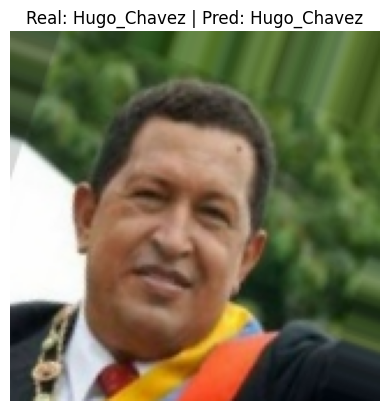

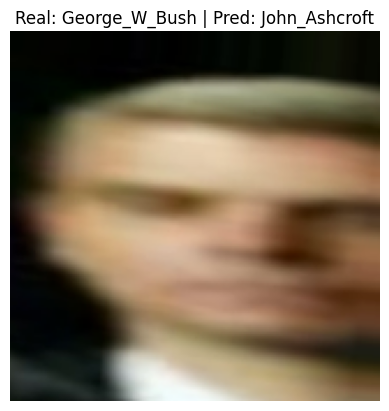

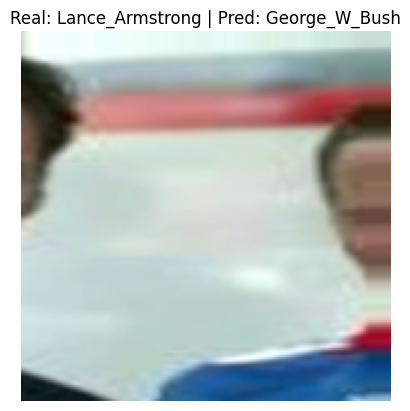

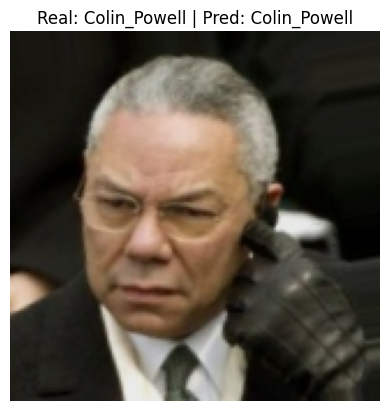

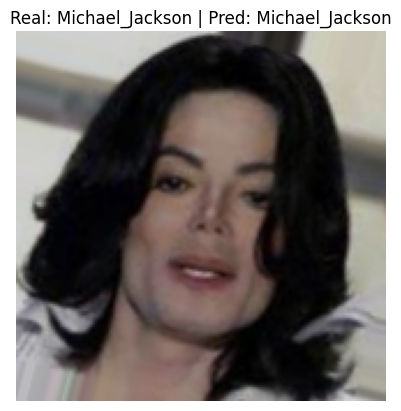

In [ ]:
# Visualizar predições
class_indices = {v: k for k, v in train_gen.class_indices.items()}

x_batch, y_batch = next(val_gen)
preds = model.predict(x_batch)

for i in range(5):
    plt.imshow(x_batch[i])
    plt.title(f"Real: {class_indices[np.argmax(y_batch[i])]} | Pred: {class_indices[np.argmax(preds[i])]}")
    plt.axis("off")
    plt.show()
